Total directories (excluding dot-folders): 99
First 8 directories: ['1', '10', '11', '12', '13', '14', '15', '16']

Valid cases found: 99
Cases with missing expected files: 0

Example valid cases (first 6):
  {'case': '1', 'gt': 'dataset/1/gt.nii', 'p5': 'dataset/1/p5.nii'}
  {'case': '10', 'gt': 'dataset/10/gt.nii', 'p5': 'dataset/10/p5.nii'}
  {'case': '11', 'gt': 'dataset/11/gt.nii', 'p5': 'dataset/11/p5.nii'}
  {'case': '12', 'gt': 'dataset/12/gt.nii', 'p5': 'dataset/12/p5.nii'}
  {'case': '13', 'gt': 'dataset/13/gt.nii', 'p5': 'dataset/13/p5.nii'}
  {'case': '14', 'gt': 'dataset/14/gt.nii', 'p5': 'dataset/14/p5.nii'}

Saved mapping to dataset_case_mapping.csv

Loading sample case: 1

=== IMAGE PROPERTIES ===
GT path: dataset/1/gt.nii
P5 path: dataset/1/p5.nii
GT shape: (896, 896, 120)
P5 shape: (896, 896, 120)
GT unique values (sample up to 20): [0. 1.]
GT min/max: 0.0 / 1.0
P5 min/max: 0.0 / 732.0
GT voxel spacing: (0.3794643, 0.3794643, 1.7)
P5 voxel spacing: (0.3794643, 0.37946

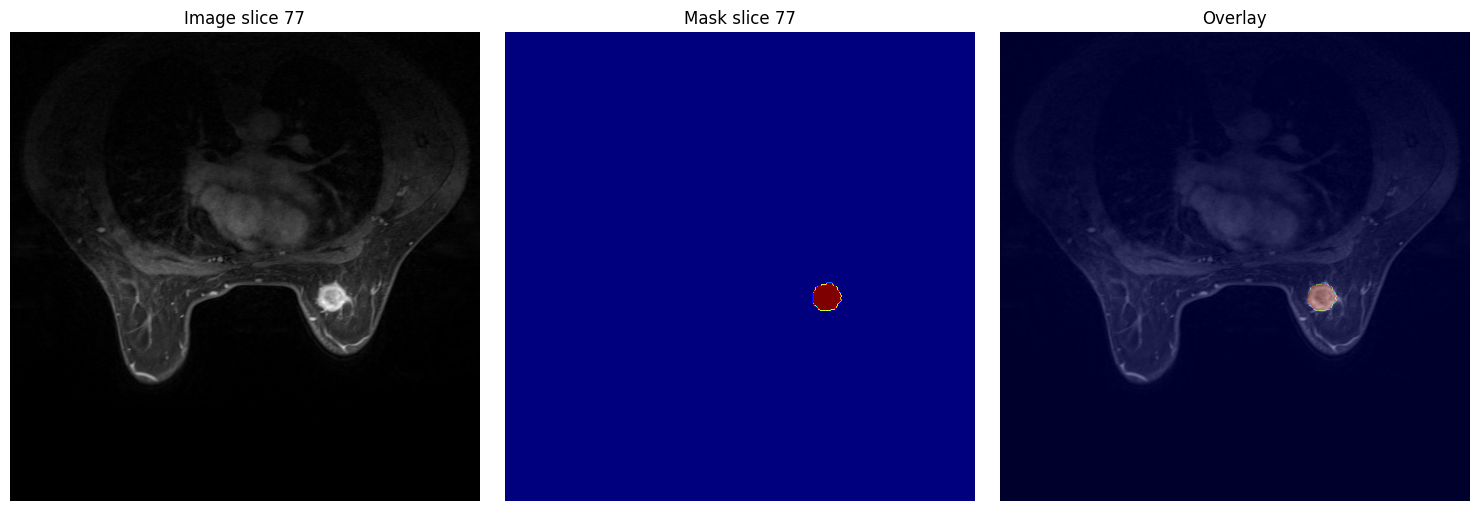

In [2]:
import os
from pathlib import Path
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt

DATASET_PATH = Path("./dataset")  # adjust if needed

# 1) list all directories but skip hidden/system ones (.ipynb_checkpoints etc)
all_dirs = sorted([d for d in DATASET_PATH.iterdir() if d.is_dir() and not d.name.startswith('.')])
print(f"Total directories (excluding dot-folders): {len(all_dirs)}")
print("First 8 directories:", [d.name for d in all_dirs[:8]])

# 2) find gt / p5 files robustly (case-insensitive, support .nii and .nii.gz)
valid_cases = []
missing_cases = []

for d in all_dirs:
    nii_files = list(d.glob("*.nii")) + list(d.glob("*.nii.gz"))
    names = [p.name.lower() for p in nii_files]
    # look for strings 'gt' and 'p5' anywhere in the filename (robust)
    gt_candidates = [p for p in nii_files if 'gt' in p.name.lower()]
    p5_candidates = [p for p in nii_files if 'p5' in p.name.lower()]
    if gt_candidates and p5_candidates:
        # pick first candidate each (you can make this stricter if needed)
        valid_cases.append({'case': d.name, 'gt': str(gt_candidates[0]), 'p5': str(p5_candidates[0])})
    else:
        # record what's missing for easier debugging
        missing = []
        if not gt_candidates:
            missing.append('gt')
        if not p5_candidates:
            missing.append('p5')
        missing_cases.append({'case': d.name, 'missing': ','.join(missing), 'found_files': [p.name for p in nii_files]})

print(f"\nValid cases found: {len(valid_cases)}")
print(f"Cases with missing expected files: {len(missing_cases)}")

# show examples
if valid_cases:
    print("\nExample valid cases (first 6):")
    for v in valid_cases[:6]:
        print(" ", v)
else:
    print("⚠️ No valid cases found. Check file naming (gt/p5) or presence of .nii/.nii.gz files.")

if missing_cases:
    print("\nExample missing cases (first 6):")
    for m in missing_cases[:6]:
        print(" ", m)

# Save mapping for later use
mapping_df = pd.DataFrame(valid_cases)
mapping_df.to_csv("dataset_case_mapping.csv", index=False)
print("\nSaved mapping to dataset_case_mapping.csv")

# 3) Load and inspect one sample (the first valid case)
if not valid_cases:
    raise SystemExit("No valid cases to inspect. Fix filenames or upload files and re-run.")

sample = valid_cases[0]
print(f"\nLoading sample case: {sample['case']}")
gt_path = Path(sample['gt'])
p5_path = Path(sample['p5'])

try:
    gt_img = nib.load(str(gt_path))
    p5_img = nib.load(str(p5_path))
except Exception as e:
    raise RuntimeError(f"Failed to load NIfTI files for case {sample['case']}: {e}")

gt_data = gt_img.get_fdata()
p5_data = p5_img.get_fdata()

print("\n=== IMAGE PROPERTIES ===")
print("GT path:", gt_path)
print("P5 path:", p5_path)
print("GT shape:", gt_data.shape)
print("P5 shape:", p5_data.shape)
print("GT unique values (sample up to 20):", np.unique(gt_data)[:20])
print("GT min/max:", float(np.min(gt_data)), "/", float(np.max(gt_data)))
print("P5 min/max:", float(np.min(p5_data)), "/", float(np.max(p5_data)))

# voxel spacing (header.get_zooms may be shorter/longer; pad/truncate to 3)
def zooms_to_3(zooms):
    zl = list(zooms)
    if len(zl) >= 3: return tuple(zl[:3])
    # pad with 1.0 if missing
    while len(zl) < 3: zl.append(1.0)
    return tuple(zl)

print("GT voxel spacing:", zooms_to_3(gt_img.header.get_zooms()))
print("P5 voxel spacing:", zooms_to_3(p5_img.header.get_zooms()))

# 4) Visualize a slice: choose slice where mask has content if possible
def show_overlay(image, mask, cmap_img='gray', cmap_mask='jet'):
    # choose best axis and slice
    nonzero = np.argwhere(mask > 0)
    if nonzero.size:
        # find median along last axis
        z = int(np.median(nonzero[:, 2])) if mask.ndim == 3 else mask.shape[2] // 2
    else:
        z = image.shape[2] // 2
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(np.rot90(image[:, :, z]), cmap=cmap_img)
    axes[0].set_title(f'Image slice {z}')
    axes[0].axis('off')
    axes[1].imshow(np.rot90(mask[:, :, z]), cmap=cmap_mask)
    axes[1].set_title(f'Mask slice {z}')
    axes[1].axis('off')
    axes[2].imshow(np.rot90(image[:, :, z]), cmap=cmap_img)
    axes[2].imshow(np.rot90(mask[:, :, z]), cmap=cmap_mask, alpha=0.35)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()

# handle 2D/3D shapes gracefully
if p5_data.ndim == 2:
    print("P5 image appears 2D — check dataset (expected 3D volumes).")
else:
    show_overlay(p5_data, gt_data)


In [2]:
from pathlib import Path
import nibabel as nib
import os, sys
DATASET_PATH = Path("./dataset")

# list case dirs (skip hidden)
case_dirs = sorted([d for d in DATASET_PATH.iterdir() if d.is_dir() and not d.name.startswith('.')])
print("Found case dirs:", len(case_dirs), "Example:", [d.name for d in case_dirs[:8]])

# show counts and file sizes for first 10 cases
print("\nFirst 10 cases (name, number of files, file list sizes in MB):")
for d in case_dirs[:10]:
    files = sorted([f for f in d.iterdir() if f.is_file()])
    files_info = [(f.name, round(f.stat().st_size/1e6,2)) for f in files]
    print(d.name, len(files), files_info)

# collect all .nii and .nii.gz and show top largest files
all_nifti = [f for d in case_dirs for f in d.glob("*.nii")] + [f for d in case_dirs for f in d.glob("*.nii.gz")]
all_nifti = sorted(set(all_nifti), key=lambda p: p.stat().st_size, reverse=True)
print("\nTotal nifti files found:", len(all_nifti))
print("Top 10 largest nifti files (name, size MB):")
for f in all_nifti[:10]:
    print(" ", f, round(f.stat().st_size/1e6,2))

# header-only check for top few files (quick)
print("\nHeader preview (top 6 largest files):")
for f in all_nifti[:6]:
    try:
        img = nib.load(str(f))   # nib.load is fast; don't call get_fdata()
        shape = img.header.get_data_shape()
        zooms = img.header.get_zooms()[:3]
        print(f.name, "shape:", shape, "zooms:", tuple(zooms))
    except Exception as e:
        print("Error reading header for", f.name, ":", e)

# Are any files extremely large (>500MB)?
huge = [f for f in all_nifti if f.stat().st_size > 500_000_000]
print("\nFiles >500 MB:", len(huge))
if huge:
    for f in huge[:10]:
        print(" ", f.name, round(f.stat().st_size/1e6,2), "MB")


Found case dirs: 99 Example: ['1', '10', '11', '12', '13', '14', '15', '16']

First 10 cases (name, number of files, file list sizes in MB):
1 2 [('gt.nii', 96.34), ('p5.nii', 192.68)]
10 2 [('gt.nii', 96.34), ('p5.nii', 192.68)]
11 2 [('gt.nii', 96.34), ('p5.nii', 192.68)]
12 2 [('gt.nii', 96.34), ('p5.nii', 192.68)]
13 2 [('gt.nii', 96.34), ('p5.nii', 192.68)]
14 2 [('gt.nii', 96.34), ('p5.nii', 192.68)]
15 2 [('gt.nii', 96.34), ('p5.nii', 192.68)]
16 2 [('gt.nii', 96.34), ('p5.nii', 192.68)]
17 2 [('gt.nii', 96.34), ('p5.nii', 192.68)]
18 2 [('gt.nii', 96.34), ('p5.nii', 192.68)]

Total nifti files found: 198
Top 10 largest nifti files (name, size MB):
  dataset/28/p5.nii 385.35
  dataset/27/p5.nii 385.35
  dataset/26/p5.nii 385.35
  dataset/29/p5.nii 297.8
  dataset/41/p5.nii 192.68
  dataset/1/p5.nii 192.68
  dataset/13/p5.nii 192.68
  dataset/21/p5.nii 192.68
  dataset/94/p5.nii 192.68
  dataset/43/p5.nii 192.68

Header preview (top 6 largest files):
p5.nii shape: (896, 896, 240)

In [3]:
# Lightweight mapping: header + single-slice sample (fast)
from pathlib import Path
import nibabel as nib
import numpy as np
DATASET_PATH = Path("./dataset")
case_dirs = sorted([d for d in DATASET_PATH.iterdir() if d.is_dir() and not d.name.startswith('.')])

mappings = []
for d in case_dirs:
    nifti = sorted(list(d.glob("*.nii")) + list(d.glob("*.nii.gz")))
    if not nifti:
        mappings.append({'case': d.name, 'status':'no_nifti', 'files':[]})
        continue
    info = {'case': d.name, 'files':[p.name for p in nifti], 'image':None, 'mask':None, 'status':'unknown'}
    # header-only stats
    stats = []
    for p in nifti:
        try:
            img = nib.load(str(p))
            shape = img.header.get_data_shape()
            zooms = img.header.get_zooms()[:3]
            # sample center slice using dataobj (cheap)
            data_proxy = img.dataobj
            if len(shape) >= 3:
                z = shape[2]//2
                try:
                    slice_arr = np.asarray(data_proxy[:,:,z])
                    sampled_unique = np.unique(slice_arr)
                    n_unique = sampled_unique.size
                except Exception:
                    n_unique = None
            else:
                # 2D image
                try:
                    arr2 = np.asarray(data_proxy)
                    sampled_unique = np.unique(arr2)
                    n_unique = sampled_unique.size
                except Exception:
                    n_unique = None
            stats.append({'path':str(p), 'shape':shape, 'zooms':zooms, 'sampled_unique_count': n_unique})
        except Exception as e:
            stats.append({'path':str(p), 'error':str(e)})
    # heuristic: file with small sampled_unique_count likely mask
    candidates = [s for s in stats if s.get('sampled_unique_count') is not None]
    if len(candidates) >= 2:
        sorted_candidates = sorted(candidates, key=lambda s: (s['sampled_unique_count'] if s['sampled_unique_count'] is not None else 1e9))
        mask_path = sorted_candidates[0]['path']
        # image is likely the one with largest sampled_unique_count
        image_path = sorted(candidates, key=lambda s: (s['sampled_unique_count'] if s['sampled_unique_count'] is not None else -1))[-1]['path']
        info.update({'image':image_path, 'mask':mask_path, 'status':'ok'})
    else:
        # fallback to name-based matching
        names = [p.lower() for p in [p.name for p in nifti]]
        mask_candidates = [p for p in nifti if any(t in p.name.lower() for t in ('gt','mask','seg','label'))]
        p5_candidates = [p for p in nifti if 'p5' in p.name.lower() or 'img' in p.name.lower()]
        if mask_candidates and p5_candidates:
            info.update({'image': str(p5_candidates[0]), 'mask': str(mask_candidates[0]), 'status':'ok_name'})
        else:
            info['status'] = 'ambiguous'
    info['stats'] = stats
    mappings.append(info)

# quick summary
import pandas as pd
df = pd.DataFrame([{'case':m['case'], 'status':m['status'], 'image':m.get('image'), 'mask':m.get('mask')} for m in mappings])
print(df['status'].value_counts())
df.head(8)


status
ok    99
Name: count, dtype: int64


,case,status,image,mask
0,1,ok,dataset/1/p5.nii,dataset/1/gt.nii
1,10,ok,dataset/10/p5.nii,dataset/10/gt.nii
2,11,ok,dataset/11/p5.nii,dataset/11/gt.nii
3,12,ok,dataset/12/p5.nii,dataset/12/gt.nii
4,13,ok,dataset/13/p5.nii,dataset/13/gt.nii
5,14,ok,dataset/14/p5.nii,dataset/14/gt.nii
6,15,ok,dataset/15/p5.nii,dataset/15/gt.nii
7,16,ok,dataset/16/p5.nii,dataset/16/gt.nii


In [4]:
# Cell A — quick labels/outcomes check (run in your Radiomics.ipynb)
from pathlib import Path
import pandas as pd

DATASET = Path("./dataset")
files = list(DATASET.glob("*.csv")) + list(DATASET.glob("*.xlsx")) + list(DATASET.glob("*.txt"))
print("Label files found in dataset root:", [f.name for f in files])

if files:
    lf = files[0]
    print("\nReading:", lf.name)
    try:
        if lf.suffix == ".csv" or lf.suffix == ".txt":
            df = pd.read_csv(lf, nrows=2000)
        else:
            df = pd.read_excel(lf, nrows=2000)
        print("Columns:", df.columns.tolist())
        # suggest candidate case and label columns
        case_cols = [c for c in df.columns if c.lower() in ("case","id","patient","folder","filename")]
        label_cols = [c for c in df.columns if c.lower() in ("label","outcome","diagnosis","target","y","class","gt")]
        print("Suggested case-id columns:", case_cols)
        print("Suggested label columns:", label_cols)
        if label_cols:
            col = label_cols[0]
            print(f"\nValue counts for suggested label column '{col}':")
            print(df[col].value_counts(dropna=False).head(20))
        else:
            print("\nNo obvious label column automatically found — please open the file or paste first 5 rows.")
        # show example rows
        print("\nShowing first 6 rows of the label file:")
        display(df.head(6))
    except Exception as e:
        print("Failed to read label file:", e)
else:
    print("No CSV/XLSX/TXT label files found in dataset root. If your labels live elsewhere, run this to search subfolders:")
    print("  !find ./dataset -maxdepth 2 -type f \\( -name '*.csv' -o -name '*.xlsx' -o -name '*.txt' \\')")


Label files found in dataset root: []
No CSV/XLSX/TXT label files found in dataset root. If your labels live elsewhere, run this to search subfolders:
  !find ./dataset -maxdepth 2 -type f \( -name '*.csv' -o -name '*.xlsx' -o -name '*.txt' \')


In [5]:
# Cell B — GPU check
import subprocess, sys
print("Running nvidia-smi (if available)...")
try:
    out = subprocess.check_output(["nvidia-smi","-L"], stderr=subprocess.STDOUT, text=True)
    print(out)
except Exception as e:
    print("nvidia-smi not available or failed:", e)

print("\nChecking PyTorch CUDA:")
try:
    import torch
    print("PyTorch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("Device name:", torch.cuda.get_device_name(0))
        try:
            props = torch.cuda.get_device_properties(0)
            print("Total memory (GB):", round(props.total_memory/1e9,2))
        except Exception as e:
            print("Could not get device properties:", e)
except Exception as e:
    print("PyTorch not installed or import failed:", e)
    print("Install with: pip install torch --extra-index-url https://download.pytorch.org/whl/cu118  (adjust CUDA version as needed)")


Running nvidia-smi (if available)...
GPU 0: NVIDIA A100-SXM4-80GB (UUID: GPU-a193df0f-a147-3427-c485-e9f2fb9da3ee)


Checking PyTorch CUDA:
PyTorch version: 2.6.0a0+df5bbc09d1.nv24.12
CUDA available: True
Device name: NVIDIA A100-SXM4-80GB
Total memory (GB): 84.99


In [6]:
# Compute median spacing and produce PyRadiomics params (fast header-only scan)
from pathlib import Path
import nibabel as nib
import numpy as np
import json
DATASET = Path("./dataset")
case_dirs = sorted([d for d in DATASET.iterdir() if d.is_dir() and not d.name.startswith('.')])

# Collect zooms (use header only — very fast)
zooms_list = []
for d in case_dirs:
    # detect p5 or image-like files
    files = sorted([p for p in d.glob("*.nii")] + [p for p in d.glob("*.nii.gz")])
    # prefer p5 files
    img_candidates = [p for p in files if 'p5' in p.name.lower() or 'img' in p.name.lower() or 'image' in p.name.lower()]
    candidates = img_candidates if img_candidates else files
    if not candidates:
        continue
    # header
    try:
        hdr = nib.load(str(candidates[0])).header
        z = hdr.get_zooms()[:3]
        # normalize to 3-tuple
        if len(z) < 3:
            z = list(z) + [1.0]*(3-len(z))
        zooms_list.append(tuple(map(float, z[:3])))
    except Exception:
        continue

# compute median spacing across dataset
zooms_arr = np.array(zooms_list)
median_spacing = tuple(np.median(zooms_arr, axis=0).round(4))
print("Dataset median voxel spacing (sx,sy,sz):", median_spacing)

# Recommended PyRadiomics params (tweak binWidth after testing)
PYR_PARAMS = {
  "binWidth": 25,
  "resampledPixelSpacing": list(median_spacing),
  "interpolator": "sitkBSpline",
  "label": 1,
  "force2D": False,
  "normalize": True,
  "normalizeScale": 100,
  "removeOutliers": 3,
  "additionalInfo": True,
  "verbose": False,
  "enableCExtensions": True,
  "geometry": True,
  "featureClass": {
    "firstorder": {},
    "shape": {},
    "glcm": {},
    "glrlm": {},
    "glszm": {},
    "ngtdm": {},
    "gldm": {}
  }
}

print("\nSuggested PyRadiomics params (JSON):")
print(json.dumps(PYR_PARAMS, indent=2))
# Save for your pipeline:
Path("./radiomics_output").mkdir(exist_ok=True)
with open("./radiomics_output/pyradiomics_params_suggested.json", "w") as f:
    json.dump(PYR_PARAMS, f, indent=2)
print("Saved to radiomics_output/pyradiomics_params_suggested.json")


Dataset median voxel spacing (sx,sy,sz): (0.3795, 0.3795, 1.7)

Suggested PyRadiomics params (JSON):
{
  "binWidth": 25,
  "resampledPixelSpacing": [
    0.3795,
    0.3795,
    1.7
  ],
  "interpolator": "sitkBSpline",
  "label": 1,
  "force2D": false,
  "normalize": true,
  "normalizeScale": 100,
  "removeOutliers": 3,
  "additionalInfo": true,
  "verbose": false,
  "enableCExtensions": true,
  "geometry": true,
  "featureClass": {
    "firstorder": {},
    "shape": {},
    "glcm": {},
    "glrlm": {},
    "glszm": {},
    "ngtdm": {},
    "gldm": {}
  }
}
Saved to radiomics_output/pyradiomics_params_suggested.json


In [8]:
import pandas as pd
import os

print("=== INSPECTING LABEL FILES ===\n")

label_files = [
    'labels.csv',
    'labels_volume.csv', 
    'dataset_labels.csv',
    'dataset_volumes_classified.csv',
    'split_train.csv',
    'split_val.csv',
    'split_test.csv'
]

for file in label_files:
    if os.path.exists(file):
        print(f"\n{'='*60}")
        print(f"FILE: {file}")
        print('='*60)
        try:
            df = pd.read_csv(file)
            print(f"Shape: {df.shape}")
            print(f"Columns: {list(df.columns)}")
            print(f"\nFirst 5 rows:")
            print(df.head())
            if 'label' in df.columns or 'class' in df.columns or 'target' in df.columns:
                label_col = [c for c in df.columns if 'label' in c.lower() or 'class' in c.lower() or 'target' in c.lower()][0]
                print(f"\nLabel distribution:")
                print(df[label_col].value_counts())
        except Exception as e:
            print(f"Error reading {file}: {e}")

# Check dataset_case_mapping.csv
print(f"\n{'='*60}")
print("FILE: dataset_case_mapping.csv")
print('='*60)
df_mapping = pd.read_csv('dataset_case_mapping.csv')
print(f"Shape: {df_mapping.shape}")
print(df_mapping.head(10))

=== INSPECTING LABEL FILES ===


FILE: labels.csv
Shape: (99, 2)
Columns: ['case_id', 'label']

First 5 rows:
   case_id  label
0        1      1
1       10      1
2       11      1
3       12      1
4       13      1

Label distribution:
label
1    99
Name: count, dtype: int64

FILE: labels_volume.csv
Shape: (99, 3)
Columns: ['case_id', 'tumor_volume_ml', 'volume_class']

First 5 rows:
   case_id  tumor_volume_ml volume_class
0        1         4.678885        small
1       10        43.994344        large
2       11        19.541455       medium
3       12        11.953261       medium
4       13         5.518754        small

FILE: dataset_labels.csv
Shape: (99, 2)
Columns: ['case', 'label']

First 5 rows:
   case  label
0     1      1
1    10      1
2    11      1
3    12      1
4    13      1

Label distribution:
label
1    99
Name: count, dtype: int64

FILE: dataset_volumes_classified.csv
Shape: (99, 3)
Columns: ['case_id', 'tumor_volume_ml', 'volume_class']

First 5 rows:
   cas

In [14]:
# --- Install pyradiomics and dependencies with Python 3.12 fix ---

!pip install --quiet SimpleITK nibabel scikit-learn pandas matplotlib seaborn xgboost joblib tqdm

# Clone the pyradiomics source code
!git clone https://github.com/AIM-Harvard/pyradiomics.git
%cd pyradiomics

# Patch the deprecated SafeConfigParser line automatically
!sed -i 's/SafeConfigParser/ConfigParser/g' versioneer.py

# Install pyradiomics from the patched source
!pip install .

# Go back to the previous directory
%cd ..

print("✅ pyradiomics successfully installed and patched for Python 3.12!")


DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/texttable-1.7.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.13a0+0d33366-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/igraph-0.11.8-py3.12-linux-x86_64.egg is deprecated. pip 

In [15]:
import radiomics
print("Radiomics version:", radiomics.__version__)


Radiomics version: 3.1.1.dev111+g8ed579383


In [17]:
import pandas as pd

case_mapping = pd.read_csv("dataset_case_mapping.csv")
labels = pd.read_csv("labels_volume.csv")

print("case_mapping columns:", case_mapping.columns.tolist())
print("labels columns:", labels.columns.tolist())


case_mapping columns: ['case', 'gt', 'p5']
labels columns: ['case_id', 'tumor_volume_ml', 'volume_class']


In [23]:
"""
COMPREHENSIVE RADIOMICS FEATURE EXTRACTION PIPELINE
====================================================
Breast Cancer MRI Dataset - 99 Cases
Features: Shape + First-Order + Texture + Wavelet + LoG (~600-700 features/case)

Features:
- Auto-resume on kernel restart
- N4 bias field correction
- Automatic resampling to median spacing
- Progress tracking with ETA
- Robust error handling
- Checkpoint saving every 10 cases
"""

import os
import sys
import time
import json
import warnings
from pathlib import Path
from datetime import datetime, timedelta
import traceback

import numpy as np
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
from radiomics import featureextractor
import logging

warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration for radiomics extraction"""
    
    # Paths
    DATASET_PATH = Path("./dataset")
    OUTPUT_DIR = Path("./radiomics_output")
    CHECKPOINT_DIR = OUTPUT_DIR / "checkpoints"
    TEMP_DIR = OUTPUT_DIR / "temp"
    
    # Files
    CASE_MAPPING_FILE = "dataset_case_mapping.csv"
    LABELS_FILE = "labels_volume.csv"
    
    # Output files
    FEATURES_CSV = OUTPUT_DIR / "radiomics_features_all.csv"
    FEATURES_TRAIN_CSV = OUTPUT_DIR / "radiomics_features_train.csv"
    FEATURES_VAL_CSV = OUTPUT_DIR / "radiomics_features_val.csv"
    FEATURES_TEST_CSV = OUTPUT_DIR / "radiomics_features_test.csv"
    
    PROGRESS_FILE = CHECKPOINT_DIR / "extraction_progress.json"
    ERROR_LOG = OUTPUT_DIR / "extraction_errors.log"
    PARAMS_FILE = OUTPUT_DIR / "pyradiomics_params.json"
    
    # Processing settings
    CHECKPOINT_INTERVAL = 10  # Save checkpoint every N cases
    N4_CORRECTION = True
    RESAMPLE = True
    
    # PyRadiomics settings (will be computed from dataset)
    BIN_WIDTH = 25
    LABEL = 1

# ============================================================================
# SETUP DIRECTORIES AND LOGGING
# ============================================================================

def setup_environment():
    """Create necessary directories and setup logging"""
    Config.OUTPUT_DIR.mkdir(exist_ok=True)
    Config.CHECKPOINT_DIR.mkdir(exist_ok=True)
    Config.TEMP_DIR.mkdir(exist_ok=True)
    
    # Setup logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(Config.ERROR_LOG),
            logging.StreamHandler(sys.stdout)
        ]
    )
    
    return logging.getLogger(__name__)

# ============================================================================
# COMPUTE OPTIMAL RESAMPLING SPACING
# ============================================================================

def compute_median_spacing(case_mapping_df, logger):
    """Compute median voxel spacing from all cases"""
    logger.info("Computing median voxel spacing from dataset...")
    
    zooms_list = []
    
    for _, row in case_mapping_df.iterrows():
        try:
            img_path = row['p5']
            img = nib.load(img_path)
            zooms = img.header.get_zooms()[:3]
            
            # Ensure 3D
            if len(zooms) < 3:
                zooms = list(zooms) + [1.0] * (3 - len(zooms))
            
            zooms_list.append(tuple(float(z) for z in zooms[:3]))
        except Exception as e:
            logger.warning(f"Could not read spacing for {row['case']}: {e}")
            continue
    
    if not zooms_list:
        logger.error("Could not compute median spacing from any case!")
        return [1.0, 1.0, 1.0]
    
    zooms_array = np.array(zooms_list)
    median_spacing = tuple(np.median(zooms_array, axis=0).round(4))
    
    logger.info(f"Computed median spacing: {median_spacing}")
    return list(median_spacing)

# ============================================================================
# CREATE PYRADIOMICS PARAMETERS
# ============================================================================

def create_pyradiomics_params(resampled_spacing, logger):
    """Create PyRadiomics parameter dictionary compatible with v3.0.1"""
    
    params = {
        # === Image types ===
        "imageType": {
            "Original": {},
            "Wavelet": {},
            "LoG": {"sigma": [1.0, 2.0, 3.0, 4.0, 5.0]}
        },

        # === Feature class (singular key name for v3.0.1) ===
        "featureClass": {
            "shape": None,
            "firstorder": None,
            "glcm": None,
            "glrlm": None,
            "glszm": None,
            "gldm": None,
            "ngtdm": None
        },

        # === Settings ===
        "setting": {
            "binWidth": Config.BIN_WIDTH,
            "resampledPixelSpacing": resampled_spacing if Config.RESAMPLE else None,
            "interpolator": "sitkBSpline",
            "padDistance": 5,
            "label": Config.LABEL,
            "normalize": True,
            "normalizeScale": 100,
            "removeOutliers": 3,
            "additionalInfo": True
        }
    }

    # Save params for reproducibility
    with open(Config.PARAMS_FILE, 'w') as f:
        json.dump(params, f, indent=2)
    
    logger.info(f"✅ PyRadiomics parameters saved to: {Config.PARAMS_FILE}")
    
    return params



# ============================================================================
# N4 BIAS FIELD CORRECTION
# ============================================================================

def apply_n4_correction(image_sitk, mask_sitk, logger):
    """Apply N4 bias field correction to MRI image"""
    try:
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        corrector.SetMaximumNumberOfIterations([50, 50, 50, 50])
        corrector.SetConvergenceThreshold(0.001)
        
        # Use mask to guide correction
        mask_binary = mask_sitk > 0
        corrected = corrector.Execute(image_sitk, mask_binary)
        
        return corrected
    except Exception as e:
        logger.warning(f"N4 correction failed: {e}. Using original image.")
        return image_sitk

# ============================================================================
# LOAD AND PREPROCESS IMAGES
# ============================================================================

def load_and_preprocess(image_path, mask_path, case_id, logger):
    """Load and preprocess image and mask"""
    try:
        # Load with SimpleITK
        image_sitk = sitk.ReadImage(str(image_path))
        mask_sitk = sitk.ReadImage(str(mask_path))
        
        # Ensure same size
        if image_sitk.GetSize() != mask_sitk.GetSize():
            logger.warning(f"Case {case_id}: Image and mask sizes don't match. Resampling mask.")
            mask_sitk = sitk.Resample(mask_sitk, image_sitk, sitk.Transform(), 
                                      sitk.sitkNearestNeighbor, 0.0, 
                                      mask_sitk.GetPixelID())
        
        # Apply N4 correction if enabled
        if Config.N4_CORRECTION:
            image_sitk = apply_n4_correction(image_sitk, mask_sitk, logger)
        
        # Convert mask to binary (ensure label=1)
        mask_array = sitk.GetArrayFromImage(mask_sitk)
        mask_array = (mask_array > 0).astype(np.uint8)
        mask_sitk = sitk.GetImageFromArray(mask_array)
        mask_sitk.CopyInformation(image_sitk)
        
        # Save preprocessed to temp
        temp_img_path = Config.TEMP_DIR / f"case_{case_id}_img.nii.gz"
        temp_mask_path = Config.TEMP_DIR / f"case_{case_id}_mask.nii.gz"
        
        sitk.WriteImage(image_sitk, str(temp_img_path))
        sitk.WriteImage(mask_sitk, str(temp_mask_path))
        
        return str(temp_img_path), str(temp_mask_path), True
        
    except Exception as e:
        logger.error(f"Case {case_id}: Preprocessing failed - {e}")
        logger.error(traceback.format_exc())
        return None, None, False

# ============================================================================
# EXTRACT FEATURES FOR ONE CASE
# ============================================================================

def extract_features_single_case(case_id, image_path, mask_path, extractor, logger):
    """Extract radiomics features for a single case"""
    
    start_time = time.time()
    
    try:
        # Preprocess
        img_processed, mask_processed, success = load_and_preprocess(
            image_path, mask_path, case_id, logger
        )
        
        if not success:
            return None, False
        
        # Extract features
        feature_vector = extractor.execute(img_processed, mask_processed)
        
        # Convert to dict with case_id
        features = {'case_id': case_id}
        for key, val in feature_vector.items():
            # Clean feature names
            clean_key = str(key).replace('original_', '').replace('diagnostics_', 'diag_')
            try:
                features[clean_key] = float(val)
            except (ValueError, TypeError):
                features[clean_key] = str(val)
        
        # Clean up temp files
        try:
            os.remove(img_processed)
            os.remove(mask_processed)
        except:
            pass
        
        elapsed = time.time() - start_time
        logger.info(f"  ✓ Case {case_id} completed in {elapsed:.1f}s - {len(features)} features extracted")
        
        return features, True
        
    except Exception as e:
        logger.error(f"  ✗ Case {case_id} FAILED: {e}")
        logger.error(traceback.format_exc())
        return None, False

# ============================================================================
# PROGRESS TRACKING
# ============================================================================

def load_progress():
    """Load extraction progress"""
    if Config.PROGRESS_FILE.exists():
        with open(Config.PROGRESS_FILE, 'r') as f:
            return json.load(f)
    return {
        'completed_cases': [],
        'failed_cases': [],
        'last_checkpoint': 0,
        'start_time': datetime.now().isoformat()
    }

def save_progress(progress):
    """Save extraction progress"""
    with open(Config.PROGRESS_FILE, 'w') as f:
        json.dump(progress, f, indent=2)

def save_checkpoint(features_list, checkpoint_num, logger):
    """Save checkpoint of extracted features"""
    if not features_list:
        return
    
    checkpoint_file = Config.CHECKPOINT_DIR / f"features_checkpoint_{checkpoint_num}.csv"
    df = pd.DataFrame(features_list)
    df.to_csv(checkpoint_file, index=False)
    logger.info(f"💾 Checkpoint saved: {checkpoint_file} ({len(features_list)} cases)")

# ============================================================================
# MAIN EXTRACTION PIPELINE
# ============================================================================

def run_extraction_pipeline():
    """Main extraction pipeline with resume capability"""
    
    # Setup
    logger = setup_environment()
    
    logger.info("="*70)
    logger.info("COMPREHENSIVE RADIOMICS FEATURE EXTRACTION")
    logger.info("="*70)
    
        # Load data
    logger.info("\n📂 Loading dataset information...")
    case_mapping = pd.read_csv(Config.CASE_MAPPING_FILE)
    labels = pd.read_csv(Config.LABELS_FILE)

    # 🔧 Rename columns so both have a matching identifier
    if 'case' in case_mapping.columns:
        case_mapping.rename(columns={'case': 'case_id'}, inplace=True)

    # Safety check
    if 'case_id' not in case_mapping.columns or 'case_id' not in labels.columns:
        logger.error(f"❌ ERROR: Missing 'case_id' column in input CSVs.")
        logger.error(f"case_mapping columns: {case_mapping.columns.tolist()}")
        logger.error(f"labels columns: {labels.columns.tolist()}")
        raise KeyError("Missing 'case_id' column in input CSVs.")

    # Merge datasets
    df = case_mapping.merge(labels, on='case_id', how='left')
    logger.info(f"Total cases: {len(df)}")


    
    # Compute median spacing
    median_spacing = compute_median_spacing(case_mapping, logger)
    
    # Create PyRadiomics parameters
    logger.info("\n⚙️ Creating PyRadiomics extractor...")
    params = create_pyradiomics_params(median_spacing, logger)
    
    # Initialize extractor
    extractor = featureextractor.RadiomicsFeatureExtractor(params)
    
    logger.info(f"\n📊 Feature Extraction Settings:")
    logger.info(f"  • Bin Width: {Config.BIN_WIDTH}")
    logger.info(f"  • Resampled Spacing: {median_spacing if Config.RESAMPLE else 'Original'}")
    logger.info(f"  • N4 Correction: {Config.N4_CORRECTION}")
    logger.info(f"  • Label: {Config.LABEL}")
    logger.info(f"  • Image Types: Original + Wavelet (8) + LoG (5 sigma)")
    logger.info(f"  • Feature Classes: Shape, FirstOrder, GLCM, GLRLM, GLSZM, GLDM, NGTDM")
    logger.info(f"  • Expected features per case: ~600-700")
    
    # Load progress
    progress = load_progress()
    completed_cases = set(progress['completed_cases'])
    failed_cases = set(progress['failed_cases'])
    
    # Cases to process
    cases_to_process = [
        row for _, row in df.iterrows() 
        if row['case_id'] not in completed_cases
    ]
    
    if not cases_to_process:
        logger.info("\n✅ All cases already processed!")
        return
    
    logger.info(f"\n🚀 Starting extraction...")
    logger.info(f"  • Total cases: {len(df)}")
    logger.info(f"  • Already completed: {len(completed_cases)}")
    logger.info(f"  • Failed (will retry): {len(failed_cases)}")
    logger.info(f"  • To process: {len(cases_to_process)}")
    
    # Extract features
    all_features = []
    start_time = time.time()
    
    for idx, row in enumerate(cases_to_process, 1):
        case_id = row['case_id']
        
        # Progress
        elapsed = time.time() - start_time
        avg_time_per_case = elapsed / idx if idx > 0 else 0
        remaining_cases = len(cases_to_process) - idx
        eta_seconds = avg_time_per_case * remaining_cases
        eta = timedelta(seconds=int(eta_seconds))
        
        logger.info(f"\n[{idx}/{len(cases_to_process)}] Processing Case {case_id} "
                   f"(ETA: {eta}, {avg_time_per_case:.1f}s/case)")
        
        # Extract
        features, success = extract_features_single_case(
            case_id, row['p5'], row['gt'], extractor, logger
        )
        
        if success and features:
            all_features.append(features)
            completed_cases.add(case_id)
            if case_id in failed_cases:
                failed_cases.remove(case_id)
        else:
            failed_cases.add(case_id)
        
        # Update progress
        progress['completed_cases'] = list(completed_cases)
        progress['failed_cases'] = list(failed_cases)
        save_progress(progress)
        
        # Checkpoint
        if idx % Config.CHECKPOINT_INTERVAL == 0:
            save_checkpoint(all_features, len(completed_cases), logger)
    
    # Final save
    logger.info("\n" + "="*70)
    logger.info("EXTRACTION COMPLETE - SAVING RESULTS")
    logger.info("="*70)
    
    if all_features:
        df_features = pd.DataFrame(all_features)
        
        # Merge with labels
        df_features = df_features.merge(labels, on='case_id', how='left')
        
        # Save complete features
        df_features.to_csv(Config.FEATURES_CSV, index=False)
        logger.info(f"\n✅ ALL FEATURES SAVED: {Config.FEATURES_CSV}")
        logger.info(f"   Shape: {df_features.shape}")
        logger.info(f"   Features per case: {df_features.shape[1] - 4}")  # excluding case_id, volume, class
        
        # Split by train/val/test
        train_ids = pd.read_csv('split_train.csv')['case_id'].tolist()
        val_ids = pd.read_csv('split_val.csv')['case_id'].tolist()
        test_ids = pd.read_csv('split_test.csv')['case_id'].tolist()
        
        df_train = df_features[df_features['case_id'].isin(train_ids)]
        df_val = df_features[df_features['case_id'].isin(val_ids)]
        df_test = df_features[df_features['case_id'].isin(test_ids)]
        
        df_train.to_csv(Config.FEATURES_TRAIN_CSV, index=False)
        df_val.to_csv(Config.FEATURES_VAL_CSV, index=False)
        df_test.to_csv(Config.FEATURES_TEST_CSV, index=False)
        
        logger.info(f"\n📊 SPLIT FILES SAVED:")
        logger.info(f"   Train: {Config.FEATURES_TRAIN_CSV} ({len(df_train)} cases)")
        logger.info(f"   Val:   {Config.FEATURES_VAL_CSV} ({len(df_val)} cases)")
        logger.info(f"   Test:  {Config.FEATURES_TEST_CSV} ({len(df_test)} cases)")
    
    # Summary
    total_time = time.time() - start_time
    logger.info(f"\n⏱️  EXTRACTION SUMMARY:")
    logger.info(f"   Total time: {timedelta(seconds=int(total_time))}")
    logger.info(f"   Successfully processed: {len(completed_cases)}/{len(df)}")
    logger.info(f"   Failed: {len(failed_cases)}")
    logger.info(f"   Average time per case: {total_time/len(cases_to_process):.1f}s")
    
    if failed_cases:
        logger.warning(f"\n⚠️  Failed cases: {sorted(failed_cases)}")
    
    logger.info(f"\n✅ ALL DONE! Check {Config.OUTPUT_DIR} for results.")

# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    try:
        run_extraction_pipeline()
    except KeyboardInterrupt:
        print("\n\n⚠️  Extraction interrupted by user. Progress saved.")
        print("Run the script again to resume from checkpoint.")
    except Exception as e:
        print(f"\n\n❌ FATAL ERROR: {e}")
        print(traceback.format_exc())
        print("\nCheck extraction_errors.log for details.")

2025-10-27 13:26:45,666 - INFO - ======================================================================
2025-10-27 13:26:45,667 - INFO - COMPREHENSIVE RADIOMICS FEATURE EXTRACTION
2025-10-27 13:26:45,667 - INFO - ======================================================================
2025-10-27 13:26:45,667 - INFO - 
📂 Loading dataset information...
2025-10-27 13:26:45,672 - INFO - Total cases: 99
2025-10-27 13:26:45,672 - INFO - Computing median voxel spacing from dataset...
2025-10-27 13:26:45,787 - INFO - Computed median spacing: (0.3795, 0.3795, 1.7)
2025-10-27 13:26:45,787 - INFO - 
⚙️ Creating PyRadiomics extractor...
2025-10-27 13:26:45,789 - INFO - ✅ PyRadiomics parameters saved to: radiomics_output/pyradiomics_params.json
2025-10-27 13:26:45,789 - INFO - Loading parameter dictionary
2025-10-27 13:26:45,806 - INFO - validation.valid
2025-10-27 13:26:45,806 - INFO - 
📊 Feature Extraction Settings:
2025-10-27 13:26:45,807 - INFO -   • Bin Width: 25
2025-10-27 13:26:45,807 - INFO -

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:10,645 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:10,646 - INFO - Computing glrlm
2025-10-27 13:27:10,661 - INFO - Computing glszm
2025-10-27 13:27:10,669 - INFO - Computing gldm
2025-10-27 13:27:10,677 - INFO - Computing ngtdm
2025-10-27 13:27:10,703 - INFO - Computing Wavelet LLH
2025-10-27 13:27:10,704 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:27:10,730 - INFO - Computing firstorder
2025-10-27 13:27:10,740 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:10,750 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:10,751 - INFO - Computing glrlm
2025-10-27 13:27:10,766 - INFO - Computing glszm
2025-10-27 13:27:10,775 - INFO - Computing gldm
2025-10-27 13:27:10,783 - INFO - Computing ngtdm
2025-10-27 13:27:10,790 - INFO - Computing Wavelet LHL
2025-10-27 13:27:10,791 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:27:10,819 - INFO - Computing firstorder
2025-10-27 13:27:10,829 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:10,837 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:10,837 - INFO - Computing glrlm
2025-10-27 13:27:10,852 - INFO - Computing glszm
2025-10-27 13:27:10,861 - INFO - Computing gldm
2025-10-27 13:27:10,868 - INFO - Computing ngtdm
2025-10-27 13:27:10,876 - INFO - Computing Wavelet LHH
2025-10-27 13:27:10,876 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:27:10,903 - INFO - Computing firstorder
2025-10-27 13:27:10,913 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:10,921 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:10,921 - INFO - Computing glrlm
2025-10-27 13:27:10,936 - INFO - Computing glszm
2025-10-27 13:27:10,945 - INFO - Computing gldm
2025-10-27 13:27:10,953 - INFO - Computing ngtdm
2025-10-27 13:27:10,960 - INFO - Computing Wavelet HLL
2025-10-27 13:27:10,960 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:27:10,986 - INFO - Computing firstorder
2025-10-27 13:27:10,996 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:11,003 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:11,004 - INFO - Computing glrlm
2025-10-27 13:27:11,019 - INFO - Computing glszm
2025-10-27 13:27:11,028 - INFO - Computing gldm
2025-10-27 13:27:11,036 - INFO - Computing ngtdm
2025-10-27 13:27:11,043 - INFO - Computing Wavelet HLH
2025-10-27 13:27:11,043 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:27:11,071 - INFO - Computing firstorder
2025-10-27 13:27:11,081 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:11,089 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:11,089 - INFO - Computing glrlm
2025-10-27 13:27:11,104 - INFO - Computing glszm
2025-10-27 13:27:11,113 - INFO - Computing gldm
2025-10-27 13:27:11,120 - INFO - Computing ngtdm
2025-10-27 13:27:11,128 - INFO - Computing Wavelet HHL
2025-10-27 13:27:11,128 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:27:11,155 - INFO - Computing firstorder
2025-10-27 13:27:11,165 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:11,172 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:11,173 - INFO - Computing glrlm
2025-10-27 13:27:11,187 - INFO - Computing glszm
2025-10-27 13:27:11,196 - INFO - Computing gldm
2025-10-27 13:27:11,204 - INFO - Computing ngtdm
2025-10-27 13:27:11,211 - INFO - Computing Wavelet HHH
2025-10-27 13:27:11,211 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:27:11,237 - INFO - Computing firstorder
2025-10-27 13:27:11,247 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:11,254 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:11,255 - INFO - Computing glrlm
2025-10-27 13:27:11,270 - INFO - Computing glszm
2025-10-27 13:27:11,279 - INFO - Computing gldm
2025-10-27 13:27:11,286 - INFO - Computing ngtdm
2025-10-27 13:27:11,294 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:27:11,320 - INFO - Computing firstorder
2025-10-27 13:27:11,329 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:11,337 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:11,338 - INFO - Computing glrlm
2025-10-27 13:27:11,353 - INFO - Computing glszm
2025-10-27 13:27:11,361 - INFO - Computing gldm
2025-10-27 13:27:11,368 - INFO - Computing ngtdm
2025-10-27 13:27:11,376 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:27:11,546 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:27:11,573 - INFO - Computing firstorder
2025-10-27 13:27:11,583 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:11,590 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:11,591 - INFO - Computing glrlm
2025-10-27 13:27:11,606 - INFO - Computing glszm
2025-10-27 13:27:11,614 - INFO - Computing gldm
2025-10-27 13:27:11,621 - INFO - Computing ngtdm
2025-10-27 13:27:11,628 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:27:11,798 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:27:11,824 - INFO - Computing firstorder
2025-10-27 13:27:11,833 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:11,841 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:11,841 - INFO - Computing glrlm
2025-10-27 13:27:11,856 - INFO - Computing glszm
2025-10-27 13:27:11,864 - INFO - Computing gldm
2025-10-27 13:27:11,871 - INFO - Computing ngtdm
2025-10-27 13:27:11,879 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:27:12,049 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:27:12,077 - INFO - Computing firstorder
2025-10-27 13:27:12,086 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:12,094 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:12,094 - INFO - Computing glrlm
2025-10-27 13:27:12,109 - INFO - Computing glszm
2025-10-27 13:27:12,117 - INFO - Computing gldm
2025-10-27 13:27:12,124 - INFO - Computing ngtdm
2025-10-27 13:27:12,131 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:27:12,301 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:27:12,328 - INFO - Computing firstorder
2025-10-27 13:27:12,337 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:12,345 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:12,345 - INFO - Computing glrlm
2025-10-27 13:27:12,360 - INFO - Computing glszm
2025-10-27 13:27:12,368 - INFO - Computing gldm
2025-10-27 13:27:12,375 - INFO - Computing ngtdm
2025-10-27 13:27:12,382 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:27:12,553 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:27:12,581 - INFO - Computing firstorder
2025-10-27 13:27:12,590 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:12,597 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:12,598 - INFO - Computing glrlm
2025-10-27 13:27:12,613 - INFO - Computing glszm
2025-10-27 13:27:12,620 - INFO - Computing gldm
2025-10-27 13:27:12,628 - INFO - Computing ngtdm
2025-10-27 13:27:12,645 - INFO -   ✓ Case 1 completed in 26.8s - 1354 features extracted
2025-10-27 13:27:12,647 - INFO - 
[2/99] Processing Case 10 (ETA: 0:21:41, 13.4s/case)
2025-10-27 13:27:13,011 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:27:18,178 - INFO - Calculating features with label: 1
2025-10-27 13:27:18,179 - INFO - Loading image and mask
2025-10-27 13:27:26,586 - IN

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:43,722 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:43,723 - INFO - Computing glrlm
2025-10-27 13:27:44,881 - INFO - Computing glszm
2025-10-27 13:27:45,103 - INFO - Computing gldm
2025-10-27 13:27:45,302 - INFO - Computing ngtdm
2025-10-27 13:27:46,400 - INFO - Computing Wavelet LLH
2025-10-27 13:27:46,401 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:27:46,434 - INFO - Computing firstorder
2025-10-27 13:27:46,537 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:46,736 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:46,737 - INFO - Computing glrlm
2025-10-27 13:27:47,899 - INFO - Computing glszm
2025-10-27 13:27:48,127 - INFO - Computing gldm
2025-10-27 13:27:48,328 - INFO - Computing ngtdm
2025-10-27 13:27:48,530 - INFO - Computing Wavelet LHL
2025-10-27 13:27:48,531 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:27:48,566 - INFO - Computing firstorder
2025-10-27 13:27:48,669 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:48,864 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:48,865 - INFO - Computing glrlm
2025-10-27 13:27:50,025 - INFO - Computing glszm
2025-10-27 13:27:50,243 - INFO - Computing gldm
2025-10-27 13:27:50,443 - INFO - Computing ngtdm
2025-10-27 13:27:50,644 - INFO - Computing Wavelet LHH
2025-10-27 13:27:50,644 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:27:50,679 - INFO - Computing firstorder
2025-10-27 13:27:50,784 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:50,980 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:50,981 - INFO - Computing glrlm
2025-10-27 13:27:52,143 - INFO - Computing glszm
2025-10-27 13:27:52,359 - INFO - Computing gldm
2025-10-27 13:27:52,559 - INFO - Computing ngtdm
2025-10-27 13:27:52,761 - INFO - Computing Wavelet HLL
2025-10-27 13:27:52,761 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:27:52,796 - INFO - Computing firstorder
2025-10-27 13:27:52,899 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:53,096 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:53,097 - INFO - Computing glrlm
2025-10-27 13:27:54,260 - INFO - Computing glszm
2025-10-27 13:27:54,477 - INFO - Computing gldm
2025-10-27 13:27:54,677 - INFO - Computing ngtdm
2025-10-27 13:27:54,877 - INFO - Computing Wavelet HLH
2025-10-27 13:27:54,877 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:27:54,913 - INFO - Computing firstorder
2025-10-27 13:27:55,017 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:55,212 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:55,213 - INFO - Computing glrlm
2025-10-27 13:27:56,372 - INFO - Computing glszm
2025-10-27 13:27:56,588 - INFO - Computing gldm
2025-10-27 13:27:56,789 - INFO - Computing ngtdm
2025-10-27 13:27:56,990 - INFO - Computing Wavelet HHL
2025-10-27 13:27:56,990 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:27:57,025 - INFO - Computing firstorder
2025-10-27 13:27:57,130 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:57,324 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:57,325 - INFO - Computing glrlm
2025-10-27 13:27:58,483 - INFO - Computing glszm
2025-10-27 13:27:58,703 - INFO - Computing gldm
2025-10-27 13:27:58,903 - INFO - Computing ngtdm
2025-10-27 13:27:59,104 - INFO - Computing Wavelet HHH
2025-10-27 13:27:59,104 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:27:59,140 - INFO - Computing firstorder
2025-10-27 13:27:59,243 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:27:59,437 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:27:59,438 - INFO - Computing glrlm
2025-10-27 13:28:00,598 - INFO - Computing glszm
2025-10-27 13:28:00,813 - INFO - Computing gldm
2025-10-27 13:28:01,014 - INFO - Computing ngtdm
2025-10-27 13:28:01,215 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:28:01,252 - INFO - Computing firstorder
2025-10-27 13:28:01,366 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:01,566 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:01,567 - INFO - Computing glrlm
2025-10-27 13:28:02,726 - INFO - Computing glszm
2025-10-27 13:28:02,954 - INFO - Computing gldm
2025-10-27 13:28:03,153 - INFO - Computing ngtdm
2025-10-27 13:28:03,385 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:28:03,603 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:28:03,637 - INFO - Computing firstorder
2025-10-27 13:28:03,723 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:03,912 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:03,913 - INFO - Computing glrlm
2025-10-27 13:28:05,057 - INFO - Computing glszm
2025-10-27 13:28:05,270 - INFO - Computing gldm
2025-10-27 13:28:05,462 - INFO - Computing ngtdm
2025-10-27 13:28:05,656 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:28:05,878 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:28:05,906 - INFO - Computing firstorder
2025-10-27 13:28:05,989 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:06,176 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:06,177 - INFO - Computing glrlm
2025-10-27 13:28:07,322 - INFO - Computing glszm
2025-10-27 13:28:07,527 - INFO - Computing gldm
2025-10-27 13:28:07,713 - INFO - Computing ngtdm
2025-10-27 13:28:07,904 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:28:08,110 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:28:08,138 - INFO - Computing firstorder
2025-10-27 13:28:08,221 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:08,410 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:08,411 - INFO - Computing glrlm
2025-10-27 13:28:09,556 - INFO - Computing glszm
2025-10-27 13:28:09,759 - INFO - Computing gldm
2025-10-27 13:28:09,945 - INFO - Computing ngtdm
2025-10-27 13:28:10,141 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:28:10,363 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:28:10,391 - INFO - Computing firstorder
2025-10-27 13:28:10,475 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:10,659 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:10,660 - INFO - Computing glrlm
2025-10-27 13:28:11,802 - INFO - Computing glszm
2025-10-27 13:28:12,005 - INFO - Computing gldm
2025-10-27 13:28:12,204 - INFO - Computing ngtdm
2025-10-27 13:28:12,396 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:28:12,610 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:28:12,637 - INFO - Computing firstorder
2025-10-27 13:28:12,720 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:12,910 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:12,911 - INFO - Computing glrlm
2025-10-27 13:28:14,054 - INFO - Computing glszm
2025-10-27 13:28:14,255 - INFO - Computing gldm
2025-10-27 13:28:14,441 - INFO - Computing ngtdm
2025-10-27 13:28:14,657 - INFO -   ✓ Case 10 completed in 62.0s - 1354 features extracted
2025-10-27 13:28:14,660 - INFO - 
[3/99] Processing Case 11 (ETA: 0:47:23, 29.6s/case)
2025-10-27 13:28:15,012 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:28:20,132 - INFO - Calculating features with label: 1
2025-10-27 13:28:20,133 - INFO - Loading image and mask
2025-10-27 13:28:28,475 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:39,858 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:39,859 - INFO - Computing glrlm
2025-10-27 13:28:39,944 - INFO - Computing glszm
2025-10-27 13:28:39,981 - INFO - Computing gldm
2025-10-27 13:28:40,013 - INFO - Computing ngtdm
2025-10-27 13:28:40,114 - INFO - Computing Wavelet LLH
2025-10-27 13:28:40,115 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:28:40,142 - INFO - Computing firstorder
2025-10-27 13:28:40,175 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:40,207 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:40,208 - INFO - Computing glrlm
2025-10-27 13:28:40,292 - INFO - Computing glszm
2025-10-27 13:28:40,330 - INFO - Computing gldm
2025-10-27 13:28:40,363 - INFO - Computing ngtdm
2025-10-27 13:28:40,394 - INFO - Computing Wavelet LHL
2025-10-27 13:28:40,394 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:28:40,422 - INFO - Computing firstorder
2025-10-27 13:28:40,454 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:40,484 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:40,485 - INFO - Computing glrlm
2025-10-27 13:28:40,568 - INFO - Computing glszm
2025-10-27 13:28:40,606 - INFO - Computing gldm
2025-10-27 13:28:40,638 - INFO - Computing ngtdm
2025-10-27 13:28:40,669 - INFO - Computing Wavelet LHH
2025-10-27 13:28:40,669 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:28:40,698 - INFO - Computing firstorder
2025-10-27 13:28:40,732 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:40,761 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:40,762 - INFO - Computing glrlm
2025-10-27 13:28:40,845 - INFO - Computing glszm
2025-10-27 13:28:40,883 - INFO - Computing gldm
2025-10-27 13:28:40,914 - INFO - Computing ngtdm
2025-10-27 13:28:40,945 - INFO - Computing Wavelet HLL
2025-10-27 13:28:40,946 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:28:40,974 - INFO - Computing firstorder
2025-10-27 13:28:41,007 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:41,037 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:41,037 - INFO - Computing glrlm
2025-10-27 13:28:41,121 - INFO - Computing glszm
2025-10-27 13:28:41,158 - INFO - Computing gldm
2025-10-27 13:28:41,190 - INFO - Computing ngtdm
2025-10-27 13:28:41,221 - INFO - Computing Wavelet HLH
2025-10-27 13:28:41,222 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:28:41,250 - INFO - Computing firstorder
2025-10-27 13:28:41,285 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:41,314 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:41,315 - INFO - Computing glrlm
2025-10-27 13:28:41,398 - INFO - Computing glszm
2025-10-27 13:28:41,436 - INFO - Computing gldm
2025-10-27 13:28:41,467 - INFO - Computing ngtdm
2025-10-27 13:28:41,498 - INFO - Computing Wavelet HHL
2025-10-27 13:28:41,499 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:28:41,526 - INFO - Computing firstorder
2025-10-27 13:28:41,561 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:41,590 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:41,591 - INFO - Computing glrlm
2025-10-27 13:28:41,675 - INFO - Computing glszm
2025-10-27 13:28:41,712 - INFO - Computing gldm
2025-10-27 13:28:41,744 - INFO - Computing ngtdm
2025-10-27 13:28:41,775 - INFO - Computing Wavelet HHH
2025-10-27 13:28:41,775 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:28:41,804 - INFO - Computing firstorder
2025-10-27 13:28:41,837 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:41,866 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:41,867 - INFO - Computing glrlm
2025-10-27 13:28:41,950 - INFO - Computing glszm
2025-10-27 13:28:41,987 - INFO - Computing gldm
2025-10-27 13:28:42,019 - INFO - Computing ngtdm
2025-10-27 13:28:42,050 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:28:42,079 - INFO - Computing firstorder
2025-10-27 13:28:42,111 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:42,141 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:42,142 - INFO - Computing glrlm
2025-10-27 13:28:42,225 - INFO - Computing glszm
2025-10-27 13:28:42,261 - INFO - Computing gldm
2025-10-27 13:28:42,293 - INFO - Computing ngtdm
2025-10-27 13:28:42,324 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:28:42,502 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:28:42,529 - INFO - Computing firstorder
2025-10-27 13:28:42,561 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:42,592 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:42,593 - INFO - Computing glrlm
2025-10-27 13:28:42,675 - INFO - Computing glszm
2025-10-27 13:28:42,710 - INFO - Computing gldm
2025-10-27 13:28:42,741 - INFO - Computing ngtdm
2025-10-27 13:28:42,771 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:28:42,940 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:28:42,968 - INFO - Computing firstorder
2025-10-27 13:28:42,997 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:43,025 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:43,026 - INFO - Computing glrlm
2025-10-27 13:28:43,108 - INFO - Computing glszm
2025-10-27 13:28:43,142 - INFO - Computing gldm
2025-10-27 13:28:43,173 - INFO - Computing ngtdm
2025-10-27 13:28:43,202 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:28:43,377 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:28:43,404 - INFO - Computing firstorder
2025-10-27 13:28:43,434 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:43,462 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:43,463 - INFO - Computing glrlm
2025-10-27 13:28:43,545 - INFO - Computing glszm
2025-10-27 13:28:43,580 - INFO - Computing gldm
2025-10-27 13:28:43,612 - INFO - Computing ngtdm
2025-10-27 13:28:43,642 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:28:43,817 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:28:43,844 - INFO - Computing firstorder
2025-10-27 13:28:43,874 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:43,903 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:43,904 - INFO - Computing glrlm
2025-10-27 13:28:43,985 - INFO - Computing glszm
2025-10-27 13:28:44,018 - INFO - Computing gldm
2025-10-27 13:28:44,049 - INFO - Computing ngtdm
2025-10-27 13:28:44,078 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:28:44,259 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:28:44,287 - INFO - Computing firstorder
2025-10-27 13:28:44,316 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:28:44,345 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:28:44,345 - INFO - Computing glrlm
2025-10-27 13:28:44,427 - INFO - Computing glszm
2025-10-27 13:28:44,460 - INFO - Computing gldm
2025-10-27 13:28:44,490 - INFO - Computing ngtdm
2025-10-27 13:28:44,531 - INFO -   ✓ Case 11 completed in 29.9s - 1354 features extracted
2025-10-27 13:28:44,533 - INFO - 
[4/99] Processing Case 12 (ETA: 0:46:59, 29.7s/case)
2025-10-27 13:28:44,907 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:28:49,799 - INFO - Calculating features with label: 1
2025-10-27 13:28:49,800 - INFO - Loading image and mask
2025-10-27 13:28:58,174 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:08,208 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:08,209 - INFO - Computing glrlm
2025-10-27 13:29:08,290 - INFO - Computing glszm
2025-10-27 13:29:08,316 - INFO - Computing gldm
2025-10-27 13:29:08,339 - INFO - Computing ngtdm
2025-10-27 13:29:08,430 - INFO - Computing Wavelet LLH
2025-10-27 13:29:08,431 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:29:08,459 - INFO - Computing firstorder
2025-10-27 13:29:08,480 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:08,503 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:08,504 - INFO - Computing glrlm
2025-10-27 13:29:08,589 - INFO - Computing glszm
2025-10-27 13:29:08,618 - INFO - Computing gldm
2025-10-27 13:29:08,643 - INFO - Computing ngtdm
2025-10-27 13:29:08,666 - INFO - Computing Wavelet LHL
2025-10-27 13:29:08,666 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:29:08,696 - INFO - Computing firstorder
2025-10-27 13:29:08,717 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:08,739 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:08,740 - INFO - Computing glrlm
2025-10-27 13:29:08,822 - INFO - Computing glszm
2025-10-27 13:29:08,849 - INFO - Computing gldm
2025-10-27 13:29:08,872 - INFO - Computing ngtdm
2025-10-27 13:29:08,895 - INFO - Computing Wavelet LHH
2025-10-27 13:29:08,895 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:29:08,924 - INFO - Computing firstorder
2025-10-27 13:29:08,945 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:08,968 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:08,969 - INFO - Computing glrlm
2025-10-27 13:29:09,051 - INFO - Computing glszm
2025-10-27 13:29:09,077 - INFO - Computing gldm
2025-10-27 13:29:09,101 - INFO - Computing ngtdm
2025-10-27 13:29:09,124 - INFO - Computing Wavelet HLL
2025-10-27 13:29:09,124 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:29:09,152 - INFO - Computing firstorder
2025-10-27 13:29:09,174 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:09,196 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:09,197 - INFO - Computing glrlm
2025-10-27 13:29:09,281 - INFO - Computing glszm
2025-10-27 13:29:09,308 - INFO - Computing gldm
2025-10-27 13:29:09,332 - INFO - Computing ngtdm
2025-10-27 13:29:09,355 - INFO - Computing Wavelet HLH
2025-10-27 13:29:09,355 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:29:09,383 - INFO - Computing firstorder
2025-10-27 13:29:09,406 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:09,428 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:09,429 - INFO - Computing glrlm
2025-10-27 13:29:09,510 - INFO - Computing glszm
2025-10-27 13:29:09,537 - INFO - Computing gldm
2025-10-27 13:29:09,560 - INFO - Computing ngtdm
2025-10-27 13:29:09,583 - INFO - Computing Wavelet HHL
2025-10-27 13:29:09,584 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:29:09,611 - INFO - Computing firstorder
2025-10-27 13:29:09,633 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:09,655 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:09,655 - INFO - Computing glrlm
2025-10-27 13:29:09,737 - INFO - Computing glszm
2025-10-27 13:29:09,763 - INFO - Computing gldm
2025-10-27 13:29:09,787 - INFO - Computing ngtdm
2025-10-27 13:29:09,810 - INFO - Computing Wavelet HHH
2025-10-27 13:29:09,810 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:29:09,838 - INFO - Computing firstorder
2025-10-27 13:29:09,860 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:09,882 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:09,883 - INFO - Computing glrlm
2025-10-27 13:29:09,964 - INFO - Computing glszm
2025-10-27 13:29:09,991 - INFO - Computing gldm
2025-10-27 13:29:10,014 - INFO - Computing ngtdm
2025-10-27 13:29:10,037 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:29:10,065 - INFO - Computing firstorder
2025-10-27 13:29:10,086 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:10,109 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:10,110 - INFO - Computing glrlm
2025-10-27 13:29:10,193 - INFO - Computing glszm
2025-10-27 13:29:10,222 - INFO - Computing gldm
2025-10-27 13:29:10,246 - INFO - Computing ngtdm
2025-10-27 13:29:10,269 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:29:10,448 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:29:10,475 - INFO - Computing firstorder
2025-10-27 13:29:10,495 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:10,518 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:10,519 - INFO - Computing glrlm
2025-10-27 13:29:10,600 - INFO - Computing glszm
2025-10-27 13:29:10,624 - INFO - Computing gldm
2025-10-27 13:29:10,647 - INFO - Computing ngtdm
2025-10-27 13:29:10,669 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:29:10,842 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:29:10,869 - INFO - Computing firstorder
2025-10-27 13:29:10,888 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:10,910 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:10,911 - INFO - Computing glrlm
2025-10-27 13:29:10,992 - INFO - Computing glszm
2025-10-27 13:29:11,016 - INFO - Computing gldm
2025-10-27 13:29:11,039 - INFO - Computing ngtdm
2025-10-27 13:29:11,063 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:29:11,239 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:29:11,266 - INFO - Computing firstorder
2025-10-27 13:29:11,286 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:11,308 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:11,309 - INFO - Computing glrlm
2025-10-27 13:29:11,389 - INFO - Computing glszm
2025-10-27 13:29:11,413 - INFO - Computing gldm
2025-10-27 13:29:11,436 - INFO - Computing ngtdm
2025-10-27 13:29:11,458 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:29:11,638 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:29:11,666 - INFO - Computing firstorder
2025-10-27 13:29:11,686 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:11,707 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:11,708 - INFO - Computing glrlm
2025-10-27 13:29:11,789 - INFO - Computing glszm
2025-10-27 13:29:11,813 - INFO - Computing gldm
2025-10-27 13:29:11,835 - INFO - Computing ngtdm
2025-10-27 13:29:11,858 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:29:12,030 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:29:12,057 - INFO - Computing firstorder
2025-10-27 13:29:12,077 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:12,098 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:12,099 - INFO - Computing glrlm
2025-10-27 13:29:12,182 - INFO - Computing glszm
2025-10-27 13:29:12,208 - INFO - Computing gldm
2025-10-27 13:29:12,230 - INFO - Computing ngtdm
2025-10-27 13:29:12,262 - INFO -   ✓ Case 12 completed in 27.7s - 1354 features extracted
2025-10-27 13:29:12,265 - INFO - 
[5/99] Processing Case 13 (ETA: 0:45:53, 29.3s/case)
2025-10-27 13:29:12,625 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:29:18,218 - INFO - Calculating features with label: 1
2025-10-27 13:29:18,219 - INFO - Loading image and mask
2025-10-27 13:29:26,554 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:35,828 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:35,829 - INFO - Computing glrlm
2025-10-27 13:29:36,172 - INFO - Computing glszm
2025-10-27 13:29:36,224 - INFO - Computing gldm
2025-10-27 13:29:36,272 - INFO - Computing ngtdm
2025-10-27 13:29:36,603 - INFO - Computing Wavelet LLH
2025-10-27 13:29:36,603 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:29:36,631 - INFO - Computing firstorder
2025-10-27 13:29:36,649 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:36,697 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:36,698 - INFO - Computing glrlm
2025-10-27 13:29:37,039 - INFO - Computing glszm
2025-10-27 13:29:37,089 - INFO - Computing gldm
2025-10-27 13:29:37,136 - INFO - Computing ngtdm
2025-10-27 13:29:37,184 - INFO - Computing Wavelet LHL
2025-10-27 13:29:37,184 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:29:37,212 - INFO - Computing firstorder
2025-10-27 13:29:37,230 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:37,278 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:37,279 - INFO - Computing glrlm
2025-10-27 13:29:37,619 - INFO - Computing glszm
2025-10-27 13:29:37,669 - INFO - Computing gldm
2025-10-27 13:29:37,717 - INFO - Computing ngtdm
2025-10-27 13:29:37,765 - INFO - Computing Wavelet LHH
2025-10-27 13:29:37,765 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:29:37,793 - INFO - Computing firstorder
2025-10-27 13:29:37,811 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:37,859 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:37,860 - INFO - Computing glrlm
2025-10-27 13:29:38,200 - INFO - Computing glszm
2025-10-27 13:29:38,250 - INFO - Computing gldm
2025-10-27 13:29:38,298 - INFO - Computing ngtdm
2025-10-27 13:29:38,345 - INFO - Computing Wavelet HLL
2025-10-27 13:29:38,346 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:29:38,374 - INFO - Computing firstorder
2025-10-27 13:29:38,392 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:38,440 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:38,441 - INFO - Computing glrlm
2025-10-27 13:29:38,781 - INFO - Computing glszm
2025-10-27 13:29:38,831 - INFO - Computing gldm
2025-10-27 13:29:38,879 - INFO - Computing ngtdm
2025-10-27 13:29:38,927 - INFO - Computing Wavelet HLH
2025-10-27 13:29:38,928 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:29:38,956 - INFO - Computing firstorder
2025-10-27 13:29:38,973 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:39,021 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:39,022 - INFO - Computing glrlm
2025-10-27 13:29:39,363 - INFO - Computing glszm
2025-10-27 13:29:39,413 - INFO - Computing gldm
2025-10-27 13:29:39,461 - INFO - Computing ngtdm
2025-10-27 13:29:39,508 - INFO - Computing Wavelet HHL
2025-10-27 13:29:39,509 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:29:39,537 - INFO - Computing firstorder
2025-10-27 13:29:39,554 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:39,602 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:39,603 - INFO - Computing glrlm
2025-10-27 13:29:39,943 - INFO - Computing glszm
2025-10-27 13:29:39,993 - INFO - Computing gldm
2025-10-27 13:29:40,041 - INFO - Computing ngtdm
2025-10-27 13:29:40,089 - INFO - Computing Wavelet HHH
2025-10-27 13:29:40,089 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:29:40,117 - INFO - Computing firstorder
2025-10-27 13:29:40,135 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:40,182 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:40,183 - INFO - Computing glrlm
2025-10-27 13:29:40,525 - INFO - Computing glszm
2025-10-27 13:29:40,577 - INFO - Computing gldm
2025-10-27 13:29:40,625 - INFO - Computing ngtdm
2025-10-27 13:29:40,672 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:29:40,702 - INFO - Computing firstorder
2025-10-27 13:29:40,719 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:40,767 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:40,768 - INFO - Computing glrlm
2025-10-27 13:29:41,109 - INFO - Computing glszm
2025-10-27 13:29:41,159 - INFO - Computing gldm
2025-10-27 13:29:41,207 - INFO - Computing ngtdm
2025-10-27 13:29:41,254 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:29:41,453 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:29:41,481 - INFO - Computing firstorder
2025-10-27 13:29:41,497 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:41,547 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:41,548 - INFO - Computing glrlm
2025-10-27 13:29:41,887 - INFO - Computing glszm
2025-10-27 13:29:41,937 - INFO - Computing gldm
2025-10-27 13:29:41,983 - INFO - Computing ngtdm
2025-10-27 13:29:42,029 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:29:42,218 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:29:42,246 - INFO - Computing firstorder
2025-10-27 13:29:42,261 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:42,310 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:42,312 - INFO - Computing glrlm
2025-10-27 13:29:42,651 - INFO - Computing glszm
2025-10-27 13:29:42,698 - INFO - Computing gldm
2025-10-27 13:29:42,745 - INFO - Computing ngtdm
2025-10-27 13:29:42,791 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:29:42,981 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:29:43,016 - INFO - Computing firstorder
2025-10-27 13:29:43,031 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:43,077 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:43,078 - INFO - Computing glrlm
2025-10-27 13:29:43,418 - INFO - Computing glszm
2025-10-27 13:29:43,465 - INFO - Computing gldm
2025-10-27 13:29:43,512 - INFO - Computing ngtdm
2025-10-27 13:29:43,558 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:29:43,749 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:29:43,776 - INFO - Computing firstorder
2025-10-27 13:29:43,792 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:43,838 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:43,839 - INFO - Computing glrlm
2025-10-27 13:29:44,179 - INFO - Computing glszm
2025-10-27 13:29:44,227 - INFO - Computing gldm
2025-10-27 13:29:44,273 - INFO - Computing ngtdm
2025-10-27 13:29:44,320 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:29:44,508 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:29:44,536 - INFO - Computing firstorder
2025-10-27 13:29:44,551 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:29:44,597 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:29:44,598 - INFO - Computing glrlm
2025-10-27 13:29:44,937 - INFO - Computing glszm
2025-10-27 13:29:44,985 - INFO - Computing gldm
2025-10-27 13:29:45,031 - INFO - Computing ngtdm
2025-10-27 13:29:45,091 - INFO -   ✓ Case 13 completed in 32.8s - 1354 features extracted
2025-10-27 13:29:45,094 - INFO - 
[6/99] Processing Case 14 (ETA: 0:46:18, 29.9s/case)
2025-10-27 13:29:45,447 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:29:50,569 - INFO - Calculating features with label: 1
2025-10-27 13:29:50,570 - INFO - Loading image and mask
2025-10-27 13:29:58,965 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:07,799 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:07,799 - INFO - Computing glrlm
2025-10-27 13:30:07,832 - INFO - Computing glszm
2025-10-27 13:30:07,843 - INFO - Computing gldm
2025-10-27 13:30:07,853 - INFO - Computing ngtdm
2025-10-27 13:30:07,890 - INFO - Computing Wavelet LLH
2025-10-27 13:30:07,891 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:30:07,918 - INFO - Computing firstorder
2025-10-27 13:30:07,929 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:07,941 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:07,942 - INFO - Computing glrlm
2025-10-27 13:30:07,974 - INFO - Computing glszm
2025-10-27 13:30:07,986 - INFO - Computing gldm
2025-10-27 13:30:07,996 - INFO - Computing ngtdm
2025-10-27 13:30:08,006 - INFO - Computing Wavelet LHL
2025-10-27 13:30:08,006 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:30:08,034 - INFO - Computing firstorder
2025-10-27 13:30:08,044 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:08,055 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:08,056 - INFO - Computing glrlm
2025-10-27 13:30:08,088 - INFO - Computing glszm
2025-10-27 13:30:08,099 - INFO - Computing gldm
2025-10-27 13:30:08,109 - INFO - Computing ngtdm
2025-10-27 13:30:08,119 - INFO - Computing Wavelet LHH
2025-10-27 13:30:08,120 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:30:08,148 - INFO - Computing firstorder
2025-10-27 13:30:08,158 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:08,169 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:08,170 - INFO - Computing glrlm
2025-10-27 13:30:08,202 - INFO - Computing glszm
2025-10-27 13:30:08,213 - INFO - Computing gldm
2025-10-27 13:30:08,223 - INFO - Computing ngtdm
2025-10-27 13:30:08,233 - INFO - Computing Wavelet HLL
2025-10-27 13:30:08,233 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:30:08,261 - INFO - Computing firstorder
2025-10-27 13:30:08,272 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:08,282 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:08,283 - INFO - Computing glrlm
2025-10-27 13:30:08,315 - INFO - Computing glszm
2025-10-27 13:30:08,326 - INFO - Computing gldm
2025-10-27 13:30:08,336 - INFO - Computing ngtdm
2025-10-27 13:30:08,346 - INFO - Computing Wavelet HLH
2025-10-27 13:30:08,347 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:30:08,373 - INFO - Computing firstorder
2025-10-27 13:30:08,386 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:08,397 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:08,398 - INFO - Computing glrlm
2025-10-27 13:30:08,430 - INFO - Computing glszm
2025-10-27 13:30:08,441 - INFO - Computing gldm
2025-10-27 13:30:08,451 - INFO - Computing ngtdm
2025-10-27 13:30:08,462 - INFO - Computing Wavelet HHL
2025-10-27 13:30:08,462 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:30:08,489 - INFO - Computing firstorder
2025-10-27 13:30:08,500 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:08,510 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:08,511 - INFO - Computing glrlm
2025-10-27 13:30:08,543 - INFO - Computing glszm
2025-10-27 13:30:08,555 - INFO - Computing gldm
2025-10-27 13:30:08,565 - INFO - Computing ngtdm
2025-10-27 13:30:08,575 - INFO - Computing Wavelet HHH
2025-10-27 13:30:08,575 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:30:08,603 - INFO - Computing firstorder
2025-10-27 13:30:08,613 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:08,623 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:08,624 - INFO - Computing glrlm
2025-10-27 13:30:08,656 - INFO - Computing glszm
2025-10-27 13:30:08,668 - INFO - Computing gldm
2025-10-27 13:30:08,678 - INFO - Computing ngtdm
2025-10-27 13:30:08,687 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:30:08,715 - INFO - Computing firstorder
2025-10-27 13:30:08,726 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:08,737 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:08,738 - INFO - Computing glrlm
2025-10-27 13:30:08,770 - INFO - Computing glszm
2025-10-27 13:30:08,782 - INFO - Computing gldm
2025-10-27 13:30:08,791 - INFO - Computing ngtdm
2025-10-27 13:30:08,802 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:30:08,968 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:30:08,994 - INFO - Computing firstorder
2025-10-27 13:30:09,006 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:09,017 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:09,017 - INFO - Computing glrlm
2025-10-27 13:30:09,050 - INFO - Computing glszm
2025-10-27 13:30:09,060 - INFO - Computing gldm
2025-10-27 13:30:09,070 - INFO - Computing ngtdm
2025-10-27 13:30:09,080 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:30:09,253 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:30:09,286 - INFO - Computing firstorder
2025-10-27 13:30:09,296 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:09,307 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:09,308 - INFO - Computing glrlm
2025-10-27 13:30:09,339 - INFO - Computing glszm
2025-10-27 13:30:09,350 - INFO - Computing gldm
2025-10-27 13:30:09,360 - INFO - Computing ngtdm
2025-10-27 13:30:09,369 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:30:09,540 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:30:09,566 - INFO - Computing firstorder
2025-10-27 13:30:09,576 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:09,586 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:09,587 - INFO - Computing glrlm
2025-10-27 13:30:09,620 - INFO - Computing glszm
2025-10-27 13:30:09,632 - INFO - Computing gldm
2025-10-27 13:30:09,642 - INFO - Computing ngtdm
2025-10-27 13:30:09,651 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:30:09,821 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:30:09,848 - INFO - Computing firstorder
2025-10-27 13:30:09,859 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:09,869 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:09,870 - INFO - Computing glrlm
2025-10-27 13:30:09,902 - INFO - Computing glszm
2025-10-27 13:30:09,912 - INFO - Computing gldm
2025-10-27 13:30:09,922 - INFO - Computing ngtdm
2025-10-27 13:30:09,931 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:30:10,102 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:30:10,129 - INFO - Computing firstorder
2025-10-27 13:30:10,139 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:10,149 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:10,149 - INFO - Computing glrlm
2025-10-27 13:30:10,181 - INFO - Computing glszm
2025-10-27 13:30:10,192 - INFO - Computing gldm
2025-10-27 13:30:10,202 - INFO - Computing ngtdm
2025-10-27 13:30:10,220 - INFO -   ✓ Case 14 completed in 25.1s - 1354 features extracted
2025-10-27 13:30:10,222 - INFO - 
[7/99] Processing Case 15 (ETA: 0:44:46, 29.2s/case)
2025-10-27 13:30:10,590 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:30:16,420 - INFO - Calculating features with label: 1
2025-10-27 13:30:16,421 - INFO - Loading image and mask
2025-10-27 13:30:24,801 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:36,282 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:36,284 - INFO - Computing glrlm
2025-10-27 13:30:36,918 - INFO - Computing glszm
2025-10-27 13:30:37,024 - INFO - Computing gldm
2025-10-27 13:30:37,117 - INFO - Computing ngtdm
2025-10-27 13:30:37,675 - INFO - Computing Wavelet LLH
2025-10-27 13:30:37,675 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:30:37,704 - INFO - Computing firstorder
2025-10-27 13:30:37,750 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:37,846 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:37,847 - INFO - Computing glrlm
2025-10-27 13:30:38,475 - INFO - Computing glszm
2025-10-27 13:30:38,575 - INFO - Computing gldm
2025-10-27 13:30:38,668 - INFO - Computing ngtdm
2025-10-27 13:30:38,761 - INFO - Computing Wavelet LHL
2025-10-27 13:30:38,762 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:30:38,790 - INFO - Computing firstorder
2025-10-27 13:30:38,826 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:38,916 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:38,917 - INFO - Computing glrlm
2025-10-27 13:30:39,542 - INFO - Computing glszm
2025-10-27 13:30:39,651 - INFO - Computing gldm
2025-10-27 13:30:39,743 - INFO - Computing ngtdm
2025-10-27 13:30:39,835 - INFO - Computing Wavelet LHH
2025-10-27 13:30:39,835 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:30:39,864 - INFO - Computing firstorder
2025-10-27 13:30:39,901 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:39,991 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:39,992 - INFO - Computing glrlm
2025-10-27 13:30:40,620 - INFO - Computing glszm
2025-10-27 13:30:40,719 - INFO - Computing gldm
2025-10-27 13:30:40,812 - INFO - Computing ngtdm
2025-10-27 13:30:40,905 - INFO - Computing Wavelet HLL
2025-10-27 13:30:40,905 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:30:40,933 - INFO - Computing firstorder
2025-10-27 13:30:40,971 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:41,064 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:41,065 - INFO - Computing glrlm
2025-10-27 13:30:41,696 - INFO - Computing glszm
2025-10-27 13:30:41,795 - INFO - Computing gldm
2025-10-27 13:30:41,887 - INFO - Computing ngtdm
2025-10-27 13:30:41,980 - INFO - Computing Wavelet HLH
2025-10-27 13:30:41,980 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:30:42,009 - INFO - Computing firstorder
2025-10-27 13:30:42,048 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:42,139 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:42,140 - INFO - Computing glrlm
2025-10-27 13:30:42,764 - INFO - Computing glszm
2025-10-27 13:30:42,863 - INFO - Computing gldm
2025-10-27 13:30:42,956 - INFO - Computing ngtdm
2025-10-27 13:30:43,049 - INFO - Computing Wavelet HHL
2025-10-27 13:30:43,049 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:30:43,077 - INFO - Computing firstorder
2025-10-27 13:30:43,115 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:43,206 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:43,206 - INFO - Computing glrlm
2025-10-27 13:30:43,832 - INFO - Computing glszm
2025-10-27 13:30:43,939 - INFO - Computing gldm
2025-10-27 13:30:44,032 - INFO - Computing ngtdm
2025-10-27 13:30:44,124 - INFO - Computing Wavelet HHH
2025-10-27 13:30:44,124 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:30:44,153 - INFO - Computing firstorder
2025-10-27 13:30:44,191 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:44,281 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:44,282 - INFO - Computing glrlm
2025-10-27 13:30:44,905 - INFO - Computing glszm
2025-10-27 13:30:45,004 - INFO - Computing gldm
2025-10-27 13:30:45,098 - INFO - Computing ngtdm
2025-10-27 13:30:45,194 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:30:45,224 - INFO - Computing firstorder
2025-10-27 13:30:45,261 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:45,356 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:45,357 - INFO - Computing glrlm
2025-10-27 13:30:45,984 - INFO - Computing glszm
2025-10-27 13:30:46,093 - INFO - Computing gldm
2025-10-27 13:30:46,185 - INFO - Computing ngtdm
2025-10-27 13:30:46,277 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:30:46,484 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:30:46,512 - INFO - Computing firstorder
2025-10-27 13:30:46,546 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:46,635 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:46,636 - INFO - Computing glrlm
2025-10-27 13:30:47,258 - INFO - Computing glszm
2025-10-27 13:30:47,354 - INFO - Computing gldm
2025-10-27 13:30:47,448 - INFO - Computing ngtdm
2025-10-27 13:30:47,542 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:30:47,742 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:30:47,769 - INFO - Computing firstorder
2025-10-27 13:30:47,802 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:47,891 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:47,892 - INFO - Computing glrlm
2025-10-27 13:30:48,515 - INFO - Computing glszm
2025-10-27 13:30:48,611 - INFO - Computing gldm
2025-10-27 13:30:48,702 - INFO - Computing ngtdm
2025-10-27 13:30:48,793 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:30:48,990 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:30:49,018 - INFO - Computing firstorder
2025-10-27 13:30:49,052 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:49,143 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:49,145 - INFO - Computing glrlm
2025-10-27 13:30:49,774 - INFO - Computing glszm
2025-10-27 13:30:49,870 - INFO - Computing gldm
2025-10-27 13:30:49,962 - INFO - Computing ngtdm
2025-10-27 13:30:50,053 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:30:50,248 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:30:50,276 - INFO - Computing firstorder
2025-10-27 13:30:50,310 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:50,401 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:50,402 - INFO - Computing glrlm
2025-10-27 13:30:51,026 - INFO - Computing glszm
2025-10-27 13:30:51,122 - INFO - Computing gldm
2025-10-27 13:30:51,214 - INFO - Computing ngtdm
2025-10-27 13:30:51,305 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:30:51,503 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:30:51,530 - INFO - Computing firstorder
2025-10-27 13:30:51,563 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:30:51,653 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:30:51,654 - INFO - Computing glrlm
2025-10-27 13:30:52,275 - INFO - Computing glszm
2025-10-27 13:30:52,370 - INFO - Computing gldm
2025-10-27 13:30:52,462 - INFO - Computing ngtdm
2025-10-27 13:30:52,567 - INFO -   ✓ Case 15 completed in 42.3s - 1354 features extracted
2025-10-27 13:30:52,579 - INFO - 
[8/99] Processing Case 16 (ETA: 0:46:46, 30.8s/case)
2025-10-27 13:30:52,937 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:30:58,279 - INFO - Calculating features with label: 1
2025-10-27 13:30:58,280 - INFO - Loading image and mask
2025-10-27 13:31:06,553 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:18,478 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:18,479 - INFO - Computing glrlm
2025-10-27 13:31:18,702 - INFO - Computing glszm
2025-10-27 13:31:18,762 - INFO - Computing gldm
2025-10-27 13:31:18,816 - INFO - Computing ngtdm
2025-10-27 13:31:19,073 - INFO - Computing Wavelet LLH
2025-10-27 13:31:19,073 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:31:19,100 - INFO - Computing firstorder
2025-10-27 13:31:19,143 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:19,195 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:19,196 - INFO - Computing glrlm
2025-10-27 13:31:19,420 - INFO - Computing glszm
2025-10-27 13:31:19,483 - INFO - Computing gldm
2025-10-27 13:31:19,538 - INFO - Computing ngtdm
2025-10-27 13:31:19,593 - INFO - Computing Wavelet LHL
2025-10-27 13:31:19,593 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:31:19,621 - INFO - Computing firstorder
2025-10-27 13:31:19,665 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:19,717 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:19,718 - INFO - Computing glrlm
2025-10-27 13:31:19,941 - INFO - Computing glszm
2025-10-27 13:31:20,003 - INFO - Computing gldm
2025-10-27 13:31:20,057 - INFO - Computing ngtdm
2025-10-27 13:31:20,111 - INFO - Computing Wavelet LHH
2025-10-27 13:31:20,111 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:31:20,139 - INFO - Computing firstorder
2025-10-27 13:31:20,183 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:20,234 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:20,235 - INFO - Computing glrlm
2025-10-27 13:31:20,461 - INFO - Computing glszm
2025-10-27 13:31:20,525 - INFO - Computing gldm
2025-10-27 13:31:20,580 - INFO - Computing ngtdm
2025-10-27 13:31:20,635 - INFO - Computing Wavelet HLL
2025-10-27 13:31:20,635 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:31:20,663 - INFO - Computing firstorder
2025-10-27 13:31:20,708 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:20,760 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:20,761 - INFO - Computing glrlm
2025-10-27 13:31:20,984 - INFO - Computing glszm
2025-10-27 13:31:21,046 - INFO - Computing gldm
2025-10-27 13:31:21,099 - INFO - Computing ngtdm
2025-10-27 13:31:21,154 - INFO - Computing Wavelet HLH
2025-10-27 13:31:21,154 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:31:21,182 - INFO - Computing firstorder
2025-10-27 13:31:21,226 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:21,278 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:21,279 - INFO - Computing glrlm
2025-10-27 13:31:21,502 - INFO - Computing glszm
2025-10-27 13:31:21,564 - INFO - Computing gldm
2025-10-27 13:31:21,619 - INFO - Computing ngtdm
2025-10-27 13:31:21,674 - INFO - Computing Wavelet HHL
2025-10-27 13:31:21,674 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:31:21,701 - INFO - Computing firstorder
2025-10-27 13:31:21,744 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:21,795 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:21,796 - INFO - Computing glrlm
2025-10-27 13:31:22,019 - INFO - Computing glszm
2025-10-27 13:31:22,081 - INFO - Computing gldm
2025-10-27 13:31:22,135 - INFO - Computing ngtdm
2025-10-27 13:31:22,190 - INFO - Computing Wavelet HHH
2025-10-27 13:31:22,190 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:31:22,224 - INFO - Computing firstorder
2025-10-27 13:31:22,268 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:22,319 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:22,320 - INFO - Computing glrlm
2025-10-27 13:31:22,543 - INFO - Computing glszm
2025-10-27 13:31:22,604 - INFO - Computing gldm
2025-10-27 13:31:22,659 - INFO - Computing ngtdm
2025-10-27 13:31:22,716 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:31:22,744 - INFO - Computing firstorder
2025-10-27 13:31:22,788 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:22,840 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:22,842 - INFO - Computing glrlm
2025-10-27 13:31:23,065 - INFO - Computing glszm
2025-10-27 13:31:23,128 - INFO - Computing gldm
2025-10-27 13:31:23,182 - INFO - Computing ngtdm
2025-10-27 13:31:23,236 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:31:23,418 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:31:23,445 - INFO - Computing firstorder
2025-10-27 13:31:23,485 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:23,537 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:23,538 - INFO - Computing glrlm
2025-10-27 13:31:23,761 - INFO - Computing glszm
2025-10-27 13:31:23,818 - INFO - Computing gldm
2025-10-27 13:31:23,870 - INFO - Computing ngtdm
2025-10-27 13:31:23,923 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:31:24,099 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:31:24,127 - INFO - Computing firstorder
2025-10-27 13:31:24,166 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:24,217 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:24,218 - INFO - Computing glrlm
2025-10-27 13:31:24,439 - INFO - Computing glszm
2025-10-27 13:31:24,497 - INFO - Computing gldm
2025-10-27 13:31:24,551 - INFO - Computing ngtdm
2025-10-27 13:31:24,603 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:31:24,777 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:31:24,805 - INFO - Computing firstorder
2025-10-27 13:31:24,844 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:24,893 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:24,894 - INFO - Computing glrlm
2025-10-27 13:31:25,117 - INFO - Computing glszm
2025-10-27 13:31:25,177 - INFO - Computing gldm
2025-10-27 13:31:25,230 - INFO - Computing ngtdm
2025-10-27 13:31:25,283 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:31:25,460 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:31:25,487 - INFO - Computing firstorder
2025-10-27 13:31:25,526 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:25,576 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:25,577 - INFO - Computing glrlm
2025-10-27 13:31:25,798 - INFO - Computing glszm
2025-10-27 13:31:25,856 - INFO - Computing gldm
2025-10-27 13:31:25,909 - INFO - Computing ngtdm
2025-10-27 13:31:25,961 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:31:26,138 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:31:26,166 - INFO - Computing firstorder
2025-10-27 13:31:26,205 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:26,255 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:26,255 - INFO - Computing glrlm
2025-10-27 13:31:26,477 - INFO - Computing glszm
2025-10-27 13:31:26,533 - INFO - Computing gldm
2025-10-27 13:31:26,586 - INFO - Computing ngtdm
2025-10-27 13:31:26,648 - INFO -   ✓ Case 16 completed in 34.1s - 1354 features extracted
2025-10-27 13:31:26,651 - INFO - 
[9/99] Processing Case 17 (ETA: 0:46:48, 31.2s/case)
2025-10-27 13:31:27,012 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:31:32,495 - INFO - Calculating features with label: 1
2025-10-27 13:31:32,495 - INFO - Loading image and mask
2025-10-27 13:31:40,739 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:49,866 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:49,867 - INFO - Computing glrlm
2025-10-27 13:31:49,924 - INFO - Computing glszm
2025-10-27 13:31:49,944 - INFO - Computing gldm
2025-10-27 13:31:49,961 - INFO - Computing ngtdm
2025-10-27 13:31:50,032 - INFO - Computing Wavelet LLH
2025-10-27 13:31:50,032 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:31:50,060 - INFO - Computing firstorder
2025-10-27 13:31:50,077 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:50,096 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:50,097 - INFO - Computing glrlm
2025-10-27 13:31:50,155 - INFO - Computing glszm
2025-10-27 13:31:50,175 - INFO - Computing gldm
2025-10-27 13:31:50,192 - INFO - Computing ngtdm
2025-10-27 13:31:50,209 - INFO - Computing Wavelet LHL
2025-10-27 13:31:50,209 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:31:50,238 - INFO - Computing firstorder
2025-10-27 13:31:50,255 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:50,271 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:50,272 - INFO - Computing glrlm
2025-10-27 13:31:50,331 - INFO - Computing glszm
2025-10-27 13:31:50,352 - INFO - Computing gldm
2025-10-27 13:31:50,370 - INFO - Computing ngtdm
2025-10-27 13:31:50,387 - INFO - Computing Wavelet LHH
2025-10-27 13:31:50,387 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:31:50,420 - INFO - Computing firstorder
2025-10-27 13:31:50,437 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:50,454 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:50,454 - INFO - Computing glrlm
2025-10-27 13:31:50,512 - INFO - Computing glszm
2025-10-27 13:31:50,532 - INFO - Computing gldm
2025-10-27 13:31:50,549 - INFO - Computing ngtdm
2025-10-27 13:31:50,566 - INFO - Computing Wavelet HLL
2025-10-27 13:31:50,566 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:31:50,594 - INFO - Computing firstorder
2025-10-27 13:31:50,610 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:50,627 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:50,628 - INFO - Computing glrlm
2025-10-27 13:31:50,685 - INFO - Computing glszm
2025-10-27 13:31:50,705 - INFO - Computing gldm
2025-10-27 13:31:50,722 - INFO - Computing ngtdm
2025-10-27 13:31:50,739 - INFO - Computing Wavelet HLH
2025-10-27 13:31:50,740 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:31:50,767 - INFO - Computing firstorder
2025-10-27 13:31:50,784 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:50,801 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:50,802 - INFO - Computing glrlm
2025-10-27 13:31:50,859 - INFO - Computing glszm
2025-10-27 13:31:50,879 - INFO - Computing gldm
2025-10-27 13:31:50,896 - INFO - Computing ngtdm
2025-10-27 13:31:50,913 - INFO - Computing Wavelet HHL
2025-10-27 13:31:50,914 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:31:50,942 - INFO - Computing firstorder
2025-10-27 13:31:50,962 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:50,980 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:50,981 - INFO - Computing glrlm
2025-10-27 13:31:51,039 - INFO - Computing glszm
2025-10-27 13:31:51,059 - INFO - Computing gldm
2025-10-27 13:31:51,077 - INFO - Computing ngtdm
2025-10-27 13:31:51,094 - INFO - Computing Wavelet HHH
2025-10-27 13:31:51,094 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:31:51,123 - INFO - Computing firstorder
2025-10-27 13:31:51,140 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:51,156 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:51,157 - INFO - Computing glrlm
2025-10-27 13:31:51,215 - INFO - Computing glszm
2025-10-27 13:31:51,235 - INFO - Computing gldm
2025-10-27 13:31:51,252 - INFO - Computing ngtdm
2025-10-27 13:31:51,269 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:31:51,296 - INFO - Computing firstorder
2025-10-27 13:31:51,312 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:51,331 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:51,332 - INFO - Computing glrlm
2025-10-27 13:31:51,389 - INFO - Computing glszm
2025-10-27 13:31:51,410 - INFO - Computing gldm
2025-10-27 13:31:51,427 - INFO - Computing ngtdm
2025-10-27 13:31:51,444 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:31:51,619 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:31:51,646 - INFO - Computing firstorder
2025-10-27 13:31:51,662 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:51,678 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:51,679 - INFO - Computing glrlm
2025-10-27 13:31:51,736 - INFO - Computing glszm
2025-10-27 13:31:51,754 - INFO - Computing gldm
2025-10-27 13:31:51,771 - INFO - Computing ngtdm
2025-10-27 13:31:51,787 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:31:51,959 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:31:51,986 - INFO - Computing firstorder
2025-10-27 13:31:52,002 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:52,019 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:52,020 - INFO - Computing glrlm
2025-10-27 13:31:52,077 - INFO - Computing glszm
2025-10-27 13:31:52,095 - INFO - Computing gldm
2025-10-27 13:31:52,111 - INFO - Computing ngtdm
2025-10-27 13:31:52,128 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:31:52,302 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:31:52,329 - INFO - Computing firstorder
2025-10-27 13:31:52,345 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:52,362 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:52,363 - INFO - Computing glrlm
2025-10-27 13:31:52,419 - INFO - Computing glszm
2025-10-27 13:31:52,437 - INFO - Computing gldm
2025-10-27 13:31:52,454 - INFO - Computing ngtdm
2025-10-27 13:31:52,471 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:31:52,645 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:31:52,671 - INFO - Computing firstorder
2025-10-27 13:31:52,687 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:52,703 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:52,704 - INFO - Computing glrlm
2025-10-27 13:31:52,761 - INFO - Computing glszm
2025-10-27 13:31:52,779 - INFO - Computing gldm
2025-10-27 13:31:52,796 - INFO - Computing ngtdm
2025-10-27 13:31:52,812 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:31:52,988 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:31:53,016 - INFO - Computing firstorder
2025-10-27 13:31:53,031 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:31:53,047 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:31:53,048 - INFO - Computing glrlm
2025-10-27 13:31:53,105 - INFO - Computing glszm
2025-10-27 13:31:53,123 - INFO - Computing gldm
2025-10-27 13:31:53,140 - INFO - Computing ngtdm
2025-10-27 13:31:53,166 - INFO -   ✓ Case 17 completed in 26.5s - 1354 features extracted
2025-10-27 13:31:53,170 - INFO - 
[10/99] Processing Case 18 (ETA: 0:45:35, 30.7s/case)
2025-10-27 13:31:53,543 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:31:58,648 - INFO - Calculating features with label: 1
2025-10-27 13:31:58,650 - INFO - Loading image and mask
2025-10-27 13:32:06,990 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:16,515 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:16,515 - INFO - Computing glrlm
2025-10-27 13:32:16,528 - INFO - Computing glszm
2025-10-27 13:32:16,534 - INFO - Computing gldm
2025-10-27 13:32:16,538 - INFO - Computing ngtdm
2025-10-27 13:32:16,558 - INFO - Computing Wavelet LLH
2025-10-27 13:32:16,558 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:32:16,586 - INFO - Computing firstorder
2025-10-27 13:32:16,592 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:16,599 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:16,600 - INFO - Computing glrlm
2025-10-27 13:32:16,613 - INFO - Computing glszm
2025-10-27 13:32:16,620 - INFO - Computing gldm
2025-10-27 13:32:16,626 - INFO - Computing ngtdm
2025-10-27 13:32:16,630 - INFO - Computing Wavelet LHL
2025-10-27 13:32:16,631 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:32:16,659 - INFO - Computing firstorder
2025-10-27 13:32:16,665 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:16,671 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:16,671 - INFO - Computing glrlm
2025-10-27 13:32:16,684 - INFO - Computing glszm
2025-10-27 13:32:16,690 - INFO - Computing gldm
2025-10-27 13:32:16,695 - INFO - Computing ngtdm
2025-10-27 13:32:16,699 - INFO - Computing Wavelet LHH
2025-10-27 13:32:16,700 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:32:16,727 - INFO - Computing firstorder
2025-10-27 13:32:16,733 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:16,738 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:16,739 - INFO - Computing glrlm
2025-10-27 13:32:16,752 - INFO - Computing glszm
2025-10-27 13:32:16,757 - INFO - Computing gldm
2025-10-27 13:32:16,762 - INFO - Computing ngtdm
2025-10-27 13:32:16,767 - INFO - Computing Wavelet HLL
2025-10-27 13:32:16,767 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:32:16,795 - INFO - Computing firstorder
2025-10-27 13:32:16,801 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:16,806 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:16,807 - INFO - Computing glrlm
2025-10-27 13:32:16,820 - INFO - Computing glszm
2025-10-27 13:32:16,825 - INFO - Computing gldm
2025-10-27 13:32:16,829 - INFO - Computing ngtdm
2025-10-27 13:32:16,834 - INFO - Computing Wavelet HLH
2025-10-27 13:32:16,834 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:32:16,861 - INFO - Computing firstorder
2025-10-27 13:32:16,867 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:16,873 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:16,874 - INFO - Computing glrlm
2025-10-27 13:32:16,886 - INFO - Computing glszm
2025-10-27 13:32:16,892 - INFO - Computing gldm
2025-10-27 13:32:16,897 - INFO - Computing ngtdm
2025-10-27 13:32:16,901 - INFO - Computing Wavelet HHL
2025-10-27 13:32:16,902 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:32:16,929 - INFO - Computing firstorder
2025-10-27 13:32:16,935 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:16,941 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:16,941 - INFO - Computing glrlm
2025-10-27 13:32:16,954 - INFO - Computing glszm
2025-10-27 13:32:16,959 - INFO - Computing gldm
2025-10-27 13:32:16,964 - INFO - Computing ngtdm
2025-10-27 13:32:16,969 - INFO - Computing Wavelet HHH
2025-10-27 13:32:16,969 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:32:16,996 - INFO - Computing firstorder
2025-10-27 13:32:17,002 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:17,007 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:17,008 - INFO - Computing glrlm
2025-10-27 13:32:17,020 - INFO - Computing glszm
2025-10-27 13:32:17,026 - INFO - Computing gldm
2025-10-27 13:32:17,031 - INFO - Computing ngtdm
2025-10-27 13:32:17,035 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:32:17,063 - INFO - Computing firstorder
2025-10-27 13:32:17,069 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:17,077 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:17,078 - INFO - Computing glrlm
2025-10-27 13:32:17,091 - INFO - Computing glszm
2025-10-27 13:32:17,097 - INFO - Computing gldm
2025-10-27 13:32:17,101 - INFO - Computing ngtdm
2025-10-27 13:32:17,106 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:32:17,278 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:32:17,305 - INFO - Computing firstorder
2025-10-27 13:32:17,311 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:17,317 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:17,317 - INFO - Computing glrlm
2025-10-27 13:32:17,330 - INFO - Computing glszm
2025-10-27 13:32:17,335 - INFO - Computing gldm
2025-10-27 13:32:17,340 - INFO - Computing ngtdm
2025-10-27 13:32:17,345 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:32:17,513 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:32:17,541 - INFO - Computing firstorder
2025-10-27 13:32:17,547 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:17,552 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:17,553 - INFO - Computing glrlm
2025-10-27 13:32:17,566 - INFO - Computing glszm
2025-10-27 13:32:17,571 - INFO - Computing gldm
2025-10-27 13:32:17,575 - INFO - Computing ngtdm
2025-10-27 13:32:17,580 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:32:17,752 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:32:17,779 - INFO - Computing firstorder
2025-10-27 13:32:17,785 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:17,791 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:17,791 - INFO - Computing glrlm
2025-10-27 13:32:17,804 - INFO - Computing glszm
2025-10-27 13:32:17,809 - INFO - Computing gldm
2025-10-27 13:32:17,814 - INFO - Computing ngtdm
2025-10-27 13:32:17,818 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:32:17,989 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:32:18,017 - INFO - Computing firstorder
2025-10-27 13:32:18,023 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:18,029 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:18,030 - INFO - Computing glrlm
2025-10-27 13:32:18,042 - INFO - Computing glszm
2025-10-27 13:32:18,047 - INFO - Computing gldm
2025-10-27 13:32:18,052 - INFO - Computing ngtdm
2025-10-27 13:32:18,057 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:32:18,230 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:32:18,258 - INFO - Computing firstorder
2025-10-27 13:32:18,265 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:18,270 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:18,271 - INFO - Computing glrlm
2025-10-27 13:32:18,284 - INFO - Computing glszm
2025-10-27 13:32:18,289 - INFO - Computing gldm
2025-10-27 13:32:18,293 - INFO - Computing ngtdm
2025-10-27 13:32:18,307 - INFO -   ✓ Case 18 completed in 25.1s - 1354 features extracted
2025-10-27 13:32:18,346 - INFO - 💾 Checkpoint saved: radiomics_output/checkpoints/features_checkpoint_10.csv (10 cases)
2025-10-27 13:32:18,346 - INFO - 
[11/99] Processing Case 19 (ETA: 0:44:20, 30.2s/case)
2025-10-27 13:32:18,727 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:32:24,264 - INFO

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:43,109 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:43,110 - INFO - Computing glrlm
2025-10-27 13:32:43,161 - INFO - Computing glszm
2025-10-27 13:32:43,187 - INFO - Computing gldm
2025-10-27 13:32:43,209 - INFO - Computing ngtdm
2025-10-27 13:32:43,271 - INFO - Computing Wavelet LLH
2025-10-27 13:32:43,272 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:32:43,299 - INFO - Computing firstorder
2025-10-27 13:32:43,324 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:43,348 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:43,349 - INFO - Computing glrlm
2025-10-27 13:32:43,400 - INFO - Computing glszm
2025-10-27 13:32:43,427 - INFO - Computing gldm
2025-10-27 13:32:43,450 - INFO - Computing ngtdm
2025-10-27 13:32:43,472 - INFO - Computing Wavelet LHL
2025-10-27 13:32:43,472 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:32:43,500 - INFO - Computing firstorder
2025-10-27 13:32:43,524 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:43,545 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:43,545 - INFO - Computing glrlm
2025-10-27 13:32:43,597 - INFO - Computing glszm
2025-10-27 13:32:43,623 - INFO - Computing gldm
2025-10-27 13:32:43,646 - INFO - Computing ngtdm
2025-10-27 13:32:43,668 - INFO - Computing Wavelet LHH
2025-10-27 13:32:43,668 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:32:43,697 - INFO - Computing firstorder
2025-10-27 13:32:43,721 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:43,742 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:43,742 - INFO - Computing glrlm
2025-10-27 13:32:43,794 - INFO - Computing glszm
2025-10-27 13:32:43,820 - INFO - Computing gldm
2025-10-27 13:32:43,842 - INFO - Computing ngtdm
2025-10-27 13:32:43,864 - INFO - Computing Wavelet HLL
2025-10-27 13:32:43,864 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:32:43,892 - INFO - Computing firstorder
2025-10-27 13:32:43,917 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:43,937 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:43,938 - INFO - Computing glrlm
2025-10-27 13:32:43,990 - INFO - Computing glszm
2025-10-27 13:32:44,015 - INFO - Computing gldm
2025-10-27 13:32:44,038 - INFO - Computing ngtdm
2025-10-27 13:32:44,060 - INFO - Computing Wavelet HLH
2025-10-27 13:32:44,060 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:32:44,088 - INFO - Computing firstorder
2025-10-27 13:32:44,114 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:44,138 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:44,139 - INFO - Computing glrlm
2025-10-27 13:32:44,192 - INFO - Computing glszm
2025-10-27 13:32:44,219 - INFO - Computing gldm
2025-10-27 13:32:44,241 - INFO - Computing ngtdm
2025-10-27 13:32:44,263 - INFO - Computing Wavelet HHL
2025-10-27 13:32:44,264 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:32:44,292 - INFO - Computing firstorder
2025-10-27 13:32:44,317 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:44,337 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:44,338 - INFO - Computing glrlm
2025-10-27 13:32:44,389 - INFO - Computing glszm
2025-10-27 13:32:44,415 - INFO - Computing gldm
2025-10-27 13:32:44,438 - INFO - Computing ngtdm
2025-10-27 13:32:44,460 - INFO - Computing Wavelet HHH
2025-10-27 13:32:44,460 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:32:44,488 - INFO - Computing firstorder
2025-10-27 13:32:44,513 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:44,533 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:44,534 - INFO - Computing glrlm
2025-10-27 13:32:44,585 - INFO - Computing glszm
2025-10-27 13:32:44,611 - INFO - Computing gldm
2025-10-27 13:32:44,634 - INFO - Computing ngtdm
2025-10-27 13:32:44,655 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:32:44,683 - INFO - Computing firstorder
2025-10-27 13:32:44,707 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:44,730 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:44,730 - INFO - Computing glrlm
2025-10-27 13:32:44,782 - INFO - Computing glszm
2025-10-27 13:32:44,811 - INFO - Computing gldm
2025-10-27 13:32:44,833 - INFO - Computing ngtdm
2025-10-27 13:32:44,854 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:32:45,029 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:32:45,057 - INFO - Computing firstorder
2025-10-27 13:32:45,079 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:45,099 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:45,100 - INFO - Computing glrlm
2025-10-27 13:32:45,151 - INFO - Computing glszm
2025-10-27 13:32:45,174 - INFO - Computing gldm
2025-10-27 13:32:45,196 - INFO - Computing ngtdm
2025-10-27 13:32:45,217 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:32:45,393 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:32:45,422 - INFO - Computing firstorder
2025-10-27 13:32:45,444 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:45,464 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:45,464 - INFO - Computing glrlm
2025-10-27 13:32:45,515 - INFO - Computing glszm
2025-10-27 13:32:45,539 - INFO - Computing gldm
2025-10-27 13:32:45,560 - INFO - Computing ngtdm
2025-10-27 13:32:45,581 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:32:45,756 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:32:45,783 - INFO - Computing firstorder
2025-10-27 13:32:45,806 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:45,827 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:45,827 - INFO - Computing glrlm
2025-10-27 13:32:45,878 - INFO - Computing glszm
2025-10-27 13:32:45,901 - INFO - Computing gldm
2025-10-27 13:32:45,922 - INFO - Computing ngtdm
2025-10-27 13:32:45,943 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:32:46,117 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:32:46,145 - INFO - Computing firstorder
2025-10-27 13:32:46,167 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:46,187 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:46,188 - INFO - Computing glrlm
2025-10-27 13:32:46,239 - INFO - Computing glszm
2025-10-27 13:32:46,262 - INFO - Computing gldm
2025-10-27 13:32:46,283 - INFO - Computing ngtdm
2025-10-27 13:32:46,304 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:32:46,478 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:32:46,505 - INFO - Computing firstorder
2025-10-27 13:32:46,527 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:32:46,547 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:32:46,548 - INFO - Computing glrlm
2025-10-27 13:32:46,599 - INFO - Computing glszm
2025-10-27 13:32:46,621 - INFO - Computing gldm
2025-10-27 13:32:46,643 - INFO - Computing ngtdm
2025-10-27 13:32:46,674 - INFO -   ✓ Case 19 completed in 28.3s - 1354 features extracted
2025-10-27 13:32:46,677 - INFO - 
[12/99] Processing Case 2 (ETA: 0:43:36, 30.1s/case)
2025-10-27 13:32:47,059 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:32:52,485 - INFO - Calculating features with label: 1
2025-10-27 13:32:52,487 - INFO - Loading image and mask
2025-10-27 13:33:00,834 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:14,467 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:14,468 - INFO - Computing glrlm
2025-10-27 13:33:14,744 - INFO - Computing glszm
2025-10-27 13:33:14,830 - INFO - Computing gldm
2025-10-27 13:33:14,906 - INFO - Computing ngtdm
2025-10-27 13:33:15,163 - INFO - Computing Wavelet LLH
2025-10-27 13:33:15,164 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:33:15,189 - INFO - Computing firstorder
2025-10-27 13:33:15,255 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:15,332 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:15,333 - INFO - Computing glrlm
2025-10-27 13:33:15,609 - INFO - Computing glszm
2025-10-27 13:33:15,699 - INFO - Computing gldm
2025-10-27 13:33:15,775 - INFO - Computing ngtdm
2025-10-27 13:33:15,851 - INFO - Computing Wavelet LHL
2025-10-27 13:33:15,852 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:33:15,881 - INFO - Computing firstorder
2025-10-27 13:33:15,944 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:16,014 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:16,015 - INFO - Computing glrlm
2025-10-27 13:33:16,291 - INFO - Computing glszm
2025-10-27 13:33:16,378 - INFO - Computing gldm
2025-10-27 13:33:16,453 - INFO - Computing ngtdm
2025-10-27 13:33:16,530 - INFO - Computing Wavelet LHH
2025-10-27 13:33:16,531 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:33:16,559 - INFO - Computing firstorder
2025-10-27 13:33:16,623 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:16,694 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:16,695 - INFO - Computing glrlm
2025-10-27 13:33:16,970 - INFO - Computing glszm
2025-10-27 13:33:17,057 - INFO - Computing gldm
2025-10-27 13:33:17,133 - INFO - Computing ngtdm
2025-10-27 13:33:17,207 - INFO - Computing Wavelet HLL
2025-10-27 13:33:17,208 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:33:17,236 - INFO - Computing firstorder
2025-10-27 13:33:17,299 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:17,370 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:17,371 - INFO - Computing glrlm
2025-10-27 13:33:17,647 - INFO - Computing glszm
2025-10-27 13:33:17,733 - INFO - Computing gldm
2025-10-27 13:33:17,809 - INFO - Computing ngtdm
2025-10-27 13:33:17,886 - INFO - Computing Wavelet HLH
2025-10-27 13:33:17,887 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:33:17,916 - INFO - Computing firstorder
2025-10-27 13:33:17,983 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:18,053 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:18,054 - INFO - Computing glrlm
2025-10-27 13:33:18,330 - INFO - Computing glszm
2025-10-27 13:33:18,418 - INFO - Computing gldm
2025-10-27 13:33:18,495 - INFO - Computing ngtdm
2025-10-27 13:33:18,572 - INFO - Computing Wavelet HHL
2025-10-27 13:33:18,572 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:33:18,601 - INFO - Computing firstorder
2025-10-27 13:33:18,666 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:18,736 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:18,737 - INFO - Computing glrlm
2025-10-27 13:33:19,014 - INFO - Computing glszm
2025-10-27 13:33:19,100 - INFO - Computing gldm
2025-10-27 13:33:19,176 - INFO - Computing ngtdm
2025-10-27 13:33:19,251 - INFO - Computing Wavelet HHH
2025-10-27 13:33:19,252 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:33:19,280 - INFO - Computing firstorder
2025-10-27 13:33:19,347 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:19,419 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:19,420 - INFO - Computing glrlm
2025-10-27 13:33:19,697 - INFO - Computing glszm
2025-10-27 13:33:19,787 - INFO - Computing gldm
2025-10-27 13:33:19,863 - INFO - Computing ngtdm
2025-10-27 13:33:19,938 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:33:19,967 - INFO - Computing firstorder
2025-10-27 13:33:20,030 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:20,105 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:20,106 - INFO - Computing glrlm
2025-10-27 13:33:20,382 - INFO - Computing glszm
2025-10-27 13:33:20,475 - INFO - Computing gldm
2025-10-27 13:33:20,551 - INFO - Computing ngtdm
2025-10-27 13:33:20,626 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:33:20,804 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:33:20,840 - INFO - Computing firstorder
2025-10-27 13:33:20,900 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:20,972 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:20,973 - INFO - Computing glrlm
2025-10-27 13:33:21,246 - INFO - Computing glszm
2025-10-27 13:33:21,328 - INFO - Computing gldm
2025-10-27 13:33:21,402 - INFO - Computing ngtdm
2025-10-27 13:33:21,473 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:33:21,652 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:33:21,678 - INFO - Computing firstorder
2025-10-27 13:33:21,735 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:21,804 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:21,804 - INFO - Computing glrlm
2025-10-27 13:33:22,076 - INFO - Computing glszm
2025-10-27 13:33:22,155 - INFO - Computing gldm
2025-10-27 13:33:22,228 - INFO - Computing ngtdm
2025-10-27 13:33:22,300 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:33:22,476 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:33:22,503 - INFO - Computing firstorder
2025-10-27 13:33:22,560 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:22,627 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:22,628 - INFO - Computing glrlm
2025-10-27 13:33:22,902 - INFO - Computing glszm
2025-10-27 13:33:22,986 - INFO - Computing gldm
2025-10-27 13:33:23,062 - INFO - Computing ngtdm
2025-10-27 13:33:23,134 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:33:23,315 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:33:23,342 - INFO - Computing firstorder
2025-10-27 13:33:23,401 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:23,469 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:23,470 - INFO - Computing glrlm
2025-10-27 13:33:23,743 - INFO - Computing glszm
2025-10-27 13:33:23,820 - INFO - Computing gldm
2025-10-27 13:33:23,893 - INFO - Computing ngtdm
2025-10-27 13:33:23,965 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:33:24,145 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:33:24,171 - INFO - Computing firstorder
2025-10-27 13:33:24,228 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:24,295 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:24,296 - INFO - Computing glrlm
2025-10-27 13:33:24,567 - INFO - Computing glszm
2025-10-27 13:33:24,645 - INFO - Computing gldm
2025-10-27 13:33:24,720 - INFO - Computing ngtdm
2025-10-27 13:33:24,801 - INFO -   ✓ Case 2 completed in 38.1s - 1354 features extracted
2025-10-27 13:33:24,804 - INFO - 
[13/99] Processing Case 20 (ETA: 0:43:59, 30.7s/case)
2025-10-27 13:33:25,184 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:33:30,064 - INFO - Calculating features with label: 1
2025-10-27 13:33:30,064 - INFO - Loading image and mask
2025-10-27 13:33:38,283 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:47,619 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:47,619 - INFO - Computing glrlm
2025-10-27 13:33:47,657 - INFO - Computing glszm
2025-10-27 13:33:47,671 - INFO - Computing gldm
2025-10-27 13:33:47,684 - INFO - Computing ngtdm
2025-10-27 13:33:47,727 - INFO - Computing Wavelet LLH
2025-10-27 13:33:47,728 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:33:47,756 - INFO - Computing firstorder
2025-10-27 13:33:47,769 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:47,783 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:47,784 - INFO - Computing glrlm
2025-10-27 13:33:47,822 - INFO - Computing glszm
2025-10-27 13:33:47,840 - INFO - Computing gldm
2025-10-27 13:33:47,853 - INFO - Computing ngtdm
2025-10-27 13:33:47,866 - INFO - Computing Wavelet LHL
2025-10-27 13:33:47,867 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:33:47,895 - INFO - Computing firstorder
2025-10-27 13:33:47,908 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:47,921 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:47,922 - INFO - Computing glrlm
2025-10-27 13:33:47,959 - INFO - Computing glszm
2025-10-27 13:33:47,974 - INFO - Computing gldm
2025-10-27 13:33:47,987 - INFO - Computing ngtdm
2025-10-27 13:33:47,999 - INFO - Computing Wavelet LHH
2025-10-27 13:33:48,000 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:33:48,027 - INFO - Computing firstorder
2025-10-27 13:33:48,041 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:48,053 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:48,054 - INFO - Computing glrlm
2025-10-27 13:33:48,091 - INFO - Computing glszm
2025-10-27 13:33:48,106 - INFO - Computing gldm
2025-10-27 13:33:48,119 - INFO - Computing ngtdm
2025-10-27 13:33:48,132 - INFO - Computing Wavelet HLL
2025-10-27 13:33:48,132 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:33:48,160 - INFO - Computing firstorder
2025-10-27 13:33:48,174 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:48,187 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:48,187 - INFO - Computing glrlm
2025-10-27 13:33:48,225 - INFO - Computing glszm
2025-10-27 13:33:48,239 - INFO - Computing gldm
2025-10-27 13:33:48,252 - INFO - Computing ngtdm
2025-10-27 13:33:48,265 - INFO - Computing Wavelet HLH
2025-10-27 13:33:48,265 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:33:48,293 - INFO - Computing firstorder
2025-10-27 13:33:48,307 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:48,319 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:48,320 - INFO - Computing glrlm
2025-10-27 13:33:48,357 - INFO - Computing glszm
2025-10-27 13:33:48,372 - INFO - Computing gldm
2025-10-27 13:33:48,385 - INFO - Computing ngtdm
2025-10-27 13:33:48,397 - INFO - Computing Wavelet HHL
2025-10-27 13:33:48,398 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:33:48,425 - INFO - Computing firstorder
2025-10-27 13:33:48,439 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:48,452 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:48,452 - INFO - Computing glrlm
2025-10-27 13:33:48,490 - INFO - Computing glszm
2025-10-27 13:33:48,504 - INFO - Computing gldm
2025-10-27 13:33:48,517 - INFO - Computing ngtdm
2025-10-27 13:33:48,530 - INFO - Computing Wavelet HHH
2025-10-27 13:33:48,530 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:33:48,559 - INFO - Computing firstorder
2025-10-27 13:33:48,572 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:48,585 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:48,585 - INFO - Computing glrlm
2025-10-27 13:33:48,623 - INFO - Computing glszm
2025-10-27 13:33:48,637 - INFO - Computing gldm
2025-10-27 13:33:48,650 - INFO - Computing ngtdm
2025-10-27 13:33:48,663 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:33:48,690 - INFO - Computing firstorder
2025-10-27 13:33:48,703 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:48,719 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:48,720 - INFO - Computing glrlm
2025-10-27 13:33:48,757 - INFO - Computing glszm
2025-10-27 13:33:48,774 - INFO - Computing gldm
2025-10-27 13:33:48,787 - INFO - Computing ngtdm
2025-10-27 13:33:48,800 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:33:48,974 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:33:49,001 - INFO - Computing firstorder
2025-10-27 13:33:49,014 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:49,026 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:49,027 - INFO - Computing glrlm
2025-10-27 13:33:49,064 - INFO - Computing glszm
2025-10-27 13:33:49,077 - INFO - Computing gldm
2025-10-27 13:33:49,090 - INFO - Computing ngtdm
2025-10-27 13:33:49,102 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:33:49,276 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:33:49,304 - INFO - Computing firstorder
2025-10-27 13:33:49,317 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:49,330 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:49,331 - INFO - Computing glrlm
2025-10-27 13:33:49,368 - INFO - Computing glszm
2025-10-27 13:33:49,381 - INFO - Computing gldm
2025-10-27 13:33:49,394 - INFO - Computing ngtdm
2025-10-27 13:33:49,406 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:33:49,579 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:33:49,606 - INFO - Computing firstorder
2025-10-27 13:33:49,619 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:49,632 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:49,633 - INFO - Computing glrlm
2025-10-27 13:33:49,670 - INFO - Computing glszm
2025-10-27 13:33:49,683 - INFO - Computing gldm
2025-10-27 13:33:49,695 - INFO - Computing ngtdm
2025-10-27 13:33:49,708 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:33:49,889 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:33:49,916 - INFO - Computing firstorder
2025-10-27 13:33:49,928 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:49,941 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:49,942 - INFO - Computing glrlm
2025-10-27 13:33:49,979 - INFO - Computing glszm
2025-10-27 13:33:49,992 - INFO - Computing gldm
2025-10-27 13:33:50,004 - INFO - Computing ngtdm
2025-10-27 13:33:50,017 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:33:50,190 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:33:50,218 - INFO - Computing firstorder
2025-10-27 13:33:50,232 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:33:50,244 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:33:50,245 - INFO - Computing glrlm
2025-10-27 13:33:50,282 - INFO - Computing glszm
2025-10-27 13:33:50,296 - INFO - Computing gldm
2025-10-27 13:33:50,308 - INFO - Computing ngtdm
2025-10-27 13:33:50,329 - INFO -   ✓ Case 20 completed in 25.5s - 1354 features extracted
2025-10-27 13:33:50,334 - INFO - 
[14/99] Processing Case 21 (ETA: 0:42:57, 30.3s/case)
2025-10-27 13:33:50,714 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:33:55,877 - INFO - Calculating features with label: 1
2025-10-27 13:33:55,878 - INFO - Loading image and mask
2025-10-27 13:34:04,195 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:15,725 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:15,726 - INFO - Computing glrlm
2025-10-27 13:34:15,851 - INFO - Computing glszm
2025-10-27 13:34:15,888 - INFO - Computing gldm
2025-10-27 13:34:15,921 - INFO - Computing ngtdm
2025-10-27 13:34:16,043 - INFO - Computing Wavelet LLH
2025-10-27 13:34:16,044 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:34:16,071 - INFO - Computing firstorder
2025-10-27 13:34:16,101 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:16,135 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:16,136 - INFO - Computing glrlm
2025-10-27 13:34:16,261 - INFO - Computing glszm
2025-10-27 13:34:16,301 - INFO - Computing gldm
2025-10-27 13:34:16,335 - INFO - Computing ngtdm
2025-10-27 13:34:16,368 - INFO - Computing Wavelet LHL
2025-10-27 13:34:16,368 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:34:16,396 - INFO - Computing firstorder
2025-10-27 13:34:16,425 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:16,457 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:16,458 - INFO - Computing glrlm
2025-10-27 13:34:16,583 - INFO - Computing glszm
2025-10-27 13:34:16,621 - INFO - Computing gldm
2025-10-27 13:34:16,654 - INFO - Computing ngtdm
2025-10-27 13:34:16,690 - INFO - Computing Wavelet LHH
2025-10-27 13:34:16,690 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:34:16,719 - INFO - Computing firstorder
2025-10-27 13:34:16,751 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:16,783 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:16,784 - INFO - Computing glrlm
2025-10-27 13:34:16,909 - INFO - Computing glszm
2025-10-27 13:34:16,947 - INFO - Computing gldm
2025-10-27 13:34:16,980 - INFO - Computing ngtdm
2025-10-27 13:34:17,013 - INFO - Computing Wavelet HLL
2025-10-27 13:34:17,014 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:34:17,041 - INFO - Computing firstorder
2025-10-27 13:34:17,071 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:17,102 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:17,103 - INFO - Computing glrlm
2025-10-27 13:34:17,228 - INFO - Computing glszm
2025-10-27 13:34:17,266 - INFO - Computing gldm
2025-10-27 13:34:17,300 - INFO - Computing ngtdm
2025-10-27 13:34:17,333 - INFO - Computing Wavelet HLH
2025-10-27 13:34:17,333 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:34:17,361 - INFO - Computing firstorder
2025-10-27 13:34:17,390 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:17,422 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:17,423 - INFO - Computing glrlm
2025-10-27 13:34:17,547 - INFO - Computing glszm
2025-10-27 13:34:17,586 - INFO - Computing gldm
2025-10-27 13:34:17,619 - INFO - Computing ngtdm
2025-10-27 13:34:17,652 - INFO - Computing Wavelet HHL
2025-10-27 13:34:17,652 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:34:17,681 - INFO - Computing firstorder
2025-10-27 13:34:17,711 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:17,742 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:17,743 - INFO - Computing glrlm
2025-10-27 13:34:17,868 - INFO - Computing glszm
2025-10-27 13:34:17,905 - INFO - Computing gldm
2025-10-27 13:34:17,939 - INFO - Computing ngtdm
2025-10-27 13:34:17,971 - INFO - Computing Wavelet HHH
2025-10-27 13:34:17,972 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:34:18,000 - INFO - Computing firstorder
2025-10-27 13:34:18,030 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:18,061 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:18,062 - INFO - Computing glrlm
2025-10-27 13:34:18,186 - INFO - Computing glszm
2025-10-27 13:34:18,224 - INFO - Computing gldm
2025-10-27 13:34:18,257 - INFO - Computing ngtdm
2025-10-27 13:34:18,290 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:34:18,319 - INFO - Computing firstorder
2025-10-27 13:34:18,348 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:18,381 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:18,382 - INFO - Computing glrlm
2025-10-27 13:34:18,507 - INFO - Computing glszm
2025-10-27 13:34:18,546 - INFO - Computing gldm
2025-10-27 13:34:18,580 - INFO - Computing ngtdm
2025-10-27 13:34:18,613 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:34:18,788 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:34:18,815 - INFO - Computing firstorder
2025-10-27 13:34:18,843 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:18,874 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:18,875 - INFO - Computing glrlm
2025-10-27 13:34:19,000 - INFO - Computing glszm
2025-10-27 13:34:19,036 - INFO - Computing gldm
2025-10-27 13:34:19,069 - INFO - Computing ngtdm
2025-10-27 13:34:19,101 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:34:19,274 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:34:19,302 - INFO - Computing firstorder
2025-10-27 13:34:19,329 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:19,359 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:19,360 - INFO - Computing glrlm
2025-10-27 13:34:19,484 - INFO - Computing glszm
2025-10-27 13:34:19,519 - INFO - Computing gldm
2025-10-27 13:34:19,551 - INFO - Computing ngtdm
2025-10-27 13:34:19,583 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:34:19,765 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:34:19,792 - INFO - Computing firstorder
2025-10-27 13:34:19,819 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:19,849 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:19,850 - INFO - Computing glrlm
2025-10-27 13:34:19,973 - INFO - Computing glszm
2025-10-27 13:34:20,007 - INFO - Computing gldm
2025-10-27 13:34:20,040 - INFO - Computing ngtdm
2025-10-27 13:34:20,072 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:34:20,246 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:34:20,273 - INFO - Computing firstorder
2025-10-27 13:34:20,300 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:20,330 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:20,331 - INFO - Computing glrlm
2025-10-27 13:34:20,454 - INFO - Computing glszm
2025-10-27 13:34:20,489 - INFO - Computing gldm
2025-10-27 13:34:20,521 - INFO - Computing ngtdm
2025-10-27 13:34:20,553 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:34:20,729 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:34:20,757 - INFO - Computing firstorder
2025-10-27 13:34:20,783 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:20,813 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:20,814 - INFO - Computing glrlm
2025-10-27 13:34:20,937 - INFO - Computing glszm
2025-10-27 13:34:20,971 - INFO - Computing gldm
2025-10-27 13:34:21,004 - INFO - Computing ngtdm
2025-10-27 13:34:21,047 - INFO -   ✓ Case 21 completed in 30.7s - 1354 features extracted
2025-10-27 13:34:21,051 - INFO - 
[15/99] Processing Case 22 (ETA: 0:42:29, 30.3s/case)
2025-10-27 13:34:21,429 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:34:26,688 - INFO - Calculating features with label: 1
2025-10-27 13:34:26,689 - INFO - Loading image and mask
2025-10-27 13:34:35,008 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:43,754 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:43,755 - INFO - Computing glrlm
2025-10-27 13:34:43,785 - INFO - Computing glszm
2025-10-27 13:34:43,802 - INFO - Computing gldm
2025-10-27 13:34:43,816 - INFO - Computing ngtdm
2025-10-27 13:34:43,860 - INFO - Computing Wavelet LLH
2025-10-27 13:34:43,861 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:34:43,889 - INFO - Computing firstorder
2025-10-27 13:34:43,906 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:43,921 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:43,922 - INFO - Computing glrlm
2025-10-27 13:34:43,953 - INFO - Computing glszm
2025-10-27 13:34:43,970 - INFO - Computing gldm
2025-10-27 13:34:43,985 - INFO - Computing ngtdm
2025-10-27 13:34:44,000 - INFO - Computing Wavelet LHL
2025-10-27 13:34:44,000 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:34:44,028 - INFO - Computing firstorder
2025-10-27 13:34:44,046 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:44,059 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:44,060 - INFO - Computing glrlm
2025-10-27 13:34:44,091 - INFO - Computing glszm
2025-10-27 13:34:44,108 - INFO - Computing gldm
2025-10-27 13:34:44,123 - INFO - Computing ngtdm
2025-10-27 13:34:44,137 - INFO - Computing Wavelet LHH
2025-10-27 13:34:44,137 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:34:44,165 - INFO - Computing firstorder
2025-10-27 13:34:44,182 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:44,196 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:44,196 - INFO - Computing glrlm
2025-10-27 13:34:44,227 - INFO - Computing glszm
2025-10-27 13:34:44,244 - INFO - Computing gldm
2025-10-27 13:34:44,259 - INFO - Computing ngtdm
2025-10-27 13:34:44,273 - INFO - Computing Wavelet HLL
2025-10-27 13:34:44,274 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:34:44,301 - INFO - Computing firstorder
2025-10-27 13:34:44,318 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:44,332 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:44,333 - INFO - Computing glrlm
2025-10-27 13:34:44,364 - INFO - Computing glszm
2025-10-27 13:34:44,380 - INFO - Computing gldm
2025-10-27 13:34:44,395 - INFO - Computing ngtdm
2025-10-27 13:34:44,409 - INFO - Computing Wavelet HLH
2025-10-27 13:34:44,410 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:34:44,437 - INFO - Computing firstorder
2025-10-27 13:34:44,456 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:44,471 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:44,472 - INFO - Computing glrlm
2025-10-27 13:34:44,503 - INFO - Computing glszm
2025-10-27 13:34:44,521 - INFO - Computing gldm
2025-10-27 13:34:44,535 - INFO - Computing ngtdm
2025-10-27 13:34:44,550 - INFO - Computing Wavelet HHL
2025-10-27 13:34:44,550 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:34:44,579 - INFO - Computing firstorder
2025-10-27 13:34:44,596 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:44,610 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:44,611 - INFO - Computing glrlm
2025-10-27 13:34:44,642 - INFO - Computing glszm
2025-10-27 13:34:44,659 - INFO - Computing gldm
2025-10-27 13:34:44,673 - INFO - Computing ngtdm
2025-10-27 13:34:44,688 - INFO - Computing Wavelet HHH
2025-10-27 13:34:44,688 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:34:44,717 - INFO - Computing firstorder
2025-10-27 13:34:44,734 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:44,747 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:44,749 - INFO - Computing glrlm
2025-10-27 13:34:44,780 - INFO - Computing glszm
2025-10-27 13:34:44,797 - INFO - Computing gldm
2025-10-27 13:34:44,812 - INFO - Computing ngtdm
2025-10-27 13:34:44,826 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:34:44,854 - INFO - Computing firstorder
2025-10-27 13:34:44,870 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:44,884 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:44,885 - INFO - Computing glrlm
2025-10-27 13:34:44,916 - INFO - Computing glszm
2025-10-27 13:34:44,931 - INFO - Computing gldm
2025-10-27 13:34:44,946 - INFO - Computing ngtdm
2025-10-27 13:34:44,960 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:34:45,134 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:34:45,162 - INFO - Computing firstorder
2025-10-27 13:34:45,178 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:45,191 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:45,192 - INFO - Computing glrlm
2025-10-27 13:34:45,222 - INFO - Computing glszm
2025-10-27 13:34:45,237 - INFO - Computing gldm
2025-10-27 13:34:45,252 - INFO - Computing ngtdm
2025-10-27 13:34:45,266 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:34:45,443 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:34:45,470 - INFO - Computing firstorder
2025-10-27 13:34:45,486 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:45,500 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:45,501 - INFO - Computing glrlm
2025-10-27 13:34:45,531 - INFO - Computing glszm
2025-10-27 13:34:45,546 - INFO - Computing gldm
2025-10-27 13:34:45,560 - INFO - Computing ngtdm
2025-10-27 13:34:45,574 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:34:45,747 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:34:45,775 - INFO - Computing firstorder
2025-10-27 13:34:45,792 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:45,805 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:45,806 - INFO - Computing glrlm
2025-10-27 13:34:45,836 - INFO - Computing glszm
2025-10-27 13:34:45,852 - INFO - Computing gldm
2025-10-27 13:34:45,866 - INFO - Computing ngtdm
2025-10-27 13:34:45,880 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:34:46,052 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:34:46,079 - INFO - Computing firstorder
2025-10-27 13:34:46,095 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:46,109 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:46,109 - INFO - Computing glrlm
2025-10-27 13:34:46,140 - INFO - Computing glszm
2025-10-27 13:34:46,155 - INFO - Computing gldm
2025-10-27 13:34:46,169 - INFO - Computing ngtdm
2025-10-27 13:34:46,183 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:34:46,356 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:34:46,382 - INFO - Computing firstorder
2025-10-27 13:34:46,398 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:34:46,411 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:34:46,412 - INFO - Computing glrlm
2025-10-27 13:34:46,443 - INFO - Computing glszm
2025-10-27 13:34:46,460 - INFO - Computing gldm
2025-10-27 13:34:46,474 - INFO - Computing ngtdm
2025-10-27 13:34:46,498 - INFO -   ✓ Case 22 completed in 25.4s - 1354 features extracted
2025-10-27 13:34:46,501 - INFO - 
[16/99] Processing Case 23 (ETA: 0:41:33, 30.0s/case)
2025-10-27 13:34:47,280 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:34:52,371 - INFO - Calculating features with label: 1
2025-10-27 13:34:52,372 - INFO - Loading image and mask
2025-10-27 13:35:00,740 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:10,164 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:10,165 - INFO - Computing glrlm
2025-10-27 13:35:10,187 - INFO - Computing glszm
2025-10-27 13:35:10,201 - INFO - Computing gldm
2025-10-27 13:35:10,212 - INFO - Computing ngtdm
2025-10-27 13:35:10,245 - INFO - Computing Wavelet LLH
2025-10-27 13:35:10,246 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:35:10,274 - INFO - Computing firstorder
2025-10-27 13:35:10,287 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:10,299 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:10,300 - INFO - Computing glrlm
2025-10-27 13:35:10,322 - INFO - Computing glszm
2025-10-27 13:35:10,335 - INFO - Computing gldm
2025-10-27 13:35:10,346 - INFO - Computing ngtdm
2025-10-27 13:35:10,357 - INFO - Computing Wavelet LHL
2025-10-27 13:35:10,357 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:35:10,385 - INFO - Computing firstorder
2025-10-27 13:35:10,397 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:10,408 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:10,409 - INFO - Computing glrlm
2025-10-27 13:35:10,431 - INFO - Computing glszm
2025-10-27 13:35:10,443 - INFO - Computing gldm
2025-10-27 13:35:10,454 - INFO - Computing ngtdm
2025-10-27 13:35:10,464 - INFO - Computing Wavelet LHH
2025-10-27 13:35:10,464 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:35:10,491 - INFO - Computing firstorder
2025-10-27 13:35:10,504 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:10,514 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:10,515 - INFO - Computing glrlm
2025-10-27 13:35:10,537 - INFO - Computing glszm
2025-10-27 13:35:10,550 - INFO - Computing gldm
2025-10-27 13:35:10,560 - INFO - Computing ngtdm
2025-10-27 13:35:10,570 - INFO - Computing Wavelet HLL
2025-10-27 13:35:10,570 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:35:10,598 - INFO - Computing firstorder
2025-10-27 13:35:10,611 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:10,621 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:10,622 - INFO - Computing glrlm
2025-10-27 13:35:10,644 - INFO - Computing glszm
2025-10-27 13:35:10,656 - INFO - Computing gldm
2025-10-27 13:35:10,667 - INFO - Computing ngtdm
2025-10-27 13:35:10,677 - INFO - Computing Wavelet HLH
2025-10-27 13:35:10,677 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:35:10,705 - INFO - Computing firstorder
2025-10-27 13:35:10,718 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:10,728 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:10,728 - INFO - Computing glrlm
2025-10-27 13:35:10,751 - INFO - Computing glszm
2025-10-27 13:35:10,763 - INFO - Computing gldm
2025-10-27 13:35:10,773 - INFO - Computing ngtdm
2025-10-27 13:35:10,784 - INFO - Computing Wavelet HHL
2025-10-27 13:35:10,784 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:35:10,812 - INFO - Computing firstorder
2025-10-27 13:35:10,824 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:10,834 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:10,835 - INFO - Computing glrlm
2025-10-27 13:35:10,857 - INFO - Computing glszm
2025-10-27 13:35:10,870 - INFO - Computing gldm
2025-10-27 13:35:10,880 - INFO - Computing ngtdm
2025-10-27 13:35:10,891 - INFO - Computing Wavelet HHH
2025-10-27 13:35:10,891 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:35:10,919 - INFO - Computing firstorder
2025-10-27 13:35:10,932 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:10,943 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:10,943 - INFO - Computing glrlm
2025-10-27 13:35:10,967 - INFO - Computing glszm
2025-10-27 13:35:10,981 - INFO - Computing gldm
2025-10-27 13:35:10,991 - INFO - Computing ngtdm
2025-10-27 13:35:11,001 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:35:11,029 - INFO - Computing firstorder
2025-10-27 13:35:11,041 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:11,054 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:11,054 - INFO - Computing glrlm
2025-10-27 13:35:11,077 - INFO - Computing glszm
2025-10-27 13:35:11,089 - INFO - Computing gldm
2025-10-27 13:35:11,100 - INFO - Computing ngtdm
2025-10-27 13:35:11,110 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:35:11,288 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:35:11,316 - INFO - Computing firstorder
2025-10-27 13:35:11,327 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:11,337 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:11,338 - INFO - Computing glrlm
2025-10-27 13:35:11,360 - INFO - Computing glszm
2025-10-27 13:35:11,371 - INFO - Computing gldm
2025-10-27 13:35:11,381 - INFO - Computing ngtdm
2025-10-27 13:35:11,391 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:35:11,559 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:35:11,585 - INFO - Computing firstorder
2025-10-27 13:35:11,597 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:11,607 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:11,607 - INFO - Computing glrlm
2025-10-27 13:35:11,629 - INFO - Computing glszm
2025-10-27 13:35:11,640 - INFO - Computing gldm
2025-10-27 13:35:11,651 - INFO - Computing ngtdm
2025-10-27 13:35:11,660 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:35:11,833 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:35:11,861 - INFO - Computing firstorder
2025-10-27 13:35:11,873 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:11,884 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:11,885 - INFO - Computing glrlm
2025-10-27 13:35:11,907 - INFO - Computing glszm
2025-10-27 13:35:11,918 - INFO - Computing gldm
2025-10-27 13:35:11,928 - INFO - Computing ngtdm
2025-10-27 13:35:11,938 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:35:12,109 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:35:12,136 - INFO - Computing firstorder
2025-10-27 13:35:12,147 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:12,157 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:12,158 - INFO - Computing glrlm
2025-10-27 13:35:12,180 - INFO - Computing glszm
2025-10-27 13:35:12,190 - INFO - Computing gldm
2025-10-27 13:35:12,200 - INFO - Computing ngtdm
2025-10-27 13:35:12,211 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:35:12,384 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:35:12,411 - INFO - Computing firstorder
2025-10-27 13:35:12,422 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:12,432 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:12,433 - INFO - Computing glrlm
2025-10-27 13:35:12,455 - INFO - Computing glszm
2025-10-27 13:35:12,466 - INFO - Computing gldm
2025-10-27 13:35:12,476 - INFO - Computing ngtdm
2025-10-27 13:35:12,496 - INFO -   ✓ Case 23 completed in 26.0s - 1354 features extracted
2025-10-27 13:35:12,499 - INFO - 
[17/99] Processing Case 24 (ETA: 0:40:44, 29.8s/case)
2025-10-27 13:35:13,457 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:35:18,897 - INFO - Calculating features with label: 1
2025-10-27 13:35:18,899 - INFO - Loading image and mask
2025-10-27 13:35:27,178 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:39,297 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:39,298 - INFO - Computing glrlm
2025-10-27 13:35:39,445 - INFO - Computing glszm
2025-10-27 13:35:39,503 - INFO - Computing gldm
2025-10-27 13:35:39,552 - INFO - Computing ngtdm
2025-10-27 13:35:39,709 - INFO - Computing Wavelet LLH
2025-10-27 13:35:39,709 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:35:39,735 - INFO - Computing firstorder
2025-10-27 13:35:39,783 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:39,831 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:39,832 - INFO - Computing glrlm
2025-10-27 13:35:39,979 - INFO - Computing glszm
2025-10-27 13:35:40,038 - INFO - Computing gldm
2025-10-27 13:35:40,089 - INFO - Computing ngtdm
2025-10-27 13:35:40,138 - INFO - Computing Wavelet LHL
2025-10-27 13:35:40,138 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:35:40,167 - INFO - Computing firstorder
2025-10-27 13:35:40,212 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:40,258 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:40,259 - INFO - Computing glrlm
2025-10-27 13:35:40,407 - INFO - Computing glszm
2025-10-27 13:35:40,464 - INFO - Computing gldm
2025-10-27 13:35:40,514 - INFO - Computing ngtdm
2025-10-27 13:35:40,562 - INFO - Computing Wavelet LHH
2025-10-27 13:35:40,563 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:35:40,590 - INFO - Computing firstorder
2025-10-27 13:35:40,639 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:40,685 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:40,686 - INFO - Computing glrlm
2025-10-27 13:35:40,834 - INFO - Computing glszm
2025-10-27 13:35:40,891 - INFO - Computing gldm
2025-10-27 13:35:40,940 - INFO - Computing ngtdm
2025-10-27 13:35:40,989 - INFO - Computing Wavelet HLL
2025-10-27 13:35:40,990 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:35:41,018 - INFO - Computing firstorder
2025-10-27 13:35:41,066 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:41,112 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:41,113 - INFO - Computing glrlm
2025-10-27 13:35:41,261 - INFO - Computing glszm
2025-10-27 13:35:41,319 - INFO - Computing gldm
2025-10-27 13:35:41,369 - INFO - Computing ngtdm
2025-10-27 13:35:41,418 - INFO - Computing Wavelet HLH
2025-10-27 13:35:41,418 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:35:41,445 - INFO - Computing firstorder
2025-10-27 13:35:41,493 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:41,539 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:41,540 - INFO - Computing glrlm
2025-10-27 13:35:41,688 - INFO - Computing glszm
2025-10-27 13:35:41,746 - INFO - Computing gldm
2025-10-27 13:35:41,796 - INFO - Computing ngtdm
2025-10-27 13:35:41,845 - INFO - Computing Wavelet HHL
2025-10-27 13:35:41,845 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:35:41,878 - INFO - Computing firstorder
2025-10-27 13:35:41,927 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:41,972 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:41,973 - INFO - Computing glrlm
2025-10-27 13:35:42,121 - INFO - Computing glszm
2025-10-27 13:35:42,179 - INFO - Computing gldm
2025-10-27 13:35:42,228 - INFO - Computing ngtdm
2025-10-27 13:35:42,277 - INFO - Computing Wavelet HHH
2025-10-27 13:35:42,277 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:35:42,305 - INFO - Computing firstorder
2025-10-27 13:35:42,352 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:42,397 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:42,398 - INFO - Computing glrlm
2025-10-27 13:35:42,545 - INFO - Computing glszm
2025-10-27 13:35:42,603 - INFO - Computing gldm
2025-10-27 13:35:42,652 - INFO - Computing ngtdm
2025-10-27 13:35:42,702 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:35:42,730 - INFO - Computing firstorder
2025-10-27 13:35:42,777 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:42,824 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:42,825 - INFO - Computing glrlm
2025-10-27 13:35:42,973 - INFO - Computing glszm
2025-10-27 13:35:43,033 - INFO - Computing gldm
2025-10-27 13:35:43,085 - INFO - Computing ngtdm
2025-10-27 13:35:43,133 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:35:43,313 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:35:43,341 - INFO - Computing firstorder
2025-10-27 13:35:43,387 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:43,432 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:43,433 - INFO - Computing glrlm
2025-10-27 13:35:43,580 - INFO - Computing glszm
2025-10-27 13:35:43,632 - INFO - Computing gldm
2025-10-27 13:35:43,681 - INFO - Computing ngtdm
2025-10-27 13:35:43,728 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:35:43,903 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:35:43,931 - INFO - Computing firstorder
2025-10-27 13:35:43,974 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:44,018 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:44,019 - INFO - Computing glrlm
2025-10-27 13:35:44,165 - INFO - Computing glszm
2025-10-27 13:35:44,217 - INFO - Computing gldm
2025-10-27 13:35:44,265 - INFO - Computing ngtdm
2025-10-27 13:35:44,312 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:35:44,484 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:35:44,511 - INFO - Computing firstorder
2025-10-27 13:35:44,555 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:44,598 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:44,599 - INFO - Computing glrlm
2025-10-27 13:35:44,745 - INFO - Computing glszm
2025-10-27 13:35:44,797 - INFO - Computing gldm
2025-10-27 13:35:44,846 - INFO - Computing ngtdm
2025-10-27 13:35:44,893 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:35:45,068 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:35:45,095 - INFO - Computing firstorder
2025-10-27 13:35:45,138 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:45,182 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:45,183 - INFO - Computing glrlm
2025-10-27 13:35:45,329 - INFO - Computing glszm
2025-10-27 13:35:45,381 - INFO - Computing gldm
2025-10-27 13:35:45,429 - INFO - Computing ngtdm
2025-10-27 13:35:45,477 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:35:45,653 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:35:45,680 - INFO - Computing firstorder
2025-10-27 13:35:45,723 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:35:45,767 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:35:45,767 - INFO - Computing glrlm
2025-10-27 13:35:45,913 - INFO - Computing glszm
2025-10-27 13:35:45,964 - INFO - Computing gldm
2025-10-27 13:35:46,012 - INFO - Computing ngtdm
2025-10-27 13:35:46,068 - INFO -   ✓ Case 24 completed in 33.6s - 1354 features extracted
2025-10-27 13:35:46,071 - INFO - 
[18/99] Processing Case 25 (ETA: 0:40:31, 30.0s/case)
2025-10-27 13:35:47,005 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:35:52,388 - INFO - Calculating features with label: 1
2025-10-27 13:35:52,390 - INFO - Loading image and mask
2025-10-27 13:36:00,873 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:10,236 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:10,237 - INFO - Computing glrlm
2025-10-27 13:36:10,345 - INFO - Computing glszm
2025-10-27 13:36:10,374 - INFO - Computing gldm
2025-10-27 13:36:10,399 - INFO - Computing ngtdm
2025-10-27 13:36:10,519 - INFO - Computing Wavelet LLH
2025-10-27 13:36:10,519 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:36:10,547 - INFO - Computing firstorder
2025-10-27 13:36:10,569 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:10,594 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:10,595 - INFO - Computing glrlm
2025-10-27 13:36:10,705 - INFO - Computing glszm
2025-10-27 13:36:10,734 - INFO - Computing gldm
2025-10-27 13:36:10,760 - INFO - Computing ngtdm
2025-10-27 13:36:10,785 - INFO - Computing Wavelet LHL
2025-10-27 13:36:10,786 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:36:10,814 - INFO - Computing firstorder
2025-10-27 13:36:10,834 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:10,859 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:10,860 - INFO - Computing glrlm
2025-10-27 13:36:10,968 - INFO - Computing glszm
2025-10-27 13:36:10,999 - INFO - Computing gldm
2025-10-27 13:36:11,026 - INFO - Computing ngtdm
2025-10-27 13:36:11,051 - INFO - Computing Wavelet LHH
2025-10-27 13:36:11,052 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:36:11,081 - INFO - Computing firstorder
2025-10-27 13:36:11,102 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:11,127 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:11,128 - INFO - Computing glrlm
2025-10-27 13:36:11,236 - INFO - Computing glszm
2025-10-27 13:36:11,264 - INFO - Computing gldm
2025-10-27 13:36:11,292 - INFO - Computing ngtdm
2025-10-27 13:36:11,319 - INFO - Computing Wavelet HLL
2025-10-27 13:36:11,319 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:36:11,347 - INFO - Computing firstorder
2025-10-27 13:36:11,368 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:11,393 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:11,393 - INFO - Computing glrlm
2025-10-27 13:36:11,501 - INFO - Computing glszm
2025-10-27 13:36:11,529 - INFO - Computing gldm
2025-10-27 13:36:11,555 - INFO - Computing ngtdm
2025-10-27 13:36:11,580 - INFO - Computing Wavelet HLH
2025-10-27 13:36:11,580 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:36:11,609 - INFO - Computing firstorder
2025-10-27 13:36:11,629 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:11,654 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:11,655 - INFO - Computing glrlm
2025-10-27 13:36:11,763 - INFO - Computing glszm
2025-10-27 13:36:11,791 - INFO - Computing gldm
2025-10-27 13:36:11,816 - INFO - Computing ngtdm
2025-10-27 13:36:11,841 - INFO - Computing Wavelet HHL
2025-10-27 13:36:11,842 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:36:11,870 - INFO - Computing firstorder
2025-10-27 13:36:11,891 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:11,915 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:11,916 - INFO - Computing glrlm
2025-10-27 13:36:12,026 - INFO - Computing glszm
2025-10-27 13:36:12,057 - INFO - Computing gldm
2025-10-27 13:36:12,083 - INFO - Computing ngtdm
2025-10-27 13:36:12,108 - INFO - Computing Wavelet HHH
2025-10-27 13:36:12,109 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:36:12,137 - INFO - Computing firstorder
2025-10-27 13:36:12,159 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:12,184 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:12,185 - INFO - Computing glrlm
2025-10-27 13:36:12,293 - INFO - Computing glszm
2025-10-27 13:36:12,321 - INFO - Computing gldm
2025-10-27 13:36:12,347 - INFO - Computing ngtdm
2025-10-27 13:36:12,373 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:36:12,401 - INFO - Computing firstorder
2025-10-27 13:36:12,421 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:12,446 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:12,447 - INFO - Computing glrlm
2025-10-27 13:36:12,555 - INFO - Computing glszm
2025-10-27 13:36:12,582 - INFO - Computing gldm
2025-10-27 13:36:12,608 - INFO - Computing ngtdm
2025-10-27 13:36:12,632 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:36:12,805 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:36:12,837 - INFO - Computing firstorder
2025-10-27 13:36:12,856 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:12,880 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:12,880 - INFO - Computing glrlm
2025-10-27 13:36:12,987 - INFO - Computing glszm
2025-10-27 13:36:13,013 - INFO - Computing gldm
2025-10-27 13:36:13,037 - INFO - Computing ngtdm
2025-10-27 13:36:13,061 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:36:13,236 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:36:13,264 - INFO - Computing firstorder
2025-10-27 13:36:13,284 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:13,308 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:13,308 - INFO - Computing glrlm
2025-10-27 13:36:13,416 - INFO - Computing glszm
2025-10-27 13:36:13,442 - INFO - Computing gldm
2025-10-27 13:36:13,467 - INFO - Computing ngtdm
2025-10-27 13:36:13,491 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:36:13,666 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:36:13,695 - INFO - Computing firstorder
2025-10-27 13:36:13,714 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:13,738 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:13,738 - INFO - Computing glrlm
2025-10-27 13:36:13,845 - INFO - Computing glszm
2025-10-27 13:36:13,871 - INFO - Computing gldm
2025-10-27 13:36:13,895 - INFO - Computing ngtdm
2025-10-27 13:36:13,919 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:36:14,092 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:36:14,120 - INFO - Computing firstorder
2025-10-27 13:36:14,138 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:14,164 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:14,165 - INFO - Computing glrlm
2025-10-27 13:36:14,274 - INFO - Computing glszm
2025-10-27 13:36:14,300 - INFO - Computing gldm
2025-10-27 13:36:14,325 - INFO - Computing ngtdm
2025-10-27 13:36:14,348 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:36:14,521 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:36:14,548 - INFO - Computing firstorder
2025-10-27 13:36:14,567 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:36:14,591 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:36:14,592 - INFO - Computing glrlm
2025-10-27 13:36:14,701 - INFO - Computing glszm
2025-10-27 13:36:14,727 - INFO - Computing gldm
2025-10-27 13:36:14,752 - INFO - Computing ngtdm
2025-10-27 13:36:14,786 - INFO -   ✓ Case 25 completed in 28.7s - 1354 features extracted
2025-10-27 13:36:14,790 - INFO - 
[19/99] Processing Case 26 (ETA: 0:39:55, 29.9s/case)
2025-10-27 13:36:16,555 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:36:27,755 - INFO - Calculating features with label: 1
2025-10-27 13:36:27,756 - INFO - Loading image and mask
2025-10-27 13:36:45,257 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:37:32,699 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:37:32,700 - INFO - Computing glrlm
2025-10-27 13:37:34,957 - INFO - Computing glszm
2025-10-27 13:37:35,528 - INFO - Computing gldm
2025-10-27 13:37:36,034 - INFO - Computing ngtdm
2025-10-27 13:37:38,014 - INFO - Computing Wavelet LLH
2025-10-27 13:37:38,015 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:37:38,062 - INFO - Computing firstorder
2025-10-27 13:37:38,422 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:37:38,905 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:37:38,906 - INFO - Computing glrlm
2025-10-27 13:37:41,167 - INFO - Computing glszm
2025-10-27 13:37:41,753 - INFO - Computing gldm
2025-10-27 13:37:42,269 - INFO - Computing ngtdm
2025-10-27 13:37:42,782 - INFO - Computing Wavelet LHL
2025-10-27 13:37:42,783 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:37:42,829 - INFO - Computing firstorder
2025-10-27 13:37:43,195 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:37:43,674 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:37:43,675 - INFO - Computing glrlm
2025-10-27 13:37:45,936 - INFO - Computing glszm
2025-10-27 13:37:46,515 - INFO - Computing gldm
2025-10-27 13:37:47,017 - INFO - Computing ngtdm
2025-10-27 13:37:47,522 - INFO - Computing Wavelet LHH
2025-10-27 13:37:47,522 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:37:47,566 - INFO - Computing firstorder
2025-10-27 13:37:47,934 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:37:48,416 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:37:48,417 - INFO - Computing glrlm
2025-10-27 13:37:50,689 - INFO - Computing glszm
2025-10-27 13:37:51,262 - INFO - Computing gldm
2025-10-27 13:37:51,774 - INFO - Computing ngtdm
2025-10-27 13:37:52,283 - INFO - Computing Wavelet HLL
2025-10-27 13:37:52,284 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:37:52,323 - INFO - Computing firstorder
2025-10-27 13:37:52,690 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:37:53,166 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:37:53,167 - INFO - Computing glrlm
2025-10-27 13:37:55,417 - INFO - Computing glszm
2025-10-27 13:37:55,978 - INFO - Computing gldm
2025-10-27 13:37:56,481 - INFO - Computing ngtdm
2025-10-27 13:37:56,989 - INFO - Computing Wavelet HLH
2025-10-27 13:37:56,989 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:37:57,030 - INFO - Computing firstorder
2025-10-27 13:37:57,396 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:37:57,871 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:37:57,872 - INFO - Computing glrlm
2025-10-27 13:38:00,118 - INFO - Computing glszm
2025-10-27 13:38:00,683 - INFO - Computing gldm
2025-10-27 13:38:01,196 - INFO - Computing ngtdm
2025-10-27 13:38:01,705 - INFO - Computing Wavelet HHL
2025-10-27 13:38:01,706 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:38:01,748 - INFO - Computing firstorder
2025-10-27 13:38:02,126 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:38:02,600 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:38:02,601 - INFO - Computing glrlm
2025-10-27 13:38:04,847 - INFO - Computing glszm
2025-10-27 13:38:05,408 - INFO - Computing gldm
2025-10-27 13:38:05,919 - INFO - Computing ngtdm
2025-10-27 13:38:06,434 - INFO - Computing Wavelet HHH
2025-10-27 13:38:06,435 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:38:06,477 - INFO - Computing firstorder
2025-10-27 13:38:06,843 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:38:07,315 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:38:07,316 - INFO - Computing glrlm
2025-10-27 13:38:09,568 - INFO - Computing glszm
2025-10-27 13:38:10,128 - INFO - Computing gldm
2025-10-27 13:38:10,639 - INFO - Computing ngtdm
2025-10-27 13:38:11,146 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:38:11,187 - INFO - Computing firstorder
2025-10-27 13:38:11,534 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:38:12,011 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:38:12,012 - INFO - Computing glrlm
2025-10-27 13:38:14,266 - INFO - Computing glszm
2025-10-27 13:38:14,860 - INFO - Computing gldm
2025-10-27 13:38:15,360 - INFO - Computing ngtdm
2025-10-27 13:38:15,914 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:38:16,215 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:38:16,254 - INFO - Computing firstorder
2025-10-27 13:38:16,579 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:38:17,038 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:38:17,039 - INFO - Computing glrlm
2025-10-27 13:38:19,290 - INFO - Computing glszm
2025-10-27 13:38:19,815 - INFO - Computing gldm
2025-10-27 13:38:20,309 - INFO - Computing ngtdm
2025-10-27 13:38:20,802 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:38:21,078 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:38:21,115 - INFO - Computing firstorder
2025-10-27 13:38:21,429 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:38:21,891 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:38:21,892 - INFO - Computing glrlm
2025-10-27 13:38:24,130 - INFO - Computing glszm
2025-10-27 13:38:24,656 - INFO - Computing gldm
2025-10-27 13:38:25,145 - INFO - Computing ngtdm
2025-10-27 13:38:25,635 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:38:25,936 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:38:25,972 - INFO - Computing firstorder
2025-10-27 13:38:26,288 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:38:26,738 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:38:26,739 - INFO - Computing glrlm
2025-10-27 13:38:28,978 - INFO - Computing glszm
2025-10-27 13:38:29,505 - INFO - Computing gldm
2025-10-27 13:38:30,004 - INFO - Computing ngtdm
2025-10-27 13:38:30,491 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:38:30,767 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:38:30,804 - INFO - Computing firstorder
2025-10-27 13:38:31,133 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:38:31,598 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:38:31,599 - INFO - Computing glrlm
2025-10-27 13:38:33,842 - INFO - Computing glszm
2025-10-27 13:38:34,363 - INFO - Computing gldm
2025-10-27 13:38:34,854 - INFO - Computing ngtdm
2025-10-27 13:38:35,344 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:38:35,640 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:38:35,675 - INFO - Computing firstorder
2025-10-27 13:38:35,985 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:38:36,445 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:38:36,446 - INFO - Computing glrlm
2025-10-27 13:38:38,682 - INFO - Computing glszm
2025-10-27 13:38:39,209 - INFO - Computing gldm
2025-10-27 13:38:39,705 - INFO - Computing ngtdm
2025-10-27 13:38:40,239 - INFO -   ✓ Case 26 completed in 145.4s - 1354 features extracted
2025-10-27 13:38:40,242 - INFO - 
[20/99] Processing Case 27 (ETA: 0:47:01, 35.7s/case)
2025-10-27 13:38:41,979 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:38:52,656 - INFO - Calculating features with label: 1
2025-10-27 13:38:52,657 - INFO - Loading image and mask
2025-10-27 13:39:09,073 -

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:32,457 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:32,458 - INFO - Computing glrlm
2025-10-27 13:39:32,475 - INFO - Computing glszm
2025-10-27 13:39:32,480 - INFO - Computing gldm
2025-10-27 13:39:32,485 - INFO - Computing ngtdm
2025-10-27 13:39:32,507 - INFO - Computing Wavelet LLH
2025-10-27 13:39:32,508 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:39:32,536 - INFO - Computing firstorder
2025-10-27 13:39:32,542 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:32,550 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:32,551 - INFO - Computing glrlm
2025-10-27 13:39:32,569 - INFO - Computing glszm
2025-10-27 13:39:32,574 - INFO - Computing gldm
2025-10-27 13:39:32,579 - INFO - Computing ngtdm
2025-10-27 13:39:32,585 - INFO - Computing Wavelet LHL
2025-10-27 13:39:32,585 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:39:32,612 - INFO - Computing firstorder
2025-10-27 13:39:32,618 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:32,623 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:32,624 - INFO - Computing glrlm
2025-10-27 13:39:32,641 - INFO - Computing glszm
2025-10-27 13:39:32,647 - INFO - Computing gldm
2025-10-27 13:39:32,652 - INFO - Computing ngtdm
2025-10-27 13:39:32,657 - INFO - Computing Wavelet LHH
2025-10-27 13:39:32,657 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:39:32,685 - INFO - Computing firstorder
2025-10-27 13:39:32,691 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:32,696 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:32,697 - INFO - Computing glrlm
2025-10-27 13:39:32,714 - INFO - Computing glszm
2025-10-27 13:39:32,720 - INFO - Computing gldm
2025-10-27 13:39:32,725 - INFO - Computing ngtdm
2025-10-27 13:39:32,730 - INFO - Computing Wavelet HLL
2025-10-27 13:39:32,730 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:39:32,762 - INFO - Computing firstorder
2025-10-27 13:39:32,769 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:32,775 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:32,776 - INFO - Computing glrlm
2025-10-27 13:39:32,793 - INFO - Computing glszm
2025-10-27 13:39:32,799 - INFO - Computing gldm
2025-10-27 13:39:32,804 - INFO - Computing ngtdm
2025-10-27 13:39:32,809 - INFO - Computing Wavelet HLH
2025-10-27 13:39:32,809 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:39:32,837 - INFO - Computing firstorder
2025-10-27 13:39:32,843 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:32,849 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:32,850 - INFO - Computing glrlm
2025-10-27 13:39:32,867 - INFO - Computing glszm
2025-10-27 13:39:32,872 - INFO - Computing gldm
2025-10-27 13:39:32,877 - INFO - Computing ngtdm
2025-10-27 13:39:32,883 - INFO - Computing Wavelet HHL
2025-10-27 13:39:32,883 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:39:32,910 - INFO - Computing firstorder
2025-10-27 13:39:32,916 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:32,922 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:32,923 - INFO - Computing glrlm
2025-10-27 13:39:32,940 - INFO - Computing glszm
2025-10-27 13:39:32,945 - INFO - Computing gldm
2025-10-27 13:39:32,950 - INFO - Computing ngtdm
2025-10-27 13:39:32,955 - INFO - Computing Wavelet HHH
2025-10-27 13:39:32,956 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:39:32,984 - INFO - Computing firstorder
2025-10-27 13:39:32,990 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:32,995 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:32,996 - INFO - Computing glrlm
2025-10-27 13:39:33,013 - INFO - Computing glszm
2025-10-27 13:39:33,019 - INFO - Computing gldm
2025-10-27 13:39:33,024 - INFO - Computing ngtdm
2025-10-27 13:39:33,029 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:39:33,056 - INFO - Computing firstorder
2025-10-27 13:39:33,062 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:33,067 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:33,068 - INFO - Computing glrlm
2025-10-27 13:39:33,085 - INFO - Computing glszm
2025-10-27 13:39:33,090 - INFO - Computing gldm
2025-10-27 13:39:33,095 - INFO - Computing ngtdm
2025-10-27 13:39:33,100 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:39:33,275 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:39:33,302 - INFO - Computing firstorder
2025-10-27 13:39:33,308 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:33,314 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:33,315 - INFO - Computing glrlm
2025-10-27 13:39:33,332 - INFO - Computing glszm
2025-10-27 13:39:33,337 - INFO - Computing gldm
2025-10-27 13:39:33,342 - INFO - Computing ngtdm
2025-10-27 13:39:33,347 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:39:33,522 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:39:33,550 - INFO - Computing firstorder
2025-10-27 13:39:33,556 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:33,562 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:33,563 - INFO - Computing glrlm
2025-10-27 13:39:33,579 - INFO - Computing glszm
2025-10-27 13:39:33,585 - INFO - Computing gldm
2025-10-27 13:39:33,590 - INFO - Computing ngtdm
2025-10-27 13:39:33,595 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:39:33,768 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:39:33,796 - INFO - Computing firstorder
2025-10-27 13:39:33,802 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:33,807 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:33,808 - INFO - Computing glrlm
2025-10-27 13:39:33,825 - INFO - Computing glszm
2025-10-27 13:39:33,830 - INFO - Computing gldm
2025-10-27 13:39:33,835 - INFO - Computing ngtdm
2025-10-27 13:39:33,840 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:39:34,019 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:39:34,046 - INFO - Computing firstorder
2025-10-27 13:39:34,052 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:34,058 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:34,058 - INFO - Computing glrlm
2025-10-27 13:39:34,075 - INFO - Computing glszm
2025-10-27 13:39:34,081 - INFO - Computing gldm
2025-10-27 13:39:34,086 - INFO - Computing ngtdm
2025-10-27 13:39:34,090 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:39:34,264 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:39:34,292 - INFO - Computing firstorder
2025-10-27 13:39:34,298 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:39:34,303 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:39:34,304 - INFO - Computing glrlm
2025-10-27 13:39:34,321 - INFO - Computing glszm
2025-10-27 13:39:34,326 - INFO - Computing gldm
2025-10-27 13:39:34,331 - INFO - Computing ngtdm
2025-10-27 13:39:34,353 - INFO -   ✓ Case 27 completed in 54.1s - 1354 features extracted
2025-10-27 13:39:34,407 - INFO - 💾 Checkpoint saved: radiomics_output/checkpoints/features_checkpoint_20.csv (20 cases)
2025-10-27 13:39:34,408 - INFO - 
[21/99] Processing Case 28 (ETA: 0:47:34, 36.6s/case)
2025-10-27 13:39:36,176 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:39:47,587 - INFO

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:25,025 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:25,026 - INFO - Computing glrlm
2025-10-27 13:40:25,096 - INFO - Computing glszm
2025-10-27 13:40:25,125 - INFO - Computing gldm
2025-10-27 13:40:25,150 - INFO - Computing ngtdm
2025-10-27 13:40:25,241 - INFO - Computing Wavelet LLH
2025-10-27 13:40:25,241 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:40:25,268 - INFO - Computing firstorder
2025-10-27 13:40:25,294 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:25,319 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:25,320 - INFO - Computing glrlm
2025-10-27 13:40:25,389 - INFO - Computing glszm
2025-10-27 13:40:25,419 - INFO - Computing gldm
2025-10-27 13:40:25,445 - INFO - Computing ngtdm
2025-10-27 13:40:25,471 - INFO - Computing Wavelet LHL
2025-10-27 13:40:25,472 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:40:25,500 - INFO - Computing firstorder
2025-10-27 13:40:25,527 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:25,551 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:25,552 - INFO - Computing glrlm
2025-10-27 13:40:25,622 - INFO - Computing glszm
2025-10-27 13:40:25,652 - INFO - Computing gldm
2025-10-27 13:40:25,678 - INFO - Computing ngtdm
2025-10-27 13:40:25,703 - INFO - Computing Wavelet LHH
2025-10-27 13:40:25,704 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:40:25,732 - INFO - Computing firstorder
2025-10-27 13:40:25,758 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:25,782 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:25,782 - INFO - Computing glrlm
2025-10-27 13:40:25,852 - INFO - Computing glszm
2025-10-27 13:40:25,882 - INFO - Computing gldm
2025-10-27 13:40:25,908 - INFO - Computing ngtdm
2025-10-27 13:40:25,934 - INFO - Computing Wavelet HLL
2025-10-27 13:40:25,934 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:40:25,962 - INFO - Computing firstorder
2025-10-27 13:40:25,989 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:26,013 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:26,014 - INFO - Computing glrlm
2025-10-27 13:40:26,086 - INFO - Computing glszm
2025-10-27 13:40:26,118 - INFO - Computing gldm
2025-10-27 13:40:26,144 - INFO - Computing ngtdm
2025-10-27 13:40:26,169 - INFO - Computing Wavelet HLH
2025-10-27 13:40:26,169 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:40:26,198 - INFO - Computing firstorder
2025-10-27 13:40:26,225 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:26,249 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:26,250 - INFO - Computing glrlm
2025-10-27 13:40:26,320 - INFO - Computing glszm
2025-10-27 13:40:26,349 - INFO - Computing gldm
2025-10-27 13:40:26,375 - INFO - Computing ngtdm
2025-10-27 13:40:26,401 - INFO - Computing Wavelet HHL
2025-10-27 13:40:26,401 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:40:26,429 - INFO - Computing firstorder
2025-10-27 13:40:26,456 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:26,480 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:26,481 - INFO - Computing glrlm
2025-10-27 13:40:26,550 - INFO - Computing glszm
2025-10-27 13:40:26,580 - INFO - Computing gldm
2025-10-27 13:40:26,606 - INFO - Computing ngtdm
2025-10-27 13:40:26,633 - INFO - Computing Wavelet HHH
2025-10-27 13:40:26,634 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:40:26,662 - INFO - Computing firstorder
2025-10-27 13:40:26,690 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:26,713 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:26,714 - INFO - Computing glrlm
2025-10-27 13:40:26,784 - INFO - Computing glszm
2025-10-27 13:40:26,814 - INFO - Computing gldm
2025-10-27 13:40:26,840 - INFO - Computing ngtdm
2025-10-27 13:40:26,865 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:40:26,893 - INFO - Computing firstorder
2025-10-27 13:40:26,918 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:26,943 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:26,943 - INFO - Computing glrlm
2025-10-27 13:40:27,013 - INFO - Computing glszm
2025-10-27 13:40:27,044 - INFO - Computing gldm
2025-10-27 13:40:27,070 - INFO - Computing ngtdm
2025-10-27 13:40:27,095 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:40:27,271 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:40:27,299 - INFO - Computing firstorder
2025-10-27 13:40:27,324 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:27,347 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:27,348 - INFO - Computing glrlm
2025-10-27 13:40:27,417 - INFO - Computing glszm
2025-10-27 13:40:27,443 - INFO - Computing gldm
2025-10-27 13:40:27,468 - INFO - Computing ngtdm
2025-10-27 13:40:27,493 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:40:27,669 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:40:27,697 - INFO - Computing firstorder
2025-10-27 13:40:27,721 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:27,745 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:27,746 - INFO - Computing glrlm
2025-10-27 13:40:27,815 - INFO - Computing glszm
2025-10-27 13:40:27,842 - INFO - Computing gldm
2025-10-27 13:40:27,867 - INFO - Computing ngtdm
2025-10-27 13:40:27,891 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:40:28,074 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:40:28,102 - INFO - Computing firstorder
2025-10-27 13:40:28,128 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:28,151 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:28,152 - INFO - Computing glrlm
2025-10-27 13:40:28,221 - INFO - Computing glszm
2025-10-27 13:40:28,247 - INFO - Computing gldm
2025-10-27 13:40:28,272 - INFO - Computing ngtdm
2025-10-27 13:40:28,296 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:40:28,468 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:40:28,496 - INFO - Computing firstorder
2025-10-27 13:40:28,520 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:28,543 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:28,544 - INFO - Computing glrlm
2025-10-27 13:40:28,614 - INFO - Computing glszm
2025-10-27 13:40:28,642 - INFO - Computing gldm
2025-10-27 13:40:28,667 - INFO - Computing ngtdm
2025-10-27 13:40:28,691 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:40:28,867 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:40:28,894 - INFO - Computing firstorder
2025-10-27 13:40:28,918 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:40:28,941 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:40:28,942 - INFO - Computing glrlm
2025-10-27 13:40:29,010 - INFO - Computing glszm
2025-10-27 13:40:29,037 - INFO - Computing gldm
2025-10-27 13:40:29,061 - INFO - Computing ngtdm
2025-10-27 13:40:29,103 - INFO -   ✓ Case 28 completed in 54.7s - 1354 features extracted
2025-10-27 13:40:29,107 - INFO - 
[22/99] Processing Case 29 (ETA: 0:48:01, 37.4s/case)
2025-10-27 13:40:30,456 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:40:39,110 - INFO - Calculating features with label: 1
2025-10-27 13:40:39,111 - INFO - Loading image and mask
2025-10-27 13:40:52,458 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:16,702 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:16,703 - INFO - Computing glrlm
2025-10-27 13:41:16,728 - INFO - Computing glszm
2025-10-27 13:41:16,742 - INFO - Computing gldm
2025-10-27 13:41:16,753 - INFO - Computing ngtdm
2025-10-27 13:41:16,786 - INFO - Computing Wavelet LLH
2025-10-27 13:41:16,787 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:41:16,815 - INFO - Computing firstorder
2025-10-27 13:41:16,828 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:16,845 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:16,846 - INFO - Computing glrlm
2025-10-27 13:41:16,871 - INFO - Computing glszm
2025-10-27 13:41:16,884 - INFO - Computing gldm
2025-10-27 13:41:16,895 - INFO - Computing ngtdm
2025-10-27 13:41:16,906 - INFO - Computing Wavelet LHL
2025-10-27 13:41:16,906 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:41:16,934 - INFO - Computing firstorder
2025-10-27 13:41:16,946 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:16,956 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:16,957 - INFO - Computing glrlm
2025-10-27 13:41:16,982 - INFO - Computing glszm
2025-10-27 13:41:16,994 - INFO - Computing gldm
2025-10-27 13:41:17,005 - INFO - Computing ngtdm
2025-10-27 13:41:17,015 - INFO - Computing Wavelet LHH
2025-10-27 13:41:17,016 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:41:17,043 - INFO - Computing firstorder
2025-10-27 13:41:17,055 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:17,066 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:17,066 - INFO - Computing glrlm
2025-10-27 13:41:17,092 - INFO - Computing glszm
2025-10-27 13:41:17,104 - INFO - Computing gldm
2025-10-27 13:41:17,114 - INFO - Computing ngtdm
2025-10-27 13:41:17,124 - INFO - Computing Wavelet HLL
2025-10-27 13:41:17,125 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:41:17,152 - INFO - Computing firstorder
2025-10-27 13:41:17,165 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:17,176 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:17,177 - INFO - Computing glrlm
2025-10-27 13:41:17,202 - INFO - Computing glszm
2025-10-27 13:41:17,214 - INFO - Computing gldm
2025-10-27 13:41:17,224 - INFO - Computing ngtdm
2025-10-27 13:41:17,235 - INFO - Computing Wavelet HLH
2025-10-27 13:41:17,235 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:41:17,263 - INFO - Computing firstorder
2025-10-27 13:41:17,275 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:17,285 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:17,286 - INFO - Computing glrlm
2025-10-27 13:41:17,311 - INFO - Computing glszm
2025-10-27 13:41:17,323 - INFO - Computing gldm
2025-10-27 13:41:17,333 - INFO - Computing ngtdm
2025-10-27 13:41:17,344 - INFO - Computing Wavelet HHL
2025-10-27 13:41:17,344 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:41:17,372 - INFO - Computing firstorder
2025-10-27 13:41:17,384 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:17,394 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:17,395 - INFO - Computing glrlm
2025-10-27 13:41:17,420 - INFO - Computing glszm
2025-10-27 13:41:17,431 - INFO - Computing gldm
2025-10-27 13:41:17,442 - INFO - Computing ngtdm
2025-10-27 13:41:17,452 - INFO - Computing Wavelet HHH
2025-10-27 13:41:17,452 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:41:17,480 - INFO - Computing firstorder
2025-10-27 13:41:17,492 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:17,502 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:17,503 - INFO - Computing glrlm
2025-10-27 13:41:17,528 - INFO - Computing glszm
2025-10-27 13:41:17,540 - INFO - Computing gldm
2025-10-27 13:41:17,550 - INFO - Computing ngtdm
2025-10-27 13:41:17,560 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:41:17,588 - INFO - Computing firstorder
2025-10-27 13:41:17,600 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:17,624 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:17,625 - INFO - Computing glrlm
2025-10-27 13:41:17,651 - INFO - Computing glszm
2025-10-27 13:41:17,664 - INFO - Computing gldm
2025-10-27 13:41:17,675 - INFO - Computing ngtdm
2025-10-27 13:41:17,685 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:41:17,857 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:41:17,886 - INFO - Computing firstorder
2025-10-27 13:41:17,897 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:17,908 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:17,909 - INFO - Computing glrlm
2025-10-27 13:41:17,934 - INFO - Computing glszm
2025-10-27 13:41:17,946 - INFO - Computing gldm
2025-10-27 13:41:17,956 - INFO - Computing ngtdm
2025-10-27 13:41:17,966 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:41:18,147 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:41:18,173 - INFO - Computing firstorder
2025-10-27 13:41:18,185 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:18,196 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:18,197 - INFO - Computing glrlm
2025-10-27 13:41:18,222 - INFO - Computing glszm
2025-10-27 13:41:18,233 - INFO - Computing gldm
2025-10-27 13:41:18,243 - INFO - Computing ngtdm
2025-10-27 13:41:18,254 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:41:18,426 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:41:18,454 - INFO - Computing firstorder
2025-10-27 13:41:18,465 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:18,476 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:18,477 - INFO - Computing glrlm
2025-10-27 13:41:18,502 - INFO - Computing glszm
2025-10-27 13:41:18,513 - INFO - Computing gldm
2025-10-27 13:41:18,523 - INFO - Computing ngtdm
2025-10-27 13:41:18,533 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:41:18,703 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:41:18,730 - INFO - Computing firstorder
2025-10-27 13:41:18,741 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:18,752 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:18,753 - INFO - Computing glrlm
2025-10-27 13:41:18,778 - INFO - Computing glszm
2025-10-27 13:41:18,789 - INFO - Computing gldm
2025-10-27 13:41:18,799 - INFO - Computing ngtdm
2025-10-27 13:41:18,809 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:41:18,980 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:41:19,008 - INFO - Computing firstorder
2025-10-27 13:41:19,020 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:19,031 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:19,031 - INFO - Computing glrlm
2025-10-27 13:41:19,056 - INFO - Computing glszm
2025-10-27 13:41:19,068 - INFO - Computing gldm
2025-10-27 13:41:19,078 - INFO - Computing ngtdm
2025-10-27 13:41:19,109 - INFO -   ✓ Case 29 completed in 50.0s - 1354 features extracted
2025-10-27 13:41:19,112 - INFO - 
[23/99] Processing Case 3 (ETA: 0:48:05, 38.0s/case)
2025-10-27 13:41:20,107 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:41:25,436 - INFO - Calculating features with label: 1
2025-10-27 13:41:25,437 - INFO - Loading image and mask
2025-10-27 13:41:33,732 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:43,650 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:43,651 - INFO - Computing glrlm
2025-10-27 13:41:43,833 - INFO - Computing glszm
2025-10-27 13:41:43,874 - INFO - Computing gldm
2025-10-27 13:41:43,911 - INFO - Computing ngtdm
2025-10-27 13:41:44,089 - INFO - Computing Wavelet LLH
2025-10-27 13:41:44,089 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:41:44,116 - INFO - Computing firstorder
2025-10-27 13:41:44,142 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:44,180 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:44,181 - INFO - Computing glrlm
2025-10-27 13:41:44,363 - INFO - Computing glszm
2025-10-27 13:41:44,405 - INFO - Computing gldm
2025-10-27 13:41:44,444 - INFO - Computing ngtdm
2025-10-27 13:41:44,482 - INFO - Computing Wavelet LHL
2025-10-27 13:41:44,482 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:41:44,510 - INFO - Computing firstorder
2025-10-27 13:41:44,537 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:44,574 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:44,575 - INFO - Computing glrlm
2025-10-27 13:41:44,757 - INFO - Computing glszm
2025-10-27 13:41:44,798 - INFO - Computing gldm
2025-10-27 13:41:44,836 - INFO - Computing ngtdm
2025-10-27 13:41:44,873 - INFO - Computing Wavelet LHH
2025-10-27 13:41:44,874 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:41:44,901 - INFO - Computing firstorder
2025-10-27 13:41:44,928 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:44,965 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:44,966 - INFO - Computing glrlm
2025-10-27 13:41:45,147 - INFO - Computing glszm
2025-10-27 13:41:45,189 - INFO - Computing gldm
2025-10-27 13:41:45,227 - INFO - Computing ngtdm
2025-10-27 13:41:45,264 - INFO - Computing Wavelet HLL
2025-10-27 13:41:45,265 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:41:45,292 - INFO - Computing firstorder
2025-10-27 13:41:45,318 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:45,355 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:45,356 - INFO - Computing glrlm
2025-10-27 13:41:45,537 - INFO - Computing glszm
2025-10-27 13:41:45,579 - INFO - Computing gldm
2025-10-27 13:41:45,617 - INFO - Computing ngtdm
2025-10-27 13:41:45,654 - INFO - Computing Wavelet HLH
2025-10-27 13:41:45,654 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:41:45,683 - INFO - Computing firstorder
2025-10-27 13:41:45,710 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:45,746 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:45,747 - INFO - Computing glrlm
2025-10-27 13:41:45,928 - INFO - Computing glszm
2025-10-27 13:41:45,970 - INFO - Computing gldm
2025-10-27 13:41:46,008 - INFO - Computing ngtdm
2025-10-27 13:41:46,045 - INFO - Computing Wavelet HHL
2025-10-27 13:41:46,045 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:41:46,073 - INFO - Computing firstorder
2025-10-27 13:41:46,100 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:46,136 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:46,137 - INFO - Computing glrlm
2025-10-27 13:41:46,318 - INFO - Computing glszm
2025-10-27 13:41:46,360 - INFO - Computing gldm
2025-10-27 13:41:46,397 - INFO - Computing ngtdm
2025-10-27 13:41:46,435 - INFO - Computing Wavelet HHH
2025-10-27 13:41:46,436 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:41:46,464 - INFO - Computing firstorder
2025-10-27 13:41:46,490 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:46,525 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:46,526 - INFO - Computing glrlm
2025-10-27 13:41:46,707 - INFO - Computing glszm
2025-10-27 13:41:46,749 - INFO - Computing gldm
2025-10-27 13:41:46,786 - INFO - Computing ngtdm
2025-10-27 13:41:46,824 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:41:46,851 - INFO - Computing firstorder
2025-10-27 13:41:46,878 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:46,916 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:46,917 - INFO - Computing glrlm
2025-10-27 13:41:47,098 - INFO - Computing glszm
2025-10-27 13:41:47,139 - INFO - Computing gldm
2025-10-27 13:41:47,176 - INFO - Computing ngtdm
2025-10-27 13:41:47,213 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:41:47,404 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:41:47,431 - INFO - Computing firstorder
2025-10-27 13:41:47,456 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:47,494 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:47,495 - INFO - Computing glrlm
2025-10-27 13:41:47,675 - INFO - Computing glszm
2025-10-27 13:41:47,714 - INFO - Computing gldm
2025-10-27 13:41:47,751 - INFO - Computing ngtdm
2025-10-27 13:41:47,787 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:41:47,963 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:41:47,991 - INFO - Computing firstorder
2025-10-27 13:41:48,015 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:48,049 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:48,050 - INFO - Computing glrlm
2025-10-27 13:41:48,231 - INFO - Computing glszm
2025-10-27 13:41:48,269 - INFO - Computing gldm
2025-10-27 13:41:48,306 - INFO - Computing ngtdm
2025-10-27 13:41:48,342 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:41:48,519 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:41:48,547 - INFO - Computing firstorder
2025-10-27 13:41:48,571 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:48,606 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:48,607 - INFO - Computing glrlm
2025-10-27 13:41:48,787 - INFO - Computing glszm
2025-10-27 13:41:48,825 - INFO - Computing gldm
2025-10-27 13:41:48,866 - INFO - Computing ngtdm
2025-10-27 13:41:48,905 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:41:49,080 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:41:49,108 - INFO - Computing firstorder
2025-10-27 13:41:49,133 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:49,169 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:49,170 - INFO - Computing glrlm
2025-10-27 13:41:49,350 - INFO - Computing glszm
2025-10-27 13:41:49,389 - INFO - Computing gldm
2025-10-27 13:41:49,425 - INFO - Computing ngtdm
2025-10-27 13:41:49,461 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:41:49,635 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:41:49,662 - INFO - Computing firstorder
2025-10-27 13:41:49,686 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:41:49,722 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:41:49,723 - INFO - Computing glrlm
2025-10-27 13:41:49,903 - INFO - Computing glszm
2025-10-27 13:41:49,941 - INFO - Computing gldm
2025-10-27 13:41:49,978 - INFO - Computing ngtdm
2025-10-27 13:41:50,023 - INFO -   ✓ Case 3 completed in 30.9s - 1354 features extracted
2025-10-27 13:41:50,026 - INFO - 
[24/99] Processing Case 30 (ETA: 0:47:05, 37.7s/case)
2025-10-27 13:41:50,990 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:41:56,457 - INFO - Calculating features with label: 1
2025-10-27 13:41:56,458 - INFO - Loading image and mask
2025-10-27 13:42:04,724 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:16,123 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:16,124 - INFO - Computing glrlm
2025-10-27 13:42:16,289 - INFO - Computing glszm
2025-10-27 13:42:16,385 - INFO - Computing gldm
2025-10-27 13:42:16,466 - INFO - Computing ngtdm
2025-10-27 13:42:16,651 - INFO - Computing Wavelet LLH
2025-10-27 13:42:16,651 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:42:16,680 - INFO - Computing firstorder
2025-10-27 13:42:16,766 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:16,841 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:16,842 - INFO - Computing glrlm
2025-10-27 13:42:17,008 - INFO - Computing glszm
2025-10-27 13:42:17,111 - INFO - Computing gldm
2025-10-27 13:42:17,192 - INFO - Computing ngtdm
2025-10-27 13:42:17,273 - INFO - Computing Wavelet LHL
2025-10-27 13:42:17,273 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:42:17,301 - INFO - Computing firstorder
2025-10-27 13:42:17,389 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:17,463 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:17,464 - INFO - Computing glrlm
2025-10-27 13:42:17,630 - INFO - Computing glszm
2025-10-27 13:42:17,727 - INFO - Computing gldm
2025-10-27 13:42:17,808 - INFO - Computing ngtdm
2025-10-27 13:42:17,889 - INFO - Computing Wavelet LHH
2025-10-27 13:42:17,889 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:42:17,923 - INFO - Computing firstorder
2025-10-27 13:42:18,012 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:18,083 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:18,084 - INFO - Computing glrlm
2025-10-27 13:42:18,250 - INFO - Computing glszm
2025-10-27 13:42:18,346 - INFO - Computing gldm
2025-10-27 13:42:18,429 - INFO - Computing ngtdm
2025-10-27 13:42:18,510 - INFO - Computing Wavelet HLL
2025-10-27 13:42:18,511 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:42:18,538 - INFO - Computing firstorder
2025-10-27 13:42:18,627 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:18,701 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:18,702 - INFO - Computing glrlm
2025-10-27 13:42:18,867 - INFO - Computing glszm
2025-10-27 13:42:18,967 - INFO - Computing gldm
2025-10-27 13:42:19,048 - INFO - Computing ngtdm
2025-10-27 13:42:19,129 - INFO - Computing Wavelet HLH
2025-10-27 13:42:19,130 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:42:19,157 - INFO - Computing firstorder
2025-10-27 13:42:19,250 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:19,322 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:19,323 - INFO - Computing glrlm
2025-10-27 13:42:19,489 - INFO - Computing glszm
2025-10-27 13:42:19,587 - INFO - Computing gldm
2025-10-27 13:42:19,670 - INFO - Computing ngtdm
2025-10-27 13:42:19,752 - INFO - Computing Wavelet HHL
2025-10-27 13:42:19,752 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:42:19,780 - INFO - Computing firstorder
2025-10-27 13:42:19,871 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:19,943 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:19,944 - INFO - Computing glrlm
2025-10-27 13:42:20,110 - INFO - Computing glszm
2025-10-27 13:42:20,208 - INFO - Computing gldm
2025-10-27 13:42:20,288 - INFO - Computing ngtdm
2025-10-27 13:42:20,369 - INFO - Computing Wavelet HHH
2025-10-27 13:42:20,370 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:42:20,397 - INFO - Computing firstorder
2025-10-27 13:42:20,489 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:20,560 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:20,561 - INFO - Computing glrlm
2025-10-27 13:42:20,726 - INFO - Computing glszm
2025-10-27 13:42:20,823 - INFO - Computing gldm
2025-10-27 13:42:20,905 - INFO - Computing ngtdm
2025-10-27 13:42:20,986 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:42:21,015 - INFO - Computing firstorder
2025-10-27 13:42:21,100 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:21,175 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:21,176 - INFO - Computing glrlm
2025-10-27 13:42:21,341 - INFO - Computing glszm
2025-10-27 13:42:21,442 - INFO - Computing gldm
2025-10-27 13:42:21,523 - INFO - Computing ngtdm
2025-10-27 13:42:21,600 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:42:21,778 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:42:21,806 - INFO - Computing firstorder
2025-10-27 13:42:21,886 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:21,955 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:21,956 - INFO - Computing glrlm
2025-10-27 13:42:22,118 - INFO - Computing glszm
2025-10-27 13:42:22,207 - INFO - Computing gldm
2025-10-27 13:42:22,287 - INFO - Computing ngtdm
2025-10-27 13:42:22,364 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:42:22,541 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:42:22,569 - INFO - Computing firstorder
2025-10-27 13:42:22,651 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:22,723 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:22,724 - INFO - Computing glrlm
2025-10-27 13:42:22,885 - INFO - Computing glszm
2025-10-27 13:42:22,977 - INFO - Computing gldm
2025-10-27 13:42:23,055 - INFO - Computing ngtdm
2025-10-27 13:42:23,131 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:42:23,307 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:42:23,335 - INFO - Computing firstorder
2025-10-27 13:42:23,414 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:23,482 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:23,483 - INFO - Computing glrlm
2025-10-27 13:42:23,645 - INFO - Computing glszm
2025-10-27 13:42:23,732 - INFO - Computing gldm
2025-10-27 13:42:23,811 - INFO - Computing ngtdm
2025-10-27 13:42:23,888 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:42:24,064 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:42:24,091 - INFO - Computing firstorder
2025-10-27 13:42:24,169 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:24,237 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:24,238 - INFO - Computing glrlm
2025-10-27 13:42:24,399 - INFO - Computing glszm
2025-10-27 13:42:24,485 - INFO - Computing gldm
2025-10-27 13:42:24,563 - INFO - Computing ngtdm
2025-10-27 13:42:24,638 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:42:24,813 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:42:24,841 - INFO - Computing firstorder
2025-10-27 13:42:24,918 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:24,986 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:24,987 - INFO - Computing glrlm
2025-10-27 13:42:25,149 - INFO - Computing glszm
2025-10-27 13:42:25,231 - INFO - Computing gldm
2025-10-27 13:42:25,310 - INFO - Computing ngtdm
2025-10-27 13:42:25,394 - INFO -   ✓ Case 30 completed in 35.4s - 1354 features extracted
2025-10-27 13:42:25,398 - INFO - 
[25/99] Processing Case 31 (ETA: 0:46:21, 37.6s/case)
2025-10-27 13:42:26,365 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:42:30,708 - INFO - Calculating features with label: 1
2025-10-27 13:42:30,709 - INFO - Loading image and mask
2025-10-27 13:42:38,945 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:49,062 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:49,064 - INFO - Computing glrlm
2025-10-27 13:42:49,155 - INFO - Computing glszm
2025-10-27 13:42:49,183 - INFO - Computing gldm
2025-10-27 13:42:49,208 - INFO - Computing ngtdm
2025-10-27 13:42:49,302 - INFO - Computing Wavelet LLH
2025-10-27 13:42:49,303 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:42:49,330 - INFO - Computing firstorder
2025-10-27 13:42:49,352 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:49,377 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:49,378 - INFO - Computing glrlm
2025-10-27 13:42:49,469 - INFO - Computing glszm
2025-10-27 13:42:49,497 - INFO - Computing gldm
2025-10-27 13:42:49,522 - INFO - Computing ngtdm
2025-10-27 13:42:49,547 - INFO - Computing Wavelet LHL
2025-10-27 13:42:49,547 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:42:49,576 - INFO - Computing firstorder
2025-10-27 13:42:49,598 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:49,622 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:49,623 - INFO - Computing glrlm
2025-10-27 13:42:49,714 - INFO - Computing glszm
2025-10-27 13:42:49,743 - INFO - Computing gldm
2025-10-27 13:42:49,768 - INFO - Computing ngtdm
2025-10-27 13:42:49,793 - INFO - Computing Wavelet LHH
2025-10-27 13:42:49,793 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:42:49,821 - INFO - Computing firstorder
2025-10-27 13:42:49,844 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:49,868 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:49,869 - INFO - Computing glrlm
2025-10-27 13:42:49,959 - INFO - Computing glszm
2025-10-27 13:42:49,987 - INFO - Computing gldm
2025-10-27 13:42:50,012 - INFO - Computing ngtdm
2025-10-27 13:42:50,036 - INFO - Computing Wavelet HLL
2025-10-27 13:42:50,037 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:42:50,064 - INFO - Computing firstorder
2025-10-27 13:42:50,087 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:50,111 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:50,112 - INFO - Computing glrlm
2025-10-27 13:42:50,202 - INFO - Computing glszm
2025-10-27 13:42:50,231 - INFO - Computing gldm
2025-10-27 13:42:50,256 - INFO - Computing ngtdm
2025-10-27 13:42:50,280 - INFO - Computing Wavelet HLH
2025-10-27 13:42:50,281 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:42:50,309 - INFO - Computing firstorder
2025-10-27 13:42:50,333 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:50,358 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:50,358 - INFO - Computing glrlm
2025-10-27 13:42:50,449 - INFO - Computing glszm
2025-10-27 13:42:50,478 - INFO - Computing gldm
2025-10-27 13:42:50,503 - INFO - Computing ngtdm
2025-10-27 13:42:50,527 - INFO - Computing Wavelet HHL
2025-10-27 13:42:50,528 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:42:50,555 - INFO - Computing firstorder
2025-10-27 13:42:50,579 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:50,602 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:50,603 - INFO - Computing glrlm
2025-10-27 13:42:50,693 - INFO - Computing glszm
2025-10-27 13:42:50,722 - INFO - Computing gldm
2025-10-27 13:42:50,747 - INFO - Computing ngtdm
2025-10-27 13:42:50,771 - INFO - Computing Wavelet HHH
2025-10-27 13:42:50,772 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:42:50,800 - INFO - Computing firstorder
2025-10-27 13:42:50,823 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:50,846 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:50,847 - INFO - Computing glrlm
2025-10-27 13:42:50,937 - INFO - Computing glszm
2025-10-27 13:42:50,965 - INFO - Computing gldm
2025-10-27 13:42:50,990 - INFO - Computing ngtdm
2025-10-27 13:42:51,016 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:42:51,044 - INFO - Computing firstorder
2025-10-27 13:42:51,067 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:51,094 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:51,095 - INFO - Computing glrlm
2025-10-27 13:42:51,187 - INFO - Computing glszm
2025-10-27 13:42:51,217 - INFO - Computing gldm
2025-10-27 13:42:51,242 - INFO - Computing ngtdm
2025-10-27 13:42:51,267 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:42:51,444 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:42:51,471 - INFO - Computing firstorder
2025-10-27 13:42:51,492 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:51,515 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:51,516 - INFO - Computing glrlm
2025-10-27 13:42:51,605 - INFO - Computing glszm
2025-10-27 13:42:51,631 - INFO - Computing gldm
2025-10-27 13:42:51,655 - INFO - Computing ngtdm
2025-10-27 13:42:51,679 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:42:51,852 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:42:51,880 - INFO - Computing firstorder
2025-10-27 13:42:51,900 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:51,923 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:51,924 - INFO - Computing glrlm
2025-10-27 13:42:52,013 - INFO - Computing glszm
2025-10-27 13:42:52,039 - INFO - Computing gldm
2025-10-27 13:42:52,063 - INFO - Computing ngtdm
2025-10-27 13:42:52,086 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:42:52,260 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:42:52,288 - INFO - Computing firstorder
2025-10-27 13:42:52,308 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:52,331 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:52,332 - INFO - Computing glrlm
2025-10-27 13:42:52,421 - INFO - Computing glszm
2025-10-27 13:42:52,447 - INFO - Computing gldm
2025-10-27 13:42:52,471 - INFO - Computing ngtdm
2025-10-27 13:42:52,494 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:42:52,670 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:42:52,698 - INFO - Computing firstorder
2025-10-27 13:42:52,719 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:52,742 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:52,743 - INFO - Computing glrlm
2025-10-27 13:42:52,832 - INFO - Computing glszm
2025-10-27 13:42:52,858 - INFO - Computing gldm
2025-10-27 13:42:52,882 - INFO - Computing ngtdm
2025-10-27 13:42:52,906 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:42:53,078 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:42:53,105 - INFO - Computing firstorder
2025-10-27 13:42:53,125 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:42:53,148 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:42:53,149 - INFO - Computing glrlm
2025-10-27 13:42:53,238 - INFO - Computing glszm
2025-10-27 13:42:53,263 - INFO - Computing gldm
2025-10-27 13:42:53,287 - INFO - Computing ngtdm
2025-10-27 13:42:53,319 - INFO -   ✓ Case 31 completed in 27.9s - 1354 features extracted
2025-10-27 13:42:53,321 - INFO - 
[26/99] Processing Case 32 (ETA: 0:45:16, 37.2s/case)
2025-10-27 13:42:54,272 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:42:58,659 - INFO - Calculating features with label: 1
2025-10-27 13:42:58,660 - INFO - Loading image and mask
2025-10-27 13:43:06,967 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:17,094 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:17,096 - INFO - Computing glrlm
2025-10-27 13:43:18,004 - INFO - Computing glszm
2025-10-27 13:43:18,153 - INFO - Computing gldm
2025-10-27 13:43:18,274 - INFO - Computing ngtdm
2025-10-27 13:43:19,133 - INFO - Computing Wavelet LLH
2025-10-27 13:43:19,134 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:43:19,166 - INFO - Computing firstorder
2025-10-27 13:43:19,213 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:19,339 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:19,341 - INFO - Computing glrlm
2025-10-27 13:43:20,251 - INFO - Computing glszm
2025-10-27 13:43:20,408 - INFO - Computing gldm
2025-10-27 13:43:20,534 - INFO - Computing ngtdm
2025-10-27 13:43:20,662 - INFO - Computing Wavelet LHL
2025-10-27 13:43:20,662 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:43:20,696 - INFO - Computing firstorder
2025-10-27 13:43:20,736 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:20,862 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:20,864 - INFO - Computing glrlm
2025-10-27 13:43:21,772 - INFO - Computing glszm
2025-10-27 13:43:21,920 - INFO - Computing gldm
2025-10-27 13:43:22,041 - INFO - Computing ngtdm
2025-10-27 13:43:22,165 - INFO - Computing Wavelet LHH
2025-10-27 13:43:22,165 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:43:22,198 - INFO - Computing firstorder
2025-10-27 13:43:22,235 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:22,358 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:22,359 - INFO - Computing glrlm
2025-10-27 13:43:23,266 - INFO - Computing glszm
2025-10-27 13:43:23,415 - INFO - Computing gldm
2025-10-27 13:43:23,539 - INFO - Computing ngtdm
2025-10-27 13:43:23,666 - INFO - Computing Wavelet HLL
2025-10-27 13:43:23,666 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:43:23,701 - INFO - Computing firstorder
2025-10-27 13:43:23,742 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:23,865 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:23,866 - INFO - Computing glrlm
2025-10-27 13:43:24,773 - INFO - Computing glszm
2025-10-27 13:43:24,909 - INFO - Computing gldm
2025-10-27 13:43:25,031 - INFO - Computing ngtdm
2025-10-27 13:43:25,166 - INFO - Computing Wavelet HLH
2025-10-27 13:43:25,167 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:43:25,200 - INFO - Computing firstorder
2025-10-27 13:43:25,238 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:25,361 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:25,362 - INFO - Computing glrlm
2025-10-27 13:43:26,266 - INFO - Computing glszm
2025-10-27 13:43:26,410 - INFO - Computing gldm
2025-10-27 13:43:26,535 - INFO - Computing ngtdm
2025-10-27 13:43:26,662 - INFO - Computing Wavelet HHL
2025-10-27 13:43:26,663 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:43:26,696 - INFO - Computing firstorder
2025-10-27 13:43:26,737 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:26,859 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:26,860 - INFO - Computing glrlm
2025-10-27 13:43:27,765 - INFO - Computing glszm
2025-10-27 13:43:27,912 - INFO - Computing gldm
2025-10-27 13:43:28,033 - INFO - Computing ngtdm
2025-10-27 13:43:28,163 - INFO - Computing Wavelet HHH
2025-10-27 13:43:28,164 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:43:28,197 - INFO - Computing firstorder
2025-10-27 13:43:28,234 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:28,357 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:28,358 - INFO - Computing glrlm
2025-10-27 13:43:29,262 - INFO - Computing glszm
2025-10-27 13:43:29,396 - INFO - Computing gldm
2025-10-27 13:43:29,519 - INFO - Computing ngtdm
2025-10-27 13:43:29,647 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:43:29,685 - INFO - Computing firstorder
2025-10-27 13:43:29,727 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:29,854 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:29,855 - INFO - Computing glrlm
2025-10-27 13:43:30,761 - INFO - Computing glszm
2025-10-27 13:43:30,897 - INFO - Computing gldm
2025-10-27 13:43:31,018 - INFO - Computing ngtdm
2025-10-27 13:43:31,167 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:43:31,389 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:43:31,418 - INFO - Computing firstorder
2025-10-27 13:43:31,448 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:31,575 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:31,576 - INFO - Computing glrlm
2025-10-27 13:43:32,479 - INFO - Computing glszm
2025-10-27 13:43:32,606 - INFO - Computing gldm
2025-10-27 13:43:32,725 - INFO - Computing ngtdm
2025-10-27 13:43:32,843 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:43:33,054 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:43:33,087 - INFO - Computing firstorder
2025-10-27 13:43:33,120 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:33,241 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:33,242 - INFO - Computing glrlm
2025-10-27 13:43:34,151 - INFO - Computing glszm
2025-10-27 13:43:34,284 - INFO - Computing gldm
2025-10-27 13:43:34,403 - INFO - Computing ngtdm
2025-10-27 13:43:34,523 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:43:34,738 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:43:34,766 - INFO - Computing firstorder
2025-10-27 13:43:34,799 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:34,923 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:34,924 - INFO - Computing glrlm
2025-10-27 13:43:35,833 - INFO - Computing glszm
2025-10-27 13:43:35,966 - INFO - Computing gldm
2025-10-27 13:43:36,086 - INFO - Computing ngtdm
2025-10-27 13:43:36,204 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:43:36,408 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:43:36,441 - INFO - Computing firstorder
2025-10-27 13:43:36,473 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:36,594 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:36,595 - INFO - Computing glrlm
2025-10-27 13:43:37,504 - INFO - Computing glszm
2025-10-27 13:43:37,640 - INFO - Computing gldm
2025-10-27 13:43:37,758 - INFO - Computing ngtdm
2025-10-27 13:43:37,879 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:43:38,094 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:43:38,122 - INFO - Computing firstorder
2025-10-27 13:43:38,152 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:43:38,273 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:43:38,274 - INFO - Computing glrlm
2025-10-27 13:43:39,178 - INFO - Computing glszm
2025-10-27 13:43:39,307 - INFO - Computing gldm
2025-10-27 13:43:39,432 - INFO - Computing ngtdm
2025-10-27 13:43:39,569 - INFO -   ✓ Case 32 completed in 46.2s - 1354 features extracted
2025-10-27 13:43:39,572 - INFO - 
[27/99] Processing Case 33 (ETA: 0:45:03, 37.5s/case)
2025-10-27 13:43:40,480 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:43:46,391 - INFO - Calculating features with label: 1
2025-10-27 13:43:46,392 - INFO - Loading image and mask
2025-10-27 13:43:54,675 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:04,853 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:04,854 - INFO - Computing glrlm
2025-10-27 13:44:04,887 - INFO - Computing glszm
2025-10-27 13:44:04,902 - INFO - Computing gldm
2025-10-27 13:44:04,916 - INFO - Computing ngtdm
2025-10-27 13:44:04,956 - INFO - Computing Wavelet LLH
2025-10-27 13:44:04,957 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:44:04,984 - INFO - Computing firstorder
2025-10-27 13:44:05,000 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:05,015 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:05,016 - INFO - Computing glrlm
2025-10-27 13:44:05,050 - INFO - Computing glszm
2025-10-27 13:44:05,066 - INFO - Computing gldm
2025-10-27 13:44:05,080 - INFO - Computing ngtdm
2025-10-27 13:44:05,093 - INFO - Computing Wavelet LHL
2025-10-27 13:44:05,094 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:44:05,121 - INFO - Computing firstorder
2025-10-27 13:44:05,137 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:05,151 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:05,152 - INFO - Computing glrlm
2025-10-27 13:44:05,185 - INFO - Computing glszm
2025-10-27 13:44:05,201 - INFO - Computing gldm
2025-10-27 13:44:05,215 - INFO - Computing ngtdm
2025-10-27 13:44:05,228 - INFO - Computing Wavelet LHH
2025-10-27 13:44:05,229 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:44:05,256 - INFO - Computing firstorder
2025-10-27 13:44:05,271 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:05,284 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:05,285 - INFO - Computing glrlm
2025-10-27 13:44:05,319 - INFO - Computing glszm
2025-10-27 13:44:05,335 - INFO - Computing gldm
2025-10-27 13:44:05,348 - INFO - Computing ngtdm
2025-10-27 13:44:05,362 - INFO - Computing Wavelet HLL
2025-10-27 13:44:05,362 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:44:05,390 - INFO - Computing firstorder
2025-10-27 13:44:05,407 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:05,422 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:05,422 - INFO - Computing glrlm
2025-10-27 13:44:05,456 - INFO - Computing glszm
2025-10-27 13:44:05,472 - INFO - Computing gldm
2025-10-27 13:44:05,486 - INFO - Computing ngtdm
2025-10-27 13:44:05,499 - INFO - Computing Wavelet HLH
2025-10-27 13:44:05,500 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:44:05,528 - INFO - Computing firstorder
2025-10-27 13:44:05,543 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:05,556 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:05,557 - INFO - Computing glrlm
2025-10-27 13:44:05,590 - INFO - Computing glszm
2025-10-27 13:44:05,606 - INFO - Computing gldm
2025-10-27 13:44:05,620 - INFO - Computing ngtdm
2025-10-27 13:44:05,633 - INFO - Computing Wavelet HHL
2025-10-27 13:44:05,634 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:44:05,662 - INFO - Computing firstorder
2025-10-27 13:44:05,678 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:05,691 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:05,692 - INFO - Computing glrlm
2025-10-27 13:44:05,725 - INFO - Computing glszm
2025-10-27 13:44:05,741 - INFO - Computing gldm
2025-10-27 13:44:05,755 - INFO - Computing ngtdm
2025-10-27 13:44:05,768 - INFO - Computing Wavelet HHH
2025-10-27 13:44:05,769 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:44:05,797 - INFO - Computing firstorder
2025-10-27 13:44:05,812 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:05,825 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:05,826 - INFO - Computing glrlm
2025-10-27 13:44:05,860 - INFO - Computing glszm
2025-10-27 13:44:05,875 - INFO - Computing gldm
2025-10-27 13:44:05,889 - INFO - Computing ngtdm
2025-10-27 13:44:05,903 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:44:05,931 - INFO - Computing firstorder
2025-10-27 13:44:05,946 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:05,961 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:05,962 - INFO - Computing glrlm
2025-10-27 13:44:05,996 - INFO - Computing glszm
2025-10-27 13:44:06,011 - INFO - Computing gldm
2025-10-27 13:44:06,025 - INFO - Computing ngtdm
2025-10-27 13:44:06,038 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:44:06,213 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:44:06,239 - INFO - Computing firstorder
2025-10-27 13:44:06,254 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:06,266 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:06,267 - INFO - Computing glrlm
2025-10-27 13:44:06,301 - INFO - Computing glszm
2025-10-27 13:44:06,316 - INFO - Computing gldm
2025-10-27 13:44:06,330 - INFO - Computing ngtdm
2025-10-27 13:44:06,343 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:44:06,517 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:44:06,545 - INFO - Computing firstorder
2025-10-27 13:44:06,559 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:06,572 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:06,573 - INFO - Computing glrlm
2025-10-27 13:44:06,606 - INFO - Computing glszm
2025-10-27 13:44:06,620 - INFO - Computing gldm
2025-10-27 13:44:06,633 - INFO - Computing ngtdm
2025-10-27 13:44:06,645 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:44:06,817 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:44:06,844 - INFO - Computing firstorder
2025-10-27 13:44:06,858 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:06,871 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:06,872 - INFO - Computing glrlm
2025-10-27 13:44:06,905 - INFO - Computing glszm
2025-10-27 13:44:06,918 - INFO - Computing gldm
2025-10-27 13:44:06,932 - INFO - Computing ngtdm
2025-10-27 13:44:06,944 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:44:07,119 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:44:07,147 - INFO - Computing firstorder
2025-10-27 13:44:07,161 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:07,173 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:07,174 - INFO - Computing glrlm
2025-10-27 13:44:07,209 - INFO - Computing glszm
2025-10-27 13:44:07,223 - INFO - Computing gldm
2025-10-27 13:44:07,237 - INFO - Computing ngtdm
2025-10-27 13:44:07,249 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:44:07,429 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:44:07,456 - INFO - Computing firstorder
2025-10-27 13:44:07,471 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:07,483 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:07,484 - INFO - Computing glrlm
2025-10-27 13:44:07,517 - INFO - Computing glszm
2025-10-27 13:44:07,531 - INFO - Computing gldm
2025-10-27 13:44:07,544 - INFO - Computing ngtdm
2025-10-27 13:44:07,567 - INFO -   ✓ Case 33 completed in 28.0s - 1354 features extracted
2025-10-27 13:44:07,571 - INFO - 
[28/99] Processing Case 34 (ETA: 0:44:01, 37.2s/case)
2025-10-27 13:44:08,517 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:44:13,647 - INFO - Calculating features with label: 1
2025-10-27 13:44:13,648 - INFO - Loading image and mask
2025-10-27 13:44:22,138 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:43,528 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:43,529 - INFO - Computing glrlm
2025-10-27 13:44:43,942 - INFO - Computing glszm
2025-10-27 13:44:44,060 - INFO - Computing gldm
2025-10-27 13:44:44,165 - INFO - Computing ngtdm
2025-10-27 13:44:44,533 - INFO - Computing Wavelet LLH
2025-10-27 13:44:44,534 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:44:44,562 - INFO - Computing firstorder
2025-10-27 13:44:44,647 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:44,745 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:44,746 - INFO - Computing glrlm
2025-10-27 13:44:45,159 - INFO - Computing glszm
2025-10-27 13:44:45,281 - INFO - Computing gldm
2025-10-27 13:44:45,384 - INFO - Computing ngtdm
2025-10-27 13:44:45,488 - INFO - Computing Wavelet LHL
2025-10-27 13:44:45,488 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:44:45,515 - INFO - Computing firstorder
2025-10-27 13:44:45,597 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:45,692 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:45,693 - INFO - Computing glrlm
2025-10-27 13:44:46,104 - INFO - Computing glszm
2025-10-27 13:44:46,222 - INFO - Computing gldm
2025-10-27 13:44:46,325 - INFO - Computing ngtdm
2025-10-27 13:44:46,427 - INFO - Computing Wavelet LHH
2025-10-27 13:44:46,428 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:44:46,455 - INFO - Computing firstorder
2025-10-27 13:44:46,540 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:46,635 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:46,635 - INFO - Computing glrlm
2025-10-27 13:44:47,047 - INFO - Computing glszm
2025-10-27 13:44:47,166 - INFO - Computing gldm
2025-10-27 13:44:47,270 - INFO - Computing ngtdm
2025-10-27 13:44:47,373 - INFO - Computing Wavelet HLL
2025-10-27 13:44:47,374 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:44:47,401 - INFO - Computing firstorder
2025-10-27 13:44:47,485 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:47,580 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:47,581 - INFO - Computing glrlm
2025-10-27 13:44:47,993 - INFO - Computing glszm
2025-10-27 13:44:48,110 - INFO - Computing gldm
2025-10-27 13:44:48,214 - INFO - Computing ngtdm
2025-10-27 13:44:48,317 - INFO - Computing Wavelet HLH
2025-10-27 13:44:48,317 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:44:48,345 - INFO - Computing firstorder
2025-10-27 13:44:48,427 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:48,521 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:48,522 - INFO - Computing glrlm
2025-10-27 13:44:48,934 - INFO - Computing glszm
2025-10-27 13:44:49,052 - INFO - Computing gldm
2025-10-27 13:44:49,156 - INFO - Computing ngtdm
2025-10-27 13:44:49,259 - INFO - Computing Wavelet HHL
2025-10-27 13:44:49,260 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:44:49,287 - INFO - Computing firstorder
2025-10-27 13:44:49,371 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:49,465 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:49,466 - INFO - Computing glrlm
2025-10-27 13:44:49,877 - INFO - Computing glszm
2025-10-27 13:44:49,995 - INFO - Computing gldm
2025-10-27 13:44:50,099 - INFO - Computing ngtdm
2025-10-27 13:44:50,200 - INFO - Computing Wavelet HHH
2025-10-27 13:44:50,201 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:44:50,229 - INFO - Computing firstorder
2025-10-27 13:44:50,310 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:50,405 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:50,406 - INFO - Computing glrlm
2025-10-27 13:44:50,817 - INFO - Computing glszm
2025-10-27 13:44:50,934 - INFO - Computing gldm
2025-10-27 13:44:51,038 - INFO - Computing ngtdm
2025-10-27 13:44:51,141 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:44:51,169 - INFO - Computing firstorder
2025-10-27 13:44:51,250 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:51,350 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:51,351 - INFO - Computing glrlm
2025-10-27 13:44:51,762 - INFO - Computing glszm
2025-10-27 13:44:51,885 - INFO - Computing gldm
2025-10-27 13:44:51,987 - INFO - Computing ngtdm
2025-10-27 13:44:52,089 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:44:52,273 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:44:52,301 - INFO - Computing firstorder
2025-10-27 13:44:52,376 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:52,471 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:52,472 - INFO - Computing glrlm
2025-10-27 13:44:52,881 - INFO - Computing glszm
2025-10-27 13:44:52,991 - INFO - Computing gldm
2025-10-27 13:44:53,093 - INFO - Computing ngtdm
2025-10-27 13:44:53,193 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:44:53,375 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:44:53,402 - INFO - Computing firstorder
2025-10-27 13:44:53,481 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:53,576 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:53,577 - INFO - Computing glrlm
2025-10-27 13:44:53,985 - INFO - Computing glszm
2025-10-27 13:44:54,095 - INFO - Computing gldm
2025-10-27 13:44:54,197 - INFO - Computing ngtdm
2025-10-27 13:44:54,296 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:44:54,475 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:44:54,509 - INFO - Computing firstorder
2025-10-27 13:44:54,582 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:54,674 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:54,675 - INFO - Computing glrlm
2025-10-27 13:44:55,083 - INFO - Computing glszm
2025-10-27 13:44:55,195 - INFO - Computing gldm
2025-10-27 13:44:55,296 - INFO - Computing ngtdm
2025-10-27 13:44:55,396 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:44:55,574 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:44:55,601 - INFO - Computing firstorder
2025-10-27 13:44:55,673 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:55,766 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:55,767 - INFO - Computing glrlm
2025-10-27 13:44:56,175 - INFO - Computing glszm
2025-10-27 13:44:56,282 - INFO - Computing gldm
2025-10-27 13:44:56,383 - INFO - Computing ngtdm
2025-10-27 13:44:56,482 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:44:56,663 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:44:56,690 - INFO - Computing firstorder
2025-10-27 13:44:56,762 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:44:56,855 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:44:56,856 - INFO - Computing glrlm
2025-10-27 13:44:57,264 - INFO - Computing glszm
2025-10-27 13:44:57,371 - INFO - Computing gldm
2025-10-27 13:44:57,473 - INFO - Computing ngtdm
2025-10-27 13:44:57,587 - INFO -   ✓ Case 34 completed in 50.0s - 1354 features extracted
2025-10-27 13:44:57,590 - INFO - 
[29/99] Processing Case 35 (ETA: 0:43:55, 37.6s/case)
2025-10-27 13:44:58,542 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:45:03,383 - INFO - Calculating features with label: 1
2025-10-27 13:45:03,384 - INFO - Loading image and mask
2025-10-27 13:45:11,653 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:24,118 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:24,119 - INFO - Computing glrlm
2025-10-27 13:45:25,461 - INFO - Computing glszm
2025-10-27 13:45:25,687 - INFO - Computing gldm
2025-10-27 13:45:25,891 - INFO - Computing ngtdm
2025-10-27 13:45:27,181 - INFO - Computing Wavelet LLH
2025-10-27 13:45:27,182 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:45:27,214 - INFO - Computing firstorder
2025-10-27 13:45:27,296 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:27,497 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:27,498 - INFO - Computing glrlm
2025-10-27 13:45:28,825 - INFO - Computing glszm
2025-10-27 13:45:29,049 - INFO - Computing gldm
2025-10-27 13:45:29,256 - INFO - Computing ngtdm
2025-10-27 13:45:29,455 - INFO - Computing Wavelet LHL
2025-10-27 13:45:29,455 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:45:29,490 - INFO - Computing firstorder
2025-10-27 13:45:29,571 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:29,770 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:29,771 - INFO - Computing glrlm
2025-10-27 13:45:31,100 - INFO - Computing glszm
2025-10-27 13:45:31,315 - INFO - Computing gldm
2025-10-27 13:45:31,520 - INFO - Computing ngtdm
2025-10-27 13:45:31,734 - INFO - Computing Wavelet LHH
2025-10-27 13:45:31,735 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:45:31,769 - INFO - Computing firstorder
2025-10-27 13:45:31,843 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:32,039 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:32,040 - INFO - Computing glrlm
2025-10-27 13:45:33,364 - INFO - Computing glszm
2025-10-27 13:45:33,585 - INFO - Computing gldm
2025-10-27 13:45:33,784 - INFO - Computing ngtdm
2025-10-27 13:45:33,984 - INFO - Computing Wavelet HLL
2025-10-27 13:45:33,984 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:45:34,018 - INFO - Computing firstorder
2025-10-27 13:45:34,096 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:34,294 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:34,295 - INFO - Computing glrlm
2025-10-27 13:45:35,626 - INFO - Computing glszm
2025-10-27 13:45:35,851 - INFO - Computing gldm
2025-10-27 13:45:36,054 - INFO - Computing ngtdm
2025-10-27 13:45:36,260 - INFO - Computing Wavelet HLH
2025-10-27 13:45:36,262 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:45:36,296 - INFO - Computing firstorder
2025-10-27 13:45:36,371 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:36,568 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:36,569 - INFO - Computing glrlm
2025-10-27 13:45:37,892 - INFO - Computing glszm
2025-10-27 13:45:38,109 - INFO - Computing gldm
2025-10-27 13:45:38,309 - INFO - Computing ngtdm
2025-10-27 13:45:38,509 - INFO - Computing Wavelet HHL
2025-10-27 13:45:38,509 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:45:38,545 - INFO - Computing firstorder
2025-10-27 13:45:38,625 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:38,821 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:38,822 - INFO - Computing glrlm
2025-10-27 13:45:40,149 - INFO - Computing glszm
2025-10-27 13:45:40,364 - INFO - Computing gldm
2025-10-27 13:45:40,568 - INFO - Computing ngtdm
2025-10-27 13:45:40,772 - INFO - Computing Wavelet HHH
2025-10-27 13:45:40,773 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:45:40,805 - INFO - Computing firstorder
2025-10-27 13:45:40,879 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:41,075 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:41,076 - INFO - Computing glrlm
2025-10-27 13:45:42,399 - INFO - Computing glszm
2025-10-27 13:45:42,616 - INFO - Computing gldm
2025-10-27 13:45:42,816 - INFO - Computing ngtdm
2025-10-27 13:45:43,016 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:45:43,052 - INFO - Computing firstorder
2025-10-27 13:45:43,129 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:43,330 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:43,331 - INFO - Computing glrlm
2025-10-27 13:45:44,659 - INFO - Computing glszm
2025-10-27 13:45:44,877 - INFO - Computing gldm
2025-10-27 13:45:45,079 - INFO - Computing ngtdm
2025-10-27 13:45:45,320 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:45:45,568 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:45:45,598 - INFO - Computing firstorder
2025-10-27 13:45:45,660 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:45,851 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:45,852 - INFO - Computing glrlm
2025-10-27 13:45:47,167 - INFO - Computing glszm
2025-10-27 13:45:47,374 - INFO - Computing gldm
2025-10-27 13:45:47,571 - INFO - Computing ngtdm
2025-10-27 13:45:47,764 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:45:48,000 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:45:48,028 - INFO - Computing firstorder
2025-10-27 13:45:48,089 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:48,285 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:48,286 - INFO - Computing glrlm
2025-10-27 13:45:49,613 - INFO - Computing glszm
2025-10-27 13:45:49,817 - INFO - Computing gldm
2025-10-27 13:45:50,007 - INFO - Computing ngtdm
2025-10-27 13:45:50,202 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:45:50,437 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:45:50,468 - INFO - Computing firstorder
2025-10-27 13:45:50,530 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:50,722 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:50,724 - INFO - Computing glrlm
2025-10-27 13:45:52,044 - INFO - Computing glszm
2025-10-27 13:45:52,246 - INFO - Computing gldm
2025-10-27 13:45:52,442 - INFO - Computing ngtdm
2025-10-27 13:45:52,637 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:45:52,864 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:45:52,894 - INFO - Computing firstorder
2025-10-27 13:45:52,958 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:53,152 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:53,153 - INFO - Computing glrlm
2025-10-27 13:45:54,465 - INFO - Computing glszm
2025-10-27 13:45:54,668 - INFO - Computing gldm
2025-10-27 13:45:54,867 - INFO - Computing ngtdm
2025-10-27 13:45:55,066 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:45:55,298 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:45:55,329 - INFO - Computing firstorder
2025-10-27 13:45:55,391 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:45:55,582 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:45:55,583 - INFO - Computing glrlm
2025-10-27 13:45:56,904 - INFO - Computing glszm
2025-10-27 13:45:57,105 - INFO - Computing gldm
2025-10-27 13:45:57,300 - INFO - Computing ngtdm
2025-10-27 13:45:57,522 - INFO -   ✓ Case 35 completed in 59.9s - 1354 features extracted
2025-10-27 13:45:57,525 - INFO - 
[30/99] Processing Case 36 (ETA: 0:44:08, 38.4s/case)
2025-10-27 13:45:58,504 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:46:02,955 - INFO - Calculating features with label: 1
2025-10-27 13:46:02,956 - INFO - Loading image and mask
2025-10-27 13:46:11,273 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:22,154 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:22,155 - INFO - Computing glrlm
2025-10-27 13:46:22,455 - INFO - Computing glszm
2025-10-27 13:46:22,513 - INFO - Computing gldm
2025-10-27 13:46:22,563 - INFO - Computing ngtdm
2025-10-27 13:46:22,807 - INFO - Computing Wavelet LLH
2025-10-27 13:46:22,808 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:46:22,836 - INFO - Computing firstorder
2025-10-27 13:46:22,863 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:22,914 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:22,915 - INFO - Computing glrlm
2025-10-27 13:46:23,214 - INFO - Computing glszm
2025-10-27 13:46:23,270 - INFO - Computing gldm
2025-10-27 13:46:23,322 - INFO - Computing ngtdm
2025-10-27 13:46:23,374 - INFO - Computing Wavelet LHL
2025-10-27 13:46:23,374 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:46:23,402 - INFO - Computing firstorder
2025-10-27 13:46:23,428 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:23,478 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:23,479 - INFO - Computing glrlm
2025-10-27 13:46:23,778 - INFO - Computing glszm
2025-10-27 13:46:23,833 - INFO - Computing gldm
2025-10-27 13:46:23,883 - INFO - Computing ngtdm
2025-10-27 13:46:23,933 - INFO - Computing Wavelet LHH
2025-10-27 13:46:23,934 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:46:23,962 - INFO - Computing firstorder
2025-10-27 13:46:23,989 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:24,039 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:24,040 - INFO - Computing glrlm
2025-10-27 13:46:24,341 - INFO - Computing glszm
2025-10-27 13:46:24,396 - INFO - Computing gldm
2025-10-27 13:46:24,447 - INFO - Computing ngtdm
2025-10-27 13:46:24,497 - INFO - Computing Wavelet HLL
2025-10-27 13:46:24,498 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:46:24,526 - INFO - Computing firstorder
2025-10-27 13:46:24,553 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:24,602 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:24,603 - INFO - Computing glrlm
2025-10-27 13:46:24,903 - INFO - Computing glszm
2025-10-27 13:46:24,957 - INFO - Computing gldm
2025-10-27 13:46:25,008 - INFO - Computing ngtdm
2025-10-27 13:46:25,060 - INFO - Computing Wavelet HLH
2025-10-27 13:46:25,060 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:46:25,089 - INFO - Computing firstorder
2025-10-27 13:46:25,117 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:25,167 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:25,168 - INFO - Computing glrlm
2025-10-27 13:46:25,468 - INFO - Computing glszm
2025-10-27 13:46:25,522 - INFO - Computing gldm
2025-10-27 13:46:25,573 - INFO - Computing ngtdm
2025-10-27 13:46:25,625 - INFO - Computing Wavelet HHL
2025-10-27 13:46:25,625 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:46:25,653 - INFO - Computing firstorder
2025-10-27 13:46:25,681 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:25,730 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:25,731 - INFO - Computing glrlm
2025-10-27 13:46:26,030 - INFO - Computing glszm
2025-10-27 13:46:26,084 - INFO - Computing gldm
2025-10-27 13:46:26,134 - INFO - Computing ngtdm
2025-10-27 13:46:26,184 - INFO - Computing Wavelet HHH
2025-10-27 13:46:26,185 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:46:26,213 - INFO - Computing firstorder
2025-10-27 13:46:26,240 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:26,292 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:26,293 - INFO - Computing glrlm
2025-10-27 13:46:26,593 - INFO - Computing glszm
2025-10-27 13:46:26,647 - INFO - Computing gldm
2025-10-27 13:46:26,698 - INFO - Computing ngtdm
2025-10-27 13:46:26,748 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:46:26,777 - INFO - Computing firstorder
2025-10-27 13:46:26,803 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:26,855 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:26,856 - INFO - Computing glrlm
2025-10-27 13:46:27,158 - INFO - Computing glszm
2025-10-27 13:46:27,212 - INFO - Computing gldm
2025-10-27 13:46:27,263 - INFO - Computing ngtdm
2025-10-27 13:46:27,313 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:46:27,502 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:46:27,529 - INFO - Computing firstorder
2025-10-27 13:46:27,554 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:27,604 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:27,605 - INFO - Computing glrlm
2025-10-27 13:46:27,907 - INFO - Computing glszm
2025-10-27 13:46:27,958 - INFO - Computing gldm
2025-10-27 13:46:28,008 - INFO - Computing ngtdm
2025-10-27 13:46:28,057 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:46:28,235 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:46:28,262 - INFO - Computing firstorder
2025-10-27 13:46:28,286 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:28,336 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:28,337 - INFO - Computing glrlm
2025-10-27 13:46:28,637 - INFO - Computing glszm
2025-10-27 13:46:28,689 - INFO - Computing gldm
2025-10-27 13:46:28,738 - INFO - Computing ngtdm
2025-10-27 13:46:28,787 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:46:28,965 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:46:28,993 - INFO - Computing firstorder
2025-10-27 13:46:29,016 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:29,064 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:29,065 - INFO - Computing glrlm
2025-10-27 13:46:29,364 - INFO - Computing glszm
2025-10-27 13:46:29,415 - INFO - Computing gldm
2025-10-27 13:46:29,465 - INFO - Computing ngtdm
2025-10-27 13:46:29,515 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:46:29,696 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:46:29,723 - INFO - Computing firstorder
2025-10-27 13:46:29,747 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:29,798 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:29,799 - INFO - Computing glrlm
2025-10-27 13:46:30,097 - INFO - Computing glszm
2025-10-27 13:46:30,148 - INFO - Computing gldm
2025-10-27 13:46:30,197 - INFO - Computing ngtdm
2025-10-27 13:46:30,246 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:46:30,424 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:46:30,453 - INFO - Computing firstorder
2025-10-27 13:46:30,476 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:30,525 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:30,526 - INFO - Computing glrlm
2025-10-27 13:46:30,824 - INFO - Computing glszm
2025-10-27 13:46:30,875 - INFO - Computing gldm
2025-10-27 13:46:30,925 - INFO - Computing ngtdm
2025-10-27 13:46:30,982 - INFO -   ✓ Case 36 completed in 33.5s - 1354 features extracted
2025-10-27 13:46:31,049 - INFO - 💾 Checkpoint saved: radiomics_output/checkpoints/features_checkpoint_30.csv (30 cases)
2025-10-27 13:46:31,050 - INFO - 
[31/99] Processing Case 37 (ETA: 0:43:19, 38.2s/case)
2025-10-27 13:46:32,009 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:46:36,645 - INFO

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:54,202 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:54,203 - INFO - Computing glrlm
2025-10-27 13:46:54,209 - INFO - Computing glszm
2025-10-27 13:46:54,211 - INFO - Computing gldm
2025-10-27 13:46:54,214 - INFO - Computing ngtdm
2025-10-27 13:46:54,223 - INFO - Computing Wavelet LLH
2025-10-27 13:46:54,223 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:46:54,251 - INFO - Computing firstorder
2025-10-27 13:46:54,255 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:54,258 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:54,259 - INFO - Computing glrlm
2025-10-27 13:46:54,265 - INFO - Computing glszm
2025-10-27 13:46:54,267 - INFO - Computing gldm
2025-10-27 13:46:54,270 - INFO - Computing ngtdm
2025-10-27 13:46:54,272 - INFO - Computing Wavelet LHL
2025-10-27 13:46:54,272 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:46:54,299 - INFO - Computing firstorder
2025-10-27 13:46:54,303 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:54,306 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:54,307 - INFO - Computing glrlm
2025-10-27 13:46:54,313 - INFO - Computing glszm
2025-10-27 13:46:54,315 - INFO - Computing gldm
2025-10-27 13:46:54,318 - INFO - Computing ngtdm
2025-10-27 13:46:54,320 - INFO - Computing Wavelet LHH
2025-10-27 13:46:54,320 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:46:54,348 - INFO - Computing firstorder
2025-10-27 13:46:54,352 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:54,355 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:54,356 - INFO - Computing glrlm
2025-10-27 13:46:54,361 - INFO - Computing glszm
2025-10-27 13:46:54,364 - INFO - Computing gldm
2025-10-27 13:46:54,366 - INFO - Computing ngtdm
2025-10-27 13:46:54,368 - INFO - Computing Wavelet HLL
2025-10-27 13:46:54,369 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:46:54,395 - INFO - Computing firstorder
2025-10-27 13:46:54,399 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:54,402 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:54,403 - INFO - Computing glrlm
2025-10-27 13:46:54,409 - INFO - Computing glszm
2025-10-27 13:46:54,411 - INFO - Computing gldm
2025-10-27 13:46:54,414 - INFO - Computing ngtdm
2025-10-27 13:46:54,416 - INFO - Computing Wavelet HLH
2025-10-27 13:46:54,416 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:46:54,443 - INFO - Computing firstorder
2025-10-27 13:46:54,447 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:54,450 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:54,451 - INFO - Computing glrlm
2025-10-27 13:46:54,456 - INFO - Computing glszm
2025-10-27 13:46:54,459 - INFO - Computing gldm
2025-10-27 13:46:54,461 - INFO - Computing ngtdm
2025-10-27 13:46:54,463 - INFO - Computing Wavelet HHL
2025-10-27 13:46:54,464 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:46:54,497 - INFO - Computing firstorder
2025-10-27 13:46:54,501 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:54,504 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:54,504 - INFO - Computing glrlm
2025-10-27 13:46:54,510 - INFO - Computing glszm
2025-10-27 13:46:54,513 - INFO - Computing gldm
2025-10-27 13:46:54,515 - INFO - Computing ngtdm
2025-10-27 13:46:54,517 - INFO - Computing Wavelet HHH
2025-10-27 13:46:54,518 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:46:54,544 - INFO - Computing firstorder
2025-10-27 13:46:54,548 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:54,551 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:54,551 - INFO - Computing glrlm
2025-10-27 13:46:54,557 - INFO - Computing glszm
2025-10-27 13:46:54,560 - INFO - Computing gldm
2025-10-27 13:46:54,562 - INFO - Computing ngtdm
2025-10-27 13:46:54,564 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:46:54,591 - INFO - Computing firstorder
2025-10-27 13:46:54,595 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:54,599 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:54,600 - INFO - Computing glrlm
2025-10-27 13:46:54,606 - INFO - Computing glszm
2025-10-27 13:46:54,608 - INFO - Computing gldm
2025-10-27 13:46:54,611 - INFO - Computing ngtdm
2025-10-27 13:46:54,613 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:46:54,782 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:46:54,809 - INFO - Computing firstorder
2025-10-27 13:46:54,813 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:54,816 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:54,817 - INFO - Computing glrlm
2025-10-27 13:46:54,823 - INFO - Computing glszm
2025-10-27 13:46:54,825 - INFO - Computing gldm
2025-10-27 13:46:54,827 - INFO - Computing ngtdm
2025-10-27 13:46:54,830 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:46:55,001 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:46:55,028 - INFO - Computing firstorder
2025-10-27 13:46:55,032 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:55,035 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:55,036 - INFO - Computing glrlm
2025-10-27 13:46:55,042 - INFO - Computing glszm
2025-10-27 13:46:55,044 - INFO - Computing gldm
2025-10-27 13:46:55,046 - INFO - Computing ngtdm
2025-10-27 13:46:55,048 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:46:55,220 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:46:55,248 - INFO - Computing firstorder
2025-10-27 13:46:55,252 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:55,256 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:55,256 - INFO - Computing glrlm
2025-10-27 13:46:55,262 - INFO - Computing glszm
2025-10-27 13:46:55,264 - INFO - Computing gldm
2025-10-27 13:46:55,267 - INFO - Computing ngtdm
2025-10-27 13:46:55,269 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:46:55,440 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:46:55,467 - INFO - Computing firstorder
2025-10-27 13:46:55,471 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:55,474 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:55,475 - INFO - Computing glrlm
2025-10-27 13:46:55,480 - INFO - Computing glszm
2025-10-27 13:46:55,483 - INFO - Computing gldm
2025-10-27 13:46:55,485 - INFO - Computing ngtdm
2025-10-27 13:46:55,487 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:46:55,659 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:46:55,686 - INFO - Computing firstorder
2025-10-27 13:46:55,690 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:46:55,693 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:46:55,694 - INFO - Computing glrlm
2025-10-27 13:46:55,699 - INFO - Computing glszm
2025-10-27 13:46:55,702 - INFO - Computing gldm
2025-10-27 13:46:55,704 - INFO - Computing ngtdm
2025-10-27 13:46:55,715 - INFO -   ✓ Case 37 completed in 24.7s - 1354 features extracted
2025-10-27 13:46:55,717 - INFO - 
[32/99] Processing Case 38 (ETA: 0:42:13, 37.8s/case)
2025-10-27 13:46:56,646 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:47:02,569 - INFO - Calculating features with label: 1
2025-10-27 13:47:02,571 - INFO - Loading image and mask
2025-10-27 13:47:10,959 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:22,392 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:22,392 - INFO - Computing glrlm
2025-10-27 13:47:22,878 - INFO - Computing glszm
2025-10-27 13:47:22,973 - INFO - Computing gldm
2025-10-27 13:47:23,053 - INFO - Computing ngtdm
2025-10-27 13:47:23,431 - INFO - Computing Wavelet LLH
2025-10-27 13:47:23,431 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:47:23,459 - INFO - Computing firstorder
2025-10-27 13:47:23,498 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:23,577 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:23,578 - INFO - Computing glrlm
2025-10-27 13:47:24,065 - INFO - Computing glszm
2025-10-27 13:47:24,152 - INFO - Computing gldm
2025-10-27 13:47:24,231 - INFO - Computing ngtdm
2025-10-27 13:47:24,310 - INFO - Computing Wavelet LHL
2025-10-27 13:47:24,310 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:47:24,338 - INFO - Computing firstorder
2025-10-27 13:47:24,378 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:24,456 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:24,458 - INFO - Computing glrlm
2025-10-27 13:47:24,947 - INFO - Computing glszm
2025-10-27 13:47:25,032 - INFO - Computing gldm
2025-10-27 13:47:25,110 - INFO - Computing ngtdm
2025-10-27 13:47:25,189 - INFO - Computing Wavelet LHH
2025-10-27 13:47:25,190 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:47:25,218 - INFO - Computing firstorder
2025-10-27 13:47:25,258 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:25,335 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:25,336 - INFO - Computing glrlm
2025-10-27 13:47:25,820 - INFO - Computing glszm
2025-10-27 13:47:25,905 - INFO - Computing gldm
2025-10-27 13:47:25,985 - INFO - Computing ngtdm
2025-10-27 13:47:26,064 - INFO - Computing Wavelet HLL
2025-10-27 13:47:26,064 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:47:26,092 - INFO - Computing firstorder
2025-10-27 13:47:26,131 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:26,208 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:26,208 - INFO - Computing glrlm
2025-10-27 13:47:26,693 - INFO - Computing glszm
2025-10-27 13:47:26,778 - INFO - Computing gldm
2025-10-27 13:47:26,856 - INFO - Computing ngtdm
2025-10-27 13:47:26,934 - INFO - Computing Wavelet HLH
2025-10-27 13:47:26,935 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:47:26,963 - INFO - Computing firstorder
2025-10-27 13:47:27,003 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:27,079 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:27,080 - INFO - Computing glrlm
2025-10-27 13:47:27,565 - INFO - Computing glszm
2025-10-27 13:47:27,656 - INFO - Computing gldm
2025-10-27 13:47:27,735 - INFO - Computing ngtdm
2025-10-27 13:47:27,813 - INFO - Computing Wavelet HHL
2025-10-27 13:47:27,814 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:47:27,842 - INFO - Computing firstorder
2025-10-27 13:47:27,882 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:27,959 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:27,959 - INFO - Computing glrlm
2025-10-27 13:47:28,443 - INFO - Computing glszm
2025-10-27 13:47:28,528 - INFO - Computing gldm
2025-10-27 13:47:28,607 - INFO - Computing ngtdm
2025-10-27 13:47:28,684 - INFO - Computing Wavelet HHH
2025-10-27 13:47:28,685 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:47:28,713 - INFO - Computing firstorder
2025-10-27 13:47:28,752 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:28,828 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:28,829 - INFO - Computing glrlm
2025-10-27 13:47:29,314 - INFO - Computing glszm
2025-10-27 13:47:29,400 - INFO - Computing gldm
2025-10-27 13:47:29,479 - INFO - Computing ngtdm
2025-10-27 13:47:29,558 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:47:29,587 - INFO - Computing firstorder
2025-10-27 13:47:29,625 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:29,702 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:29,703 - INFO - Computing glrlm
2025-10-27 13:47:30,187 - INFO - Computing glszm
2025-10-27 13:47:30,271 - INFO - Computing gldm
2025-10-27 13:47:30,350 - INFO - Computing ngtdm
2025-10-27 13:47:30,427 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:47:30,613 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:47:30,639 - INFO - Computing firstorder
2025-10-27 13:47:30,674 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:30,751 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:30,752 - INFO - Computing glrlm
2025-10-27 13:47:31,241 - INFO - Computing glszm
2025-10-27 13:47:31,329 - INFO - Computing gldm
2025-10-27 13:47:31,408 - INFO - Computing ngtdm
2025-10-27 13:47:31,485 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:47:31,663 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:47:31,690 - INFO - Computing firstorder
2025-10-27 13:47:31,727 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:31,803 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:31,804 - INFO - Computing glrlm
2025-10-27 13:47:32,288 - INFO - Computing glszm
2025-10-27 13:47:32,372 - INFO - Computing gldm
2025-10-27 13:47:32,450 - INFO - Computing ngtdm
2025-10-27 13:47:32,527 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:47:32,705 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:47:32,732 - INFO - Computing firstorder
2025-10-27 13:47:32,767 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:32,842 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:32,843 - INFO - Computing glrlm
2025-10-27 13:47:33,327 - INFO - Computing glszm
2025-10-27 13:47:33,408 - INFO - Computing gldm
2025-10-27 13:47:33,486 - INFO - Computing ngtdm
2025-10-27 13:47:33,563 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:47:33,741 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:47:33,768 - INFO - Computing firstorder
2025-10-27 13:47:33,803 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:33,879 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:33,880 - INFO - Computing glrlm
2025-10-27 13:47:34,364 - INFO - Computing glszm
2025-10-27 13:47:34,449 - INFO - Computing gldm
2025-10-27 13:47:34,530 - INFO - Computing ngtdm
2025-10-27 13:47:34,607 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:47:34,786 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:47:34,812 - INFO - Computing firstorder
2025-10-27 13:47:34,849 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:47:34,925 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:47:34,926 - INFO - Computing glrlm
2025-10-27 13:47:35,410 - INFO - Computing glszm
2025-10-27 13:47:35,493 - INFO - Computing gldm
2025-10-27 13:47:35,570 - INFO - Computing ngtdm
2025-10-27 13:47:35,665 - INFO -   ✓ Case 38 completed in 39.9s - 1354 features extracted
2025-10-27 13:47:35,668 - INFO - 
[33/99] Processing Case 39 (ETA: 0:41:39, 37.9s/case)
2025-10-27 13:47:36,621 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:47:41,481 - INFO - Calculating features with label: 1
2025-10-27 13:47:41,482 - INFO - Loading image and mask
2025-10-27 13:47:49,687 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:00,849 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:00,850 - INFO - Computing glrlm
2025-10-27 13:48:00,923 - INFO - Computing glszm
2025-10-27 13:48:00,956 - INFO - Computing gldm
2025-10-27 13:48:00,984 - INFO - Computing ngtdm
2025-10-27 13:48:01,083 - INFO - Computing Wavelet LLH
2025-10-27 13:48:01,083 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:48:01,111 - INFO - Computing firstorder
2025-10-27 13:48:01,140 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:01,167 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:01,167 - INFO - Computing glrlm
2025-10-27 13:48:01,242 - INFO - Computing glszm
2025-10-27 13:48:01,274 - INFO - Computing gldm
2025-10-27 13:48:01,302 - INFO - Computing ngtdm
2025-10-27 13:48:01,329 - INFO - Computing Wavelet LHL
2025-10-27 13:48:01,330 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:48:01,357 - INFO - Computing firstorder
2025-10-27 13:48:01,385 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:01,410 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:01,410 - INFO - Computing glrlm
2025-10-27 13:48:01,484 - INFO - Computing glszm
2025-10-27 13:48:01,515 - INFO - Computing gldm
2025-10-27 13:48:01,542 - INFO - Computing ngtdm
2025-10-27 13:48:01,569 - INFO - Computing Wavelet LHH
2025-10-27 13:48:01,569 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:48:01,597 - INFO - Computing firstorder
2025-10-27 13:48:01,626 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:01,652 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:01,652 - INFO - Computing glrlm
2025-10-27 13:48:01,726 - INFO - Computing glszm
2025-10-27 13:48:01,758 - INFO - Computing gldm
2025-10-27 13:48:01,785 - INFO - Computing ngtdm
2025-10-27 13:48:01,812 - INFO - Computing Wavelet HLL
2025-10-27 13:48:01,813 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:48:01,841 - INFO - Computing firstorder
2025-10-27 13:48:01,870 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:01,895 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:01,896 - INFO - Computing glrlm
2025-10-27 13:48:01,970 - INFO - Computing glszm
2025-10-27 13:48:02,002 - INFO - Computing gldm
2025-10-27 13:48:02,029 - INFO - Computing ngtdm
2025-10-27 13:48:02,056 - INFO - Computing Wavelet HLH
2025-10-27 13:48:02,056 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:48:02,084 - INFO - Computing firstorder
2025-10-27 13:48:02,113 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:02,138 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:02,139 - INFO - Computing glrlm
2025-10-27 13:48:02,213 - INFO - Computing glszm
2025-10-27 13:48:02,244 - INFO - Computing gldm
2025-10-27 13:48:02,272 - INFO - Computing ngtdm
2025-10-27 13:48:02,299 - INFO - Computing Wavelet HHL
2025-10-27 13:48:02,299 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:48:02,329 - INFO - Computing firstorder
2025-10-27 13:48:02,359 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:02,385 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:02,386 - INFO - Computing glrlm
2025-10-27 13:48:02,459 - INFO - Computing glszm
2025-10-27 13:48:02,491 - INFO - Computing gldm
2025-10-27 13:48:02,518 - INFO - Computing ngtdm
2025-10-27 13:48:02,545 - INFO - Computing Wavelet HHH
2025-10-27 13:48:02,545 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:48:02,574 - INFO - Computing firstorder
2025-10-27 13:48:02,603 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:02,628 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:02,629 - INFO - Computing glrlm
2025-10-27 13:48:02,702 - INFO - Computing glszm
2025-10-27 13:48:02,734 - INFO - Computing gldm
2025-10-27 13:48:02,761 - INFO - Computing ngtdm
2025-10-27 13:48:02,788 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:48:02,815 - INFO - Computing firstorder
2025-10-27 13:48:02,842 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:02,869 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:02,870 - INFO - Computing glrlm
2025-10-27 13:48:02,944 - INFO - Computing glszm
2025-10-27 13:48:02,977 - INFO - Computing gldm
2025-10-27 13:48:03,005 - INFO - Computing ngtdm
2025-10-27 13:48:03,032 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:48:03,206 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:48:03,233 - INFO - Computing firstorder
2025-10-27 13:48:03,259 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:03,284 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:03,285 - INFO - Computing glrlm
2025-10-27 13:48:03,357 - INFO - Computing glszm
2025-10-27 13:48:03,385 - INFO - Computing gldm
2025-10-27 13:48:03,412 - INFO - Computing ngtdm
2025-10-27 13:48:03,438 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:48:03,613 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:48:03,640 - INFO - Computing firstorder
2025-10-27 13:48:03,666 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:03,690 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:03,691 - INFO - Computing glrlm
2025-10-27 13:48:03,764 - INFO - Computing glszm
2025-10-27 13:48:03,794 - INFO - Computing gldm
2025-10-27 13:48:03,821 - INFO - Computing ngtdm
2025-10-27 13:48:03,847 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:48:04,021 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:48:04,048 - INFO - Computing firstorder
2025-10-27 13:48:04,074 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:04,098 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:04,099 - INFO - Computing glrlm
2025-10-27 13:48:04,172 - INFO - Computing glszm
2025-10-27 13:48:04,200 - INFO - Computing gldm
2025-10-27 13:48:04,227 - INFO - Computing ngtdm
2025-10-27 13:48:04,252 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:48:04,428 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:48:04,455 - INFO - Computing firstorder
2025-10-27 13:48:04,479 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:04,504 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:04,504 - INFO - Computing glrlm
2025-10-27 13:48:04,578 - INFO - Computing glszm
2025-10-27 13:48:04,606 - INFO - Computing gldm
2025-10-27 13:48:04,633 - INFO - Computing ngtdm
2025-10-27 13:48:04,658 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:48:04,834 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:48:04,861 - INFO - Computing firstorder
2025-10-27 13:48:04,886 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:04,911 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:04,911 - INFO - Computing glrlm
2025-10-27 13:48:04,984 - INFO - Computing glszm
2025-10-27 13:48:05,012 - INFO - Computing gldm
2025-10-27 13:48:05,038 - INFO - Computing ngtdm
2025-10-27 13:48:05,072 - INFO -   ✓ Case 39 completed in 29.4s - 1354 features extracted
2025-10-27 13:48:05,075 - INFO - 
[34/99] Processing Case 4 (ETA: 0:40:45, 37.6s/case)
2025-10-27 13:48:06,004 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:48:11,600 - INFO - Calculating features with label: 1
2025-10-27 13:48:11,601 - INFO - Loading image and mask
2025-10-27 13:48:19,958 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:30,037 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:30,038 - INFO - Computing glrlm
2025-10-27 13:48:30,103 - INFO - Computing glszm
2025-10-27 13:48:30,135 - INFO - Computing gldm
2025-10-27 13:48:30,163 - INFO - Computing ngtdm
2025-10-27 13:48:30,237 - INFO - Computing Wavelet LLH
2025-10-27 13:48:30,237 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:48:30,265 - INFO - Computing firstorder
2025-10-27 13:48:30,295 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:30,323 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:30,324 - INFO - Computing glrlm
2025-10-27 13:48:30,390 - INFO - Computing glszm
2025-10-27 13:48:30,424 - INFO - Computing gldm
2025-10-27 13:48:30,452 - INFO - Computing ngtdm
2025-10-27 13:48:30,480 - INFO - Computing Wavelet LHL
2025-10-27 13:48:30,480 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:48:30,508 - INFO - Computing firstorder
2025-10-27 13:48:30,538 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:30,564 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:30,565 - INFO - Computing glrlm
2025-10-27 13:48:30,631 - INFO - Computing glszm
2025-10-27 13:48:30,665 - INFO - Computing gldm
2025-10-27 13:48:30,694 - INFO - Computing ngtdm
2025-10-27 13:48:30,722 - INFO - Computing Wavelet LHH
2025-10-27 13:48:30,722 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:48:30,751 - INFO - Computing firstorder
2025-10-27 13:48:30,783 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:30,809 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:30,810 - INFO - Computing glrlm
2025-10-27 13:48:30,876 - INFO - Computing glszm
2025-10-27 13:48:30,908 - INFO - Computing gldm
2025-10-27 13:48:30,937 - INFO - Computing ngtdm
2025-10-27 13:48:30,964 - INFO - Computing Wavelet HLL
2025-10-27 13:48:30,965 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:48:30,992 - INFO - Computing firstorder
2025-10-27 13:48:31,022 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:31,048 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:31,048 - INFO - Computing glrlm
2025-10-27 13:48:31,115 - INFO - Computing glszm
2025-10-27 13:48:31,147 - INFO - Computing gldm
2025-10-27 13:48:31,175 - INFO - Computing ngtdm
2025-10-27 13:48:31,202 - INFO - Computing Wavelet HLH
2025-10-27 13:48:31,203 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:48:31,230 - INFO - Computing firstorder
2025-10-27 13:48:31,261 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:31,286 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:31,287 - INFO - Computing glrlm
2025-10-27 13:48:31,354 - INFO - Computing glszm
2025-10-27 13:48:31,387 - INFO - Computing gldm
2025-10-27 13:48:31,415 - INFO - Computing ngtdm
2025-10-27 13:48:31,442 - INFO - Computing Wavelet HHL
2025-10-27 13:48:31,442 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:48:31,471 - INFO - Computing firstorder
2025-10-27 13:48:31,502 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:31,528 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:31,529 - INFO - Computing glrlm
2025-10-27 13:48:31,595 - INFO - Computing glszm
2025-10-27 13:48:31,628 - INFO - Computing gldm
2025-10-27 13:48:31,656 - INFO - Computing ngtdm
2025-10-27 13:48:31,683 - INFO - Computing Wavelet HHH
2025-10-27 13:48:31,684 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:48:31,712 - INFO - Computing firstorder
2025-10-27 13:48:31,743 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:31,768 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:31,769 - INFO - Computing glrlm
2025-10-27 13:48:31,835 - INFO - Computing glszm
2025-10-27 13:48:31,868 - INFO - Computing gldm
2025-10-27 13:48:31,895 - INFO - Computing ngtdm
2025-10-27 13:48:31,923 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:48:31,952 - INFO - Computing firstorder
2025-10-27 13:48:31,982 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:32,009 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:32,010 - INFO - Computing glrlm
2025-10-27 13:48:32,077 - INFO - Computing glszm
2025-10-27 13:48:32,114 - INFO - Computing gldm
2025-10-27 13:48:32,142 - INFO - Computing ngtdm
2025-10-27 13:48:32,169 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:48:32,344 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:48:32,372 - INFO - Computing firstorder
2025-10-27 13:48:32,399 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:32,425 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:32,426 - INFO - Computing glrlm
2025-10-27 13:48:32,491 - INFO - Computing glszm
2025-10-27 13:48:32,520 - INFO - Computing gldm
2025-10-27 13:48:32,547 - INFO - Computing ngtdm
2025-10-27 13:48:32,573 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:48:32,747 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:48:32,774 - INFO - Computing firstorder
2025-10-27 13:48:32,802 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:32,827 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:32,828 - INFO - Computing glrlm
2025-10-27 13:48:32,894 - INFO - Computing glszm
2025-10-27 13:48:32,925 - INFO - Computing gldm
2025-10-27 13:48:32,952 - INFO - Computing ngtdm
2025-10-27 13:48:32,979 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:48:33,155 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:48:33,183 - INFO - Computing firstorder
2025-10-27 13:48:33,210 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:33,235 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:33,235 - INFO - Computing glrlm
2025-10-27 13:48:33,300 - INFO - Computing glszm
2025-10-27 13:48:33,329 - INFO - Computing gldm
2025-10-27 13:48:33,356 - INFO - Computing ngtdm
2025-10-27 13:48:33,383 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:48:33,564 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:48:33,592 - INFO - Computing firstorder
2025-10-27 13:48:33,619 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:33,644 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:33,645 - INFO - Computing glrlm
2025-10-27 13:48:33,711 - INFO - Computing glszm
2025-10-27 13:48:33,741 - INFO - Computing gldm
2025-10-27 13:48:33,768 - INFO - Computing ngtdm
2025-10-27 13:48:33,794 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:48:33,971 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:48:33,997 - INFO - Computing firstorder
2025-10-27 13:48:34,026 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:34,050 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:34,051 - INFO - Computing glrlm
2025-10-27 13:48:34,116 - INFO - Computing glszm
2025-10-27 13:48:34,145 - INFO - Computing gldm
2025-10-27 13:48:34,173 - INFO - Computing ngtdm
2025-10-27 13:48:34,209 - INFO -   ✓ Case 4 completed in 29.1s - 1354 features extracted
2025-10-27 13:48:34,212 - INFO - 
[35/99] Processing Case 40 (ETA: 0:39:52, 37.4s/case)
2025-10-27 13:48:35,182 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:48:39,931 - INFO - Calculating features with label: 1
2025-10-27 13:48:39,933 - INFO - Loading image and mask
2025-10-27 13:48:48,232 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:58,919 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:58,920 - INFO - Computing glrlm
2025-10-27 13:48:59,133 - INFO - Computing glszm
2025-10-27 13:48:59,181 - INFO - Computing gldm
2025-10-27 13:48:59,225 - INFO - Computing ngtdm
2025-10-27 13:48:59,420 - INFO - Computing Wavelet LLH
2025-10-27 13:48:59,421 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:48:59,448 - INFO - Computing firstorder
2025-10-27 13:48:59,480 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:59,524 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:59,525 - INFO - Computing glrlm
2025-10-27 13:48:59,739 - INFO - Computing glszm
2025-10-27 13:48:59,790 - INFO - Computing gldm
2025-10-27 13:48:59,837 - INFO - Computing ngtdm
2025-10-27 13:48:59,882 - INFO - Computing Wavelet LHL
2025-10-27 13:48:59,882 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:48:59,910 - INFO - Computing firstorder
2025-10-27 13:48:59,942 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:48:59,985 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:48:59,986 - INFO - Computing glrlm
2025-10-27 13:49:00,200 - INFO - Computing glszm
2025-10-27 13:49:00,249 - INFO - Computing gldm
2025-10-27 13:49:00,294 - INFO - Computing ngtdm
2025-10-27 13:49:00,339 - INFO - Computing Wavelet LHH
2025-10-27 13:49:00,340 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:49:00,367 - INFO - Computing firstorder
2025-10-27 13:49:00,399 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:00,441 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:00,442 - INFO - Computing glrlm
2025-10-27 13:49:00,655 - INFO - Computing glszm
2025-10-27 13:49:00,704 - INFO - Computing gldm
2025-10-27 13:49:00,749 - INFO - Computing ngtdm
2025-10-27 13:49:00,793 - INFO - Computing Wavelet HLL
2025-10-27 13:49:00,794 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:49:00,821 - INFO - Computing firstorder
2025-10-27 13:49:00,853 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:00,896 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:00,897 - INFO - Computing glrlm
2025-10-27 13:49:01,110 - INFO - Computing glszm
2025-10-27 13:49:01,160 - INFO - Computing gldm
2025-10-27 13:49:01,205 - INFO - Computing ngtdm
2025-10-27 13:49:01,250 - INFO - Computing Wavelet HLH
2025-10-27 13:49:01,250 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:49:01,278 - INFO - Computing firstorder
2025-10-27 13:49:01,310 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:01,353 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:01,353 - INFO - Computing glrlm
2025-10-27 13:49:01,566 - INFO - Computing glszm
2025-10-27 13:49:01,615 - INFO - Computing gldm
2025-10-27 13:49:01,660 - INFO - Computing ngtdm
2025-10-27 13:49:01,705 - INFO - Computing Wavelet HHL
2025-10-27 13:49:01,705 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:49:01,733 - INFO - Computing firstorder
2025-10-27 13:49:01,765 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:01,807 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:01,808 - INFO - Computing glrlm
2025-10-27 13:49:02,023 - INFO - Computing glszm
2025-10-27 13:49:02,073 - INFO - Computing gldm
2025-10-27 13:49:02,120 - INFO - Computing ngtdm
2025-10-27 13:49:02,165 - INFO - Computing Wavelet HHH
2025-10-27 13:49:02,165 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:49:02,195 - INFO - Computing firstorder
2025-10-27 13:49:02,227 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:02,271 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:02,272 - INFO - Computing glrlm
2025-10-27 13:49:02,485 - INFO - Computing glszm
2025-10-27 13:49:02,534 - INFO - Computing gldm
2025-10-27 13:49:02,578 - INFO - Computing ngtdm
2025-10-27 13:49:02,623 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:49:02,651 - INFO - Computing firstorder
2025-10-27 13:49:02,682 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:02,728 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:02,729 - INFO - Computing glrlm
2025-10-27 13:49:02,942 - INFO - Computing glszm
2025-10-27 13:49:02,992 - INFO - Computing gldm
2025-10-27 13:49:03,038 - INFO - Computing ngtdm
2025-10-27 13:49:03,082 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:49:03,267 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:49:03,294 - INFO - Computing firstorder
2025-10-27 13:49:03,324 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:03,367 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:03,368 - INFO - Computing glrlm
2025-10-27 13:49:03,580 - INFO - Computing glszm
2025-10-27 13:49:03,626 - INFO - Computing gldm
2025-10-27 13:49:03,669 - INFO - Computing ngtdm
2025-10-27 13:49:03,712 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:49:03,890 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:49:03,917 - INFO - Computing firstorder
2025-10-27 13:49:03,947 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:03,989 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:03,990 - INFO - Computing glrlm
2025-10-27 13:49:04,201 - INFO - Computing glszm
2025-10-27 13:49:04,246 - INFO - Computing gldm
2025-10-27 13:49:04,291 - INFO - Computing ngtdm
2025-10-27 13:49:04,334 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:49:04,517 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:49:04,545 - INFO - Computing firstorder
2025-10-27 13:49:04,573 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:04,615 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:04,616 - INFO - Computing glrlm
2025-10-27 13:49:04,827 - INFO - Computing glszm
2025-10-27 13:49:04,873 - INFO - Computing gldm
2025-10-27 13:49:04,916 - INFO - Computing ngtdm
2025-10-27 13:49:04,959 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:49:05,136 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:49:05,164 - INFO - Computing firstorder
2025-10-27 13:49:05,192 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:05,233 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:05,234 - INFO - Computing glrlm
2025-10-27 13:49:05,446 - INFO - Computing glszm
2025-10-27 13:49:05,492 - INFO - Computing gldm
2025-10-27 13:49:05,536 - INFO - Computing ngtdm
2025-10-27 13:49:05,579 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:49:05,754 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:49:05,781 - INFO - Computing firstorder
2025-10-27 13:49:05,810 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:05,851 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:05,852 - INFO - Computing glrlm
2025-10-27 13:49:06,065 - INFO - Computing glszm
2025-10-27 13:49:06,111 - INFO - Computing gldm
2025-10-27 13:49:06,154 - INFO - Computing ngtdm
2025-10-27 13:49:06,206 - INFO -   ✓ Case 40 completed in 32.0s - 1354 features extracted
2025-10-27 13:49:06,209 - INFO - 
[36/99] Processing Case 41 (ETA: 0:39:05, 37.2s/case)
2025-10-27 13:49:07,166 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:49:11,575 - INFO - Calculating features with label: 1
2025-10-27 13:49:11,576 - INFO - Loading image and mask
2025-10-27 13:49:19,789 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:29,630 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:29,631 - INFO - Computing glrlm
2025-10-27 13:49:29,646 - INFO - Computing glszm
2025-10-27 13:49:29,653 - INFO - Computing gldm
2025-10-27 13:49:29,659 - INFO - Computing ngtdm
2025-10-27 13:49:29,678 - INFO - Computing Wavelet LLH
2025-10-27 13:49:29,678 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:49:29,706 - INFO - Computing firstorder
2025-10-27 13:49:29,714 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:29,723 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:29,724 - INFO - Computing glrlm
2025-10-27 13:49:29,740 - INFO - Computing glszm
2025-10-27 13:49:29,747 - INFO - Computing gldm
2025-10-27 13:49:29,753 - INFO - Computing ngtdm
2025-10-27 13:49:29,759 - INFO - Computing Wavelet LHL
2025-10-27 13:49:29,760 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:49:29,788 - INFO - Computing firstorder
2025-10-27 13:49:29,795 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:29,801 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:29,802 - INFO - Computing glrlm
2025-10-27 13:49:29,818 - INFO - Computing glszm
2025-10-27 13:49:29,825 - INFO - Computing gldm
2025-10-27 13:49:29,831 - INFO - Computing ngtdm
2025-10-27 13:49:29,837 - INFO - Computing Wavelet LHH
2025-10-27 13:49:29,837 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:49:29,864 - INFO - Computing firstorder
2025-10-27 13:49:29,872 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:29,878 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:29,879 - INFO - Computing glrlm
2025-10-27 13:49:29,895 - INFO - Computing glszm
2025-10-27 13:49:29,903 - INFO - Computing gldm
2025-10-27 13:49:29,909 - INFO - Computing ngtdm
2025-10-27 13:49:29,915 - INFO - Computing Wavelet HLL
2025-10-27 13:49:29,915 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:49:29,943 - INFO - Computing firstorder
2025-10-27 13:49:29,951 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:29,957 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:29,958 - INFO - Computing glrlm
2025-10-27 13:49:29,974 - INFO - Computing glszm
2025-10-27 13:49:29,981 - INFO - Computing gldm
2025-10-27 13:49:29,987 - INFO - Computing ngtdm
2025-10-27 13:49:29,993 - INFO - Computing Wavelet HLH
2025-10-27 13:49:29,993 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:49:30,020 - INFO - Computing firstorder
2025-10-27 13:49:30,027 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:30,034 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:30,035 - INFO - Computing glrlm
2025-10-27 13:49:30,050 - INFO - Computing glszm
2025-10-27 13:49:30,057 - INFO - Computing gldm
2025-10-27 13:49:30,063 - INFO - Computing ngtdm
2025-10-27 13:49:30,069 - INFO - Computing Wavelet HHL
2025-10-27 13:49:30,069 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:49:30,097 - INFO - Computing firstorder
2025-10-27 13:49:30,104 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:30,111 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:30,111 - INFO - Computing glrlm
2025-10-27 13:49:30,127 - INFO - Computing glszm
2025-10-27 13:49:30,134 - INFO - Computing gldm
2025-10-27 13:49:30,140 - INFO - Computing ngtdm
2025-10-27 13:49:30,146 - INFO - Computing Wavelet HHH
2025-10-27 13:49:30,146 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:49:30,173 - INFO - Computing firstorder
2025-10-27 13:49:30,181 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:30,187 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:30,188 - INFO - Computing glrlm
2025-10-27 13:49:30,203 - INFO - Computing glszm
2025-10-27 13:49:30,210 - INFO - Computing gldm
2025-10-27 13:49:30,216 - INFO - Computing ngtdm
2025-10-27 13:49:30,222 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:49:30,250 - INFO - Computing firstorder
2025-10-27 13:49:30,257 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:30,269 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:30,270 - INFO - Computing glrlm
2025-10-27 13:49:30,286 - INFO - Computing glszm
2025-10-27 13:49:30,293 - INFO - Computing gldm
2025-10-27 13:49:30,299 - INFO - Computing ngtdm
2025-10-27 13:49:30,305 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:49:30,476 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:49:30,504 - INFO - Computing firstorder
2025-10-27 13:49:30,512 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:30,519 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:30,519 - INFO - Computing glrlm
2025-10-27 13:49:30,535 - INFO - Computing glszm
2025-10-27 13:49:30,543 - INFO - Computing gldm
2025-10-27 13:49:30,550 - INFO - Computing ngtdm
2025-10-27 13:49:30,556 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:49:30,734 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:49:30,761 - INFO - Computing firstorder
2025-10-27 13:49:30,769 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:30,776 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:30,776 - INFO - Computing glrlm
2025-10-27 13:49:30,792 - INFO - Computing glszm
2025-10-27 13:49:30,798 - INFO - Computing gldm
2025-10-27 13:49:30,804 - INFO - Computing ngtdm
2025-10-27 13:49:30,810 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:49:30,982 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:49:31,010 - INFO - Computing firstorder
2025-10-27 13:49:31,017 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:31,023 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:31,024 - INFO - Computing glrlm
2025-10-27 13:49:31,039 - INFO - Computing glszm
2025-10-27 13:49:31,046 - INFO - Computing gldm
2025-10-27 13:49:31,052 - INFO - Computing ngtdm
2025-10-27 13:49:31,057 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:49:31,228 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:49:31,256 - INFO - Computing firstorder
2025-10-27 13:49:31,263 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:31,270 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:31,271 - INFO - Computing glrlm
2025-10-27 13:49:31,286 - INFO - Computing glszm
2025-10-27 13:49:31,293 - INFO - Computing gldm
2025-10-27 13:49:31,298 - INFO - Computing ngtdm
2025-10-27 13:49:31,304 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:49:31,475 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:49:31,502 - INFO - Computing firstorder
2025-10-27 13:49:31,509 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:31,516 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:31,516 - INFO - Computing glrlm
2025-10-27 13:49:31,532 - INFO - Computing glszm
2025-10-27 13:49:31,538 - INFO - Computing gldm
2025-10-27 13:49:31,544 - INFO - Computing ngtdm
2025-10-27 13:49:31,558 - INFO -   ✓ Case 41 completed in 25.3s - 1354 features extracted
2025-10-27 13:49:31,561 - INFO - 
[37/99] Processing Case 42 (ETA: 0:38:08, 36.9s/case)
2025-10-27 13:49:32,387 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:49:36,622 - INFO - Calculating features with label: 1
2025-10-27 13:49:36,623 - INFO - Loading image and mask
2025-10-27 13:49:43,661 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:49:57,046 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:49:57,047 - INFO - Computing glrlm
2025-10-27 13:49:59,308 - INFO - Computing glszm
2025-10-27 13:49:59,717 - INFO - Computing gldm
2025-10-27 13:50:00,071 - INFO - Computing ngtdm
2025-10-27 13:50:01,929 - INFO - Computing Wavelet LLH
2025-10-27 13:50:01,930 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:50:01,976 - INFO - Computing firstorder
2025-10-27 13:50:02,113 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:02,466 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:02,467 - INFO - Computing glrlm
2025-10-27 13:50:04,737 - INFO - Computing glszm
2025-10-27 13:50:05,160 - INFO - Computing gldm
2025-10-27 13:50:05,511 - INFO - Computing ngtdm
2025-10-27 13:50:05,861 - INFO - Computing Wavelet LHL
2025-10-27 13:50:05,862 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:50:05,907 - INFO - Computing firstorder
2025-10-27 13:50:06,042 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:06,389 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:06,389 - INFO - Computing glrlm
2025-10-27 13:50:08,654 - INFO - Computing glszm
2025-10-27 13:50:09,037 - INFO - Computing gldm
2025-10-27 13:50:09,395 - INFO - Computing ngtdm
2025-10-27 13:50:09,751 - INFO - Computing Wavelet LHH
2025-10-27 13:50:09,751 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:50:09,797 - INFO - Computing firstorder
2025-10-27 13:50:09,930 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:10,267 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:10,268 - INFO - Computing glrlm
2025-10-27 13:50:12,524 - INFO - Computing glszm
2025-10-27 13:50:12,912 - INFO - Computing gldm
2025-10-27 13:50:13,263 - INFO - Computing ngtdm
2025-10-27 13:50:13,622 - INFO - Computing Wavelet HLL
2025-10-27 13:50:13,622 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:50:13,667 - INFO - Computing firstorder
2025-10-27 13:50:13,802 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:14,150 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:14,151 - INFO - Computing glrlm
2025-10-27 13:50:16,412 - INFO - Computing glszm
2025-10-27 13:50:16,795 - INFO - Computing gldm
2025-10-27 13:50:17,152 - INFO - Computing ngtdm
2025-10-27 13:50:17,509 - INFO - Computing Wavelet HLH
2025-10-27 13:50:17,509 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:50:17,554 - INFO - Computing firstorder
2025-10-27 13:50:17,690 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:18,030 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:18,031 - INFO - Computing glrlm
2025-10-27 13:50:20,307 - INFO - Computing glszm
2025-10-27 13:50:20,684 - INFO - Computing gldm
2025-10-27 13:50:21,033 - INFO - Computing ngtdm
2025-10-27 13:50:21,383 - INFO - Computing Wavelet HHL
2025-10-27 13:50:21,384 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:50:21,431 - INFO - Computing firstorder
2025-10-27 13:50:21,572 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:21,918 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:21,919 - INFO - Computing glrlm
2025-10-27 13:50:24,181 - INFO - Computing glszm
2025-10-27 13:50:24,557 - INFO - Computing gldm
2025-10-27 13:50:24,913 - INFO - Computing ngtdm
2025-10-27 13:50:25,270 - INFO - Computing Wavelet HHH
2025-10-27 13:50:25,270 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:50:25,315 - INFO - Computing firstorder
2025-10-27 13:50:25,451 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:25,788 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:25,789 - INFO - Computing glrlm
2025-10-27 13:50:28,042 - INFO - Computing glszm
2025-10-27 13:50:28,410 - INFO - Computing gldm
2025-10-27 13:50:28,759 - INFO - Computing ngtdm
2025-10-27 13:50:29,108 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:50:29,153 - INFO - Computing firstorder
2025-10-27 13:50:29,293 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:29,659 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:29,660 - INFO - Computing glrlm
2025-10-27 13:50:31,923 - INFO - Computing glszm
2025-10-27 13:50:32,319 - INFO - Computing gldm
2025-10-27 13:50:32,675 - INFO - Computing ngtdm
2025-10-27 13:50:33,086 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:50:33,393 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:50:33,435 - INFO - Computing firstorder
2025-10-27 13:50:33,553 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:33,890 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:33,891 - INFO - Computing glrlm
2025-10-27 13:50:36,147 - INFO - Computing glszm
2025-10-27 13:50:36,512 - INFO - Computing gldm
2025-10-27 13:50:36,853 - INFO - Computing ngtdm
2025-10-27 13:50:37,193 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:50:37,468 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:50:37,507 - INFO - Computing firstorder
2025-10-27 13:50:37,627 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:37,966 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:37,967 - INFO - Computing glrlm
2025-10-27 13:50:40,225 - INFO - Computing glszm
2025-10-27 13:50:40,589 - INFO - Computing gldm
2025-10-27 13:50:40,938 - INFO - Computing ngtdm
2025-10-27 13:50:41,288 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:50:41,586 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:50:41,626 - INFO - Computing firstorder
2025-10-27 13:50:41,748 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:42,083 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:42,084 - INFO - Computing glrlm
2025-10-27 13:50:44,327 - INFO - Computing glszm
2025-10-27 13:50:44,681 - INFO - Computing gldm
2025-10-27 13:50:45,023 - INFO - Computing ngtdm
2025-10-27 13:50:45,363 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:50:45,638 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:50:45,677 - INFO - Computing firstorder
2025-10-27 13:50:45,794 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:46,133 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:46,134 - INFO - Computing glrlm
2025-10-27 13:50:48,388 - INFO - Computing glszm
2025-10-27 13:50:48,758 - INFO - Computing gldm
2025-10-27 13:50:49,107 - INFO - Computing ngtdm
2025-10-27 13:50:49,457 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:50:49,752 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:50:49,793 - INFO - Computing firstorder
2025-10-27 13:50:49,908 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:50:50,243 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:50:50,244 - INFO - Computing glrlm
2025-10-27 13:50:52,489 - INFO - Computing glszm
2025-10-27 13:50:52,848 - INFO - Computing gldm
2025-10-27 13:50:53,190 - INFO - Computing ngtdm
2025-10-27 13:50:53,563 - INFO -   ✓ Case 42 completed in 82.0s - 1354 features extracted
2025-10-27 13:50:53,566 - INFO - 
[38/99] Processing Case 43 (ETA: 0:38:44, 38.1s/case)
2025-10-27 13:50:54,556 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:50:58,816 - INFO - Calculating features with label: 1
2025-10-27 13:50:58,816 - INFO - Loading image and mask
2025-10-27 13:51:06,991 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:19,052 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:19,053 - INFO - Computing glrlm
2025-10-27 13:51:19,441 - INFO - Computing glszm
2025-10-27 13:51:19,539 - INFO - Computing gldm
2025-10-27 13:51:19,622 - INFO - Computing ngtdm
2025-10-27 13:51:19,971 - INFO - Computing Wavelet LLH
2025-10-27 13:51:19,971 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:51:19,999 - INFO - Computing firstorder
2025-10-27 13:51:20,056 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:20,136 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:20,137 - INFO - Computing glrlm
2025-10-27 13:51:20,524 - INFO - Computing glszm
2025-10-27 13:51:20,618 - INFO - Computing gldm
2025-10-27 13:51:20,702 - INFO - Computing ngtdm
2025-10-27 13:51:20,786 - INFO - Computing Wavelet LHL
2025-10-27 13:51:20,787 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:51:20,816 - INFO - Computing firstorder
2025-10-27 13:51:20,875 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:20,954 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:20,955 - INFO - Computing glrlm
2025-10-27 13:51:21,341 - INFO - Computing glszm
2025-10-27 13:51:21,433 - INFO - Computing gldm
2025-10-27 13:51:21,516 - INFO - Computing ngtdm
2025-10-27 13:51:21,599 - INFO - Computing Wavelet LHH
2025-10-27 13:51:21,599 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:51:21,627 - INFO - Computing firstorder
2025-10-27 13:51:21,685 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:21,763 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:21,764 - INFO - Computing glrlm
2025-10-27 13:51:22,150 - INFO - Computing glszm
2025-10-27 13:51:22,242 - INFO - Computing gldm
2025-10-27 13:51:22,325 - INFO - Computing ngtdm
2025-10-27 13:51:22,408 - INFO - Computing Wavelet HLL
2025-10-27 13:51:22,410 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:51:22,437 - INFO - Computing firstorder
2025-10-27 13:51:22,497 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:22,575 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:22,576 - INFO - Computing glrlm
2025-10-27 13:51:22,962 - INFO - Computing glszm
2025-10-27 13:51:23,056 - INFO - Computing gldm
2025-10-27 13:51:23,144 - INFO - Computing ngtdm
2025-10-27 13:51:23,226 - INFO - Computing Wavelet HLH
2025-10-27 13:51:23,227 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:51:23,255 - INFO - Computing firstorder
2025-10-27 13:51:23,314 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:23,392 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:23,393 - INFO - Computing glrlm
2025-10-27 13:51:23,779 - INFO - Computing glszm
2025-10-27 13:51:23,871 - INFO - Computing gldm
2025-10-27 13:51:23,955 - INFO - Computing ngtdm
2025-10-27 13:51:24,037 - INFO - Computing Wavelet HHL
2025-10-27 13:51:24,038 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:51:24,065 - INFO - Computing firstorder
2025-10-27 13:51:24,125 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:24,204 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:24,205 - INFO - Computing glrlm
2025-10-27 13:51:24,590 - INFO - Computing glszm
2025-10-27 13:51:24,682 - INFO - Computing gldm
2025-10-27 13:51:24,766 - INFO - Computing ngtdm
2025-10-27 13:51:24,848 - INFO - Computing Wavelet HHH
2025-10-27 13:51:24,848 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:51:24,877 - INFO - Computing firstorder
2025-10-27 13:51:24,939 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:25,018 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:25,019 - INFO - Computing glrlm
2025-10-27 13:51:25,404 - INFO - Computing glszm
2025-10-27 13:51:25,495 - INFO - Computing gldm
2025-10-27 13:51:25,579 - INFO - Computing ngtdm
2025-10-27 13:51:25,662 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:51:25,690 - INFO - Computing firstorder
2025-10-27 13:51:25,749 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:25,836 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:25,837 - INFO - Computing glrlm
2025-10-27 13:51:26,224 - INFO - Computing glszm
2025-10-27 13:51:26,319 - INFO - Computing gldm
2025-10-27 13:51:26,402 - INFO - Computing ngtdm
2025-10-27 13:51:26,483 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:51:26,675 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:51:26,703 - INFO - Computing firstorder
2025-10-27 13:51:26,757 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:26,836 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:26,837 - INFO - Computing glrlm
2025-10-27 13:51:27,219 - INFO - Computing glszm
2025-10-27 13:51:27,307 - INFO - Computing gldm
2025-10-27 13:51:27,388 - INFO - Computing ngtdm
2025-10-27 13:51:27,467 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:51:27,648 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:51:27,675 - INFO - Computing firstorder
2025-10-27 13:51:27,726 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:27,803 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:27,804 - INFO - Computing glrlm
2025-10-27 13:51:28,187 - INFO - Computing glszm
2025-10-27 13:51:28,273 - INFO - Computing gldm
2025-10-27 13:51:28,353 - INFO - Computing ngtdm
2025-10-27 13:51:28,432 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:51:28,614 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:51:28,642 - INFO - Computing firstorder
2025-10-27 13:51:28,692 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:28,769 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:28,770 - INFO - Computing glrlm
2025-10-27 13:51:29,154 - INFO - Computing glszm
2025-10-27 13:51:29,245 - INFO - Computing gldm
2025-10-27 13:51:29,328 - INFO - Computing ngtdm
2025-10-27 13:51:29,406 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:51:29,590 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:51:29,617 - INFO - Computing firstorder
2025-10-27 13:51:29,669 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:29,745 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:29,746 - INFO - Computing glrlm
2025-10-27 13:51:30,130 - INFO - Computing glszm
2025-10-27 13:51:30,215 - INFO - Computing gldm
2025-10-27 13:51:30,295 - INFO - Computing ngtdm
2025-10-27 13:51:30,373 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:51:30,555 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:51:30,583 - INFO - Computing firstorder
2025-10-27 13:51:30,634 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:30,710 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:30,711 - INFO - Computing glrlm
2025-10-27 13:51:31,094 - INFO - Computing glszm
2025-10-27 13:51:31,179 - INFO - Computing gldm
2025-10-27 13:51:31,260 - INFO - Computing ngtdm
2025-10-27 13:51:31,352 - INFO -   ✓ Case 43 completed in 37.8s - 1354 features extracted
2025-10-27 13:51:31,355 - INFO - 
[39/99] Processing Case 44 (ETA: 0:38:05, 38.1s/case)
2025-10-27 13:51:32,307 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:51:37,810 - INFO - Calculating features with label: 1
2025-10-27 13:51:37,812 - INFO - Loading image and mask
2025-10-27 13:51:46,135 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:58,691 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:58,692 - INFO - Computing glrlm
2025-10-27 13:51:58,911 - INFO - Computing glszm
2025-10-27 13:51:58,979 - INFO - Computing gldm
2025-10-27 13:51:59,039 - INFO - Computing ngtdm
2025-10-27 13:51:59,301 - INFO - Computing Wavelet LLH
2025-10-27 13:51:59,302 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:51:59,329 - INFO - Computing firstorder
2025-10-27 13:51:59,379 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:59,435 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:59,436 - INFO - Computing glrlm
2025-10-27 13:51:59,657 - INFO - Computing glszm
2025-10-27 13:51:59,727 - INFO - Computing gldm
2025-10-27 13:51:59,787 - INFO - Computing ngtdm
2025-10-27 13:51:59,846 - INFO - Computing Wavelet LHL
2025-10-27 13:51:59,847 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:51:59,875 - INFO - Computing firstorder
2025-10-27 13:51:59,926 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:51:59,983 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:51:59,984 - INFO - Computing glrlm
2025-10-27 13:52:00,205 - INFO - Computing glszm
2025-10-27 13:52:00,274 - INFO - Computing gldm
2025-10-27 13:52:00,333 - INFO - Computing ngtdm
2025-10-27 13:52:00,391 - INFO - Computing Wavelet LHH
2025-10-27 13:52:00,392 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:52:00,420 - INFO - Computing firstorder
2025-10-27 13:52:00,471 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:00,525 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:00,526 - INFO - Computing glrlm
2025-10-27 13:52:00,747 - INFO - Computing glszm
2025-10-27 13:52:00,816 - INFO - Computing gldm
2025-10-27 13:52:00,875 - INFO - Computing ngtdm
2025-10-27 13:52:00,935 - INFO - Computing Wavelet HLL
2025-10-27 13:52:00,935 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:52:00,962 - INFO - Computing firstorder
2025-10-27 13:52:01,015 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:01,071 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:01,071 - INFO - Computing glrlm
2025-10-27 13:52:01,293 - INFO - Computing glszm
2025-10-27 13:52:01,361 - INFO - Computing gldm
2025-10-27 13:52:01,422 - INFO - Computing ngtdm
2025-10-27 13:52:01,481 - INFO - Computing Wavelet HLH
2025-10-27 13:52:01,481 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:52:01,508 - INFO - Computing firstorder
2025-10-27 13:52:01,560 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:01,614 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:01,615 - INFO - Computing glrlm
2025-10-27 13:52:01,836 - INFO - Computing glszm
2025-10-27 13:52:01,904 - INFO - Computing gldm
2025-10-27 13:52:01,964 - INFO - Computing ngtdm
2025-10-27 13:52:02,024 - INFO - Computing Wavelet HHL
2025-10-27 13:52:02,024 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:52:02,053 - INFO - Computing firstorder
2025-10-27 13:52:02,105 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:02,159 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:02,160 - INFO - Computing glrlm
2025-10-27 13:52:02,380 - INFO - Computing glszm
2025-10-27 13:52:02,449 - INFO - Computing gldm
2025-10-27 13:52:02,509 - INFO - Computing ngtdm
2025-10-27 13:52:02,568 - INFO - Computing Wavelet HHH
2025-10-27 13:52:02,568 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:52:02,596 - INFO - Computing firstorder
2025-10-27 13:52:02,647 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:02,702 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:02,702 - INFO - Computing glrlm
2025-10-27 13:52:02,923 - INFO - Computing glszm
2025-10-27 13:52:02,991 - INFO - Computing gldm
2025-10-27 13:52:03,051 - INFO - Computing ngtdm
2025-10-27 13:52:03,110 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:52:03,137 - INFO - Computing firstorder
2025-10-27 13:52:03,188 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:03,245 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:03,246 - INFO - Computing glrlm
2025-10-27 13:52:03,466 - INFO - Computing glszm
2025-10-27 13:52:03,536 - INFO - Computing gldm
2025-10-27 13:52:03,595 - INFO - Computing ngtdm
2025-10-27 13:52:03,654 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:52:03,837 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:52:03,865 - INFO - Computing firstorder
2025-10-27 13:52:03,911 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:03,966 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:03,967 - INFO - Computing glrlm
2025-10-27 13:52:04,188 - INFO - Computing glszm
2025-10-27 13:52:04,251 - INFO - Computing gldm
2025-10-27 13:52:04,309 - INFO - Computing ngtdm
2025-10-27 13:52:04,365 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:52:04,543 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:52:04,570 - INFO - Computing firstorder
2025-10-27 13:52:04,616 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:04,669 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:04,670 - INFO - Computing glrlm
2025-10-27 13:52:04,888 - INFO - Computing glszm
2025-10-27 13:52:04,949 - INFO - Computing gldm
2025-10-27 13:52:05,006 - INFO - Computing ngtdm
2025-10-27 13:52:05,063 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:52:05,240 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:52:05,267 - INFO - Computing firstorder
2025-10-27 13:52:05,313 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:05,365 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:05,366 - INFO - Computing glrlm
2025-10-27 13:52:05,585 - INFO - Computing glszm
2025-10-27 13:52:05,647 - INFO - Computing gldm
2025-10-27 13:52:05,705 - INFO - Computing ngtdm
2025-10-27 13:52:05,761 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:52:05,938 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:52:05,965 - INFO - Computing firstorder
2025-10-27 13:52:06,010 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:06,063 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:06,063 - INFO - Computing glrlm
2025-10-27 13:52:06,281 - INFO - Computing glszm
2025-10-27 13:52:06,342 - INFO - Computing gldm
2025-10-27 13:52:06,400 - INFO - Computing ngtdm
2025-10-27 13:52:06,456 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:52:06,634 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:52:06,662 - INFO - Computing firstorder
2025-10-27 13:52:06,709 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:06,763 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:06,764 - INFO - Computing glrlm
2025-10-27 13:52:06,982 - INFO - Computing glszm
2025-10-27 13:52:07,043 - INFO - Computing gldm
2025-10-27 13:52:07,100 - INFO - Computing ngtdm
2025-10-27 13:52:07,167 - INFO -   ✓ Case 44 completed in 35.8s - 1354 features extracted
2025-10-27 13:52:07,171 - INFO - 
[40/99] Processing Case 45 (ETA: 0:37:24, 38.0s/case)
2025-10-27 13:52:08,127 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:52:12,746 - INFO - Calculating features with label: 1
2025-10-27 13:52:12,747 - INFO - Loading image and mask
2025-10-27 13:52:20,858 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:30,278 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:30,279 - INFO - Computing glrlm
2025-10-27 13:52:30,282 - INFO - Computing glszm
2025-10-27 13:52:30,283 - INFO - Computing gldm
2025-10-27 13:52:30,285 - INFO - Computing ngtdm
2025-10-27 13:52:30,290 - INFO - Computing Wavelet LLH
2025-10-27 13:52:30,291 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:52:30,317 - INFO - Computing firstorder
2025-10-27 13:52:30,320 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:30,325 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:30,326 - INFO - Computing glrlm
2025-10-27 13:52:30,329 - INFO - Computing glszm
2025-10-27 13:52:30,330 - INFO - Computing gldm
2025-10-27 13:52:30,332 - INFO - Computing ngtdm
2025-10-27 13:52:30,334 - INFO - Computing Wavelet LHL
2025-10-27 13:52:30,334 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:52:30,361 - INFO - Computing firstorder
2025-10-27 13:52:30,363 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:30,366 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:30,367 - INFO - Computing glrlm
2025-10-27 13:52:30,370 - INFO - Computing glszm
2025-10-27 13:52:30,371 - INFO - Computing gldm
2025-10-27 13:52:30,373 - INFO - Computing ngtdm
2025-10-27 13:52:30,374 - INFO - Computing Wavelet LHH
2025-10-27 13:52:30,375 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:52:30,401 - INFO - Computing firstorder
2025-10-27 13:52:30,404 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:30,407 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:30,407 - INFO - Computing glrlm
2025-10-27 13:52:30,410 - INFO - Computing glszm
2025-10-27 13:52:30,412 - INFO - Computing gldm
2025-10-27 13:52:30,413 - INFO - Computing ngtdm
2025-10-27 13:52:30,415 - INFO - Computing Wavelet HLL
2025-10-27 13:52:30,415 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:52:30,441 - INFO - Computing firstorder
2025-10-27 13:52:30,444 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:30,447 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:30,447 - INFO - Computing glrlm
2025-10-27 13:52:30,450 - INFO - Computing glszm
2025-10-27 13:52:30,452 - INFO - Computing gldm
2025-10-27 13:52:30,453 - INFO - Computing ngtdm
2025-10-27 13:52:30,455 - INFO - Computing Wavelet HLH
2025-10-27 13:52:30,455 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:52:30,482 - INFO - Computing firstorder
2025-10-27 13:52:30,485 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:30,487 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:30,488 - INFO - Computing glrlm
2025-10-27 13:52:30,491 - INFO - Computing glszm
2025-10-27 13:52:30,493 - INFO - Computing gldm
2025-10-27 13:52:30,494 - INFO - Computing ngtdm
2025-10-27 13:52:30,496 - INFO - Computing Wavelet HHL
2025-10-27 13:52:30,496 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:52:30,522 - INFO - Computing firstorder
2025-10-27 13:52:30,525 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:30,527 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:30,528 - INFO - Computing glrlm
2025-10-27 13:52:30,531 - INFO - Computing glszm
2025-10-27 13:52:30,533 - INFO - Computing gldm
2025-10-27 13:52:30,534 - INFO - Computing ngtdm
2025-10-27 13:52:30,536 - INFO - Computing Wavelet HHH
2025-10-27 13:52:30,536 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:52:30,562 - INFO - Computing firstorder
2025-10-27 13:52:30,565 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:30,568 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:30,568 - INFO - Computing glrlm
2025-10-27 13:52:30,571 - INFO - Computing glszm
2025-10-27 13:52:30,573 - INFO - Computing gldm
2025-10-27 13:52:30,574 - INFO - Computing ngtdm
2025-10-27 13:52:30,576 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:52:30,603 - INFO - Computing firstorder
2025-10-27 13:52:30,606 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:30,612 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:30,613 - INFO - Computing glrlm
2025-10-27 13:52:30,616 - INFO - Computing glszm
2025-10-27 13:52:30,617 - INFO - Computing gldm
2025-10-27 13:52:30,619 - INFO - Computing ngtdm
2025-10-27 13:52:30,620 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:52:30,791 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:52:30,818 - INFO - Computing firstorder
2025-10-27 13:52:30,822 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:30,825 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:30,825 - INFO - Computing glrlm
2025-10-27 13:52:30,828 - INFO - Computing glszm
2025-10-27 13:52:30,830 - INFO - Computing gldm
2025-10-27 13:52:30,831 - INFO - Computing ngtdm
2025-10-27 13:52:30,833 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:52:31,005 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:52:31,033 - INFO - Computing firstorder
2025-10-27 13:52:31,036 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:31,039 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:31,040 - INFO - Computing glrlm
2025-10-27 13:52:31,043 - INFO - Computing glszm
2025-10-27 13:52:31,044 - INFO - Computing gldm
2025-10-27 13:52:31,046 - INFO - Computing ngtdm
2025-10-27 13:52:31,047 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:52:31,219 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:52:31,247 - INFO - Computing firstorder
2025-10-27 13:52:31,251 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:31,254 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:31,254 - INFO - Computing glrlm
2025-10-27 13:52:31,257 - INFO - Computing glszm
2025-10-27 13:52:31,259 - INFO - Computing gldm
2025-10-27 13:52:31,260 - INFO - Computing ngtdm
2025-10-27 13:52:31,262 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:52:31,432 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:52:31,459 - INFO - Computing firstorder
2025-10-27 13:52:31,463 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:31,465 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:31,466 - INFO - Computing glrlm
2025-10-27 13:52:31,469 - INFO - Computing glszm
2025-10-27 13:52:31,470 - INFO - Computing gldm
2025-10-27 13:52:31,472 - INFO - Computing ngtdm
2025-10-27 13:52:31,473 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:52:31,652 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:52:31,679 - INFO - Computing firstorder
2025-10-27 13:52:31,682 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:31,685 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:31,685 - INFO - Computing glrlm
2025-10-27 13:52:31,688 - INFO - Computing glszm
2025-10-27 13:52:31,690 - INFO - Computing gldm
2025-10-27 13:52:31,691 - INFO - Computing ngtdm
2025-10-27 13:52:31,701 - INFO -   ✓ Case 45 completed in 24.5s - 1354 features extracted
2025-10-27 13:52:31,783 - INFO - 💾 Checkpoint saved: radiomics_output/checkpoints/features_checkpoint_40.csv (40 cases)
2025-10-27 13:52:31,784 - INFO - 
[41/99] Processing Case 46 (ETA: 0:36:26, 37.7s/case)
2025-10-27 13:52:32,592 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:52:37,118 - INFO

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:52,651 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:52,652 - INFO - Computing glrlm
2025-10-27 13:52:53,189 - INFO - Computing glszm
2025-10-27 13:52:53,335 - INFO - Computing gldm
2025-10-27 13:52:53,456 - INFO - Computing ngtdm
2025-10-27 13:52:53,927 - INFO - Computing Wavelet LLH
2025-10-27 13:52:53,928 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:52:53,954 - INFO - Computing firstorder
2025-10-27 13:52:54,042 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:54,158 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:54,159 - INFO - Computing glrlm
2025-10-27 13:52:54,694 - INFO - Computing glszm
2025-10-27 13:52:54,836 - INFO - Computing gldm
2025-10-27 13:52:54,958 - INFO - Computing ngtdm
2025-10-27 13:52:55,078 - INFO - Computing Wavelet LHL
2025-10-27 13:52:55,079 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:52:55,108 - INFO - Computing firstorder
2025-10-27 13:52:55,196 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:55,309 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:55,310 - INFO - Computing glrlm
2025-10-27 13:52:55,843 - INFO - Computing glszm
2025-10-27 13:52:55,981 - INFO - Computing gldm
2025-10-27 13:52:56,103 - INFO - Computing ngtdm
2025-10-27 13:52:56,222 - INFO - Computing Wavelet LHH
2025-10-27 13:52:56,223 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:52:56,251 - INFO - Computing firstorder
2025-10-27 13:52:56,341 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:56,453 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:56,454 - INFO - Computing glrlm
2025-10-27 13:52:56,990 - INFO - Computing glszm
2025-10-27 13:52:57,127 - INFO - Computing gldm
2025-10-27 13:52:57,249 - INFO - Computing ngtdm
2025-10-27 13:52:57,370 - INFO - Computing Wavelet HLL
2025-10-27 13:52:57,370 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:52:57,399 - INFO - Computing firstorder
2025-10-27 13:52:57,488 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:57,603 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:57,605 - INFO - Computing glrlm
2025-10-27 13:52:58,138 - INFO - Computing glszm
2025-10-27 13:52:58,275 - INFO - Computing gldm
2025-10-27 13:52:58,397 - INFO - Computing ngtdm
2025-10-27 13:52:58,517 - INFO - Computing Wavelet HLH
2025-10-27 13:52:58,518 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:52:58,548 - INFO - Computing firstorder
2025-10-27 13:52:58,641 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:58,754 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:58,755 - INFO - Computing glrlm
2025-10-27 13:52:59,290 - INFO - Computing glszm
2025-10-27 13:52:59,427 - INFO - Computing gldm
2025-10-27 13:52:59,550 - INFO - Computing ngtdm
2025-10-27 13:52:59,672 - INFO - Computing Wavelet HHL
2025-10-27 13:52:59,672 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:52:59,701 - INFO - Computing firstorder
2025-10-27 13:52:59,790 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:52:59,902 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:52:59,903 - INFO - Computing glrlm
2025-10-27 13:53:00,436 - INFO - Computing glszm
2025-10-27 13:53:00,573 - INFO - Computing gldm
2025-10-27 13:53:00,695 - INFO - Computing ngtdm
2025-10-27 13:53:00,815 - INFO - Computing Wavelet HHH
2025-10-27 13:53:00,815 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:53:00,843 - INFO - Computing firstorder
2025-10-27 13:53:00,932 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:01,043 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:01,044 - INFO - Computing glrlm
2025-10-27 13:53:01,581 - INFO - Computing glszm
2025-10-27 13:53:01,718 - INFO - Computing gldm
2025-10-27 13:53:01,839 - INFO - Computing ngtdm
2025-10-27 13:53:01,960 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:53:01,989 - INFO - Computing firstorder
2025-10-27 13:53:02,075 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:02,192 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:02,193 - INFO - Computing glrlm
2025-10-27 13:53:02,727 - INFO - Computing glszm
2025-10-27 13:53:02,872 - INFO - Computing gldm
2025-10-27 13:53:02,998 - INFO - Computing ngtdm
2025-10-27 13:53:03,116 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:53:03,307 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:53:03,335 - INFO - Computing firstorder
2025-10-27 13:53:03,415 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:03,529 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:03,530 - INFO - Computing glrlm
2025-10-27 13:53:04,068 - INFO - Computing glszm
2025-10-27 13:53:04,203 - INFO - Computing gldm
2025-10-27 13:53:04,327 - INFO - Computing ngtdm
2025-10-27 13:53:04,444 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:53:04,629 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:53:04,657 - INFO - Computing firstorder
2025-10-27 13:53:04,736 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:04,846 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:04,847 - INFO - Computing glrlm
2025-10-27 13:53:05,380 - INFO - Computing glszm
2025-10-27 13:53:05,509 - INFO - Computing gldm
2025-10-27 13:53:05,629 - INFO - Computing ngtdm
2025-10-27 13:53:05,746 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:53:05,929 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:53:05,956 - INFO - Computing firstorder
2025-10-27 13:53:06,035 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:06,145 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:06,146 - INFO - Computing glrlm
2025-10-27 13:53:06,679 - INFO - Computing glszm
2025-10-27 13:53:06,809 - INFO - Computing gldm
2025-10-27 13:53:06,930 - INFO - Computing ngtdm
2025-10-27 13:53:07,047 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:53:07,239 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:53:07,267 - INFO - Computing firstorder
2025-10-27 13:53:07,346 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:07,456 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:07,457 - INFO - Computing glrlm
2025-10-27 13:53:07,988 - INFO - Computing glszm
2025-10-27 13:53:08,120 - INFO - Computing gldm
2025-10-27 13:53:08,240 - INFO - Computing ngtdm
2025-10-27 13:53:08,356 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:53:08,535 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:53:08,563 - INFO - Computing firstorder
2025-10-27 13:53:08,642 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:08,755 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:08,756 - INFO - Computing glrlm
2025-10-27 13:53:09,288 - INFO - Computing glszm
2025-10-27 13:53:09,414 - INFO - Computing gldm
2025-10-27 13:53:09,535 - INFO - Computing ngtdm
2025-10-27 13:53:09,669 - INFO -   ✓ Case 46 completed in 37.9s - 1354 features extracted
2025-10-27 13:53:09,672 - INFO - 
[42/99] Processing Case 47 (ETA: 0:35:49, 37.7s/case)
2025-10-27 13:53:10,479 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:53:14,681 - INFO - Calculating features with label: 1
2025-10-27 13:53:14,682 - INFO - Loading image and mask
2025-10-27 13:53:21,612 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:29,819 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:29,820 - INFO - Computing glrlm
2025-10-27 13:53:30,147 - INFO - Computing glszm
2025-10-27 13:53:30,210 - INFO - Computing gldm
2025-10-27 13:53:30,264 - INFO - Computing ngtdm
2025-10-27 13:53:30,548 - INFO - Computing Wavelet LLH
2025-10-27 13:53:30,548 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:53:30,576 - INFO - Computing firstorder
2025-10-27 13:53:30,607 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:30,666 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:30,667 - INFO - Computing glrlm
2025-10-27 13:53:30,993 - INFO - Computing glszm
2025-10-27 13:53:31,052 - INFO - Computing gldm
2025-10-27 13:53:31,107 - INFO - Computing ngtdm
2025-10-27 13:53:31,163 - INFO - Computing Wavelet LHL
2025-10-27 13:53:31,163 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:53:31,191 - INFO - Computing firstorder
2025-10-27 13:53:31,220 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:31,274 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:31,275 - INFO - Computing glrlm
2025-10-27 13:53:31,600 - INFO - Computing glszm
2025-10-27 13:53:31,659 - INFO - Computing gldm
2025-10-27 13:53:31,714 - INFO - Computing ngtdm
2025-10-27 13:53:31,768 - INFO - Computing Wavelet LHH
2025-10-27 13:53:31,769 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:53:31,797 - INFO - Computing firstorder
2025-10-27 13:53:31,826 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:31,879 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:31,880 - INFO - Computing glrlm
2025-10-27 13:53:32,205 - INFO - Computing glszm
2025-10-27 13:53:32,265 - INFO - Computing gldm
2025-10-27 13:53:32,320 - INFO - Computing ngtdm
2025-10-27 13:53:32,374 - INFO - Computing Wavelet HLL
2025-10-27 13:53:32,375 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:53:32,404 - INFO - Computing firstorder
2025-10-27 13:53:32,434 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:32,487 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:32,488 - INFO - Computing glrlm
2025-10-27 13:53:32,812 - INFO - Computing glszm
2025-10-27 13:53:32,870 - INFO - Computing gldm
2025-10-27 13:53:32,925 - INFO - Computing ngtdm
2025-10-27 13:53:32,980 - INFO - Computing Wavelet HLH
2025-10-27 13:53:32,980 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:53:33,009 - INFO - Computing firstorder
2025-10-27 13:53:33,039 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:33,093 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:33,094 - INFO - Computing glrlm
2025-10-27 13:53:33,418 - INFO - Computing glszm
2025-10-27 13:53:33,476 - INFO - Computing gldm
2025-10-27 13:53:33,531 - INFO - Computing ngtdm
2025-10-27 13:53:33,586 - INFO - Computing Wavelet HHL
2025-10-27 13:53:33,586 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:53:33,615 - INFO - Computing firstorder
2025-10-27 13:53:33,645 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:33,698 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:33,699 - INFO - Computing glrlm
2025-10-27 13:53:34,024 - INFO - Computing glszm
2025-10-27 13:53:34,083 - INFO - Computing gldm
2025-10-27 13:53:34,138 - INFO - Computing ngtdm
2025-10-27 13:53:34,192 - INFO - Computing Wavelet HHH
2025-10-27 13:53:34,193 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:53:34,221 - INFO - Computing firstorder
2025-10-27 13:53:34,252 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:34,304 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:34,305 - INFO - Computing glrlm
2025-10-27 13:53:34,629 - INFO - Computing glszm
2025-10-27 13:53:34,688 - INFO - Computing gldm
2025-10-27 13:53:34,743 - INFO - Computing ngtdm
2025-10-27 13:53:34,798 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:53:34,826 - INFO - Computing firstorder
2025-10-27 13:53:34,856 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:34,916 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:34,918 - INFO - Computing glrlm
2025-10-27 13:53:35,242 - INFO - Computing glszm
2025-10-27 13:53:35,302 - INFO - Computing gldm
2025-10-27 13:53:35,357 - INFO - Computing ngtdm
2025-10-27 13:53:35,411 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:53:35,590 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:53:35,618 - INFO - Computing firstorder
2025-10-27 13:53:35,647 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:35,703 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:35,704 - INFO - Computing glrlm
2025-10-27 13:53:36,029 - INFO - Computing glszm
2025-10-27 13:53:36,088 - INFO - Computing gldm
2025-10-27 13:53:36,140 - INFO - Computing ngtdm
2025-10-27 13:53:36,194 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:53:36,373 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:53:36,400 - INFO - Computing firstorder
2025-10-27 13:53:36,426 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:36,484 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:36,485 - INFO - Computing glrlm
2025-10-27 13:53:36,808 - INFO - Computing glszm
2025-10-27 13:53:36,864 - INFO - Computing gldm
2025-10-27 13:53:36,917 - INFO - Computing ngtdm
2025-10-27 13:53:36,970 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:53:37,150 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:53:37,183 - INFO - Computing firstorder
2025-10-27 13:53:37,208 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:37,261 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:37,262 - INFO - Computing glrlm
2025-10-27 13:53:37,584 - INFO - Computing glszm
2025-10-27 13:53:37,639 - INFO - Computing gldm
2025-10-27 13:53:37,693 - INFO - Computing ngtdm
2025-10-27 13:53:37,747 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:53:37,926 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:53:37,954 - INFO - Computing firstorder
2025-10-27 13:53:37,980 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:38,033 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:38,034 - INFO - Computing glrlm
2025-10-27 13:53:38,357 - INFO - Computing glszm
2025-10-27 13:53:38,413 - INFO - Computing gldm
2025-10-27 13:53:38,466 - INFO - Computing ngtdm
2025-10-27 13:53:38,519 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:53:38,698 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:53:38,725 - INFO - Computing firstorder
2025-10-27 13:53:38,751 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:38,803 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:38,805 - INFO - Computing glrlm
2025-10-27 13:53:39,128 - INFO - Computing glszm
2025-10-27 13:53:39,187 - INFO - Computing gldm
2025-10-27 13:53:39,240 - INFO - Computing ngtdm
2025-10-27 13:53:39,302 - INFO -   ✓ Case 47 completed in 29.6s - 1354 features extracted
2025-10-27 13:53:39,306 - INFO - 
[43/99] Processing Case 48 (ETA: 0:35:01, 37.5s/case)
2025-10-27 13:53:40,093 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:53:44,749 - INFO - Calculating features with label: 1
2025-10-27 13:53:44,751 - INFO - Loading image and mask
2025-10-27 13:53:51,774 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:57,374 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:57,375 - INFO - Computing glrlm
2025-10-27 13:53:57,516 - INFO - Computing glszm
2025-10-27 13:53:57,551 - INFO - Computing gldm
2025-10-27 13:53:57,582 - INFO - Computing ngtdm
2025-10-27 13:53:57,849 - INFO - Computing Wavelet LLH
2025-10-27 13:53:57,850 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:53:57,877 - INFO - Computing firstorder
2025-10-27 13:53:57,901 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:57,934 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:57,935 - INFO - Computing glrlm
2025-10-27 13:53:58,077 - INFO - Computing glszm
2025-10-27 13:53:58,112 - INFO - Computing gldm
2025-10-27 13:53:58,142 - INFO - Computing ngtdm
2025-10-27 13:53:58,173 - INFO - Computing Wavelet LHL
2025-10-27 13:53:58,173 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:53:58,201 - INFO - Computing firstorder
2025-10-27 13:53:58,223 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:58,255 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:58,256 - INFO - Computing glrlm
2025-10-27 13:53:58,397 - INFO - Computing glszm
2025-10-27 13:53:58,430 - INFO - Computing gldm
2025-10-27 13:53:58,460 - INFO - Computing ngtdm
2025-10-27 13:53:58,491 - INFO - Computing Wavelet LHH
2025-10-27 13:53:58,492 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:53:58,520 - INFO - Computing firstorder
2025-10-27 13:53:58,543 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:58,572 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:58,573 - INFO - Computing glrlm
2025-10-27 13:53:58,714 - INFO - Computing glszm
2025-10-27 13:53:58,749 - INFO - Computing gldm
2025-10-27 13:53:58,781 - INFO - Computing ngtdm
2025-10-27 13:53:58,811 - INFO - Computing Wavelet HLL
2025-10-27 13:53:58,812 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:53:58,841 - INFO - Computing firstorder
2025-10-27 13:53:58,864 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:58,893 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:58,894 - INFO - Computing glrlm
2025-10-27 13:53:59,035 - INFO - Computing glszm
2025-10-27 13:53:59,069 - INFO - Computing gldm
2025-10-27 13:53:59,099 - INFO - Computing ngtdm
2025-10-27 13:53:59,129 - INFO - Computing Wavelet HLH
2025-10-27 13:53:59,129 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:53:59,157 - INFO - Computing firstorder
2025-10-27 13:53:59,181 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:59,210 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:59,211 - INFO - Computing glrlm
2025-10-27 13:53:59,353 - INFO - Computing glszm
2025-10-27 13:53:59,388 - INFO - Computing gldm
2025-10-27 13:53:59,419 - INFO - Computing ngtdm
2025-10-27 13:53:59,449 - INFO - Computing Wavelet HHL
2025-10-27 13:53:59,450 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:53:59,478 - INFO - Computing firstorder
2025-10-27 13:53:59,502 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:59,531 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:59,532 - INFO - Computing glrlm
2025-10-27 13:53:59,673 - INFO - Computing glszm
2025-10-27 13:53:59,707 - INFO - Computing gldm
2025-10-27 13:53:59,737 - INFO - Computing ngtdm
2025-10-27 13:53:59,767 - INFO - Computing Wavelet HHH
2025-10-27 13:53:59,768 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:53:59,795 - INFO - Computing firstorder
2025-10-27 13:53:59,818 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:53:59,846 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:53:59,847 - INFO - Computing glrlm
2025-10-27 13:53:59,989 - INFO - Computing glszm
2025-10-27 13:54:00,024 - INFO - Computing gldm
2025-10-27 13:54:00,054 - INFO - Computing ngtdm
2025-10-27 13:54:00,085 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:54:00,113 - INFO - Computing firstorder
2025-10-27 13:54:00,135 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:00,170 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:00,172 - INFO - Computing glrlm
2025-10-27 13:54:00,313 - INFO - Computing glszm
2025-10-27 13:54:00,348 - INFO - Computing gldm
2025-10-27 13:54:00,378 - INFO - Computing ngtdm
2025-10-27 13:54:00,408 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:54:00,597 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:54:00,624 - INFO - Computing firstorder
2025-10-27 13:54:00,645 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:00,675 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:00,676 - INFO - Computing glrlm
2025-10-27 13:54:00,816 - INFO - Computing glszm
2025-10-27 13:54:00,849 - INFO - Computing gldm
2025-10-27 13:54:00,878 - INFO - Computing ngtdm
2025-10-27 13:54:00,910 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:54:01,091 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:54:01,121 - INFO - Computing firstorder
2025-10-27 13:54:01,144 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:01,173 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:01,173 - INFO - Computing glrlm
2025-10-27 13:54:01,313 - INFO - Computing glszm
2025-10-27 13:54:01,344 - INFO - Computing gldm
2025-10-27 13:54:01,374 - INFO - Computing ngtdm
2025-10-27 13:54:01,402 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:54:01,589 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:54:01,616 - INFO - Computing firstorder
2025-10-27 13:54:01,637 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:01,666 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:01,667 - INFO - Computing glrlm
2025-10-27 13:54:01,809 - INFO - Computing glszm
2025-10-27 13:54:01,840 - INFO - Computing gldm
2025-10-27 13:54:01,870 - INFO - Computing ngtdm
2025-10-27 13:54:01,899 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:54:02,079 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:54:02,107 - INFO - Computing firstorder
2025-10-27 13:54:02,128 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:02,160 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:02,161 - INFO - Computing glrlm
2025-10-27 13:54:02,300 - INFO - Computing glszm
2025-10-27 13:54:02,332 - INFO - Computing gldm
2025-10-27 13:54:02,361 - INFO - Computing ngtdm
2025-10-27 13:54:02,390 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:54:02,572 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:54:02,600 - INFO - Computing firstorder
2025-10-27 13:54:02,620 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:02,650 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:02,651 - INFO - Computing glrlm
2025-10-27 13:54:02,790 - INFO - Computing glszm
2025-10-27 13:54:02,822 - INFO - Computing gldm
2025-10-27 13:54:02,851 - INFO - Computing ngtdm
2025-10-27 13:54:02,892 - INFO -   ✓ Case 48 completed in 23.6s - 1354 features extracted
2025-10-27 13:54:02,896 - INFO - 
[44/99] Processing Case 49 (ETA: 0:34:06, 37.2s/case)
2025-10-27 13:54:03,668 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:54:08,229 - INFO - Calculating features with label: 1
2025-10-27 13:54:08,230 - INFO - Loading image and mask
2025-10-27 13:54:15,235 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:20,634 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:20,635 - INFO - Computing glrlm
2025-10-27 13:54:20,642 - INFO - Computing glszm
2025-10-27 13:54:20,646 - INFO - Computing gldm
2025-10-27 13:54:20,650 - INFO - Computing ngtdm
2025-10-27 13:54:20,660 - INFO - Computing Wavelet LLH
2025-10-27 13:54:20,661 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:54:20,690 - INFO - Computing firstorder
2025-10-27 13:54:20,696 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:20,702 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:20,703 - INFO - Computing glrlm
2025-10-27 13:54:20,710 - INFO - Computing glszm
2025-10-27 13:54:20,714 - INFO - Computing gldm
2025-10-27 13:54:20,718 - INFO - Computing ngtdm
2025-10-27 13:54:20,721 - INFO - Computing Wavelet LHL
2025-10-27 13:54:20,722 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:54:20,749 - INFO - Computing firstorder
2025-10-27 13:54:20,754 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:20,759 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:20,759 - INFO - Computing glrlm
2025-10-27 13:54:20,766 - INFO - Computing glszm
2025-10-27 13:54:20,770 - INFO - Computing gldm
2025-10-27 13:54:20,774 - INFO - Computing ngtdm
2025-10-27 13:54:20,777 - INFO - Computing Wavelet LHH
2025-10-27 13:54:20,778 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:54:20,806 - INFO - Computing firstorder
2025-10-27 13:54:20,811 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:20,815 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:20,815 - INFO - Computing glrlm
2025-10-27 13:54:20,822 - INFO - Computing glszm
2025-10-27 13:54:20,826 - INFO - Computing gldm
2025-10-27 13:54:20,830 - INFO - Computing ngtdm
2025-10-27 13:54:20,833 - INFO - Computing Wavelet HLL
2025-10-27 13:54:20,834 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:54:20,862 - INFO - Computing firstorder
2025-10-27 13:54:20,867 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:20,871 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:20,871 - INFO - Computing glrlm
2025-10-27 13:54:20,878 - INFO - Computing glszm
2025-10-27 13:54:20,882 - INFO - Computing gldm
2025-10-27 13:54:20,886 - INFO - Computing ngtdm
2025-10-27 13:54:20,889 - INFO - Computing Wavelet HLH
2025-10-27 13:54:20,889 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:54:20,917 - INFO - Computing firstorder
2025-10-27 13:54:20,922 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:20,927 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:20,927 - INFO - Computing glrlm
2025-10-27 13:54:20,934 - INFO - Computing glszm
2025-10-27 13:54:20,938 - INFO - Computing gldm
2025-10-27 13:54:20,942 - INFO - Computing ngtdm
2025-10-27 13:54:20,945 - INFO - Computing Wavelet HHL
2025-10-27 13:54:20,946 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:54:20,973 - INFO - Computing firstorder
2025-10-27 13:54:20,978 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:20,982 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:20,983 - INFO - Computing glrlm
2025-10-27 13:54:20,990 - INFO - Computing glszm
2025-10-27 13:54:20,994 - INFO - Computing gldm
2025-10-27 13:54:20,997 - INFO - Computing ngtdm
2025-10-27 13:54:21,000 - INFO - Computing Wavelet HHH
2025-10-27 13:54:21,001 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:54:21,028 - INFO - Computing firstorder
2025-10-27 13:54:21,033 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:21,037 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:21,038 - INFO - Computing glrlm
2025-10-27 13:54:21,045 - INFO - Computing glszm
2025-10-27 13:54:21,049 - INFO - Computing gldm
2025-10-27 13:54:21,052 - INFO - Computing ngtdm
2025-10-27 13:54:21,056 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:54:21,083 - INFO - Computing firstorder
2025-10-27 13:54:21,088 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:21,093 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:21,094 - INFO - Computing glrlm
2025-10-27 13:54:21,101 - INFO - Computing glszm
2025-10-27 13:54:21,105 - INFO - Computing gldm
2025-10-27 13:54:21,108 - INFO - Computing ngtdm
2025-10-27 13:54:21,111 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:54:21,286 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:54:21,313 - INFO - Computing firstorder
2025-10-27 13:54:21,319 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:21,323 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:21,324 - INFO - Computing glrlm
2025-10-27 13:54:21,331 - INFO - Computing glszm
2025-10-27 13:54:21,334 - INFO - Computing gldm
2025-10-27 13:54:21,338 - INFO - Computing ngtdm
2025-10-27 13:54:21,341 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:54:21,520 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:54:21,547 - INFO - Computing firstorder
2025-10-27 13:54:21,552 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:21,556 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:21,557 - INFO - Computing glrlm
2025-10-27 13:54:21,564 - INFO - Computing glszm
2025-10-27 13:54:21,568 - INFO - Computing gldm
2025-10-27 13:54:21,571 - INFO - Computing ngtdm
2025-10-27 13:54:21,574 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:54:21,746 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:54:21,775 - INFO - Computing firstorder
2025-10-27 13:54:21,780 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:21,784 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:21,785 - INFO - Computing glrlm
2025-10-27 13:54:21,792 - INFO - Computing glszm
2025-10-27 13:54:21,795 - INFO - Computing gldm
2025-10-27 13:54:21,799 - INFO - Computing ngtdm
2025-10-27 13:54:21,802 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:54:21,973 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:54:22,001 - INFO - Computing firstorder
2025-10-27 13:54:22,006 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:22,010 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:22,011 - INFO - Computing glrlm
2025-10-27 13:54:22,018 - INFO - Computing glszm
2025-10-27 13:54:22,021 - INFO - Computing gldm
2025-10-27 13:54:22,025 - INFO - Computing ngtdm
2025-10-27 13:54:22,028 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:54:22,201 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:54:22,229 - INFO - Computing firstorder
2025-10-27 13:54:22,235 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:22,239 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:22,240 - INFO - Computing glrlm
2025-10-27 13:54:22,246 - INFO - Computing glszm
2025-10-27 13:54:22,250 - INFO - Computing gldm
2025-10-27 13:54:22,253 - INFO - Computing ngtdm
2025-10-27 13:54:22,266 - INFO -   ✓ Case 49 completed in 19.4s - 1354 features extracted
2025-10-27 13:54:22,269 - INFO - 
[45/99] Processing Case 5 (ETA: 0:33:07, 36.8s/case)
2025-10-27 13:54:23,225 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:54:28,543 - INFO - Calculating features with label: 1
2025-10-27 13:54:28,545 - INFO - Loading image and mask
2025-10-27 13:54:36,796 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:46,827 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:46,828 - INFO - Computing glrlm
2025-10-27 13:54:46,857 - INFO - Computing glszm
2025-10-27 13:54:46,867 - INFO - Computing gldm
2025-10-27 13:54:46,875 - INFO - Computing ngtdm
2025-10-27 13:54:46,904 - INFO - Computing Wavelet LLH
2025-10-27 13:54:46,905 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:54:46,932 - INFO - Computing firstorder
2025-10-27 13:54:46,941 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:46,952 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:46,953 - INFO - Computing glrlm
2025-10-27 13:54:46,983 - INFO - Computing glszm
2025-10-27 13:54:46,993 - INFO - Computing gldm
2025-10-27 13:54:47,002 - INFO - Computing ngtdm
2025-10-27 13:54:47,011 - INFO - Computing Wavelet LHL
2025-10-27 13:54:47,011 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:54:47,038 - INFO - Computing firstorder
2025-10-27 13:54:47,048 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:47,057 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:47,058 - INFO - Computing glrlm
2025-10-27 13:54:47,087 - INFO - Computing glszm
2025-10-27 13:54:47,096 - INFO - Computing gldm
2025-10-27 13:54:47,105 - INFO - Computing ngtdm
2025-10-27 13:54:47,113 - INFO - Computing Wavelet LHH
2025-10-27 13:54:47,114 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:54:47,141 - INFO - Computing firstorder
2025-10-27 13:54:47,150 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:47,159 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:47,160 - INFO - Computing glrlm
2025-10-27 13:54:47,189 - INFO - Computing glszm
2025-10-27 13:54:47,198 - INFO - Computing gldm
2025-10-27 13:54:47,207 - INFO - Computing ngtdm
2025-10-27 13:54:47,215 - INFO - Computing Wavelet HLL
2025-10-27 13:54:47,215 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:54:47,243 - INFO - Computing firstorder
2025-10-27 13:54:47,252 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:47,261 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:47,262 - INFO - Computing glrlm
2025-10-27 13:54:47,291 - INFO - Computing glszm
2025-10-27 13:54:47,300 - INFO - Computing gldm
2025-10-27 13:54:47,309 - INFO - Computing ngtdm
2025-10-27 13:54:47,317 - INFO - Computing Wavelet HLH
2025-10-27 13:54:47,317 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:54:47,345 - INFO - Computing firstorder
2025-10-27 13:54:47,354 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:47,363 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:47,363 - INFO - Computing glrlm
2025-10-27 13:54:47,392 - INFO - Computing glszm
2025-10-27 13:54:47,402 - INFO - Computing gldm
2025-10-27 13:54:47,410 - INFO - Computing ngtdm
2025-10-27 13:54:47,419 - INFO - Computing Wavelet HHL
2025-10-27 13:54:47,419 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:54:47,447 - INFO - Computing firstorder
2025-10-27 13:54:47,456 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:47,465 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:47,465 - INFO - Computing glrlm
2025-10-27 13:54:47,494 - INFO - Computing glszm
2025-10-27 13:54:47,504 - INFO - Computing gldm
2025-10-27 13:54:47,512 - INFO - Computing ngtdm
2025-10-27 13:54:47,521 - INFO - Computing Wavelet HHH
2025-10-27 13:54:47,521 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:54:47,549 - INFO - Computing firstorder
2025-10-27 13:54:47,558 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:47,566 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:47,567 - INFO - Computing glrlm
2025-10-27 13:54:47,596 - INFO - Computing glszm
2025-10-27 13:54:47,605 - INFO - Computing gldm
2025-10-27 13:54:47,613 - INFO - Computing ngtdm
2025-10-27 13:54:47,622 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:54:47,650 - INFO - Computing firstorder
2025-10-27 13:54:47,659 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:47,672 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:47,673 - INFO - Computing glrlm
2025-10-27 13:54:47,702 - INFO - Computing glszm
2025-10-27 13:54:47,712 - INFO - Computing gldm
2025-10-27 13:54:47,721 - INFO - Computing ngtdm
2025-10-27 13:54:47,729 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:54:47,907 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:54:47,934 - INFO - Computing firstorder
2025-10-27 13:54:47,943 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:47,952 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:47,953 - INFO - Computing glrlm
2025-10-27 13:54:47,982 - INFO - Computing glszm
2025-10-27 13:54:47,991 - INFO - Computing gldm
2025-10-27 13:54:47,999 - INFO - Computing ngtdm
2025-10-27 13:54:48,007 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:54:48,181 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:54:48,208 - INFO - Computing firstorder
2025-10-27 13:54:48,217 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:48,226 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:48,226 - INFO - Computing glrlm
2025-10-27 13:54:48,255 - INFO - Computing glszm
2025-10-27 13:54:48,264 - INFO - Computing gldm
2025-10-27 13:54:48,272 - INFO - Computing ngtdm
2025-10-27 13:54:48,280 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:54:48,446 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:54:48,474 - INFO - Computing firstorder
2025-10-27 13:54:48,483 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:48,492 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:48,493 - INFO - Computing glrlm
2025-10-27 13:54:48,522 - INFO - Computing glszm
2025-10-27 13:54:48,532 - INFO - Computing gldm
2025-10-27 13:54:48,540 - INFO - Computing ngtdm
2025-10-27 13:54:48,548 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:54:48,721 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:54:48,748 - INFO - Computing firstorder
2025-10-27 13:54:48,757 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:48,766 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:48,767 - INFO - Computing glrlm
2025-10-27 13:54:48,795 - INFO - Computing glszm
2025-10-27 13:54:48,804 - INFO - Computing gldm
2025-10-27 13:54:48,812 - INFO - Computing ngtdm
2025-10-27 13:54:48,821 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:54:48,991 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:54:49,018 - INFO - Computing firstorder
2025-10-27 13:54:49,027 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:54:49,036 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:54:49,036 - INFO - Computing glrlm
2025-10-27 13:54:49,065 - INFO - Computing glszm
2025-10-27 13:54:49,074 - INFO - Computing gldm
2025-10-27 13:54:49,082 - INFO - Computing ngtdm
2025-10-27 13:54:49,099 - INFO -   ✓ Case 5 completed in 26.8s - 1354 features extracted
2025-10-27 13:54:49,102 - INFO - 
[46/99] Processing Case 50 (ETA: 0:32:19, 36.6s/case)
2025-10-27 13:54:49,916 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:54:54,074 - INFO - Calculating features with label: 1
2025-10-27 13:54:54,075 - INFO - Loading image and mask
2025-10-27 13:55:00,951 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:08,243 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:08,244 - INFO - Computing glrlm
2025-10-27 13:55:08,445 - INFO - Computing glszm
2025-10-27 13:55:08,498 - INFO - Computing gldm
2025-10-27 13:55:08,545 - INFO - Computing ngtdm
2025-10-27 13:55:08,744 - INFO - Computing Wavelet LLH
2025-10-27 13:55:08,744 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:55:08,771 - INFO - Computing firstorder
2025-10-27 13:55:08,807 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:08,857 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:08,858 - INFO - Computing glrlm
2025-10-27 13:55:09,058 - INFO - Computing glszm
2025-10-27 13:55:09,113 - INFO - Computing gldm
2025-10-27 13:55:09,161 - INFO - Computing ngtdm
2025-10-27 13:55:09,208 - INFO - Computing Wavelet LHL
2025-10-27 13:55:09,209 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:55:09,237 - INFO - Computing firstorder
2025-10-27 13:55:09,275 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:09,319 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:09,320 - INFO - Computing glrlm
2025-10-27 13:55:09,520 - INFO - Computing glszm
2025-10-27 13:55:09,574 - INFO - Computing gldm
2025-10-27 13:55:09,621 - INFO - Computing ngtdm
2025-10-27 13:55:09,667 - INFO - Computing Wavelet LHH
2025-10-27 13:55:09,668 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:55:09,696 - INFO - Computing firstorder
2025-10-27 13:55:09,734 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:09,778 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:09,779 - INFO - Computing glrlm
2025-10-27 13:55:09,979 - INFO - Computing glszm
2025-10-27 13:55:10,032 - INFO - Computing gldm
2025-10-27 13:55:10,079 - INFO - Computing ngtdm
2025-10-27 13:55:10,126 - INFO - Computing Wavelet HLL
2025-10-27 13:55:10,126 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:55:10,154 - INFO - Computing firstorder
2025-10-27 13:55:10,192 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:10,237 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:10,238 - INFO - Computing glrlm
2025-10-27 13:55:10,438 - INFO - Computing glszm
2025-10-27 13:55:10,491 - INFO - Computing gldm
2025-10-27 13:55:10,538 - INFO - Computing ngtdm
2025-10-27 13:55:10,586 - INFO - Computing Wavelet HLH
2025-10-27 13:55:10,586 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:55:10,613 - INFO - Computing firstorder
2025-10-27 13:55:10,652 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:10,696 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:10,697 - INFO - Computing glrlm
2025-10-27 13:55:10,897 - INFO - Computing glszm
2025-10-27 13:55:10,950 - INFO - Computing gldm
2025-10-27 13:55:10,997 - INFO - Computing ngtdm
2025-10-27 13:55:11,044 - INFO - Computing Wavelet HHL
2025-10-27 13:55:11,045 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:55:11,078 - INFO - Computing firstorder
2025-10-27 13:55:11,116 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:11,160 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:11,161 - INFO - Computing glrlm
2025-10-27 13:55:11,361 - INFO - Computing glszm
2025-10-27 13:55:11,414 - INFO - Computing gldm
2025-10-27 13:55:11,460 - INFO - Computing ngtdm
2025-10-27 13:55:11,507 - INFO - Computing Wavelet HHH
2025-10-27 13:55:11,508 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:55:11,536 - INFO - Computing firstorder
2025-10-27 13:55:11,575 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:11,619 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:11,620 - INFO - Computing glrlm
2025-10-27 13:55:11,819 - INFO - Computing glszm
2025-10-27 13:55:11,873 - INFO - Computing gldm
2025-10-27 13:55:11,920 - INFO - Computing ngtdm
2025-10-27 13:55:11,967 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:55:11,994 - INFO - Computing firstorder
2025-10-27 13:55:12,032 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:12,085 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:12,086 - INFO - Computing glrlm
2025-10-27 13:55:12,288 - INFO - Computing glszm
2025-10-27 13:55:12,348 - INFO - Computing gldm
2025-10-27 13:55:12,396 - INFO - Computing ngtdm
2025-10-27 13:55:12,443 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:55:12,627 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:55:12,655 - INFO - Computing firstorder
2025-10-27 13:55:12,689 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:12,735 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:12,736 - INFO - Computing glrlm
2025-10-27 13:55:12,935 - INFO - Computing glszm
2025-10-27 13:55:12,984 - INFO - Computing gldm
2025-10-27 13:55:13,030 - INFO - Computing ngtdm
2025-10-27 13:55:13,075 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:55:13,252 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:55:13,280 - INFO - Computing firstorder
2025-10-27 13:55:13,314 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:13,359 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:13,360 - INFO - Computing glrlm
2025-10-27 13:55:13,558 - INFO - Computing glszm
2025-10-27 13:55:13,607 - INFO - Computing gldm
2025-10-27 13:55:13,652 - INFO - Computing ngtdm
2025-10-27 13:55:13,697 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:55:13,874 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:55:13,902 - INFO - Computing firstorder
2025-10-27 13:55:13,935 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:13,978 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:13,979 - INFO - Computing glrlm
2025-10-27 13:55:14,177 - INFO - Computing glszm
2025-10-27 13:55:14,226 - INFO - Computing gldm
2025-10-27 13:55:14,271 - INFO - Computing ngtdm
2025-10-27 13:55:14,316 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:55:14,494 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:55:14,521 - INFO - Computing firstorder
2025-10-27 13:55:14,555 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:14,597 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:14,598 - INFO - Computing glrlm
2025-10-27 13:55:14,797 - INFO - Computing glszm
2025-10-27 13:55:14,845 - INFO - Computing gldm
2025-10-27 13:55:14,891 - INFO - Computing ngtdm
2025-10-27 13:55:14,936 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:55:15,114 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:55:15,141 - INFO - Computing firstorder
2025-10-27 13:55:15,175 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:15,218 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:15,218 - INFO - Computing glrlm
2025-10-27 13:55:15,417 - INFO - Computing glszm
2025-10-27 13:55:15,465 - INFO - Computing gldm
2025-10-27 13:55:15,510 - INFO - Computing ngtdm
2025-10-27 13:55:15,563 - INFO -   ✓ Case 50 completed in 26.5s - 1354 features extracted
2025-10-27 13:55:15,566 - INFO - 
[47/99] Processing Case 51 (ETA: 0:31:31, 36.4s/case)
2025-10-27 13:55:16,394 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:55:20,472 - INFO - Calculating features with label: 1
2025-10-27 13:55:20,473 - INFO - Loading image and mask
2025-10-27 13:55:27,277 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:33,236 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:33,237 - INFO - Computing glrlm
2025-10-27 13:55:33,324 - INFO - Computing glszm
2025-10-27 13:55:33,349 - INFO - Computing gldm
2025-10-27 13:55:33,370 - INFO - Computing ngtdm
2025-10-27 13:55:33,473 - INFO - Computing Wavelet LLH
2025-10-27 13:55:33,473 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:55:33,501 - INFO - Computing firstorder
2025-10-27 13:55:33,519 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:33,545 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:33,546 - INFO - Computing glrlm
2025-10-27 13:55:33,634 - INFO - Computing glszm
2025-10-27 13:55:33,659 - INFO - Computing gldm
2025-10-27 13:55:33,681 - INFO - Computing ngtdm
2025-10-27 13:55:33,702 - INFO - Computing Wavelet LHL
2025-10-27 13:55:33,702 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:55:33,736 - INFO - Computing firstorder
2025-10-27 13:55:33,756 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:33,778 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:33,779 - INFO - Computing glrlm
2025-10-27 13:55:33,866 - INFO - Computing glszm
2025-10-27 13:55:33,890 - INFO - Computing gldm
2025-10-27 13:55:33,911 - INFO - Computing ngtdm
2025-10-27 13:55:33,932 - INFO - Computing Wavelet LHH
2025-10-27 13:55:33,932 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:55:33,960 - INFO - Computing firstorder
2025-10-27 13:55:33,979 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:34,000 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:34,001 - INFO - Computing glrlm
2025-10-27 13:55:34,087 - INFO - Computing glszm
2025-10-27 13:55:34,111 - INFO - Computing gldm
2025-10-27 13:55:34,133 - INFO - Computing ngtdm
2025-10-27 13:55:34,154 - INFO - Computing Wavelet HLL
2025-10-27 13:55:34,154 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:55:34,182 - INFO - Computing firstorder
2025-10-27 13:55:34,201 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:34,223 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:34,224 - INFO - Computing glrlm
2025-10-27 13:55:34,310 - INFO - Computing glszm
2025-10-27 13:55:34,335 - INFO - Computing gldm
2025-10-27 13:55:34,357 - INFO - Computing ngtdm
2025-10-27 13:55:34,378 - INFO - Computing Wavelet HLH
2025-10-27 13:55:34,378 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:55:34,406 - INFO - Computing firstorder
2025-10-27 13:55:34,425 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:34,445 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:34,446 - INFO - Computing glrlm
2025-10-27 13:55:34,533 - INFO - Computing glszm
2025-10-27 13:55:34,557 - INFO - Computing gldm
2025-10-27 13:55:34,578 - INFO - Computing ngtdm
2025-10-27 13:55:34,599 - INFO - Computing Wavelet HHL
2025-10-27 13:55:34,599 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:55:34,626 - INFO - Computing firstorder
2025-10-27 13:55:34,645 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:34,666 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:34,666 - INFO - Computing glrlm
2025-10-27 13:55:34,755 - INFO - Computing glszm
2025-10-27 13:55:34,780 - INFO - Computing gldm
2025-10-27 13:55:34,801 - INFO - Computing ngtdm
2025-10-27 13:55:34,823 - INFO - Computing Wavelet HHH
2025-10-27 13:55:34,823 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:55:34,850 - INFO - Computing firstorder
2025-10-27 13:55:34,869 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:34,890 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:34,890 - INFO - Computing glrlm
2025-10-27 13:55:34,977 - INFO - Computing glszm
2025-10-27 13:55:35,001 - INFO - Computing gldm
2025-10-27 13:55:35,022 - INFO - Computing ngtdm
2025-10-27 13:55:35,043 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:55:35,071 - INFO - Computing firstorder
2025-10-27 13:55:35,089 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:35,115 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:35,117 - INFO - Computing glrlm
2025-10-27 13:55:35,204 - INFO - Computing glszm
2025-10-27 13:55:35,231 - INFO - Computing gldm
2025-10-27 13:55:35,252 - INFO - Computing ngtdm
2025-10-27 13:55:35,274 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:55:35,456 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:55:35,484 - INFO - Computing firstorder
2025-10-27 13:55:35,501 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:35,522 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:35,522 - INFO - Computing glrlm
2025-10-27 13:55:35,608 - INFO - Computing glszm
2025-10-27 13:55:35,631 - INFO - Computing gldm
2025-10-27 13:55:35,652 - INFO - Computing ngtdm
2025-10-27 13:55:35,672 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:55:35,840 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:55:35,868 - INFO - Computing firstorder
2025-10-27 13:55:35,886 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:35,906 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:35,907 - INFO - Computing glrlm
2025-10-27 13:55:35,993 - INFO - Computing glszm
2025-10-27 13:55:36,015 - INFO - Computing gldm
2025-10-27 13:55:36,035 - INFO - Computing ngtdm
2025-10-27 13:55:36,056 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:55:36,232 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:55:36,259 - INFO - Computing firstorder
2025-10-27 13:55:36,276 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:36,296 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:36,297 - INFO - Computing glrlm
2025-10-27 13:55:36,382 - INFO - Computing glszm
2025-10-27 13:55:36,405 - INFO - Computing gldm
2025-10-27 13:55:36,425 - INFO - Computing ngtdm
2025-10-27 13:55:36,445 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:55:36,623 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:55:36,651 - INFO - Computing firstorder
2025-10-27 13:55:36,668 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:36,688 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:36,689 - INFO - Computing glrlm
2025-10-27 13:55:36,775 - INFO - Computing glszm
2025-10-27 13:55:36,797 - INFO - Computing gldm
2025-10-27 13:55:36,817 - INFO - Computing ngtdm
2025-10-27 13:55:36,838 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:55:37,014 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:55:37,041 - INFO - Computing firstorder
2025-10-27 13:55:37,057 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:37,077 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:37,078 - INFO - Computing glrlm
2025-10-27 13:55:37,165 - INFO - Computing glszm
2025-10-27 13:55:37,187 - INFO - Computing gldm
2025-10-27 13:55:37,208 - INFO - Computing ngtdm
2025-10-27 13:55:37,237 - INFO -   ✓ Case 51 completed in 21.7s - 1354 features extracted
2025-10-27 13:55:37,239 - INFO - 
[48/99] Processing Case 52 (ETA: 0:30:39, 36.1s/case)
2025-10-27 13:55:38,037 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:55:42,581 - INFO - Calculating features with label: 1
2025-10-27 13:55:42,582 - INFO - Loading image and mask
2025-10-27 13:55:49,510 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:56,604 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:56,605 - INFO - Computing glrlm
2025-10-27 13:55:56,697 - INFO - Computing glszm
2025-10-27 13:55:56,730 - INFO - Computing gldm
2025-10-27 13:55:56,760 - INFO - Computing ngtdm
2025-10-27 13:55:56,885 - INFO - Computing Wavelet LLH
2025-10-27 13:55:56,886 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:55:56,914 - INFO - Computing firstorder
2025-10-27 13:55:56,943 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:56,974 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:56,975 - INFO - Computing glrlm
2025-10-27 13:55:57,067 - INFO - Computing glszm
2025-10-27 13:55:57,103 - INFO - Computing gldm
2025-10-27 13:55:57,134 - INFO - Computing ngtdm
2025-10-27 13:55:57,164 - INFO - Computing Wavelet LHL
2025-10-27 13:55:57,164 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:55:57,192 - INFO - Computing firstorder
2025-10-27 13:55:57,221 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:57,249 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:57,250 - INFO - Computing glrlm
2025-10-27 13:55:57,342 - INFO - Computing glszm
2025-10-27 13:55:57,376 - INFO - Computing gldm
2025-10-27 13:55:57,407 - INFO - Computing ngtdm
2025-10-27 13:55:57,437 - INFO - Computing Wavelet LHH
2025-10-27 13:55:57,438 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:55:57,465 - INFO - Computing firstorder
2025-10-27 13:55:57,494 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:57,522 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:57,523 - INFO - Computing glrlm
2025-10-27 13:55:57,615 - INFO - Computing glszm
2025-10-27 13:55:57,649 - INFO - Computing gldm
2025-10-27 13:55:57,679 - INFO - Computing ngtdm
2025-10-27 13:55:57,709 - INFO - Computing Wavelet HLL
2025-10-27 13:55:57,709 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:55:57,736 - INFO - Computing firstorder
2025-10-27 13:55:57,766 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:57,794 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:57,795 - INFO - Computing glrlm
2025-10-27 13:55:57,888 - INFO - Computing glszm
2025-10-27 13:55:57,922 - INFO - Computing gldm
2025-10-27 13:55:57,952 - INFO - Computing ngtdm
2025-10-27 13:55:57,982 - INFO - Computing Wavelet HLH
2025-10-27 13:55:57,982 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:55:58,009 - INFO - Computing firstorder
2025-10-27 13:55:58,039 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:58,067 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:58,068 - INFO - Computing glrlm
2025-10-27 13:55:58,160 - INFO - Computing glszm
2025-10-27 13:55:58,195 - INFO - Computing gldm
2025-10-27 13:55:58,224 - INFO - Computing ngtdm
2025-10-27 13:55:58,254 - INFO - Computing Wavelet HHL
2025-10-27 13:55:58,255 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:55:58,282 - INFO - Computing firstorder
2025-10-27 13:55:58,312 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:58,340 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:58,341 - INFO - Computing glrlm
2025-10-27 13:55:58,433 - INFO - Computing glszm
2025-10-27 13:55:58,468 - INFO - Computing gldm
2025-10-27 13:55:58,498 - INFO - Computing ngtdm
2025-10-27 13:55:58,527 - INFO - Computing Wavelet HHH
2025-10-27 13:55:58,528 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:55:58,554 - INFO - Computing firstorder
2025-10-27 13:55:58,584 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:58,611 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:58,612 - INFO - Computing glrlm
2025-10-27 13:55:58,706 - INFO - Computing glszm
2025-10-27 13:55:58,741 - INFO - Computing gldm
2025-10-27 13:55:58,770 - INFO - Computing ngtdm
2025-10-27 13:55:58,800 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:55:58,828 - INFO - Computing firstorder
2025-10-27 13:55:58,857 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:58,889 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:58,890 - INFO - Computing glrlm
2025-10-27 13:55:58,983 - INFO - Computing glszm
2025-10-27 13:55:59,019 - INFO - Computing gldm
2025-10-27 13:55:59,049 - INFO - Computing ngtdm
2025-10-27 13:55:59,079 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:55:59,255 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:55:59,287 - INFO - Computing firstorder
2025-10-27 13:55:59,314 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:59,340 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:59,341 - INFO - Computing glrlm
2025-10-27 13:55:59,432 - INFO - Computing glszm
2025-10-27 13:55:59,463 - INFO - Computing gldm
2025-10-27 13:55:59,492 - INFO - Computing ngtdm
2025-10-27 13:55:59,521 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:55:59,697 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:55:59,724 - INFO - Computing firstorder
2025-10-27 13:55:59,751 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:55:59,778 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:55:59,778 - INFO - Computing glrlm
2025-10-27 13:55:59,870 - INFO - Computing glszm
2025-10-27 13:55:59,902 - INFO - Computing gldm
2025-10-27 13:55:59,932 - INFO - Computing ngtdm
2025-10-27 13:55:59,960 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:56:00,131 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:56:00,157 - INFO - Computing firstorder
2025-10-27 13:56:00,183 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:00,210 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:00,211 - INFO - Computing glrlm
2025-10-27 13:56:00,301 - INFO - Computing glszm
2025-10-27 13:56:00,332 - INFO - Computing gldm
2025-10-27 13:56:00,360 - INFO - Computing ngtdm
2025-10-27 13:56:00,389 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:56:00,565 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:56:00,593 - INFO - Computing firstorder
2025-10-27 13:56:00,620 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:00,647 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:00,648 - INFO - Computing glrlm
2025-10-27 13:56:00,739 - INFO - Computing glszm
2025-10-27 13:56:00,770 - INFO - Computing gldm
2025-10-27 13:56:00,799 - INFO - Computing ngtdm
2025-10-27 13:56:00,827 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:56:01,003 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:56:01,031 - INFO - Computing firstorder
2025-10-27 13:56:01,058 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:01,084 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:01,085 - INFO - Computing glrlm
2025-10-27 13:56:01,175 - INFO - Computing glszm
2025-10-27 13:56:01,206 - INFO - Computing gldm
2025-10-27 13:56:01,235 - INFO - Computing ngtdm
2025-10-27 13:56:01,274 - INFO -   ✓ Case 52 completed in 24.0s - 1354 features extracted
2025-10-27 13:56:01,278 - INFO - 
[49/99] Processing Case 53 (ETA: 0:29:51, 35.8s/case)
2025-10-27 13:56:02,079 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:56:06,215 - INFO - Calculating features with label: 1
2025-10-27 13:56:06,217 - INFO - Loading image and mask
2025-10-27 13:56:13,156 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:19,988 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:19,989 - INFO - Computing glrlm
2025-10-27 13:56:20,079 - INFO - Computing glszm
2025-10-27 13:56:20,111 - INFO - Computing gldm
2025-10-27 13:56:20,139 - INFO - Computing ngtdm
2025-10-27 13:56:20,380 - INFO - Computing Wavelet LLH
2025-10-27 13:56:20,381 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:56:20,408 - INFO - Computing firstorder
2025-10-27 13:56:20,435 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:20,468 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:20,470 - INFO - Computing glrlm
2025-10-27 13:56:20,561 - INFO - Computing glszm
2025-10-27 13:56:20,594 - INFO - Computing gldm
2025-10-27 13:56:20,623 - INFO - Computing ngtdm
2025-10-27 13:56:20,651 - INFO - Computing Wavelet LHL
2025-10-27 13:56:20,652 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:56:20,680 - INFO - Computing firstorder
2025-10-27 13:56:20,706 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:20,732 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:20,733 - INFO - Computing glrlm
2025-10-27 13:56:20,823 - INFO - Computing glszm
2025-10-27 13:56:20,855 - INFO - Computing gldm
2025-10-27 13:56:20,882 - INFO - Computing ngtdm
2025-10-27 13:56:20,909 - INFO - Computing Wavelet LHH
2025-10-27 13:56:20,910 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:56:20,938 - INFO - Computing firstorder
2025-10-27 13:56:20,964 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:20,992 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:20,993 - INFO - Computing glrlm
2025-10-27 13:56:21,083 - INFO - Computing glszm
2025-10-27 13:56:21,115 - INFO - Computing gldm
2025-10-27 13:56:21,143 - INFO - Computing ngtdm
2025-10-27 13:56:21,171 - INFO - Computing Wavelet HLL
2025-10-27 13:56:21,172 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:56:21,201 - INFO - Computing firstorder
2025-10-27 13:56:21,228 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:21,254 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:21,255 - INFO - Computing glrlm
2025-10-27 13:56:21,345 - INFO - Computing glszm
2025-10-27 13:56:21,377 - INFO - Computing gldm
2025-10-27 13:56:21,404 - INFO - Computing ngtdm
2025-10-27 13:56:21,432 - INFO - Computing Wavelet HLH
2025-10-27 13:56:21,433 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:56:21,460 - INFO - Computing firstorder
2025-10-27 13:56:21,488 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:21,515 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:21,516 - INFO - Computing glrlm
2025-10-27 13:56:21,606 - INFO - Computing glszm
2025-10-27 13:56:21,638 - INFO - Computing gldm
2025-10-27 13:56:21,666 - INFO - Computing ngtdm
2025-10-27 13:56:21,693 - INFO - Computing Wavelet HHL
2025-10-27 13:56:21,694 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:56:21,721 - INFO - Computing firstorder
2025-10-27 13:56:21,748 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:21,774 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:21,775 - INFO - Computing glrlm
2025-10-27 13:56:21,865 - INFO - Computing glszm
2025-10-27 13:56:21,897 - INFO - Computing gldm
2025-10-27 13:56:21,924 - INFO - Computing ngtdm
2025-10-27 13:56:21,952 - INFO - Computing Wavelet HHH
2025-10-27 13:56:21,952 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:56:21,980 - INFO - Computing firstorder
2025-10-27 13:56:22,009 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:22,034 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:22,035 - INFO - Computing glrlm
2025-10-27 13:56:22,127 - INFO - Computing glszm
2025-10-27 13:56:22,159 - INFO - Computing gldm
2025-10-27 13:56:22,187 - INFO - Computing ngtdm
2025-10-27 13:56:22,215 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:56:22,243 - INFO - Computing firstorder
2025-10-27 13:56:22,270 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:22,298 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:22,299 - INFO - Computing glrlm
2025-10-27 13:56:22,390 - INFO - Computing glszm
2025-10-27 13:56:22,422 - INFO - Computing gldm
2025-10-27 13:56:22,451 - INFO - Computing ngtdm
2025-10-27 13:56:22,479 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:56:22,668 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:56:22,696 - INFO - Computing firstorder
2025-10-27 13:56:22,720 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:22,746 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:22,747 - INFO - Computing glrlm
2025-10-27 13:56:22,836 - INFO - Computing glszm
2025-10-27 13:56:22,866 - INFO - Computing gldm
2025-10-27 13:56:22,893 - INFO - Computing ngtdm
2025-10-27 13:56:22,919 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:56:23,102 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:56:23,130 - INFO - Computing firstorder
2025-10-27 13:56:23,154 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:23,181 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:23,182 - INFO - Computing glrlm
2025-10-27 13:56:23,272 - INFO - Computing glszm
2025-10-27 13:56:23,301 - INFO - Computing gldm
2025-10-27 13:56:23,329 - INFO - Computing ngtdm
2025-10-27 13:56:23,356 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:56:23,535 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:56:23,562 - INFO - Computing firstorder
2025-10-27 13:56:23,586 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:23,612 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:23,613 - INFO - Computing glrlm
2025-10-27 13:56:23,701 - INFO - Computing glszm
2025-10-27 13:56:23,730 - INFO - Computing gldm
2025-10-27 13:56:23,757 - INFO - Computing ngtdm
2025-10-27 13:56:23,784 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:56:23,967 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:56:23,994 - INFO - Computing firstorder
2025-10-27 13:56:24,019 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:24,045 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:24,046 - INFO - Computing glrlm
2025-10-27 13:56:24,134 - INFO - Computing glszm
2025-10-27 13:56:24,163 - INFO - Computing gldm
2025-10-27 13:56:24,190 - INFO - Computing ngtdm
2025-10-27 13:56:24,217 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:56:24,399 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:56:24,427 - INFO - Computing firstorder
2025-10-27 13:56:24,451 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:24,477 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:24,478 - INFO - Computing glrlm
2025-10-27 13:56:24,566 - INFO - Computing glszm
2025-10-27 13:56:24,595 - INFO - Computing gldm
2025-10-27 13:56:24,622 - INFO - Computing ngtdm
2025-10-27 13:56:24,658 - INFO -   ✓ Case 53 completed in 23.4s - 1354 features extracted
2025-10-27 13:56:24,660 - INFO - 
[50/99] Processing Case 54 (ETA: 0:29:03, 35.6s/case)
2025-10-27 13:56:25,496 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:56:29,306 - INFO - Calculating features with label: 1
2025-10-27 13:56:29,307 - INFO - Loading image and mask
2025-10-27 13:56:36,278 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:56:59,275 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:56:59,276 - INFO - Computing glrlm
2025-10-27 13:56:59,677 - INFO - Computing glszm
2025-10-27 13:56:59,818 - INFO - Computing gldm
2025-10-27 13:56:59,939 - INFO - Computing ngtdm
2025-10-27 13:57:00,280 - INFO - Computing Wavelet LLH
2025-10-27 13:57:00,281 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:57:00,308 - INFO - Computing firstorder
2025-10-27 13:57:00,417 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:00,532 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:00,533 - INFO - Computing glrlm
2025-10-27 13:57:00,938 - INFO - Computing glszm
2025-10-27 13:57:01,091 - INFO - Computing gldm
2025-10-27 13:57:01,214 - INFO - Computing ngtdm
2025-10-27 13:57:01,336 - INFO - Computing Wavelet LHL
2025-10-27 13:57:01,337 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:57:01,365 - INFO - Computing firstorder
2025-10-27 13:57:01,472 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:01,582 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:01,583 - INFO - Computing glrlm
2025-10-27 13:57:01,985 - INFO - Computing glszm
2025-10-27 13:57:02,125 - INFO - Computing gldm
2025-10-27 13:57:02,247 - INFO - Computing ngtdm
2025-10-27 13:57:02,366 - INFO - Computing Wavelet LHH
2025-10-27 13:57:02,366 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:57:02,394 - INFO - Computing firstorder
2025-10-27 13:57:02,502 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:02,610 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:02,611 - INFO - Computing glrlm
2025-10-27 13:57:03,012 - INFO - Computing glszm
2025-10-27 13:57:03,154 - INFO - Computing gldm
2025-10-27 13:57:03,276 - INFO - Computing ngtdm
2025-10-27 13:57:03,397 - INFO - Computing Wavelet HLL
2025-10-27 13:57:03,398 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:57:03,425 - INFO - Computing firstorder
2025-10-27 13:57:03,538 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:03,647 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:03,648 - INFO - Computing glrlm
2025-10-27 13:57:04,050 - INFO - Computing glszm
2025-10-27 13:57:04,189 - INFO - Computing gldm
2025-10-27 13:57:04,310 - INFO - Computing ngtdm
2025-10-27 13:57:04,430 - INFO - Computing Wavelet HLH
2025-10-27 13:57:04,431 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:57:04,459 - INFO - Computing firstorder
2025-10-27 13:57:04,569 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:04,678 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:04,679 - INFO - Computing glrlm
2025-10-27 13:57:05,082 - INFO - Computing glszm
2025-10-27 13:57:05,224 - INFO - Computing gldm
2025-10-27 13:57:05,346 - INFO - Computing ngtdm
2025-10-27 13:57:05,468 - INFO - Computing Wavelet HHL
2025-10-27 13:57:05,468 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:57:05,496 - INFO - Computing firstorder
2025-10-27 13:57:05,605 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:05,714 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:05,715 - INFO - Computing glrlm
2025-10-27 13:57:06,116 - INFO - Computing glszm
2025-10-27 13:57:06,255 - INFO - Computing gldm
2025-10-27 13:57:06,375 - INFO - Computing ngtdm
2025-10-27 13:57:06,494 - INFO - Computing Wavelet HHH
2025-10-27 13:57:06,494 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:57:06,523 - INFO - Computing firstorder
2025-10-27 13:57:06,634 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:06,742 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:06,743 - INFO - Computing glrlm
2025-10-27 13:57:07,143 - INFO - Computing glszm
2025-10-27 13:57:07,284 - INFO - Computing gldm
2025-10-27 13:57:07,406 - INFO - Computing ngtdm
2025-10-27 13:57:07,526 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:57:07,555 - INFO - Computing firstorder
2025-10-27 13:57:07,664 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:07,777 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:07,779 - INFO - Computing glrlm
2025-10-27 13:57:08,181 - INFO - Computing glszm
2025-10-27 13:57:08,328 - INFO - Computing gldm
2025-10-27 13:57:08,448 - INFO - Computing ngtdm
2025-10-27 13:57:08,567 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:57:08,753 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:57:08,780 - INFO - Computing firstorder
2025-10-27 13:57:08,880 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:08,987 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:08,988 - INFO - Computing glrlm
2025-10-27 13:57:09,386 - INFO - Computing glszm
2025-10-27 13:57:09,523 - INFO - Computing gldm
2025-10-27 13:57:09,641 - INFO - Computing ngtdm
2025-10-27 13:57:09,758 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:57:09,935 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:57:09,962 - INFO - Computing firstorder
2025-10-27 13:57:10,059 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:10,164 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:10,165 - INFO - Computing glrlm
2025-10-27 13:57:10,563 - INFO - Computing glszm
2025-10-27 13:57:10,693 - INFO - Computing gldm
2025-10-27 13:57:10,811 - INFO - Computing ngtdm
2025-10-27 13:57:10,927 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:57:11,102 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:57:11,130 - INFO - Computing firstorder
2025-10-27 13:57:11,229 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:11,334 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:11,335 - INFO - Computing glrlm
2025-10-27 13:57:11,732 - INFO - Computing glszm
2025-10-27 13:57:11,858 - INFO - Computing gldm
2025-10-27 13:57:11,976 - INFO - Computing ngtdm
2025-10-27 13:57:12,091 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:57:12,269 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:57:12,297 - INFO - Computing firstorder
2025-10-27 13:57:12,392 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:12,496 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:12,497 - INFO - Computing glrlm
2025-10-27 13:57:12,894 - INFO - Computing glszm
2025-10-27 13:57:13,020 - INFO - Computing gldm
2025-10-27 13:57:13,137 - INFO - Computing ngtdm
2025-10-27 13:57:13,251 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:57:13,430 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:57:13,457 - INFO - Computing firstorder
2025-10-27 13:57:13,555 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:13,660 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:13,661 - INFO - Computing glrlm
2025-10-27 13:57:14,059 - INFO - Computing glszm
2025-10-27 13:57:14,185 - INFO - Computing gldm
2025-10-27 13:57:14,302 - INFO - Computing ngtdm
2025-10-27 13:57:14,430 - INFO -   ✓ Case 54 completed in 49.8s - 1354 features extracted
2025-10-27 13:57:14,529 - INFO - 💾 Checkpoint saved: radiomics_output/checkpoints/features_checkpoint_50.csv (50 cases)
2025-10-27 13:57:14,530 - INFO - 
[51/99] Processing Case 55 (ETA: 0:28:41, 35.9s/case)
2025-10-27 13:57:15,324 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:57:19,759 - INFO

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:33,649 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:33,650 - INFO - Computing glrlm
2025-10-27 13:57:33,820 - INFO - Computing glszm
2025-10-27 13:57:33,879 - INFO - Computing gldm
2025-10-27 13:57:33,928 - INFO - Computing ngtdm
2025-10-27 13:57:34,125 - INFO - Computing Wavelet LLH
2025-10-27 13:57:34,125 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:57:34,152 - INFO - Computing firstorder
2025-10-27 13:57:34,194 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:34,248 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:34,250 - INFO - Computing glrlm
2025-10-27 13:57:34,420 - INFO - Computing glszm
2025-10-27 13:57:34,478 - INFO - Computing gldm
2025-10-27 13:57:34,528 - INFO - Computing ngtdm
2025-10-27 13:57:34,576 - INFO - Computing Wavelet LHL
2025-10-27 13:57:34,577 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:57:34,605 - INFO - Computing firstorder
2025-10-27 13:57:34,649 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:34,695 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:34,696 - INFO - Computing glrlm
2025-10-27 13:57:34,865 - INFO - Computing glszm
2025-10-27 13:57:34,923 - INFO - Computing gldm
2025-10-27 13:57:34,973 - INFO - Computing ngtdm
2025-10-27 13:57:35,020 - INFO - Computing Wavelet LHH
2025-10-27 13:57:35,020 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:57:35,049 - INFO - Computing firstorder
2025-10-27 13:57:35,092 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:35,138 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:35,139 - INFO - Computing glrlm
2025-10-27 13:57:35,308 - INFO - Computing glszm
2025-10-27 13:57:35,364 - INFO - Computing gldm
2025-10-27 13:57:35,413 - INFO - Computing ngtdm
2025-10-27 13:57:35,461 - INFO - Computing Wavelet HLL
2025-10-27 13:57:35,461 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:57:35,490 - INFO - Computing firstorder
2025-10-27 13:57:35,535 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:35,581 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:35,582 - INFO - Computing glrlm
2025-10-27 13:57:35,752 - INFO - Computing glszm
2025-10-27 13:57:35,809 - INFO - Computing gldm
2025-10-27 13:57:35,857 - INFO - Computing ngtdm
2025-10-27 13:57:35,906 - INFO - Computing Wavelet HLH
2025-10-27 13:57:35,906 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:57:35,934 - INFO - Computing firstorder
2025-10-27 13:57:35,979 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:36,024 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:36,025 - INFO - Computing glrlm
2025-10-27 13:57:36,194 - INFO - Computing glszm
2025-10-27 13:57:36,249 - INFO - Computing gldm
2025-10-27 13:57:36,298 - INFO - Computing ngtdm
2025-10-27 13:57:36,348 - INFO - Computing Wavelet HHL
2025-10-27 13:57:36,349 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:57:36,377 - INFO - Computing firstorder
2025-10-27 13:57:36,422 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:36,467 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:36,468 - INFO - Computing glrlm
2025-10-27 13:57:36,638 - INFO - Computing glszm
2025-10-27 13:57:36,694 - INFO - Computing gldm
2025-10-27 13:57:36,743 - INFO - Computing ngtdm
2025-10-27 13:57:36,791 - INFO - Computing Wavelet HHH
2025-10-27 13:57:36,791 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:57:36,818 - INFO - Computing firstorder
2025-10-27 13:57:36,863 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:36,908 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:36,908 - INFO - Computing glrlm
2025-10-27 13:57:37,078 - INFO - Computing glszm
2025-10-27 13:57:37,134 - INFO - Computing gldm
2025-10-27 13:57:37,183 - INFO - Computing ngtdm
2025-10-27 13:57:37,231 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:57:37,260 - INFO - Computing firstorder
2025-10-27 13:57:37,303 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:37,358 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:37,359 - INFO - Computing glrlm
2025-10-27 13:57:37,530 - INFO - Computing glszm
2025-10-27 13:57:37,591 - INFO - Computing gldm
2025-10-27 13:57:37,640 - INFO - Computing ngtdm
2025-10-27 13:57:37,688 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:57:37,874 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:57:37,901 - INFO - Computing firstorder
2025-10-27 13:57:37,943 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:37,989 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:37,990 - INFO - Computing glrlm
2025-10-27 13:57:38,158 - INFO - Computing glszm
2025-10-27 13:57:38,212 - INFO - Computing gldm
2025-10-27 13:57:38,260 - INFO - Computing ngtdm
2025-10-27 13:57:38,307 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:57:38,486 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:57:38,513 - INFO - Computing firstorder
2025-10-27 13:57:38,553 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:38,598 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:38,599 - INFO - Computing glrlm
2025-10-27 13:57:38,767 - INFO - Computing glszm
2025-10-27 13:57:38,821 - INFO - Computing gldm
2025-10-27 13:57:38,869 - INFO - Computing ngtdm
2025-10-27 13:57:38,915 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:57:39,101 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:57:39,128 - INFO - Computing firstorder
2025-10-27 13:57:39,167 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:39,210 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:39,211 - INFO - Computing glrlm
2025-10-27 13:57:39,379 - INFO - Computing glszm
2025-10-27 13:57:39,430 - INFO - Computing gldm
2025-10-27 13:57:39,478 - INFO - Computing ngtdm
2025-10-27 13:57:39,527 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:57:39,705 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:57:39,732 - INFO - Computing firstorder
2025-10-27 13:57:39,772 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:39,817 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:39,818 - INFO - Computing glrlm
2025-10-27 13:57:39,985 - INFO - Computing glszm
2025-10-27 13:57:40,035 - INFO - Computing gldm
2025-10-27 13:57:40,082 - INFO - Computing ngtdm
2025-10-27 13:57:40,128 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:57:40,307 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:57:40,335 - INFO - Computing firstorder
2025-10-27 13:57:40,373 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:57:40,416 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:57:40,417 - INFO - Computing glrlm
2025-10-27 13:57:40,584 - INFO - Computing glszm
2025-10-27 13:57:40,634 - INFO - Computing gldm
2025-10-27 13:57:40,681 - INFO - Computing ngtdm
2025-10-27 13:57:40,737 - INFO -   ✓ Case 55 completed in 26.2s - 1354 features extracted
2025-10-27 13:57:40,740 - INFO - 
[52/99] Processing Case 56 (ETA: 0:27:56, 35.7s/case)
2025-10-27 13:57:41,542 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:57:46,237 - INFO - Calculating features with label: 1
2025-10-27 13:57:46,238 - INFO - Loading image and mask
2025-10-27 13:57:53,346 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:27,809 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:27,810 - INFO - Computing glrlm
2025-10-27 13:58:28,426 - INFO - Computing glszm
2025-10-27 13:58:28,617 - INFO - Computing gldm
2025-10-27 13:58:28,777 - INFO - Computing ngtdm
2025-10-27 13:58:29,281 - INFO - Computing Wavelet LLH
2025-10-27 13:58:29,282 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:58:29,309 - INFO - Computing firstorder
2025-10-27 13:58:29,435 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:29,587 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:29,589 - INFO - Computing glrlm
2025-10-27 13:58:30,205 - INFO - Computing glszm
2025-10-27 13:58:30,397 - INFO - Computing gldm
2025-10-27 13:58:30,559 - INFO - Computing ngtdm
2025-10-27 13:58:30,719 - INFO - Computing Wavelet LHL
2025-10-27 13:58:30,720 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:58:30,747 - INFO - Computing firstorder
2025-10-27 13:58:30,879 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:31,026 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:31,027 - INFO - Computing glrlm
2025-10-27 13:58:31,643 - INFO - Computing glszm
2025-10-27 13:58:31,826 - INFO - Computing gldm
2025-10-27 13:58:31,987 - INFO - Computing ngtdm
2025-10-27 13:58:32,146 - INFO - Computing Wavelet LHH
2025-10-27 13:58:32,147 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:58:32,175 - INFO - Computing firstorder
2025-10-27 13:58:32,309 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:32,455 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:32,456 - INFO - Computing glrlm
2025-10-27 13:58:33,072 - INFO - Computing glszm
2025-10-27 13:58:33,255 - INFO - Computing gldm
2025-10-27 13:58:33,415 - INFO - Computing ngtdm
2025-10-27 13:58:33,575 - INFO - Computing Wavelet HLL
2025-10-27 13:58:33,575 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:58:33,603 - INFO - Computing firstorder
2025-10-27 13:58:33,735 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:33,881 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:33,882 - INFO - Computing glrlm
2025-10-27 13:58:34,498 - INFO - Computing glszm
2025-10-27 13:58:34,680 - INFO - Computing gldm
2025-10-27 13:58:34,841 - INFO - Computing ngtdm
2025-10-27 13:58:34,999 - INFO - Computing Wavelet HLH
2025-10-27 13:58:35,000 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:58:35,028 - INFO - Computing firstorder
2025-10-27 13:58:35,161 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:35,308 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:35,309 - INFO - Computing glrlm
2025-10-27 13:58:35,924 - INFO - Computing glszm
2025-10-27 13:58:36,106 - INFO - Computing gldm
2025-10-27 13:58:36,265 - INFO - Computing ngtdm
2025-10-27 13:58:36,425 - INFO - Computing Wavelet HHL
2025-10-27 13:58:36,426 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:58:36,454 - INFO - Computing firstorder
2025-10-27 13:58:36,591 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:36,737 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:36,738 - INFO - Computing glrlm
2025-10-27 13:58:37,353 - INFO - Computing glszm
2025-10-27 13:58:37,537 - INFO - Computing gldm
2025-10-27 13:58:37,697 - INFO - Computing ngtdm
2025-10-27 13:58:37,856 - INFO - Computing Wavelet HHH
2025-10-27 13:58:37,857 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:58:37,884 - INFO - Computing firstorder
2025-10-27 13:58:38,016 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:38,160 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:38,161 - INFO - Computing glrlm
2025-10-27 13:58:38,773 - INFO - Computing glszm
2025-10-27 13:58:38,955 - INFO - Computing gldm
2025-10-27 13:58:39,115 - INFO - Computing ngtdm
2025-10-27 13:58:39,274 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:58:39,302 - INFO - Computing firstorder
2025-10-27 13:58:39,433 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:39,581 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:39,582 - INFO - Computing glrlm
2025-10-27 13:58:40,196 - INFO - Computing glszm
2025-10-27 13:58:40,383 - INFO - Computing gldm
2025-10-27 13:58:40,542 - INFO - Computing ngtdm
2025-10-27 13:58:40,699 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:58:40,886 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:58:40,917 - INFO - Computing firstorder
2025-10-27 13:58:41,040 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:41,186 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:41,187 - INFO - Computing glrlm
2025-10-27 13:58:41,802 - INFO - Computing glszm
2025-10-27 13:58:41,977 - INFO - Computing gldm
2025-10-27 13:58:42,135 - INFO - Computing ngtdm
2025-10-27 13:58:42,291 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:58:42,471 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:58:42,499 - INFO - Computing firstorder
2025-10-27 13:58:42,618 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:42,763 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:42,764 - INFO - Computing glrlm
2025-10-27 13:58:43,372 - INFO - Computing glszm
2025-10-27 13:58:43,546 - INFO - Computing gldm
2025-10-27 13:58:43,703 - INFO - Computing ngtdm
2025-10-27 13:58:43,856 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:58:44,035 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:58:44,067 - INFO - Computing firstorder
2025-10-27 13:58:44,192 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:44,340 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:44,341 - INFO - Computing glrlm
2025-10-27 13:58:44,952 - INFO - Computing glszm
2025-10-27 13:58:45,124 - INFO - Computing gldm
2025-10-27 13:58:45,280 - INFO - Computing ngtdm
2025-10-27 13:58:45,434 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:58:45,615 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:58:45,643 - INFO - Computing firstorder
2025-10-27 13:58:45,757 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:45,900 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:45,901 - INFO - Computing glrlm
2025-10-27 13:58:46,511 - INFO - Computing glszm
2025-10-27 13:58:46,678 - INFO - Computing gldm
2025-10-27 13:58:46,834 - INFO - Computing ngtdm
2025-10-27 13:58:46,987 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:58:47,169 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:58:47,197 - INFO - Computing firstorder
2025-10-27 13:58:47,313 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:58:47,455 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:58:47,456 - INFO - Computing glrlm
2025-10-27 13:58:48,064 - INFO - Computing glszm
2025-10-27 13:58:48,231 - INFO - Computing gldm
2025-10-27 13:58:48,387 - INFO - Computing ngtdm
2025-10-27 13:58:48,559 - INFO -   ✓ Case 56 completed in 67.8s - 1354 features extracted
2025-10-27 13:58:48,563 - INFO - 
[53/99] Processing Case 57 (ETA: 0:27:48, 36.3s/case)
2025-10-27 13:58:49,379 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:58:53,302 - INFO - Calculating features with label: 1
2025-10-27 13:58:53,302 - INFO - Loading image and mask
2025-10-27 13:59:00,191 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:06,066 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:06,066 - INFO - Computing glrlm
2025-10-27 13:59:06,138 - INFO - Computing glszm
2025-10-27 13:59:06,166 - INFO - Computing gldm
2025-10-27 13:59:06,190 - INFO - Computing ngtdm
2025-10-27 13:59:06,271 - INFO - Computing Wavelet LLH
2025-10-27 13:59:06,271 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:59:06,299 - INFO - Computing firstorder
2025-10-27 13:59:06,323 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:06,353 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:06,354 - INFO - Computing glrlm
2025-10-27 13:59:06,426 - INFO - Computing glszm
2025-10-27 13:59:06,457 - INFO - Computing gldm
2025-10-27 13:59:06,482 - INFO - Computing ngtdm
2025-10-27 13:59:06,506 - INFO - Computing Wavelet LHL
2025-10-27 13:59:06,506 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:59:06,535 - INFO - Computing firstorder
2025-10-27 13:59:06,558 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:06,582 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:06,583 - INFO - Computing glrlm
2025-10-27 13:59:06,655 - INFO - Computing glszm
2025-10-27 13:59:06,684 - INFO - Computing gldm
2025-10-27 13:59:06,708 - INFO - Computing ngtdm
2025-10-27 13:59:06,732 - INFO - Computing Wavelet LHH
2025-10-27 13:59:06,732 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:59:06,760 - INFO - Computing firstorder
2025-10-27 13:59:06,785 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:06,807 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:06,808 - INFO - Computing glrlm
2025-10-27 13:59:06,880 - INFO - Computing glszm
2025-10-27 13:59:06,907 - INFO - Computing gldm
2025-10-27 13:59:06,931 - INFO - Computing ngtdm
2025-10-27 13:59:06,955 - INFO - Computing Wavelet HLL
2025-10-27 13:59:06,956 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:59:06,983 - INFO - Computing firstorder
2025-10-27 13:59:07,008 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:07,032 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:07,034 - INFO - Computing glrlm
2025-10-27 13:59:07,106 - INFO - Computing glszm
2025-10-27 13:59:07,134 - INFO - Computing gldm
2025-10-27 13:59:07,158 - INFO - Computing ngtdm
2025-10-27 13:59:07,182 - INFO - Computing Wavelet HLH
2025-10-27 13:59:07,182 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:59:07,210 - INFO - Computing firstorder
2025-10-27 13:59:07,236 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:07,259 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:07,260 - INFO - Computing glrlm
2025-10-27 13:59:07,331 - INFO - Computing glszm
2025-10-27 13:59:07,359 - INFO - Computing gldm
2025-10-27 13:59:07,383 - INFO - Computing ngtdm
2025-10-27 13:59:07,406 - INFO - Computing Wavelet HHL
2025-10-27 13:59:07,407 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:59:07,435 - INFO - Computing firstorder
2025-10-27 13:59:07,460 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:07,483 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:07,484 - INFO - Computing glrlm
2025-10-27 13:59:07,557 - INFO - Computing glszm
2025-10-27 13:59:07,585 - INFO - Computing gldm
2025-10-27 13:59:07,609 - INFO - Computing ngtdm
2025-10-27 13:59:07,633 - INFO - Computing Wavelet HHH
2025-10-27 13:59:07,633 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:59:07,663 - INFO - Computing firstorder
2025-10-27 13:59:07,688 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:07,711 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:07,711 - INFO - Computing glrlm
2025-10-27 13:59:07,783 - INFO - Computing glszm
2025-10-27 13:59:07,811 - INFO - Computing gldm
2025-10-27 13:59:07,835 - INFO - Computing ngtdm
2025-10-27 13:59:07,859 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:59:07,892 - INFO - Computing firstorder
2025-10-27 13:59:07,917 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:07,946 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:07,948 - INFO - Computing glrlm
2025-10-27 13:59:08,020 - INFO - Computing glszm
2025-10-27 13:59:08,054 - INFO - Computing gldm
2025-10-27 13:59:08,078 - INFO - Computing ngtdm
2025-10-27 13:59:08,103 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:59:08,280 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:59:08,307 - INFO - Computing firstorder
2025-10-27 13:59:08,330 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:08,353 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:08,354 - INFO - Computing glrlm
2025-10-27 13:59:08,425 - INFO - Computing glszm
2025-10-27 13:59:08,452 - INFO - Computing gldm
2025-10-27 13:59:08,476 - INFO - Computing ngtdm
2025-10-27 13:59:08,499 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:59:08,676 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:59:08,703 - INFO - Computing firstorder
2025-10-27 13:59:08,726 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:08,749 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:08,749 - INFO - Computing glrlm
2025-10-27 13:59:08,820 - INFO - Computing glszm
2025-10-27 13:59:08,846 - INFO - Computing gldm
2025-10-27 13:59:08,870 - INFO - Computing ngtdm
2025-10-27 13:59:08,893 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:59:09,070 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:59:09,098 - INFO - Computing firstorder
2025-10-27 13:59:09,122 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:09,144 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:09,145 - INFO - Computing glrlm
2025-10-27 13:59:09,215 - INFO - Computing glszm
2025-10-27 13:59:09,241 - INFO - Computing gldm
2025-10-27 13:59:09,264 - INFO - Computing ngtdm
2025-10-27 13:59:09,288 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:59:09,465 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:59:09,493 - INFO - Computing firstorder
2025-10-27 13:59:09,515 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:09,538 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:09,538 - INFO - Computing glrlm
2025-10-27 13:59:09,609 - INFO - Computing glszm
2025-10-27 13:59:09,634 - INFO - Computing gldm
2025-10-27 13:59:09,658 - INFO - Computing ngtdm
2025-10-27 13:59:09,681 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:59:09,857 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:59:09,885 - INFO - Computing firstorder
2025-10-27 13:59:09,908 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:09,930 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:09,930 - INFO - Computing glrlm
2025-10-27 13:59:10,002 - INFO - Computing glszm
2025-10-27 13:59:10,028 - INFO - Computing gldm
2025-10-27 13:59:10,052 - INFO - Computing ngtdm
2025-10-27 13:59:10,084 - INFO -   ✓ Case 57 completed in 21.5s - 1354 features extracted
2025-10-27 13:59:10,088 - INFO - 
[54/99] Processing Case 58 (ETA: 0:27:00, 36.0s/case)
2025-10-27 13:59:10,908 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 13:59:15,188 - INFO - Calculating features with label: 1
2025-10-27 13:59:15,189 - INFO - Loading image and mask
2025-10-27 13:59:22,185 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:40,940 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:40,941 - INFO - Computing glrlm
2025-10-27 13:59:41,467 - INFO - Computing glszm
2025-10-27 13:59:41,596 - INFO - Computing gldm
2025-10-27 13:59:41,709 - INFO - Computing ngtdm
2025-10-27 13:59:42,139 - INFO - Computing Wavelet LLH
2025-10-27 13:59:42,140 - INFO - Calculating features for wavelet-LLH image
2025-10-27 13:59:42,172 - INFO - Computing firstorder
2025-10-27 13:59:42,248 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:42,359 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:42,360 - INFO - Computing glrlm
2025-10-27 13:59:42,888 - INFO - Computing glszm
2025-10-27 13:59:43,020 - INFO - Computing gldm
2025-10-27 13:59:43,134 - INFO - Computing ngtdm
2025-10-27 13:59:43,247 - INFO - Computing Wavelet LHL
2025-10-27 13:59:43,248 - INFO - Calculating features for wavelet-LHL image
2025-10-27 13:59:43,275 - INFO - Computing firstorder
2025-10-27 13:59:43,352 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:43,457 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:43,458 - INFO - Computing glrlm
2025-10-27 13:59:43,985 - INFO - Computing glszm
2025-10-27 13:59:44,109 - INFO - Computing gldm
2025-10-27 13:59:44,222 - INFO - Computing ngtdm
2025-10-27 13:59:44,334 - INFO - Computing Wavelet LHH
2025-10-27 13:59:44,334 - INFO - Calculating features for wavelet-LHH image
2025-10-27 13:59:44,361 - INFO - Computing firstorder
2025-10-27 13:59:44,439 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:44,544 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:44,545 - INFO - Computing glrlm
2025-10-27 13:59:45,072 - INFO - Computing glszm
2025-10-27 13:59:45,203 - INFO - Computing gldm
2025-10-27 13:59:45,317 - INFO - Computing ngtdm
2025-10-27 13:59:45,431 - INFO - Computing Wavelet HLL
2025-10-27 13:59:45,431 - INFO - Calculating features for wavelet-HLL image
2025-10-27 13:59:45,459 - INFO - Computing firstorder
2025-10-27 13:59:45,537 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:45,642 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:45,643 - INFO - Computing glrlm
2025-10-27 13:59:46,170 - INFO - Computing glszm
2025-10-27 13:59:46,295 - INFO - Computing gldm
2025-10-27 13:59:46,408 - INFO - Computing ngtdm
2025-10-27 13:59:46,521 - INFO - Computing Wavelet HLH
2025-10-27 13:59:46,521 - INFO - Calculating features for wavelet-HLH image
2025-10-27 13:59:46,549 - INFO - Computing firstorder
2025-10-27 13:59:46,629 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:46,734 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:46,735 - INFO - Computing glrlm
2025-10-27 13:59:47,261 - INFO - Computing glszm
2025-10-27 13:59:47,387 - INFO - Computing gldm
2025-10-27 13:59:47,501 - INFO - Computing ngtdm
2025-10-27 13:59:47,614 - INFO - Computing Wavelet HHL
2025-10-27 13:59:47,614 - INFO - Calculating features for wavelet-HHL image
2025-10-27 13:59:47,642 - INFO - Computing firstorder
2025-10-27 13:59:47,721 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:47,825 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:47,826 - INFO - Computing glrlm
2025-10-27 13:59:48,353 - INFO - Computing glszm
2025-10-27 13:59:48,478 - INFO - Computing gldm
2025-10-27 13:59:48,591 - INFO - Computing ngtdm
2025-10-27 13:59:48,703 - INFO - Computing Wavelet HHH
2025-10-27 13:59:48,704 - INFO - Calculating features for wavelet-HHH image
2025-10-27 13:59:48,732 - INFO - Computing firstorder
2025-10-27 13:59:48,813 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:48,917 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:48,918 - INFO - Computing glrlm
2025-10-27 13:59:49,444 - INFO - Computing glszm
2025-10-27 13:59:49,570 - INFO - Computing gldm
2025-10-27 13:59:49,683 - INFO - Computing ngtdm
2025-10-27 13:59:49,795 - INFO - Calculating features for wavelet-LLL image
2025-10-27 13:59:49,823 - INFO - Computing firstorder
2025-10-27 13:59:49,899 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:50,011 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:50,012 - INFO - Computing glrlm
2025-10-27 13:59:50,540 - INFO - Computing glszm
2025-10-27 13:59:50,672 - INFO - Computing gldm
2025-10-27 13:59:50,785 - INFO - Computing ngtdm
2025-10-27 13:59:50,897 - INFO - Computing LoG with sigma 1.0
2025-10-27 13:59:51,086 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 13:59:51,114 - INFO - Computing firstorder
2025-10-27 13:59:51,187 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:51,293 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:51,294 - INFO - Computing glrlm
2025-10-27 13:59:51,821 - INFO - Computing glszm
2025-10-27 13:59:51,941 - INFO - Computing gldm
2025-10-27 13:59:52,052 - INFO - Computing ngtdm
2025-10-27 13:59:52,161 - INFO - Computing LoG with sigma 2.0
2025-10-27 13:59:52,343 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 13:59:52,369 - INFO - Computing firstorder
2025-10-27 13:59:52,440 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:52,545 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:52,546 - INFO - Computing glrlm
2025-10-27 13:59:53,071 - INFO - Computing glszm
2025-10-27 13:59:53,191 - INFO - Computing gldm
2025-10-27 13:59:53,303 - INFO - Computing ngtdm
2025-10-27 13:59:53,412 - INFO - Computing LoG with sigma 3.0
2025-10-27 13:59:53,594 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 13:59:53,621 - INFO - Computing firstorder
2025-10-27 13:59:53,691 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:53,793 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:53,794 - INFO - Computing glrlm
2025-10-27 13:59:54,318 - INFO - Computing glszm
2025-10-27 13:59:54,435 - INFO - Computing gldm
2025-10-27 13:59:54,546 - INFO - Computing ngtdm
2025-10-27 13:59:54,656 - INFO - Computing LoG with sigma 4.0
2025-10-27 13:59:54,837 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 13:59:54,863 - INFO - Computing firstorder
2025-10-27 13:59:54,933 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:55,038 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:55,039 - INFO - Computing glrlm
2025-10-27 13:59:55,563 - INFO - Computing glszm
2025-10-27 13:59:55,681 - INFO - Computing gldm
2025-10-27 13:59:55,791 - INFO - Computing ngtdm
2025-10-27 13:59:55,901 - INFO - Computing LoG with sigma 5.0
2025-10-27 13:59:56,084 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 13:59:56,112 - INFO - Computing firstorder
2025-10-27 13:59:56,182 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 13:59:56,285 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 13:59:56,286 - INFO - Computing glrlm
2025-10-27 13:59:56,811 - INFO - Computing glszm
2025-10-27 13:59:56,929 - INFO - Computing gldm
2025-10-27 13:59:57,041 - INFO - Computing ngtdm
2025-10-27 13:59:57,165 - INFO -   ✓ Case 58 completed in 47.1s - 1354 features extracted
2025-10-27 13:59:57,170 - INFO - 
[55/99] Processing Case 59 (ETA: 0:26:33, 36.2s/case)
2025-10-27 13:59:57,995 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:00:01,812 - INFO - Calculating features with label: 1
2025-10-27 14:00:01,813 - INFO - Loading image and mask
2025-10-27 14:00:08,675 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:14,712 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:14,713 - INFO - Computing glrlm
2025-10-27 14:00:14,801 - INFO - Computing glszm
2025-10-27 14:00:14,839 - INFO - Computing gldm
2025-10-27 14:00:14,873 - INFO - Computing ngtdm
2025-10-27 14:00:14,974 - INFO - Computing Wavelet LLH
2025-10-27 14:00:14,974 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:00:15,002 - INFO - Computing firstorder
2025-10-27 14:00:15,036 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:15,071 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:15,072 - INFO - Computing glrlm
2025-10-27 14:00:15,161 - INFO - Computing glszm
2025-10-27 14:00:15,201 - INFO - Computing gldm
2025-10-27 14:00:15,236 - INFO - Computing ngtdm
2025-10-27 14:00:15,269 - INFO - Computing Wavelet LHL
2025-10-27 14:00:15,269 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:00:15,296 - INFO - Computing firstorder
2025-10-27 14:00:15,330 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:15,361 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:15,362 - INFO - Computing glrlm
2025-10-27 14:00:15,449 - INFO - Computing glszm
2025-10-27 14:00:15,488 - INFO - Computing gldm
2025-10-27 14:00:15,521 - INFO - Computing ngtdm
2025-10-27 14:00:15,553 - INFO - Computing Wavelet LHH
2025-10-27 14:00:15,554 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:00:15,582 - INFO - Computing firstorder
2025-10-27 14:00:15,617 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:15,647 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:15,648 - INFO - Computing glrlm
2025-10-27 14:00:15,737 - INFO - Computing glszm
2025-10-27 14:00:15,777 - INFO - Computing gldm
2025-10-27 14:00:15,810 - INFO - Computing ngtdm
2025-10-27 14:00:15,844 - INFO - Computing Wavelet HLL
2025-10-27 14:00:15,844 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:00:15,872 - INFO - Computing firstorder
2025-10-27 14:00:15,907 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:15,939 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:15,940 - INFO - Computing glrlm
2025-10-27 14:00:16,027 - INFO - Computing glszm
2025-10-27 14:00:16,067 - INFO - Computing gldm
2025-10-27 14:00:16,100 - INFO - Computing ngtdm
2025-10-27 14:00:16,134 - INFO - Computing Wavelet HLH
2025-10-27 14:00:16,136 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:00:16,164 - INFO - Computing firstorder
2025-10-27 14:00:16,200 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:16,230 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:16,231 - INFO - Computing glrlm
2025-10-27 14:00:16,319 - INFO - Computing glszm
2025-10-27 14:00:16,358 - INFO - Computing gldm
2025-10-27 14:00:16,392 - INFO - Computing ngtdm
2025-10-27 14:00:16,427 - INFO - Computing Wavelet HHL
2025-10-27 14:00:16,427 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:00:16,455 - INFO - Computing firstorder
2025-10-27 14:00:16,493 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:16,523 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:16,524 - INFO - Computing glrlm
2025-10-27 14:00:16,611 - INFO - Computing glszm
2025-10-27 14:00:16,652 - INFO - Computing gldm
2025-10-27 14:00:16,685 - INFO - Computing ngtdm
2025-10-27 14:00:16,718 - INFO - Computing Wavelet HHH
2025-10-27 14:00:16,719 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:00:16,745 - INFO - Computing firstorder
2025-10-27 14:00:16,780 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:16,810 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:16,811 - INFO - Computing glrlm
2025-10-27 14:00:16,899 - INFO - Computing glszm
2025-10-27 14:00:16,939 - INFO - Computing gldm
2025-10-27 14:00:16,972 - INFO - Computing ngtdm
2025-10-27 14:00:17,006 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:00:17,034 - INFO - Computing firstorder
2025-10-27 14:00:17,068 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:17,103 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:17,104 - INFO - Computing glrlm
2025-10-27 14:00:17,193 - INFO - Computing glszm
2025-10-27 14:00:17,239 - INFO - Computing gldm
2025-10-27 14:00:17,273 - INFO - Computing ngtdm
2025-10-27 14:00:17,306 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:00:17,488 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:00:17,515 - INFO - Computing firstorder
2025-10-27 14:00:17,547 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:17,577 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:17,578 - INFO - Computing glrlm
2025-10-27 14:00:17,664 - INFO - Computing glszm
2025-10-27 14:00:17,700 - INFO - Computing gldm
2025-10-27 14:00:17,733 - INFO - Computing ngtdm
2025-10-27 14:00:17,765 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:00:17,941 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:00:17,968 - INFO - Computing firstorder
2025-10-27 14:00:18,001 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:18,031 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:18,032 - INFO - Computing glrlm
2025-10-27 14:00:18,118 - INFO - Computing glszm
2025-10-27 14:00:18,153 - INFO - Computing gldm
2025-10-27 14:00:18,185 - INFO - Computing ngtdm
2025-10-27 14:00:18,216 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:00:18,394 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:00:18,421 - INFO - Computing firstorder
2025-10-27 14:00:18,453 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:18,483 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:18,483 - INFO - Computing glrlm
2025-10-27 14:00:18,569 - INFO - Computing glszm
2025-10-27 14:00:18,605 - INFO - Computing gldm
2025-10-27 14:00:18,638 - INFO - Computing ngtdm
2025-10-27 14:00:18,670 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:00:18,845 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:00:18,873 - INFO - Computing firstorder
2025-10-27 14:00:18,904 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:18,935 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:18,936 - INFO - Computing glrlm
2025-10-27 14:00:19,022 - INFO - Computing glszm
2025-10-27 14:00:19,058 - INFO - Computing gldm
2025-10-27 14:00:19,090 - INFO - Computing ngtdm
2025-10-27 14:00:19,121 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:00:19,298 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:00:19,326 - INFO - Computing firstorder
2025-10-27 14:00:19,357 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:19,387 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:19,387 - INFO - Computing glrlm
2025-10-27 14:00:19,474 - INFO - Computing glszm
2025-10-27 14:00:19,508 - INFO - Computing gldm
2025-10-27 14:00:19,541 - INFO - Computing ngtdm
2025-10-27 14:00:19,580 - INFO -   ✓ Case 59 completed in 22.4s - 1354 features extracted
2025-10-27 14:00:19,584 - INFO - 
[56/99] Processing Case 6 (ETA: 0:25:46, 36.0s/case)
2025-10-27 14:00:20,561 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:00:25,592 - INFO - Calculating features with label: 1
2025-10-27 14:00:25,594 - INFO - Loading image and mask
2025-10-27 14:00:33,940 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:44,278 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:44,279 - INFO - Computing glrlm
2025-10-27 14:00:44,356 - INFO - Computing glszm
2025-10-27 14:00:44,401 - INFO - Computing gldm
2025-10-27 14:00:44,438 - INFO - Computing ngtdm
2025-10-27 14:00:44,538 - INFO - Computing Wavelet LLH
2025-10-27 14:00:44,539 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:00:44,566 - INFO - Computing firstorder
2025-10-27 14:00:44,608 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:44,647 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:44,648 - INFO - Computing glrlm
2025-10-27 14:00:44,727 - INFO - Computing glszm
2025-10-27 14:00:44,774 - INFO - Computing gldm
2025-10-27 14:00:44,813 - INFO - Computing ngtdm
2025-10-27 14:00:44,850 - INFO - Computing Wavelet LHL
2025-10-27 14:00:44,851 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:00:44,879 - INFO - Computing firstorder
2025-10-27 14:00:44,920 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:44,955 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:44,956 - INFO - Computing glrlm
2025-10-27 14:00:45,035 - INFO - Computing glszm
2025-10-27 14:00:45,080 - INFO - Computing gldm
2025-10-27 14:00:45,118 - INFO - Computing ngtdm
2025-10-27 14:00:45,156 - INFO - Computing Wavelet LHH
2025-10-27 14:00:45,156 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:00:45,185 - INFO - Computing firstorder
2025-10-27 14:00:45,228 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:45,262 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:45,263 - INFO - Computing glrlm
2025-10-27 14:00:45,343 - INFO - Computing glszm
2025-10-27 14:00:45,390 - INFO - Computing gldm
2025-10-27 14:00:45,428 - INFO - Computing ngtdm
2025-10-27 14:00:45,466 - INFO - Computing Wavelet HLL
2025-10-27 14:00:45,467 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:00:45,495 - INFO - Computing firstorder
2025-10-27 14:00:45,538 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:45,573 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:45,574 - INFO - Computing glrlm
2025-10-27 14:00:45,652 - INFO - Computing glszm
2025-10-27 14:00:45,697 - INFO - Computing gldm
2025-10-27 14:00:45,735 - INFO - Computing ngtdm
2025-10-27 14:00:45,772 - INFO - Computing Wavelet HLH
2025-10-27 14:00:45,773 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:00:45,801 - INFO - Computing firstorder
2025-10-27 14:00:45,844 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:45,877 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:45,878 - INFO - Computing glrlm
2025-10-27 14:00:45,956 - INFO - Computing glszm
2025-10-27 14:00:46,002 - INFO - Computing gldm
2025-10-27 14:00:46,040 - INFO - Computing ngtdm
2025-10-27 14:00:46,078 - INFO - Computing Wavelet HHL
2025-10-27 14:00:46,078 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:00:46,106 - INFO - Computing firstorder
2025-10-27 14:00:46,151 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:46,185 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:46,186 - INFO - Computing glrlm
2025-10-27 14:00:46,264 - INFO - Computing glszm
2025-10-27 14:00:46,309 - INFO - Computing gldm
2025-10-27 14:00:46,347 - INFO - Computing ngtdm
2025-10-27 14:00:46,384 - INFO - Computing Wavelet HHH
2025-10-27 14:00:46,384 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:00:46,413 - INFO - Computing firstorder
2025-10-27 14:00:46,455 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:46,488 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:46,489 - INFO - Computing glrlm
2025-10-27 14:00:46,567 - INFO - Computing glszm
2025-10-27 14:00:46,611 - INFO - Computing gldm
2025-10-27 14:00:46,649 - INFO - Computing ngtdm
2025-10-27 14:00:46,686 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:00:46,714 - INFO - Computing firstorder
2025-10-27 14:00:46,756 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:46,796 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:46,797 - INFO - Computing glrlm
2025-10-27 14:00:46,875 - INFO - Computing glszm
2025-10-27 14:00:46,930 - INFO - Computing gldm
2025-10-27 14:00:46,967 - INFO - Computing ngtdm
2025-10-27 14:00:47,004 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:00:47,181 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:00:47,208 - INFO - Computing firstorder
2025-10-27 14:00:47,246 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:47,280 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:47,281 - INFO - Computing glrlm
2025-10-27 14:00:47,358 - INFO - Computing glszm
2025-10-27 14:00:47,400 - INFO - Computing gldm
2025-10-27 14:00:47,437 - INFO - Computing ngtdm
2025-10-27 14:00:47,473 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:00:47,651 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:00:47,679 - INFO - Computing firstorder
2025-10-27 14:00:47,717 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:47,751 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:47,752 - INFO - Computing glrlm
2025-10-27 14:00:47,829 - INFO - Computing glszm
2025-10-27 14:00:47,871 - INFO - Computing gldm
2025-10-27 14:00:47,909 - INFO - Computing ngtdm
2025-10-27 14:00:47,945 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:00:48,121 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:00:48,149 - INFO - Computing firstorder
2025-10-27 14:00:48,187 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:48,220 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:48,221 - INFO - Computing glrlm
2025-10-27 14:00:48,298 - INFO - Computing glszm
2025-10-27 14:00:48,338 - INFO - Computing gldm
2025-10-27 14:00:48,377 - INFO - Computing ngtdm
2025-10-27 14:00:48,414 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:00:48,590 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:00:48,617 - INFO - Computing firstorder
2025-10-27 14:00:48,654 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:48,687 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:48,688 - INFO - Computing glrlm
2025-10-27 14:00:48,765 - INFO - Computing glszm
2025-10-27 14:00:48,805 - INFO - Computing gldm
2025-10-27 14:00:48,842 - INFO - Computing ngtdm
2025-10-27 14:00:48,878 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:00:49,059 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:00:49,086 - INFO - Computing firstorder
2025-10-27 14:00:49,124 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:00:49,158 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:00:49,159 - INFO - Computing glrlm
2025-10-27 14:00:49,236 - INFO - Computing glszm
2025-10-27 14:00:49,276 - INFO - Computing gldm
2025-10-27 14:00:49,313 - INFO - Computing ngtdm
2025-10-27 14:00:49,358 - INFO -   ✓ Case 6 completed in 29.8s - 1354 features extracted
2025-10-27 14:00:49,361 - INFO - 
[57/99] Processing Case 60 (ETA: 0:25:05, 35.9s/case)
2025-10-27 14:00:50,195 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:00:54,039 - INFO - Calculating features with label: 1
2025-10-27 14:00:54,040 - INFO - Loading image and mask
2025-10-27 14:01:01,018 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:09,337 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:09,338 - INFO - Computing glrlm
2025-10-27 14:01:09,745 - INFO - Computing glszm
2025-10-27 14:01:09,824 - INFO - Computing gldm
2025-10-27 14:01:09,894 - INFO - Computing ngtdm
2025-10-27 14:01:10,223 - INFO - Computing Wavelet LLH
2025-10-27 14:01:10,224 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:01:10,251 - INFO - Computing firstorder
2025-10-27 14:01:10,287 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:10,360 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:10,361 - INFO - Computing glrlm
2025-10-27 14:01:10,768 - INFO - Computing glszm
2025-10-27 14:01:10,844 - INFO - Computing gldm
2025-10-27 14:01:10,914 - INFO - Computing ngtdm
2025-10-27 14:01:10,983 - INFO - Computing Wavelet LHL
2025-10-27 14:01:10,983 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:01:11,012 - INFO - Computing firstorder
2025-10-27 14:01:11,048 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:11,115 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:11,116 - INFO - Computing glrlm
2025-10-27 14:01:11,523 - INFO - Computing glszm
2025-10-27 14:01:11,597 - INFO - Computing gldm
2025-10-27 14:01:11,666 - INFO - Computing ngtdm
2025-10-27 14:01:11,735 - INFO - Computing Wavelet LHH
2025-10-27 14:01:11,735 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:01:11,763 - INFO - Computing firstorder
2025-10-27 14:01:11,801 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:11,869 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:11,869 - INFO - Computing glrlm
2025-10-27 14:01:12,276 - INFO - Computing glszm
2025-10-27 14:01:12,351 - INFO - Computing gldm
2025-10-27 14:01:12,420 - INFO - Computing ngtdm
2025-10-27 14:01:12,489 - INFO - Computing Wavelet HLL
2025-10-27 14:01:12,489 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:01:12,517 - INFO - Computing firstorder
2025-10-27 14:01:12,554 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:12,621 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:12,622 - INFO - Computing glrlm
2025-10-27 14:01:13,030 - INFO - Computing glszm
2025-10-27 14:01:13,105 - INFO - Computing gldm
2025-10-27 14:01:13,174 - INFO - Computing ngtdm
2025-10-27 14:01:13,242 - INFO - Computing Wavelet HLH
2025-10-27 14:01:13,243 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:01:13,271 - INFO - Computing firstorder
2025-10-27 14:01:13,308 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:13,375 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:13,376 - INFO - Computing glrlm
2025-10-27 14:01:13,783 - INFO - Computing glszm
2025-10-27 14:01:13,857 - INFO - Computing gldm
2025-10-27 14:01:13,926 - INFO - Computing ngtdm
2025-10-27 14:01:13,995 - INFO - Computing Wavelet HHL
2025-10-27 14:01:13,996 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:01:14,023 - INFO - Computing firstorder
2025-10-27 14:01:14,059 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:14,125 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:14,126 - INFO - Computing glrlm
2025-10-27 14:01:14,533 - INFO - Computing glszm
2025-10-27 14:01:14,607 - INFO - Computing gldm
2025-10-27 14:01:14,676 - INFO - Computing ngtdm
2025-10-27 14:01:14,744 - INFO - Computing Wavelet HHH
2025-10-27 14:01:14,745 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:01:14,773 - INFO - Computing firstorder
2025-10-27 14:01:14,809 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:14,876 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:14,877 - INFO - Computing glrlm
2025-10-27 14:01:15,283 - INFO - Computing glszm
2025-10-27 14:01:15,359 - INFO - Computing gldm
2025-10-27 14:01:15,429 - INFO - Computing ngtdm
2025-10-27 14:01:15,498 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:01:15,527 - INFO - Computing firstorder
2025-10-27 14:01:15,563 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:15,637 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:15,639 - INFO - Computing glrlm
2025-10-27 14:01:16,046 - INFO - Computing glszm
2025-10-27 14:01:16,120 - INFO - Computing gldm
2025-10-27 14:01:16,189 - INFO - Computing ngtdm
2025-10-27 14:01:16,257 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:01:16,446 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:01:16,474 - INFO - Computing firstorder
2025-10-27 14:01:16,509 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:16,579 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:16,580 - INFO - Computing glrlm
2025-10-27 14:01:16,986 - INFO - Computing glszm
2025-10-27 14:01:17,059 - INFO - Computing gldm
2025-10-27 14:01:17,128 - INFO - Computing ngtdm
2025-10-27 14:01:17,196 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:01:17,376 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:01:17,404 - INFO - Computing firstorder
2025-10-27 14:01:17,436 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:17,504 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:17,505 - INFO - Computing glrlm
2025-10-27 14:01:17,911 - INFO - Computing glszm
2025-10-27 14:01:17,981 - INFO - Computing gldm
2025-10-27 14:01:18,049 - INFO - Computing ngtdm
2025-10-27 14:01:18,117 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:01:18,299 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:01:18,326 - INFO - Computing firstorder
2025-10-27 14:01:18,359 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:18,426 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:18,427 - INFO - Computing glrlm
2025-10-27 14:01:18,833 - INFO - Computing glszm
2025-10-27 14:01:18,906 - INFO - Computing gldm
2025-10-27 14:01:18,974 - INFO - Computing ngtdm
2025-10-27 14:01:19,043 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:01:19,224 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:01:19,258 - INFO - Computing firstorder
2025-10-27 14:01:19,290 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:19,356 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:19,357 - INFO - Computing glrlm
2025-10-27 14:01:19,763 - INFO - Computing glszm
2025-10-27 14:01:19,833 - INFO - Computing gldm
2025-10-27 14:01:19,903 - INFO - Computing ngtdm
2025-10-27 14:01:19,974 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:01:20,156 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:01:20,183 - INFO - Computing firstorder
2025-10-27 14:01:20,217 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:20,283 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:20,284 - INFO - Computing glrlm
2025-10-27 14:01:20,690 - INFO - Computing glszm
2025-10-27 14:01:20,760 - INFO - Computing gldm
2025-10-27 14:01:20,829 - INFO - Computing ngtdm
2025-10-27 14:01:20,909 - INFO -   ✓ Case 60 completed in 31.5s - 1354 features extracted
2025-10-27 14:01:20,912 - INFO - 
[58/99] Processing Case 61 (ETA: 0:24:26, 35.8s/case)
2025-10-27 14:01:21,712 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:01:26,024 - INFO - Calculating features with label: 1
2025-10-27 14:01:26,026 - INFO - Loading image and mask
2025-10-27 14:01:32,918 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:38,611 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:38,612 - INFO - Computing glrlm
2025-10-27 14:01:38,671 - INFO - Computing glszm
2025-10-27 14:01:38,703 - INFO - Computing gldm
2025-10-27 14:01:38,730 - INFO - Computing ngtdm
2025-10-27 14:01:38,813 - INFO - Computing Wavelet LLH
2025-10-27 14:01:38,814 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:01:38,842 - INFO - Computing firstorder
2025-10-27 14:01:38,873 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:38,901 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:38,902 - INFO - Computing glrlm
2025-10-27 14:01:38,962 - INFO - Computing glszm
2025-10-27 14:01:38,996 - INFO - Computing gldm
2025-10-27 14:01:39,024 - INFO - Computing ngtdm
2025-10-27 14:01:39,051 - INFO - Computing Wavelet LHL
2025-10-27 14:01:39,051 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:01:39,079 - INFO - Computing firstorder
2025-10-27 14:01:39,110 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:39,135 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:39,136 - INFO - Computing glrlm
2025-10-27 14:01:39,197 - INFO - Computing glszm
2025-10-27 14:01:39,230 - INFO - Computing gldm
2025-10-27 14:01:39,258 - INFO - Computing ngtdm
2025-10-27 14:01:39,285 - INFO - Computing Wavelet LHH
2025-10-27 14:01:39,285 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:01:39,311 - INFO - Computing firstorder
2025-10-27 14:01:39,343 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:39,368 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:39,369 - INFO - Computing glrlm
2025-10-27 14:01:39,429 - INFO - Computing glszm
2025-10-27 14:01:39,461 - INFO - Computing gldm
2025-10-27 14:01:39,488 - INFO - Computing ngtdm
2025-10-27 14:01:39,515 - INFO - Computing Wavelet HLL
2025-10-27 14:01:39,516 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:01:39,543 - INFO - Computing firstorder
2025-10-27 14:01:39,574 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:39,599 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:39,600 - INFO - Computing glrlm
2025-10-27 14:01:39,660 - INFO - Computing glszm
2025-10-27 14:01:39,692 - INFO - Computing gldm
2025-10-27 14:01:39,722 - INFO - Computing ngtdm
2025-10-27 14:01:39,750 - INFO - Computing Wavelet HLH
2025-10-27 14:01:39,750 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:01:39,779 - INFO - Computing firstorder
2025-10-27 14:01:39,811 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:39,837 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:39,837 - INFO - Computing glrlm
2025-10-27 14:01:39,897 - INFO - Computing glszm
2025-10-27 14:01:39,929 - INFO - Computing gldm
2025-10-27 14:01:39,957 - INFO - Computing ngtdm
2025-10-27 14:01:39,983 - INFO - Computing Wavelet HHL
2025-10-27 14:01:39,984 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:01:40,012 - INFO - Computing firstorder
2025-10-27 14:01:40,043 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:40,067 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:40,068 - INFO - Computing glrlm
2025-10-27 14:01:40,128 - INFO - Computing glszm
2025-10-27 14:01:40,160 - INFO - Computing gldm
2025-10-27 14:01:40,188 - INFO - Computing ngtdm
2025-10-27 14:01:40,215 - INFO - Computing Wavelet HHH
2025-10-27 14:01:40,215 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:01:40,243 - INFO - Computing firstorder
2025-10-27 14:01:40,274 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:40,299 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:40,300 - INFO - Computing glrlm
2025-10-27 14:01:40,360 - INFO - Computing glszm
2025-10-27 14:01:40,393 - INFO - Computing gldm
2025-10-27 14:01:40,420 - INFO - Computing ngtdm
2025-10-27 14:01:40,447 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:01:40,475 - INFO - Computing firstorder
2025-10-27 14:01:40,505 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:40,532 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:40,533 - INFO - Computing glrlm
2025-10-27 14:01:40,593 - INFO - Computing glszm
2025-10-27 14:01:40,630 - INFO - Computing gldm
2025-10-27 14:01:40,657 - INFO - Computing ngtdm
2025-10-27 14:01:40,684 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:01:40,857 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:01:40,884 - INFO - Computing firstorder
2025-10-27 14:01:40,912 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:40,936 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:40,937 - INFO - Computing glrlm
2025-10-27 14:01:40,996 - INFO - Computing glszm
2025-10-27 14:01:41,025 - INFO - Computing gldm
2025-10-27 14:01:41,052 - INFO - Computing ngtdm
2025-10-27 14:01:41,078 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:01:41,253 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:01:41,281 - INFO - Computing firstorder
2025-10-27 14:01:41,309 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:41,333 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:41,334 - INFO - Computing glrlm
2025-10-27 14:01:41,392 - INFO - Computing glszm
2025-10-27 14:01:41,421 - INFO - Computing gldm
2025-10-27 14:01:41,447 - INFO - Computing ngtdm
2025-10-27 14:01:41,473 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:01:41,646 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:01:41,673 - INFO - Computing firstorder
2025-10-27 14:01:41,700 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:41,725 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:41,725 - INFO - Computing glrlm
2025-10-27 14:01:41,783 - INFO - Computing glszm
2025-10-27 14:01:41,812 - INFO - Computing gldm
2025-10-27 14:01:41,841 - INFO - Computing ngtdm
2025-10-27 14:01:41,867 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:01:42,048 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:01:42,075 - INFO - Computing firstorder
2025-10-27 14:01:42,102 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:42,127 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:42,128 - INFO - Computing glrlm
2025-10-27 14:01:42,186 - INFO - Computing glszm
2025-10-27 14:01:42,214 - INFO - Computing gldm
2025-10-27 14:01:42,241 - INFO - Computing ngtdm
2025-10-27 14:01:42,267 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:01:42,442 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:01:42,470 - INFO - Computing firstorder
2025-10-27 14:01:42,497 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:01:42,521 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:01:42,522 - INFO - Computing glrlm
2025-10-27 14:01:42,581 - INFO - Computing glszm
2025-10-27 14:01:42,609 - INFO - Computing gldm
2025-10-27 14:01:42,636 - INFO - Computing ngtdm
2025-10-27 14:01:42,670 - INFO -   ✓ Case 61 completed in 21.8s - 1354 features extracted
2025-10-27 14:01:42,673 - INFO - 
[59/99] Processing Case 62 (ETA: 0:23:41, 35.5s/case)
2025-10-27 14:01:43,497 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:01:47,746 - INFO - Calculating features with label: 1
2025-10-27 14:01:47,748 - INFO - Loading image and mask
2025-10-27 14:01:54,711 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:00,929 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:00,930 - INFO - Computing glrlm
2025-10-27 14:02:01,153 - INFO - Computing glszm
2025-10-27 14:02:01,210 - INFO - Computing gldm
2025-10-27 14:02:01,259 - INFO - Computing ngtdm
2025-10-27 14:02:01,501 - INFO - Computing Wavelet LLH
2025-10-27 14:02:01,501 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:02:01,528 - INFO - Computing firstorder
2025-10-27 14:02:01,564 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:01,616 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:01,617 - INFO - Computing glrlm
2025-10-27 14:02:01,840 - INFO - Computing glszm
2025-10-27 14:02:01,896 - INFO - Computing gldm
2025-10-27 14:02:01,944 - INFO - Computing ngtdm
2025-10-27 14:02:01,992 - INFO - Computing Wavelet LHL
2025-10-27 14:02:01,992 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:02:02,021 - INFO - Computing firstorder
2025-10-27 14:02:02,056 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:02,102 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:02,103 - INFO - Computing glrlm
2025-10-27 14:02:02,325 - INFO - Computing glszm
2025-10-27 14:02:02,379 - INFO - Computing gldm
2025-10-27 14:02:02,427 - INFO - Computing ngtdm
2025-10-27 14:02:02,474 - INFO - Computing Wavelet LHH
2025-10-27 14:02:02,474 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:02:02,503 - INFO - Computing firstorder
2025-10-27 14:02:02,538 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:02,584 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:02,585 - INFO - Computing glrlm
2025-10-27 14:02:02,808 - INFO - Computing glszm
2025-10-27 14:02:02,864 - INFO - Computing gldm
2025-10-27 14:02:02,911 - INFO - Computing ngtdm
2025-10-27 14:02:02,959 - INFO - Computing Wavelet HLL
2025-10-27 14:02:02,960 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:02:02,989 - INFO - Computing firstorder
2025-10-27 14:02:03,024 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:03,070 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:03,071 - INFO - Computing glrlm
2025-10-27 14:02:03,294 - INFO - Computing glszm
2025-10-27 14:02:03,347 - INFO - Computing gldm
2025-10-27 14:02:03,395 - INFO - Computing ngtdm
2025-10-27 14:02:03,442 - INFO - Computing Wavelet HLH
2025-10-27 14:02:03,443 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:02:03,471 - INFO - Computing firstorder
2025-10-27 14:02:03,507 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:03,553 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:03,554 - INFO - Computing glrlm
2025-10-27 14:02:03,777 - INFO - Computing glszm
2025-10-27 14:02:03,831 - INFO - Computing gldm
2025-10-27 14:02:03,879 - INFO - Computing ngtdm
2025-10-27 14:02:03,926 - INFO - Computing Wavelet HHL
2025-10-27 14:02:03,927 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:02:03,954 - INFO - Computing firstorder
2025-10-27 14:02:03,990 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:04,035 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:04,036 - INFO - Computing glrlm
2025-10-27 14:02:04,259 - INFO - Computing glszm
2025-10-27 14:02:04,313 - INFO - Computing gldm
2025-10-27 14:02:04,363 - INFO - Computing ngtdm
2025-10-27 14:02:04,410 - INFO - Computing Wavelet HHH
2025-10-27 14:02:04,411 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:02:04,440 - INFO - Computing firstorder
2025-10-27 14:02:04,477 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:04,522 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:04,523 - INFO - Computing glrlm
2025-10-27 14:02:04,744 - INFO - Computing glszm
2025-10-27 14:02:04,798 - INFO - Computing gldm
2025-10-27 14:02:04,846 - INFO - Computing ngtdm
2025-10-27 14:02:04,893 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:02:04,921 - INFO - Computing firstorder
2025-10-27 14:02:04,955 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:05,003 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:05,004 - INFO - Computing glrlm
2025-10-27 14:02:05,226 - INFO - Computing glszm
2025-10-27 14:02:05,279 - INFO - Computing gldm
2025-10-27 14:02:05,328 - INFO - Computing ngtdm
2025-10-27 14:02:05,377 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:02:05,565 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:02:05,593 - INFO - Computing firstorder
2025-10-27 14:02:05,626 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:05,673 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:05,674 - INFO - Computing glrlm
2025-10-27 14:02:05,894 - INFO - Computing glszm
2025-10-27 14:02:05,944 - INFO - Computing gldm
2025-10-27 14:02:05,990 - INFO - Computing ngtdm
2025-10-27 14:02:06,038 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:02:06,217 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:02:06,242 - INFO - Computing firstorder
2025-10-27 14:02:06,275 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:06,323 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:06,324 - INFO - Computing glrlm
2025-10-27 14:02:06,544 - INFO - Computing glszm
2025-10-27 14:02:06,593 - INFO - Computing gldm
2025-10-27 14:02:06,640 - INFO - Computing ngtdm
2025-10-27 14:02:06,686 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:02:06,868 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:02:06,896 - INFO - Computing firstorder
2025-10-27 14:02:06,928 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:06,972 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:06,973 - INFO - Computing glrlm
2025-10-27 14:02:07,193 - INFO - Computing glszm
2025-10-27 14:02:07,242 - INFO - Computing gldm
2025-10-27 14:02:07,290 - INFO - Computing ngtdm
2025-10-27 14:02:07,336 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:02:07,513 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:02:07,541 - INFO - Computing firstorder
2025-10-27 14:02:07,572 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:07,617 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:07,618 - INFO - Computing glrlm
2025-10-27 14:02:07,839 - INFO - Computing glszm
2025-10-27 14:02:07,888 - INFO - Computing gldm
2025-10-27 14:02:07,934 - INFO - Computing ngtdm
2025-10-27 14:02:07,981 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:02:08,161 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:02:08,188 - INFO - Computing firstorder
2025-10-27 14:02:08,221 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:08,267 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:08,267 - INFO - Computing glrlm
2025-10-27 14:02:08,487 - INFO - Computing glszm
2025-10-27 14:02:08,536 - INFO - Computing gldm
2025-10-27 14:02:08,583 - INFO - Computing ngtdm
2025-10-27 14:02:08,638 - INFO -   ✓ Case 62 completed in 26.0s - 1354 features extracted
2025-10-27 14:02:08,640 - INFO - 
[60/99] Processing Case 63 (ETA: 0:22:59, 35.4s/case)
2025-10-27 14:02:09,515 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:02:13,448 - INFO - Calculating features with label: 1
2025-10-27 14:02:13,449 - INFO - Loading image and mask
2025-10-27 14:02:20,461 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:52,015 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:52,016 - INFO - Computing glrlm
2025-10-27 14:02:52,841 - INFO - Computing glszm
2025-10-27 14:02:53,053 - INFO - Computing gldm
2025-10-27 14:02:53,236 - INFO - Computing ngtdm
2025-10-27 14:02:54,002 - INFO - Computing Wavelet LLH
2025-10-27 14:02:54,003 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:02:54,034 - INFO - Computing firstorder
2025-10-27 14:02:54,169 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:54,350 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:54,351 - INFO - Computing glrlm
2025-10-27 14:02:55,179 - INFO - Computing glszm
2025-10-27 14:02:55,407 - INFO - Computing gldm
2025-10-27 14:02:55,607 - INFO - Computing ngtdm
2025-10-27 14:02:55,805 - INFO - Computing Wavelet LHL
2025-10-27 14:02:55,806 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:02:55,839 - INFO - Computing firstorder
2025-10-27 14:02:55,977 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:56,150 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:56,151 - INFO - Computing glrlm
2025-10-27 14:02:56,976 - INFO - Computing glszm
2025-10-27 14:02:57,187 - INFO - Computing gldm
2025-10-27 14:02:57,370 - INFO - Computing ngtdm
2025-10-27 14:02:57,555 - INFO - Computing Wavelet LHH
2025-10-27 14:02:57,555 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:02:57,586 - INFO - Computing firstorder
2025-10-27 14:02:57,723 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:57,898 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:57,899 - INFO - Computing glrlm
2025-10-27 14:02:58,723 - INFO - Computing glszm
2025-10-27 14:02:58,933 - INFO - Computing gldm
2025-10-27 14:02:59,121 - INFO - Computing ngtdm
2025-10-27 14:02:59,314 - INFO - Computing Wavelet HLL
2025-10-27 14:02:59,314 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:02:59,346 - INFO - Computing firstorder
2025-10-27 14:02:59,489 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:02:59,664 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:02:59,665 - INFO - Computing glrlm
2025-10-27 14:03:00,491 - INFO - Computing glszm
2025-10-27 14:03:00,703 - INFO - Computing gldm
2025-10-27 14:03:00,888 - INFO - Computing ngtdm
2025-10-27 14:03:01,074 - INFO - Computing Wavelet HLH
2025-10-27 14:03:01,075 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:03:01,105 - INFO - Computing firstorder
2025-10-27 14:03:01,246 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:01,421 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:01,421 - INFO - Computing glrlm
2025-10-27 14:03:02,248 - INFO - Computing glszm
2025-10-27 14:03:02,458 - INFO - Computing gldm
2025-10-27 14:03:02,644 - INFO - Computing ngtdm
2025-10-27 14:03:02,836 - INFO - Computing Wavelet HHL
2025-10-27 14:03:02,837 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:03:02,870 - INFO - Computing firstorder
2025-10-27 14:03:03,014 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:03,188 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:03,189 - INFO - Computing glrlm
2025-10-27 14:03:04,014 - INFO - Computing glszm
2025-10-27 14:03:04,226 - INFO - Computing gldm
2025-10-27 14:03:04,408 - INFO - Computing ngtdm
2025-10-27 14:03:04,593 - INFO - Computing Wavelet HHH
2025-10-27 14:03:04,594 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:03:04,625 - INFO - Computing firstorder
2025-10-27 14:03:04,765 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:04,939 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:04,940 - INFO - Computing glrlm
2025-10-27 14:03:05,765 - INFO - Computing glszm
2025-10-27 14:03:05,975 - INFO - Computing gldm
2025-10-27 14:03:06,163 - INFO - Computing ngtdm
2025-10-27 14:03:06,354 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:03:06,387 - INFO - Computing firstorder
2025-10-27 14:03:06,531 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:06,711 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:06,712 - INFO - Computing glrlm
2025-10-27 14:03:07,537 - INFO - Computing glszm
2025-10-27 14:03:07,756 - INFO - Computing gldm
2025-10-27 14:03:07,939 - INFO - Computing ngtdm
2025-10-27 14:03:08,144 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:03:08,348 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:03:08,381 - INFO - Computing firstorder
2025-10-27 14:03:08,502 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:08,676 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:08,677 - INFO - Computing glrlm
2025-10-27 14:03:09,501 - INFO - Computing glszm
2025-10-27 14:03:09,703 - INFO - Computing gldm
2025-10-27 14:03:09,882 - INFO - Computing ngtdm
2025-10-27 14:03:10,059 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:03:10,250 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:03:10,284 - INFO - Computing firstorder
2025-10-27 14:03:10,408 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:10,581 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:10,582 - INFO - Computing glrlm
2025-10-27 14:03:11,417 - INFO - Computing glszm
2025-10-27 14:03:11,615 - INFO - Computing gldm
2025-10-27 14:03:11,794 - INFO - Computing ngtdm
2025-10-27 14:03:11,975 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:03:12,175 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:03:12,202 - INFO - Computing firstorder
2025-10-27 14:03:12,322 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:12,493 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:12,494 - INFO - Computing glrlm
2025-10-27 14:03:13,315 - INFO - Computing glszm
2025-10-27 14:03:13,511 - INFO - Computing gldm
2025-10-27 14:03:13,690 - INFO - Computing ngtdm
2025-10-27 14:03:13,868 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:03:14,056 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:03:14,088 - INFO - Computing firstorder
2025-10-27 14:03:14,211 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:14,382 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:14,383 - INFO - Computing glrlm
2025-10-27 14:03:15,209 - INFO - Computing glszm
2025-10-27 14:03:15,406 - INFO - Computing gldm
2025-10-27 14:03:15,589 - INFO - Computing ngtdm
2025-10-27 14:03:15,768 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:03:15,965 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:03:15,992 - INFO - Computing firstorder
2025-10-27 14:03:16,111 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:16,279 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:16,280 - INFO - Computing glrlm
2025-10-27 14:03:17,100 - INFO - Computing glszm
2025-10-27 14:03:17,297 - INFO - Computing gldm
2025-10-27 14:03:17,476 - INFO - Computing ngtdm
2025-10-27 14:03:17,671 - INFO -   ✓ Case 63 completed in 69.0s - 1354 features extracted
2025-10-27 14:03:17,786 - INFO - 💾 Checkpoint saved: radiomics_output/checkpoints/features_checkpoint_60.csv (60 cases)
2025-10-27 14:03:17,787 - INFO - 
[61/99] Processing Case 64 (ETA: 0:22:45, 35.9s/case)
2025-10-27 14:03:18,717 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:03:24,127 - INFO

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:46,872 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:46,873 - INFO - Computing glrlm
2025-10-27 14:03:47,143 - INFO - Computing glszm
2025-10-27 14:03:47,227 - INFO - Computing gldm
2025-10-27 14:03:47,300 - INFO - Computing ngtdm
2025-10-27 14:03:47,550 - INFO - Computing Wavelet LLH
2025-10-27 14:03:47,551 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:03:47,578 - INFO - Computing firstorder
2025-10-27 14:03:47,645 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:47,722 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:47,723 - INFO - Computing glrlm
2025-10-27 14:03:47,994 - INFO - Computing glszm
2025-10-27 14:03:48,082 - INFO - Computing gldm
2025-10-27 14:03:48,156 - INFO - Computing ngtdm
2025-10-27 14:03:48,230 - INFO - Computing Wavelet LHL
2025-10-27 14:03:48,231 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:03:48,259 - INFO - Computing firstorder
2025-10-27 14:03:48,320 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:48,388 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:48,389 - INFO - Computing glrlm
2025-10-27 14:03:48,660 - INFO - Computing glszm
2025-10-27 14:03:48,746 - INFO - Computing gldm
2025-10-27 14:03:48,820 - INFO - Computing ngtdm
2025-10-27 14:03:48,893 - INFO - Computing Wavelet LHH
2025-10-27 14:03:48,894 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:03:48,921 - INFO - Computing firstorder
2025-10-27 14:03:48,984 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:49,052 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:49,053 - INFO - Computing glrlm
2025-10-27 14:03:49,323 - INFO - Computing glszm
2025-10-27 14:03:49,408 - INFO - Computing gldm
2025-10-27 14:03:49,482 - INFO - Computing ngtdm
2025-10-27 14:03:49,556 - INFO - Computing Wavelet HLL
2025-10-27 14:03:49,556 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:03:49,584 - INFO - Computing firstorder
2025-10-27 14:03:49,648 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:49,717 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:49,718 - INFO - Computing glrlm
2025-10-27 14:03:49,991 - INFO - Computing glszm
2025-10-27 14:03:50,077 - INFO - Computing gldm
2025-10-27 14:03:50,151 - INFO - Computing ngtdm
2025-10-27 14:03:50,225 - INFO - Computing Wavelet HLH
2025-10-27 14:03:50,225 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:03:50,253 - INFO - Computing firstorder
2025-10-27 14:03:50,315 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:50,384 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:50,385 - INFO - Computing glrlm
2025-10-27 14:03:50,655 - INFO - Computing glszm
2025-10-27 14:03:50,739 - INFO - Computing gldm
2025-10-27 14:03:50,813 - INFO - Computing ngtdm
2025-10-27 14:03:50,887 - INFO - Computing Wavelet HHL
2025-10-27 14:03:50,888 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:03:50,922 - INFO - Computing firstorder
2025-10-27 14:03:50,986 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:51,054 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:51,055 - INFO - Computing glrlm
2025-10-27 14:03:51,331 - INFO - Computing glszm
2025-10-27 14:03:51,417 - INFO - Computing gldm
2025-10-27 14:03:51,491 - INFO - Computing ngtdm
2025-10-27 14:03:51,564 - INFO - Computing Wavelet HHH
2025-10-27 14:03:51,565 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:03:51,593 - INFO - Computing firstorder
2025-10-27 14:03:51,658 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:51,727 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:51,728 - INFO - Computing glrlm
2025-10-27 14:03:51,998 - INFO - Computing glszm
2025-10-27 14:03:52,084 - INFO - Computing gldm
2025-10-27 14:03:52,158 - INFO - Computing ngtdm
2025-10-27 14:03:52,232 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:03:52,260 - INFO - Computing firstorder
2025-10-27 14:03:52,322 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:52,393 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:52,394 - INFO - Computing glrlm
2025-10-27 14:03:52,666 - INFO - Computing glszm
2025-10-27 14:03:52,754 - INFO - Computing gldm
2025-10-27 14:03:52,827 - INFO - Computing ngtdm
2025-10-27 14:03:52,900 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:03:53,086 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:03:53,113 - INFO - Computing firstorder
2025-10-27 14:03:53,169 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:53,236 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:53,237 - INFO - Computing glrlm
2025-10-27 14:03:53,506 - INFO - Computing glszm
2025-10-27 14:03:53,587 - INFO - Computing gldm
2025-10-27 14:03:53,659 - INFO - Computing ngtdm
2025-10-27 14:03:53,729 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:03:53,907 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:03:53,935 - INFO - Computing firstorder
2025-10-27 14:03:53,991 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:54,056 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:54,057 - INFO - Computing glrlm
2025-10-27 14:03:54,324 - INFO - Computing glszm
2025-10-27 14:03:54,402 - INFO - Computing gldm
2025-10-27 14:03:54,473 - INFO - Computing ngtdm
2025-10-27 14:03:54,542 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:03:54,721 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:03:54,749 - INFO - Computing firstorder
2025-10-27 14:03:54,804 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:54,870 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:54,871 - INFO - Computing glrlm
2025-10-27 14:03:55,140 - INFO - Computing glszm
2025-10-27 14:03:55,221 - INFO - Computing gldm
2025-10-27 14:03:55,293 - INFO - Computing ngtdm
2025-10-27 14:03:55,362 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:03:55,542 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:03:55,570 - INFO - Computing firstorder
2025-10-27 14:03:55,625 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:55,691 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:55,692 - INFO - Computing glrlm
2025-10-27 14:03:55,959 - INFO - Computing glszm
2025-10-27 14:03:56,035 - INFO - Computing gldm
2025-10-27 14:03:56,106 - INFO - Computing ngtdm
2025-10-27 14:03:56,176 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:03:56,356 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:03:56,383 - INFO - Computing firstorder
2025-10-27 14:03:56,437 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:03:56,502 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:03:56,502 - INFO - Computing glrlm
2025-10-27 14:03:56,769 - INFO - Computing glszm
2025-10-27 14:03:56,845 - INFO - Computing gldm
2025-10-27 14:03:56,916 - INFO - Computing ngtdm
2025-10-27 14:03:56,997 - INFO -   ✓ Case 64 completed in 39.2s - 1354 features extracted
2025-10-27 14:03:57,000 - INFO - 
[62/99] Processing Case 65 (ETA: 0:22:11, 36.0s/case)
2025-10-27 14:03:57,820 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:04:01,585 - INFO - Calculating features with label: 1
2025-10-27 14:04:01,587 - INFO - Loading image and mask
2025-10-27 14:04:08,431 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:14,569 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:14,570 - INFO - Computing glrlm
2025-10-27 14:04:15,485 - INFO - Computing glszm
2025-10-27 14:04:15,631 - INFO - Computing gldm
2025-10-27 14:04:15,751 - INFO - Computing ngtdm
2025-10-27 14:04:16,638 - INFO - Computing Wavelet LLH
2025-10-27 14:04:16,640 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:04:16,681 - INFO - Computing firstorder
2025-10-27 14:04:16,724 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:16,856 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:16,858 - INFO - Computing glrlm
2025-10-27 14:04:17,783 - INFO - Computing glszm
2025-10-27 14:04:17,923 - INFO - Computing gldm
2025-10-27 14:04:18,045 - INFO - Computing ngtdm
2025-10-27 14:04:18,178 - INFO - Computing Wavelet LHL
2025-10-27 14:04:18,179 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:04:18,215 - INFO - Computing firstorder
2025-10-27 14:04:18,251 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:18,372 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:18,373 - INFO - Computing glrlm
2025-10-27 14:04:19,286 - INFO - Computing glszm
2025-10-27 14:04:19,431 - INFO - Computing gldm
2025-10-27 14:04:19,547 - INFO - Computing ngtdm
2025-10-27 14:04:19,670 - INFO - Computing Wavelet LHH
2025-10-27 14:04:19,671 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:04:19,704 - INFO - Computing firstorder
2025-10-27 14:04:19,736 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:19,855 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:19,856 - INFO - Computing glrlm
2025-10-27 14:04:20,768 - INFO - Computing glszm
2025-10-27 14:04:20,912 - INFO - Computing gldm
2025-10-27 14:04:21,033 - INFO - Computing ngtdm
2025-10-27 14:04:21,158 - INFO - Computing Wavelet HLL
2025-10-27 14:04:21,159 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:04:21,194 - INFO - Computing firstorder
2025-10-27 14:04:21,228 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:21,348 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:21,349 - INFO - Computing glrlm
2025-10-27 14:04:22,261 - INFO - Computing glszm
2025-10-27 14:04:22,404 - INFO - Computing gldm
2025-10-27 14:04:22,520 - INFO - Computing ngtdm
2025-10-27 14:04:22,640 - INFO - Computing Wavelet HLH
2025-10-27 14:04:22,641 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:04:22,674 - INFO - Computing firstorder
2025-10-27 14:04:22,706 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:22,825 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:22,826 - INFO - Computing glrlm
2025-10-27 14:04:23,736 - INFO - Computing glszm
2025-10-27 14:04:23,874 - INFO - Computing gldm
2025-10-27 14:04:23,995 - INFO - Computing ngtdm
2025-10-27 14:04:24,119 - INFO - Computing Wavelet HHL
2025-10-27 14:04:24,120 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:04:24,154 - INFO - Computing firstorder
2025-10-27 14:04:24,189 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:24,308 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:24,309 - INFO - Computing glrlm
2025-10-27 14:04:25,219 - INFO - Computing glszm
2025-10-27 14:04:25,361 - INFO - Computing gldm
2025-10-27 14:04:25,478 - INFO - Computing ngtdm
2025-10-27 14:04:25,600 - INFO - Computing Wavelet HHH
2025-10-27 14:04:25,600 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:04:25,634 - INFO - Computing firstorder
2025-10-27 14:04:25,665 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:25,784 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:25,785 - INFO - Computing glrlm
2025-10-27 14:04:26,694 - INFO - Computing glszm
2025-10-27 14:04:26,824 - INFO - Computing gldm
2025-10-27 14:04:26,944 - INFO - Computing ngtdm
2025-10-27 14:04:27,068 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:04:27,102 - INFO - Computing firstorder
2025-10-27 14:04:27,137 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:27,262 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:27,263 - INFO - Computing glrlm
2025-10-27 14:04:28,185 - INFO - Computing glszm
2025-10-27 14:04:28,317 - INFO - Computing gldm
2025-10-27 14:04:28,435 - INFO - Computing ngtdm
2025-10-27 14:04:28,580 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:04:28,801 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:04:28,830 - INFO - Computing firstorder
2025-10-27 14:04:28,855 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:28,977 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:28,978 - INFO - Computing glrlm
2025-10-27 14:04:29,886 - INFO - Computing glszm
2025-10-27 14:04:30,011 - INFO - Computing gldm
2025-10-27 14:04:30,127 - INFO - Computing ngtdm
2025-10-27 14:04:30,242 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:04:30,453 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:04:30,486 - INFO - Computing firstorder
2025-10-27 14:04:30,512 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:30,630 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:30,631 - INFO - Computing glrlm
2025-10-27 14:04:31,546 - INFO - Computing glszm
2025-10-27 14:04:31,676 - INFO - Computing gldm
2025-10-27 14:04:31,791 - INFO - Computing ngtdm
2025-10-27 14:04:31,909 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:04:32,129 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:04:32,157 - INFO - Computing firstorder
2025-10-27 14:04:32,188 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:32,307 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:32,308 - INFO - Computing glrlm
2025-10-27 14:04:33,216 - INFO - Computing glszm
2025-10-27 14:04:33,342 - INFO - Computing gldm
2025-10-27 14:04:33,457 - INFO - Computing ngtdm
2025-10-27 14:04:33,572 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:04:33,783 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:04:33,816 - INFO - Computing firstorder
2025-10-27 14:04:33,843 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:33,961 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:33,962 - INFO - Computing glrlm
2025-10-27 14:04:34,874 - INFO - Computing glszm
2025-10-27 14:04:34,995 - INFO - Computing gldm
2025-10-27 14:04:35,110 - INFO - Computing ngtdm
2025-10-27 14:04:35,228 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:04:35,444 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:04:35,472 - INFO - Computing firstorder
2025-10-27 14:04:35,497 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:35,617 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:35,619 - INFO - Computing glrlm
2025-10-27 14:04:36,541 - INFO - Computing glszm
2025-10-27 14:04:36,667 - INFO - Computing gldm
2025-10-27 14:04:36,782 - INFO - Computing ngtdm
2025-10-27 14:04:36,918 - INFO -   ✓ Case 65 completed in 39.9s - 1354 features extracted
2025-10-27 14:04:36,922 - INFO - 
[63/99] Processing Case 66 (ETA: 0:21:37, 36.0s/case)
2025-10-27 14:04:37,721 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:04:42,004 - INFO - Calculating features with label: 1
2025-10-27 14:04:42,006 - INFO - Loading image and mask
2025-10-27 14:04:48,942 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:54,081 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:54,082 - INFO - Computing glrlm
2025-10-27 14:04:54,114 - INFO - Computing glszm
2025-10-27 14:04:54,130 - INFO - Computing gldm
2025-10-27 14:04:54,144 - INFO - Computing ngtdm
2025-10-27 14:04:54,181 - INFO - Computing Wavelet LLH
2025-10-27 14:04:54,181 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:04:54,209 - INFO - Computing firstorder
2025-10-27 14:04:54,225 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:54,245 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:54,246 - INFO - Computing glrlm
2025-10-27 14:04:54,278 - INFO - Computing glszm
2025-10-27 14:04:54,295 - INFO - Computing gldm
2025-10-27 14:04:54,310 - INFO - Computing ngtdm
2025-10-27 14:04:54,324 - INFO - Computing Wavelet LHL
2025-10-27 14:04:54,324 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:04:54,351 - INFO - Computing firstorder
2025-10-27 14:04:54,367 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:54,380 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:54,381 - INFO - Computing glrlm
2025-10-27 14:04:54,413 - INFO - Computing glszm
2025-10-27 14:04:54,429 - INFO - Computing gldm
2025-10-27 14:04:54,443 - INFO - Computing ngtdm
2025-10-27 14:04:54,456 - INFO - Computing Wavelet LHH
2025-10-27 14:04:54,456 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:04:54,484 - INFO - Computing firstorder
2025-10-27 14:04:54,500 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:54,514 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:54,515 - INFO - Computing glrlm
2025-10-27 14:04:54,547 - INFO - Computing glszm
2025-10-27 14:04:54,563 - INFO - Computing gldm
2025-10-27 14:04:54,577 - INFO - Computing ngtdm
2025-10-27 14:04:54,590 - INFO - Computing Wavelet HLL
2025-10-27 14:04:54,591 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:04:54,619 - INFO - Computing firstorder
2025-10-27 14:04:54,634 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:54,648 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:54,649 - INFO - Computing glrlm
2025-10-27 14:04:54,682 - INFO - Computing glszm
2025-10-27 14:04:54,697 - INFO - Computing gldm
2025-10-27 14:04:54,711 - INFO - Computing ngtdm
2025-10-27 14:04:54,724 - INFO - Computing Wavelet HLH
2025-10-27 14:04:54,725 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:04:54,753 - INFO - Computing firstorder
2025-10-27 14:04:54,769 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:54,783 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:54,783 - INFO - Computing glrlm
2025-10-27 14:04:54,816 - INFO - Computing glszm
2025-10-27 14:04:54,832 - INFO - Computing gldm
2025-10-27 14:04:54,845 - INFO - Computing ngtdm
2025-10-27 14:04:54,859 - INFO - Computing Wavelet HHL
2025-10-27 14:04:54,859 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:04:54,888 - INFO - Computing firstorder
2025-10-27 14:04:54,904 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:54,917 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:54,918 - INFO - Computing glrlm
2025-10-27 14:04:54,950 - INFO - Computing glszm
2025-10-27 14:04:54,966 - INFO - Computing gldm
2025-10-27 14:04:54,979 - INFO - Computing ngtdm
2025-10-27 14:04:54,993 - INFO - Computing Wavelet HHH
2025-10-27 14:04:54,993 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:04:55,022 - INFO - Computing firstorder
2025-10-27 14:04:55,037 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:55,051 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:55,051 - INFO - Computing glrlm
2025-10-27 14:04:55,084 - INFO - Computing glszm
2025-10-27 14:04:55,100 - INFO - Computing gldm
2025-10-27 14:04:55,113 - INFO - Computing ngtdm
2025-10-27 14:04:55,127 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:04:55,156 - INFO - Computing firstorder
2025-10-27 14:04:55,171 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:55,186 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:55,187 - INFO - Computing glrlm
2025-10-27 14:04:55,220 - INFO - Computing glszm
2025-10-27 14:04:55,236 - INFO - Computing gldm
2025-10-27 14:04:55,250 - INFO - Computing ngtdm
2025-10-27 14:04:55,264 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:04:55,439 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:04:55,466 - INFO - Computing firstorder
2025-10-27 14:04:55,481 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:55,494 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:55,495 - INFO - Computing glrlm
2025-10-27 14:04:55,526 - INFO - Computing glszm
2025-10-27 14:04:55,541 - INFO - Computing gldm
2025-10-27 14:04:55,554 - INFO - Computing ngtdm
2025-10-27 14:04:55,567 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:04:55,743 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:04:55,771 - INFO - Computing firstorder
2025-10-27 14:04:55,785 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:55,798 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:55,799 - INFO - Computing glrlm
2025-10-27 14:04:55,831 - INFO - Computing glszm
2025-10-27 14:04:55,845 - INFO - Computing gldm
2025-10-27 14:04:55,858 - INFO - Computing ngtdm
2025-10-27 14:04:55,871 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:04:56,046 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:04:56,073 - INFO - Computing firstorder
2025-10-27 14:04:56,088 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:56,100 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:56,101 - INFO - Computing glrlm
2025-10-27 14:04:56,132 - INFO - Computing glszm
2025-10-27 14:04:56,146 - INFO - Computing gldm
2025-10-27 14:04:56,160 - INFO - Computing ngtdm
2025-10-27 14:04:56,173 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:04:56,346 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:04:56,374 - INFO - Computing firstorder
2025-10-27 14:04:56,389 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:56,401 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:56,402 - INFO - Computing glrlm
2025-10-27 14:04:56,434 - INFO - Computing glszm
2025-10-27 14:04:56,448 - INFO - Computing gldm
2025-10-27 14:04:56,461 - INFO - Computing ngtdm
2025-10-27 14:04:56,474 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:04:56,649 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:04:56,676 - INFO - Computing firstorder
2025-10-27 14:04:56,691 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:04:56,703 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:04:56,704 - INFO - Computing glrlm
2025-10-27 14:04:56,735 - INFO - Computing glszm
2025-10-27 14:04:56,749 - INFO - Computing gldm
2025-10-27 14:04:56,762 - INFO - Computing ngtdm
2025-10-27 14:04:56,784 - INFO -   ✓ Case 66 completed in 19.9s - 1354 features extracted
2025-10-27 14:04:56,787 - INFO - 
[64/99] Processing Case 67 (ETA: 0:20:52, 35.8s/case)
2025-10-27 14:04:57,584 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:05:01,406 - INFO - Calculating features with label: 1
2025-10-27 14:05:01,408 - INFO - Loading image and mask
2025-10-27 14:05:08,331 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:14,150 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:14,151 - INFO - Computing glrlm
2025-10-27 14:05:14,197 - INFO - Computing glszm
2025-10-27 14:05:14,223 - INFO - Computing gldm
2025-10-27 14:05:14,245 - INFO - Computing ngtdm
2025-10-27 14:05:14,298 - INFO - Computing Wavelet LLH
2025-10-27 14:05:14,299 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:05:14,327 - INFO - Computing firstorder
2025-10-27 14:05:14,353 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:14,379 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:14,380 - INFO - Computing glrlm
2025-10-27 14:05:14,426 - INFO - Computing glszm
2025-10-27 14:05:14,454 - INFO - Computing gldm
2025-10-27 14:05:14,476 - INFO - Computing ngtdm
2025-10-27 14:05:14,498 - INFO - Computing Wavelet LHL
2025-10-27 14:05:14,498 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:05:14,525 - INFO - Computing firstorder
2025-10-27 14:05:14,550 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:14,571 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:14,571 - INFO - Computing glrlm
2025-10-27 14:05:14,617 - INFO - Computing glszm
2025-10-27 14:05:14,643 - INFO - Computing gldm
2025-10-27 14:05:14,665 - INFO - Computing ngtdm
2025-10-27 14:05:14,686 - INFO - Computing Wavelet LHH
2025-10-27 14:05:14,686 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:05:14,714 - INFO - Computing firstorder
2025-10-27 14:05:14,740 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:14,760 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:14,761 - INFO - Computing glrlm
2025-10-27 14:05:14,806 - INFO - Computing glszm
2025-10-27 14:05:14,832 - INFO - Computing gldm
2025-10-27 14:05:14,854 - INFO - Computing ngtdm
2025-10-27 14:05:14,875 - INFO - Computing Wavelet HLL
2025-10-27 14:05:14,876 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:05:14,903 - INFO - Computing firstorder
2025-10-27 14:05:14,928 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:14,949 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:14,949 - INFO - Computing glrlm
2025-10-27 14:05:14,995 - INFO - Computing glszm
2025-10-27 14:05:15,021 - INFO - Computing gldm
2025-10-27 14:05:15,042 - INFO - Computing ngtdm
2025-10-27 14:05:15,064 - INFO - Computing Wavelet HLH
2025-10-27 14:05:15,064 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:05:15,092 - INFO - Computing firstorder
2025-10-27 14:05:15,118 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:15,140 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:15,141 - INFO - Computing glrlm
2025-10-27 14:05:15,187 - INFO - Computing glszm
2025-10-27 14:05:15,213 - INFO - Computing gldm
2025-10-27 14:05:15,235 - INFO - Computing ngtdm
2025-10-27 14:05:15,257 - INFO - Computing Wavelet HHL
2025-10-27 14:05:15,257 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:05:15,285 - INFO - Computing firstorder
2025-10-27 14:05:15,311 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:15,330 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:15,331 - INFO - Computing glrlm
2025-10-27 14:05:15,376 - INFO - Computing glszm
2025-10-27 14:05:15,402 - INFO - Computing gldm
2025-10-27 14:05:15,424 - INFO - Computing ngtdm
2025-10-27 14:05:15,446 - INFO - Computing Wavelet HHH
2025-10-27 14:05:15,446 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:05:15,473 - INFO - Computing firstorder
2025-10-27 14:05:15,498 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:15,518 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:15,519 - INFO - Computing glrlm
2025-10-27 14:05:15,565 - INFO - Computing glszm
2025-10-27 14:05:15,592 - INFO - Computing gldm
2025-10-27 14:05:15,614 - INFO - Computing ngtdm
2025-10-27 14:05:15,635 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:05:15,664 - INFO - Computing firstorder
2025-10-27 14:05:15,688 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:15,712 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:15,713 - INFO - Computing glrlm
2025-10-27 14:05:15,759 - INFO - Computing glszm
2025-10-27 14:05:15,788 - INFO - Computing gldm
2025-10-27 14:05:15,810 - INFO - Computing ngtdm
2025-10-27 14:05:15,832 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:05:16,003 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:05:16,031 - INFO - Computing firstorder
2025-10-27 14:05:16,054 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:16,074 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:16,075 - INFO - Computing glrlm
2025-10-27 14:05:16,120 - INFO - Computing glszm
2025-10-27 14:05:16,144 - INFO - Computing gldm
2025-10-27 14:05:16,166 - INFO - Computing ngtdm
2025-10-27 14:05:16,187 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:05:16,358 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:05:16,385 - INFO - Computing firstorder
2025-10-27 14:05:16,409 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:16,428 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:16,429 - INFO - Computing glrlm
2025-10-27 14:05:16,475 - INFO - Computing glszm
2025-10-27 14:05:16,499 - INFO - Computing gldm
2025-10-27 14:05:16,521 - INFO - Computing ngtdm
2025-10-27 14:05:16,541 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:05:16,714 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:05:16,742 - INFO - Computing firstorder
2025-10-27 14:05:16,765 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:16,785 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:16,786 - INFO - Computing glrlm
2025-10-27 14:05:16,830 - INFO - Computing glszm
2025-10-27 14:05:16,853 - INFO - Computing gldm
2025-10-27 14:05:16,875 - INFO - Computing ngtdm
2025-10-27 14:05:16,895 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:05:17,070 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:05:17,097 - INFO - Computing firstorder
2025-10-27 14:05:17,120 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:17,140 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:17,141 - INFO - Computing glrlm
2025-10-27 14:05:17,186 - INFO - Computing glszm
2025-10-27 14:05:17,209 - INFO - Computing gldm
2025-10-27 14:05:17,230 - INFO - Computing ngtdm
2025-10-27 14:05:17,251 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:05:17,418 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:05:17,452 - INFO - Computing firstorder
2025-10-27 14:05:17,476 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:17,495 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:17,496 - INFO - Computing glrlm
2025-10-27 14:05:17,540 - INFO - Computing glszm
2025-10-27 14:05:17,564 - INFO - Computing gldm
2025-10-27 14:05:17,585 - INFO - Computing ngtdm
2025-10-27 14:05:17,614 - INFO -   ✓ Case 67 completed in 20.8s - 1354 features extracted
2025-10-27 14:05:17,617 - INFO - 
[65/99] Processing Case 68 (ETA: 0:20:09, 35.6s/case)
2025-10-27 14:05:18,420 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:05:22,581 - INFO - Calculating features with label: 1
2025-10-27 14:05:22,583 - INFO - Loading image and mask
2025-10-27 14:05:29,562 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:36,477 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:36,478 - INFO - Computing glrlm
2025-10-27 14:05:36,576 - INFO - Computing glszm
2025-10-27 14:05:36,628 - INFO - Computing gldm
2025-10-27 14:05:36,672 - INFO - Computing ngtdm
2025-10-27 14:05:36,795 - INFO - Computing Wavelet LLH
2025-10-27 14:05:36,795 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:05:36,823 - INFO - Computing firstorder
2025-10-27 14:05:36,870 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:36,914 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:36,915 - INFO - Computing glrlm
2025-10-27 14:05:37,015 - INFO - Computing glszm
2025-10-27 14:05:37,070 - INFO - Computing gldm
2025-10-27 14:05:37,115 - INFO - Computing ngtdm
2025-10-27 14:05:37,158 - INFO - Computing Wavelet LHL
2025-10-27 14:05:37,158 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:05:37,186 - INFO - Computing firstorder
2025-10-27 14:05:37,233 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:37,273 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:37,274 - INFO - Computing glrlm
2025-10-27 14:05:37,375 - INFO - Computing glszm
2025-10-27 14:05:37,427 - INFO - Computing gldm
2025-10-27 14:05:37,471 - INFO - Computing ngtdm
2025-10-27 14:05:37,514 - INFO - Computing Wavelet LHH
2025-10-27 14:05:37,514 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:05:37,543 - INFO - Computing firstorder
2025-10-27 14:05:37,591 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:37,630 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:37,631 - INFO - Computing glrlm
2025-10-27 14:05:37,729 - INFO - Computing glszm
2025-10-27 14:05:37,781 - INFO - Computing gldm
2025-10-27 14:05:37,824 - INFO - Computing ngtdm
2025-10-27 14:05:37,868 - INFO - Computing Wavelet HLL
2025-10-27 14:05:37,869 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:05:37,897 - INFO - Computing firstorder
2025-10-27 14:05:37,945 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:37,985 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:37,986 - INFO - Computing glrlm
2025-10-27 14:05:38,085 - INFO - Computing glszm
2025-10-27 14:05:38,136 - INFO - Computing gldm
2025-10-27 14:05:38,180 - INFO - Computing ngtdm
2025-10-27 14:05:38,223 - INFO - Computing Wavelet HLH
2025-10-27 14:05:38,223 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:05:38,251 - INFO - Computing firstorder
2025-10-27 14:05:38,301 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:38,340 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:38,341 - INFO - Computing glrlm
2025-10-27 14:05:38,439 - INFO - Computing glszm
2025-10-27 14:05:38,491 - INFO - Computing gldm
2025-10-27 14:05:38,538 - INFO - Computing ngtdm
2025-10-27 14:05:38,582 - INFO - Computing Wavelet HHL
2025-10-27 14:05:38,583 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:05:38,611 - INFO - Computing firstorder
2025-10-27 14:05:38,661 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:38,700 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:38,701 - INFO - Computing glrlm
2025-10-27 14:05:38,800 - INFO - Computing glszm
2025-10-27 14:05:38,851 - INFO - Computing gldm
2025-10-27 14:05:38,894 - INFO - Computing ngtdm
2025-10-27 14:05:38,937 - INFO - Computing Wavelet HHH
2025-10-27 14:05:38,937 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:05:38,965 - INFO - Computing firstorder
2025-10-27 14:05:39,013 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:39,051 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:39,052 - INFO - Computing glrlm
2025-10-27 14:05:39,152 - INFO - Computing glszm
2025-10-27 14:05:39,204 - INFO - Computing gldm
2025-10-27 14:05:39,247 - INFO - Computing ngtdm
2025-10-27 14:05:39,290 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:05:39,317 - INFO - Computing firstorder
2025-10-27 14:05:39,364 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:39,409 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:39,410 - INFO - Computing glrlm
2025-10-27 14:05:39,509 - INFO - Computing glszm
2025-10-27 14:05:39,572 - INFO - Computing gldm
2025-10-27 14:05:39,616 - INFO - Computing ngtdm
2025-10-27 14:05:39,658 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:05:39,839 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:05:39,867 - INFO - Computing firstorder
2025-10-27 14:05:39,910 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:39,948 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:39,949 - INFO - Computing glrlm
2025-10-27 14:05:40,045 - INFO - Computing glszm
2025-10-27 14:05:40,093 - INFO - Computing gldm
2025-10-27 14:05:40,136 - INFO - Computing ngtdm
2025-10-27 14:05:40,177 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:05:40,351 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:05:40,377 - INFO - Computing firstorder
2025-10-27 14:05:40,419 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:40,457 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:40,459 - INFO - Computing glrlm
2025-10-27 14:05:40,557 - INFO - Computing glszm
2025-10-27 14:05:40,604 - INFO - Computing gldm
2025-10-27 14:05:40,646 - INFO - Computing ngtdm
2025-10-27 14:05:40,686 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:05:40,862 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:05:40,889 - INFO - Computing firstorder
2025-10-27 14:05:40,931 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:40,969 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:40,970 - INFO - Computing glrlm
2025-10-27 14:05:41,067 - INFO - Computing glszm
2025-10-27 14:05:41,112 - INFO - Computing gldm
2025-10-27 14:05:41,156 - INFO - Computing ngtdm
2025-10-27 14:05:41,197 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:05:41,369 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:05:41,396 - INFO - Computing firstorder
2025-10-27 14:05:41,438 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:41,476 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:41,477 - INFO - Computing glrlm
2025-10-27 14:05:41,573 - INFO - Computing glszm
2025-10-27 14:05:41,618 - INFO - Computing gldm
2025-10-27 14:05:41,660 - INFO - Computing ngtdm
2025-10-27 14:05:41,701 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:05:41,881 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:05:41,910 - INFO - Computing firstorder
2025-10-27 14:05:41,952 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:41,989 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:41,990 - INFO - Computing glrlm
2025-10-27 14:05:42,086 - INFO - Computing glszm
2025-10-27 14:05:42,130 - INFO - Computing gldm
2025-10-27 14:05:42,172 - INFO - Computing ngtdm
2025-10-27 14:05:42,222 - INFO -   ✓ Case 68 completed in 24.6s - 1354 features extracted
2025-10-27 14:05:42,225 - INFO - 
[66/99] Processing Case 69 (ETA: 0:19:28, 35.4s/case)
2025-10-27 14:05:43,050 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:05:47,081 - INFO - Calculating features with label: 1
2025-10-27 14:05:47,083 - INFO - Loading image and mask
2025-10-27 14:05:54,071 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:59,222 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:59,223 - INFO - Computing glrlm
2025-10-27 14:05:59,247 - INFO - Computing glszm
2025-10-27 14:05:59,256 - INFO - Computing gldm
2025-10-27 14:05:59,263 - INFO - Computing ngtdm
2025-10-27 14:05:59,290 - INFO - Computing Wavelet LLH
2025-10-27 14:05:59,291 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:05:59,319 - INFO - Computing firstorder
2025-10-27 14:05:59,327 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:59,338 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:59,339 - INFO - Computing glrlm
2025-10-27 14:05:59,363 - INFO - Computing glszm
2025-10-27 14:05:59,372 - INFO - Computing gldm
2025-10-27 14:05:59,380 - INFO - Computing ngtdm
2025-10-27 14:05:59,388 - INFO - Computing Wavelet LHL
2025-10-27 14:05:59,388 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:05:59,417 - INFO - Computing firstorder
2025-10-27 14:05:59,425 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:59,433 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:59,434 - INFO - Computing glrlm
2025-10-27 14:05:59,459 - INFO - Computing glszm
2025-10-27 14:05:59,467 - INFO - Computing gldm
2025-10-27 14:05:59,475 - INFO - Computing ngtdm
2025-10-27 14:05:59,482 - INFO - Computing Wavelet LHH
2025-10-27 14:05:59,483 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:05:59,510 - INFO - Computing firstorder
2025-10-27 14:05:59,519 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:59,527 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:59,528 - INFO - Computing glrlm
2025-10-27 14:05:59,552 - INFO - Computing glszm
2025-10-27 14:05:59,561 - INFO - Computing gldm
2025-10-27 14:05:59,569 - INFO - Computing ngtdm
2025-10-27 14:05:59,576 - INFO - Computing Wavelet HLL
2025-10-27 14:05:59,577 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:05:59,605 - INFO - Computing firstorder
2025-10-27 14:05:59,613 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:59,621 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:59,622 - INFO - Computing glrlm
2025-10-27 14:05:59,647 - INFO - Computing glszm
2025-10-27 14:05:59,655 - INFO - Computing gldm
2025-10-27 14:05:59,663 - INFO - Computing ngtdm
2025-10-27 14:05:59,671 - INFO - Computing Wavelet HLH
2025-10-27 14:05:59,671 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:05:59,699 - INFO - Computing firstorder
2025-10-27 14:05:59,708 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:59,716 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:59,717 - INFO - Computing glrlm
2025-10-27 14:05:59,741 - INFO - Computing glszm
2025-10-27 14:05:59,750 - INFO - Computing gldm
2025-10-27 14:05:59,757 - INFO - Computing ngtdm
2025-10-27 14:05:59,765 - INFO - Computing Wavelet HHL
2025-10-27 14:05:59,765 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:05:59,793 - INFO - Computing firstorder
2025-10-27 14:05:59,802 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:59,810 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:59,811 - INFO - Computing glrlm
2025-10-27 14:05:59,835 - INFO - Computing glszm
2025-10-27 14:05:59,844 - INFO - Computing gldm
2025-10-27 14:05:59,852 - INFO - Computing ngtdm
2025-10-27 14:05:59,859 - INFO - Computing Wavelet HHH
2025-10-27 14:05:59,860 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:05:59,888 - INFO - Computing firstorder
2025-10-27 14:05:59,897 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:05:59,905 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:05:59,905 - INFO - Computing glrlm
2025-10-27 14:05:59,930 - INFO - Computing glszm
2025-10-27 14:05:59,938 - INFO - Computing gldm
2025-10-27 14:05:59,947 - INFO - Computing ngtdm
2025-10-27 14:05:59,956 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:05:59,984 - INFO - Computing firstorder
2025-10-27 14:05:59,993 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:00,001 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:00,002 - INFO - Computing glrlm
2025-10-27 14:06:00,027 - INFO - Computing glszm
2025-10-27 14:06:00,035 - INFO - Computing gldm
2025-10-27 14:06:00,043 - INFO - Computing ngtdm
2025-10-27 14:06:00,051 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:06:00,218 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:06:00,245 - INFO - Computing firstorder
2025-10-27 14:06:00,254 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:00,261 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:00,262 - INFO - Computing glrlm
2025-10-27 14:06:00,287 - INFO - Computing glszm
2025-10-27 14:06:00,295 - INFO - Computing gldm
2025-10-27 14:06:00,302 - INFO - Computing ngtdm
2025-10-27 14:06:00,310 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:06:00,485 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:06:00,513 - INFO - Computing firstorder
2025-10-27 14:06:00,522 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:00,530 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:00,531 - INFO - Computing glrlm
2025-10-27 14:06:00,555 - INFO - Computing glszm
2025-10-27 14:06:00,564 - INFO - Computing gldm
2025-10-27 14:06:00,571 - INFO - Computing ngtdm
2025-10-27 14:06:00,579 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:06:00,754 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:06:00,782 - INFO - Computing firstorder
2025-10-27 14:06:00,790 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:00,798 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:00,799 - INFO - Computing glrlm
2025-10-27 14:06:00,823 - INFO - Computing glszm
2025-10-27 14:06:00,831 - INFO - Computing gldm
2025-10-27 14:06:00,839 - INFO - Computing ngtdm
2025-10-27 14:06:00,846 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:06:01,027 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:06:01,054 - INFO - Computing firstorder
2025-10-27 14:06:01,062 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:01,070 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:01,071 - INFO - Computing glrlm
2025-10-27 14:06:01,095 - INFO - Computing glszm
2025-10-27 14:06:01,103 - INFO - Computing gldm
2025-10-27 14:06:01,111 - INFO - Computing ngtdm
2025-10-27 14:06:01,118 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:06:01,283 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:06:01,310 - INFO - Computing firstorder
2025-10-27 14:06:01,318 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:01,326 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:01,326 - INFO - Computing glrlm
2025-10-27 14:06:01,351 - INFO - Computing glszm
2025-10-27 14:06:01,359 - INFO - Computing gldm
2025-10-27 14:06:01,366 - INFO - Computing ngtdm
2025-10-27 14:06:01,382 - INFO -   ✓ Case 69 completed in 19.2s - 1354 features extracted
2025-10-27 14:06:01,384 - INFO - 
[67/99] Processing Case 7 (ETA: 0:18:45, 35.2s/case)
2025-10-27 14:06:02,344 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:06:07,674 - INFO - Calculating features with label: 1
2025-10-27 14:06:07,676 - INFO - Loading image and mask
2025-10-27 14:06:15,957 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:26,941 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:26,942 - INFO - Computing glrlm
2025-10-27 14:06:27,020 - INFO - Computing glszm
2025-10-27 14:06:27,051 - INFO - Computing gldm
2025-10-27 14:06:27,077 - INFO - Computing ngtdm
2025-10-27 14:06:27,171 - INFO - Computing Wavelet LLH
2025-10-27 14:06:27,172 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:06:27,199 - INFO - Computing firstorder
2025-10-27 14:06:27,226 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:27,252 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:27,253 - INFO - Computing glrlm
2025-10-27 14:06:27,331 - INFO - Computing glszm
2025-10-27 14:06:27,362 - INFO - Computing gldm
2025-10-27 14:06:27,389 - INFO - Computing ngtdm
2025-10-27 14:06:27,416 - INFO - Computing Wavelet LHL
2025-10-27 14:06:27,416 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:06:27,444 - INFO - Computing firstorder
2025-10-27 14:06:27,470 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:27,495 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:27,496 - INFO - Computing glrlm
2025-10-27 14:06:27,574 - INFO - Computing glszm
2025-10-27 14:06:27,605 - INFO - Computing gldm
2025-10-27 14:06:27,631 - INFO - Computing ngtdm
2025-10-27 14:06:27,657 - INFO - Computing Wavelet LHH
2025-10-27 14:06:27,657 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:06:27,685 - INFO - Computing firstorder
2025-10-27 14:06:27,712 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:27,737 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:27,738 - INFO - Computing glrlm
2025-10-27 14:06:27,815 - INFO - Computing glszm
2025-10-27 14:06:27,846 - INFO - Computing gldm
2025-10-27 14:06:27,872 - INFO - Computing ngtdm
2025-10-27 14:06:27,898 - INFO - Computing Wavelet HLL
2025-10-27 14:06:27,899 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:06:27,927 - INFO - Computing firstorder
2025-10-27 14:06:27,955 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:27,980 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:27,981 - INFO - Computing glrlm
2025-10-27 14:06:28,058 - INFO - Computing glszm
2025-10-27 14:06:28,089 - INFO - Computing gldm
2025-10-27 14:06:28,116 - INFO - Computing ngtdm
2025-10-27 14:06:28,142 - INFO - Computing Wavelet HLH
2025-10-27 14:06:28,142 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:06:28,171 - INFO - Computing firstorder
2025-10-27 14:06:28,198 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:28,222 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:28,223 - INFO - Computing glrlm
2025-10-27 14:06:28,301 - INFO - Computing glszm
2025-10-27 14:06:28,331 - INFO - Computing gldm
2025-10-27 14:06:28,358 - INFO - Computing ngtdm
2025-10-27 14:06:28,384 - INFO - Computing Wavelet HHL
2025-10-27 14:06:28,384 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:06:28,413 - INFO - Computing firstorder
2025-10-27 14:06:28,440 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:28,464 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:28,465 - INFO - Computing glrlm
2025-10-27 14:06:28,544 - INFO - Computing glszm
2025-10-27 14:06:28,575 - INFO - Computing gldm
2025-10-27 14:06:28,602 - INFO - Computing ngtdm
2025-10-27 14:06:28,628 - INFO - Computing Wavelet HHH
2025-10-27 14:06:28,628 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:06:28,656 - INFO - Computing firstorder
2025-10-27 14:06:28,684 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:28,708 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:28,709 - INFO - Computing glrlm
2025-10-27 14:06:28,787 - INFO - Computing glszm
2025-10-27 14:06:28,817 - INFO - Computing gldm
2025-10-27 14:06:28,844 - INFO - Computing ngtdm
2025-10-27 14:06:28,870 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:06:28,898 - INFO - Computing firstorder
2025-10-27 14:06:28,925 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:28,953 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:28,954 - INFO - Computing glrlm
2025-10-27 14:06:29,032 - INFO - Computing glszm
2025-10-27 14:06:29,064 - INFO - Computing gldm
2025-10-27 14:06:29,091 - INFO - Computing ngtdm
2025-10-27 14:06:29,118 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:06:29,287 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:06:29,314 - INFO - Computing firstorder
2025-10-27 14:06:29,338 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:29,362 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:29,362 - INFO - Computing glrlm
2025-10-27 14:06:29,439 - INFO - Computing glszm
2025-10-27 14:06:29,467 - INFO - Computing gldm
2025-10-27 14:06:29,493 - INFO - Computing ngtdm
2025-10-27 14:06:29,518 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:06:29,692 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:06:29,720 - INFO - Computing firstorder
2025-10-27 14:06:29,744 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:29,768 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:29,769 - INFO - Computing glrlm
2025-10-27 14:06:29,845 - INFO - Computing glszm
2025-10-27 14:06:29,873 - INFO - Computing gldm
2025-10-27 14:06:29,899 - INFO - Computing ngtdm
2025-10-27 14:06:29,923 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:06:30,104 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:06:30,131 - INFO - Computing firstorder
2025-10-27 14:06:30,156 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:30,183 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:30,184 - INFO - Computing glrlm
2025-10-27 14:06:30,261 - INFO - Computing glszm
2025-10-27 14:06:30,289 - INFO - Computing gldm
2025-10-27 14:06:30,315 - INFO - Computing ngtdm
2025-10-27 14:06:30,341 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:06:30,512 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:06:30,539 - INFO - Computing firstorder
2025-10-27 14:06:30,563 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:30,588 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:30,589 - INFO - Computing glrlm
2025-10-27 14:06:30,665 - INFO - Computing glszm
2025-10-27 14:06:30,693 - INFO - Computing gldm
2025-10-27 14:06:30,718 - INFO - Computing ngtdm
2025-10-27 14:06:30,743 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:06:30,917 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:06:30,944 - INFO - Computing firstorder
2025-10-27 14:06:30,968 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:30,992 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:30,993 - INFO - Computing glrlm
2025-10-27 14:06:31,069 - INFO - Computing glszm
2025-10-27 14:06:31,097 - INFO - Computing gldm
2025-10-27 14:06:31,123 - INFO - Computing ngtdm
2025-10-27 14:06:31,156 - INFO -   ✓ Case 7 completed in 29.8s - 1354 features extracted
2025-10-27 14:06:31,159 - INFO - 
[68/99] Processing Case 70 (ETA: 0:18:07, 35.1s/case)
2025-10-27 14:06:31,926 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:06:36,495 - INFO - Calculating features with label: 1
2025-10-27 14:06:36,497 - INFO - Loading image and mask
2025-10-27 14:06:43,368 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:48,781 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:48,781 - INFO - Computing glrlm
2025-10-27 14:06:48,812 - INFO - Computing glszm
2025-10-27 14:06:48,823 - INFO - Computing gldm
2025-10-27 14:06:48,833 - INFO - Computing ngtdm
2025-10-27 14:06:48,872 - INFO - Computing Wavelet LLH
2025-10-27 14:06:48,872 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:06:48,901 - INFO - Computing firstorder
2025-10-27 14:06:48,911 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:48,923 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:48,924 - INFO - Computing glrlm
2025-10-27 14:06:48,955 - INFO - Computing glszm
2025-10-27 14:06:48,965 - INFO - Computing gldm
2025-10-27 14:06:48,975 - INFO - Computing ngtdm
2025-10-27 14:06:48,984 - INFO - Computing Wavelet LHL
2025-10-27 14:06:48,985 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:06:49,012 - INFO - Computing firstorder
2025-10-27 14:06:49,022 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:49,032 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:49,032 - INFO - Computing glrlm
2025-10-27 14:06:49,063 - INFO - Computing glszm
2025-10-27 14:06:49,074 - INFO - Computing gldm
2025-10-27 14:06:49,083 - INFO - Computing ngtdm
2025-10-27 14:06:49,092 - INFO - Computing Wavelet LHH
2025-10-27 14:06:49,092 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:06:49,120 - INFO - Computing firstorder
2025-10-27 14:06:49,130 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:49,139 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:49,140 - INFO - Computing glrlm
2025-10-27 14:06:49,171 - INFO - Computing glszm
2025-10-27 14:06:49,183 - INFO - Computing gldm
2025-10-27 14:06:49,192 - INFO - Computing ngtdm
2025-10-27 14:06:49,201 - INFO - Computing Wavelet HLL
2025-10-27 14:06:49,201 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:06:49,229 - INFO - Computing firstorder
2025-10-27 14:06:49,240 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:49,249 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:49,250 - INFO - Computing glrlm
2025-10-27 14:06:49,280 - INFO - Computing glszm
2025-10-27 14:06:49,291 - INFO - Computing gldm
2025-10-27 14:06:49,300 - INFO - Computing ngtdm
2025-10-27 14:06:49,309 - INFO - Computing Wavelet HLH
2025-10-27 14:06:49,309 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:06:49,337 - INFO - Computing firstorder
2025-10-27 14:06:49,347 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:49,357 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:49,357 - INFO - Computing glrlm
2025-10-27 14:06:49,388 - INFO - Computing glszm
2025-10-27 14:06:49,398 - INFO - Computing gldm
2025-10-27 14:06:49,407 - INFO - Computing ngtdm
2025-10-27 14:06:49,417 - INFO - Computing Wavelet HHL
2025-10-27 14:06:49,417 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:06:49,445 - INFO - Computing firstorder
2025-10-27 14:06:49,455 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:49,464 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:49,465 - INFO - Computing glrlm
2025-10-27 14:06:49,496 - INFO - Computing glszm
2025-10-27 14:06:49,506 - INFO - Computing gldm
2025-10-27 14:06:49,515 - INFO - Computing ngtdm
2025-10-27 14:06:49,526 - INFO - Computing Wavelet HHH
2025-10-27 14:06:49,526 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:06:49,554 - INFO - Computing firstorder
2025-10-27 14:06:49,565 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:49,574 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:49,575 - INFO - Computing glrlm
2025-10-27 14:06:49,605 - INFO - Computing glszm
2025-10-27 14:06:49,616 - INFO - Computing gldm
2025-10-27 14:06:49,625 - INFO - Computing ngtdm
2025-10-27 14:06:49,634 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:06:49,662 - INFO - Computing firstorder
2025-10-27 14:06:49,672 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:49,683 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:49,684 - INFO - Computing glrlm
2025-10-27 14:06:49,714 - INFO - Computing glszm
2025-10-27 14:06:49,725 - INFO - Computing gldm
2025-10-27 14:06:49,734 - INFO - Computing ngtdm
2025-10-27 14:06:49,743 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:06:49,917 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:06:49,944 - INFO - Computing firstorder
2025-10-27 14:06:49,954 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:49,963 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:49,964 - INFO - Computing glrlm
2025-10-27 14:06:49,994 - INFO - Computing glszm
2025-10-27 14:06:50,004 - INFO - Computing gldm
2025-10-27 14:06:50,013 - INFO - Computing ngtdm
2025-10-27 14:06:50,021 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:06:50,201 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:06:50,228 - INFO - Computing firstorder
2025-10-27 14:06:50,237 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:50,246 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:50,247 - INFO - Computing glrlm
2025-10-27 14:06:50,278 - INFO - Computing glszm
2025-10-27 14:06:50,289 - INFO - Computing gldm
2025-10-27 14:06:50,298 - INFO - Computing ngtdm
2025-10-27 14:06:50,307 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:06:50,481 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:06:50,509 - INFO - Computing firstorder
2025-10-27 14:06:50,518 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:50,527 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:50,528 - INFO - Computing glrlm
2025-10-27 14:06:50,558 - INFO - Computing glszm
2025-10-27 14:06:50,568 - INFO - Computing gldm
2025-10-27 14:06:50,577 - INFO - Computing ngtdm
2025-10-27 14:06:50,586 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:06:50,761 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:06:50,788 - INFO - Computing firstorder
2025-10-27 14:06:50,798 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:50,807 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:50,807 - INFO - Computing glrlm
2025-10-27 14:06:50,838 - INFO - Computing glszm
2025-10-27 14:06:50,847 - INFO - Computing gldm
2025-10-27 14:06:50,856 - INFO - Computing ngtdm
2025-10-27 14:06:50,865 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:06:51,040 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:06:51,068 - INFO - Computing firstorder
2025-10-27 14:06:51,078 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:06:51,087 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:06:51,087 - INFO - Computing glrlm
2025-10-27 14:06:51,118 - INFO - Computing glszm
2025-10-27 14:06:51,127 - INFO - Computing gldm
2025-10-27 14:06:51,136 - INFO - Computing ngtdm
2025-10-27 14:06:51,155 - INFO -   ✓ Case 70 completed in 20.0s - 1354 features extracted
2025-10-27 14:06:51,161 - INFO - 
[69/99] Processing Case 71 (ETA: 0:17:25, 34.9s/case)
2025-10-27 14:06:51,955 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:06:56,347 - INFO - Calculating features with label: 1
2025-10-27 14:06:56,349 - INFO - Loading image and mask
2025-10-27 14:07:03,346 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:08,994 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:08,995 - INFO - Computing glrlm
2025-10-27 14:07:09,364 - INFO - Computing glszm
2025-10-27 14:07:09,426 - INFO - Computing gldm
2025-10-27 14:07:09,491 - INFO - Computing ngtdm
2025-10-27 14:07:09,826 - INFO - Computing Wavelet LLH
2025-10-27 14:07:09,826 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:07:09,854 - INFO - Computing firstorder
2025-10-27 14:07:09,879 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:09,938 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:09,939 - INFO - Computing glrlm
2025-10-27 14:07:10,309 - INFO - Computing glszm
2025-10-27 14:07:10,374 - INFO - Computing gldm
2025-10-27 14:07:10,431 - INFO - Computing ngtdm
2025-10-27 14:07:10,487 - INFO - Computing Wavelet LHL
2025-10-27 14:07:10,487 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:07:10,517 - INFO - Computing firstorder
2025-10-27 14:07:10,540 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:10,597 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:10,598 - INFO - Computing glrlm
2025-10-27 14:07:10,966 - INFO - Computing glszm
2025-10-27 14:07:11,026 - INFO - Computing gldm
2025-10-27 14:07:11,082 - INFO - Computing ngtdm
2025-10-27 14:07:11,138 - INFO - Computing Wavelet LHH
2025-10-27 14:07:11,139 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:07:11,168 - INFO - Computing firstorder
2025-10-27 14:07:11,196 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:11,252 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:11,253 - INFO - Computing glrlm
2025-10-27 14:07:11,619 - INFO - Computing glszm
2025-10-27 14:07:11,678 - INFO - Computing gldm
2025-10-27 14:07:11,736 - INFO - Computing ngtdm
2025-10-27 14:07:11,791 - INFO - Computing Wavelet HLL
2025-10-27 14:07:11,792 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:07:11,819 - INFO - Computing firstorder
2025-10-27 14:07:11,844 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:11,899 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:11,900 - INFO - Computing glrlm
2025-10-27 14:07:12,267 - INFO - Computing glszm
2025-10-27 14:07:12,327 - INFO - Computing gldm
2025-10-27 14:07:12,383 - INFO - Computing ngtdm
2025-10-27 14:07:12,443 - INFO - Computing Wavelet HLH
2025-10-27 14:07:12,443 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:07:12,472 - INFO - Computing firstorder
2025-10-27 14:07:12,497 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:12,552 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:12,553 - INFO - Computing glrlm
2025-10-27 14:07:12,920 - INFO - Computing glszm
2025-10-27 14:07:12,979 - INFO - Computing gldm
2025-10-27 14:07:13,034 - INFO - Computing ngtdm
2025-10-27 14:07:13,089 - INFO - Computing Wavelet HHL
2025-10-27 14:07:13,090 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:07:13,119 - INFO - Computing firstorder
2025-10-27 14:07:13,144 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:13,199 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:13,199 - INFO - Computing glrlm
2025-10-27 14:07:13,567 - INFO - Computing glszm
2025-10-27 14:07:13,627 - INFO - Computing gldm
2025-10-27 14:07:13,682 - INFO - Computing ngtdm
2025-10-27 14:07:13,737 - INFO - Computing Wavelet HHH
2025-10-27 14:07:13,737 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:07:13,765 - INFO - Computing firstorder
2025-10-27 14:07:13,790 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:13,845 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:13,845 - INFO - Computing glrlm
2025-10-27 14:07:14,213 - INFO - Computing glszm
2025-10-27 14:07:14,276 - INFO - Computing gldm
2025-10-27 14:07:14,334 - INFO - Computing ngtdm
2025-10-27 14:07:14,389 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:07:14,418 - INFO - Computing firstorder
2025-10-27 14:07:14,442 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:14,501 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:14,502 - INFO - Computing glrlm
2025-10-27 14:07:14,870 - INFO - Computing glszm
2025-10-27 14:07:14,929 - INFO - Computing gldm
2025-10-27 14:07:14,984 - INFO - Computing ngtdm
2025-10-27 14:07:15,039 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:07:15,234 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:07:15,263 - INFO - Computing firstorder
2025-10-27 14:07:15,285 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:15,341 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:15,342 - INFO - Computing glrlm
2025-10-27 14:07:15,711 - INFO - Computing glszm
2025-10-27 14:07:15,773 - INFO - Computing gldm
2025-10-27 14:07:15,829 - INFO - Computing ngtdm
2025-10-27 14:07:15,883 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:07:16,066 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:07:16,093 - INFO - Computing firstorder
2025-10-27 14:07:16,116 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:16,173 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:16,174 - INFO - Computing glrlm
2025-10-27 14:07:16,539 - INFO - Computing glszm
2025-10-27 14:07:16,595 - INFO - Computing gldm
2025-10-27 14:07:16,649 - INFO - Computing ngtdm
2025-10-27 14:07:16,704 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:07:16,887 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:07:16,914 - INFO - Computing firstorder
2025-10-27 14:07:16,936 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:16,989 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:16,990 - INFO - Computing glrlm
2025-10-27 14:07:17,357 - INFO - Computing glszm
2025-10-27 14:07:17,420 - INFO - Computing gldm
2025-10-27 14:07:17,476 - INFO - Computing ngtdm
2025-10-27 14:07:17,530 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:07:17,712 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:07:17,740 - INFO - Computing firstorder
2025-10-27 14:07:17,763 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:17,820 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:17,821 - INFO - Computing glrlm
2025-10-27 14:07:18,187 - INFO - Computing glszm
2025-10-27 14:07:18,243 - INFO - Computing gldm
2025-10-27 14:07:18,298 - INFO - Computing ngtdm
2025-10-27 14:07:18,352 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:07:18,533 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:07:18,562 - INFO - Computing firstorder
2025-10-27 14:07:18,583 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:18,636 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:18,637 - INFO - Computing glrlm
2025-10-27 14:07:19,002 - INFO - Computing glszm
2025-10-27 14:07:19,058 - INFO - Computing gldm
2025-10-27 14:07:19,113 - INFO - Computing ngtdm
2025-10-27 14:07:19,176 - INFO -   ✓ Case 71 completed in 28.0s - 1354 features extracted
2025-10-27 14:07:19,179 - INFO - 
[70/99] Processing Case 72 (ETA: 0:16:48, 34.8s/case)
2025-10-27 14:07:19,968 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:07:24,192 - INFO - Calculating features with label: 1
2025-10-27 14:07:24,193 - INFO - Loading image and mask
2025-10-27 14:07:31,147 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:36,893 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:36,894 - INFO - Computing glrlm
2025-10-27 14:07:36,941 - INFO - Computing glszm
2025-10-27 14:07:36,957 - INFO - Computing gldm
2025-10-27 14:07:36,971 - INFO - Computing ngtdm
2025-10-27 14:07:37,020 - INFO - Computing Wavelet LLH
2025-10-27 14:07:37,021 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:07:37,048 - INFO - Computing firstorder
2025-10-27 14:07:37,062 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:37,079 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:37,080 - INFO - Computing glrlm
2025-10-27 14:07:37,128 - INFO - Computing glszm
2025-10-27 14:07:37,144 - INFO - Computing gldm
2025-10-27 14:07:37,158 - INFO - Computing ngtdm
2025-10-27 14:07:37,172 - INFO - Computing Wavelet LHL
2025-10-27 14:07:37,173 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:07:37,200 - INFO - Computing firstorder
2025-10-27 14:07:37,214 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:37,228 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:37,229 - INFO - Computing glrlm
2025-10-27 14:07:37,277 - INFO - Computing glszm
2025-10-27 14:07:37,292 - INFO - Computing gldm
2025-10-27 14:07:37,306 - INFO - Computing ngtdm
2025-10-27 14:07:37,320 - INFO - Computing Wavelet LHH
2025-10-27 14:07:37,320 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:07:37,348 - INFO - Computing firstorder
2025-10-27 14:07:37,363 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:37,377 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:37,379 - INFO - Computing glrlm
2025-10-27 14:07:37,427 - INFO - Computing glszm
2025-10-27 14:07:37,443 - INFO - Computing gldm
2025-10-27 14:07:37,457 - INFO - Computing ngtdm
2025-10-27 14:07:37,471 - INFO - Computing Wavelet HLL
2025-10-27 14:07:37,471 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:07:37,499 - INFO - Computing firstorder
2025-10-27 14:07:37,513 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:37,527 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:37,528 - INFO - Computing glrlm
2025-10-27 14:07:37,576 - INFO - Computing glszm
2025-10-27 14:07:37,592 - INFO - Computing gldm
2025-10-27 14:07:37,606 - INFO - Computing ngtdm
2025-10-27 14:07:37,620 - INFO - Computing Wavelet HLH
2025-10-27 14:07:37,620 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:07:37,648 - INFO - Computing firstorder
2025-10-27 14:07:37,663 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:37,676 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:37,677 - INFO - Computing glrlm
2025-10-27 14:07:37,725 - INFO - Computing glszm
2025-10-27 14:07:37,741 - INFO - Computing gldm
2025-10-27 14:07:37,754 - INFO - Computing ngtdm
2025-10-27 14:07:37,768 - INFO - Computing Wavelet HHL
2025-10-27 14:07:37,769 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:07:37,797 - INFO - Computing firstorder
2025-10-27 14:07:37,813 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:37,827 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:37,828 - INFO - Computing glrlm
2025-10-27 14:07:37,875 - INFO - Computing glszm
2025-10-27 14:07:37,891 - INFO - Computing gldm
2025-10-27 14:07:37,905 - INFO - Computing ngtdm
2025-10-27 14:07:37,919 - INFO - Computing Wavelet HHH
2025-10-27 14:07:37,919 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:07:37,948 - INFO - Computing firstorder
2025-10-27 14:07:37,963 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:37,976 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:37,977 - INFO - Computing glrlm
2025-10-27 14:07:38,024 - INFO - Computing glszm
2025-10-27 14:07:38,040 - INFO - Computing gldm
2025-10-27 14:07:38,054 - INFO - Computing ngtdm
2025-10-27 14:07:38,068 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:07:38,096 - INFO - Computing firstorder
2025-10-27 14:07:38,111 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:38,129 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:38,130 - INFO - Computing glrlm
2025-10-27 14:07:38,178 - INFO - Computing glszm
2025-10-27 14:07:38,194 - INFO - Computing gldm
2025-10-27 14:07:38,208 - INFO - Computing ngtdm
2025-10-27 14:07:38,223 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:07:38,396 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:07:38,424 - INFO - Computing firstorder
2025-10-27 14:07:38,437 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:38,451 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:38,452 - INFO - Computing glrlm
2025-10-27 14:07:38,499 - INFO - Computing glszm
2025-10-27 14:07:38,514 - INFO - Computing gldm
2025-10-27 14:07:38,528 - INFO - Computing ngtdm
2025-10-27 14:07:38,541 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:07:38,716 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:07:38,743 - INFO - Computing firstorder
2025-10-27 14:07:38,757 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:38,770 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:38,771 - INFO - Computing glrlm
2025-10-27 14:07:38,818 - INFO - Computing glszm
2025-10-27 14:07:38,832 - INFO - Computing gldm
2025-10-27 14:07:38,846 - INFO - Computing ngtdm
2025-10-27 14:07:38,859 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:07:39,034 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:07:39,061 - INFO - Computing firstorder
2025-10-27 14:07:39,074 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:39,088 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:39,090 - INFO - Computing glrlm
2025-10-27 14:07:39,137 - INFO - Computing glszm
2025-10-27 14:07:39,152 - INFO - Computing gldm
2025-10-27 14:07:39,165 - INFO - Computing ngtdm
2025-10-27 14:07:39,179 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:07:39,354 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:07:39,381 - INFO - Computing firstorder
2025-10-27 14:07:39,394 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:39,408 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:39,409 - INFO - Computing glrlm
2025-10-27 14:07:39,456 - INFO - Computing glszm
2025-10-27 14:07:39,470 - INFO - Computing gldm
2025-10-27 14:07:39,484 - INFO - Computing ngtdm
2025-10-27 14:07:39,497 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:07:39,674 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:07:39,702 - INFO - Computing firstorder
2025-10-27 14:07:39,715 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:07:39,728 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:07:39,729 - INFO - Computing glrlm
2025-10-27 14:07:39,776 - INFO - Computing glszm
2025-10-27 14:07:39,790 - INFO - Computing gldm
2025-10-27 14:07:39,804 - INFO - Computing ngtdm
2025-10-27 14:07:39,826 - INFO -   ✓ Case 72 completed in 20.6s - 1354 features extracted
2025-10-27 14:07:39,959 - INFO - 💾 Checkpoint saved: radiomics_output/checkpoints/features_checkpoint_70.csv (70 cases)
2025-10-27 14:07:39,960 - INFO - 
[71/99] Processing Case 73 (ETA: 0:16:07, 34.6s/case)
2025-10-27 14:07:40,817 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:07:44,650 - INFO

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:02,071 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:02,072 - INFO - Computing glrlm
2025-10-27 14:08:02,335 - INFO - Computing glszm
2025-10-27 14:08:02,433 - INFO - Computing gldm
2025-10-27 14:08:02,517 - INFO - Computing ngtdm
2025-10-27 14:08:02,813 - INFO - Computing Wavelet LLH
2025-10-27 14:08:02,814 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:08:02,843 - INFO - Computing firstorder
2025-10-27 14:08:02,924 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:03,006 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:03,007 - INFO - Computing glrlm
2025-10-27 14:08:03,270 - INFO - Computing glszm
2025-10-27 14:08:03,374 - INFO - Computing gldm
2025-10-27 14:08:03,459 - INFO - Computing ngtdm
2025-10-27 14:08:03,542 - INFO - Computing Wavelet LHL
2025-10-27 14:08:03,543 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:08:03,571 - INFO - Computing firstorder
2025-10-27 14:08:03,648 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:03,723 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:03,724 - INFO - Computing glrlm
2025-10-27 14:08:03,987 - INFO - Computing glszm
2025-10-27 14:08:04,083 - INFO - Computing gldm
2025-10-27 14:08:04,166 - INFO - Computing ngtdm
2025-10-27 14:08:04,248 - INFO - Computing Wavelet LHH
2025-10-27 14:08:04,249 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:08:04,277 - INFO - Computing firstorder
2025-10-27 14:08:04,353 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:04,428 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:04,429 - INFO - Computing glrlm
2025-10-27 14:08:04,690 - INFO - Computing glszm
2025-10-27 14:08:04,787 - INFO - Computing gldm
2025-10-27 14:08:04,870 - INFO - Computing ngtdm
2025-10-27 14:08:04,952 - INFO - Computing Wavelet HLL
2025-10-27 14:08:04,953 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:08:04,980 - INFO - Computing firstorder
2025-10-27 14:08:05,058 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:05,134 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:05,135 - INFO - Computing glrlm
2025-10-27 14:08:05,398 - INFO - Computing glszm
2025-10-27 14:08:05,494 - INFO - Computing gldm
2025-10-27 14:08:05,577 - INFO - Computing ngtdm
2025-10-27 14:08:05,661 - INFO - Computing Wavelet HLH
2025-10-27 14:08:05,661 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:08:05,688 - INFO - Computing firstorder
2025-10-27 14:08:05,768 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:05,844 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:05,845 - INFO - Computing glrlm
2025-10-27 14:08:06,107 - INFO - Computing glszm
2025-10-27 14:08:06,203 - INFO - Computing gldm
2025-10-27 14:08:06,286 - INFO - Computing ngtdm
2025-10-27 14:08:06,369 - INFO - Computing Wavelet HHL
2025-10-27 14:08:06,369 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:08:06,397 - INFO - Computing firstorder
2025-10-27 14:08:06,477 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:06,553 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:06,554 - INFO - Computing glrlm
2025-10-27 14:08:06,816 - INFO - Computing glszm
2025-10-27 14:08:06,912 - INFO - Computing gldm
2025-10-27 14:08:06,995 - INFO - Computing ngtdm
2025-10-27 14:08:07,079 - INFO - Computing Wavelet HHH
2025-10-27 14:08:07,080 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:08:07,108 - INFO - Computing firstorder
2025-10-27 14:08:07,188 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:07,263 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:07,264 - INFO - Computing glrlm
2025-10-27 14:08:07,525 - INFO - Computing glszm
2025-10-27 14:08:07,621 - INFO - Computing gldm
2025-10-27 14:08:07,704 - INFO - Computing ngtdm
2025-10-27 14:08:07,785 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:08:07,813 - INFO - Computing firstorder
2025-10-27 14:08:07,893 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:07,975 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:07,976 - INFO - Computing glrlm
2025-10-27 14:08:08,240 - INFO - Computing glszm
2025-10-27 14:08:08,346 - INFO - Computing gldm
2025-10-27 14:08:08,428 - INFO - Computing ngtdm
2025-10-27 14:08:08,510 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:08:08,697 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:08:08,725 - INFO - Computing firstorder
2025-10-27 14:08:08,799 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:08,876 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:08,877 - INFO - Computing glrlm
2025-10-27 14:08:09,136 - INFO - Computing glszm
2025-10-27 14:08:09,229 - INFO - Computing gldm
2025-10-27 14:08:09,310 - INFO - Computing ngtdm
2025-10-27 14:08:09,390 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:08:09,567 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:08:09,594 - INFO - Computing firstorder
2025-10-27 14:08:09,666 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:09,739 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:09,740 - INFO - Computing glrlm
2025-10-27 14:08:10,000 - INFO - Computing glszm
2025-10-27 14:08:10,089 - INFO - Computing gldm
2025-10-27 14:08:10,171 - INFO - Computing ngtdm
2025-10-27 14:08:10,251 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:08:10,430 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:08:10,457 - INFO - Computing firstorder
2025-10-27 14:08:10,527 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:10,599 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:10,600 - INFO - Computing glrlm
2025-10-27 14:08:10,859 - INFO - Computing glszm
2025-10-27 14:08:10,947 - INFO - Computing gldm
2025-10-27 14:08:11,029 - INFO - Computing ngtdm
2025-10-27 14:08:11,108 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:08:11,285 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:08:11,313 - INFO - Computing firstorder
2025-10-27 14:08:11,383 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:11,456 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:11,457 - INFO - Computing glrlm
2025-10-27 14:08:11,716 - INFO - Computing glszm
2025-10-27 14:08:11,804 - INFO - Computing gldm
2025-10-27 14:08:11,884 - INFO - Computing ngtdm
2025-10-27 14:08:11,964 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:08:12,137 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:08:12,164 - INFO - Computing firstorder
2025-10-27 14:08:12,232 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:12,304 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:12,305 - INFO - Computing glrlm
2025-10-27 14:08:12,564 - INFO - Computing glszm
2025-10-27 14:08:12,651 - INFO - Computing gldm
2025-10-27 14:08:12,732 - INFO - Computing ngtdm
2025-10-27 14:08:12,819 - INFO -   ✓ Case 73 completed in 32.9s - 1354 features extracted
2025-10-27 14:08:12,822 - INFO - 
[72/99] Processing Case 74 (ETA: 0:15:32, 34.5s/case)
2025-10-27 14:08:13,643 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:08:17,775 - INFO - Calculating features with label: 1
2025-10-27 14:08:17,777 - INFO - Loading image and mask
2025-10-27 14:08:24,833 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:30,639 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:30,640 - INFO - Computing glrlm
2025-10-27 14:08:30,691 - INFO - Computing glszm
2025-10-27 14:08:30,715 - INFO - Computing gldm
2025-10-27 14:08:30,736 - INFO - Computing ngtdm
2025-10-27 14:08:30,794 - INFO - Computing Wavelet LLH
2025-10-27 14:08:30,795 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:08:30,822 - INFO - Computing firstorder
2025-10-27 14:08:30,845 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:30,870 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:30,871 - INFO - Computing glrlm
2025-10-27 14:08:30,922 - INFO - Computing glszm
2025-10-27 14:08:30,949 - INFO - Computing gldm
2025-10-27 14:08:30,971 - INFO - Computing ngtdm
2025-10-27 14:08:30,992 - INFO - Computing Wavelet LHL
2025-10-27 14:08:30,992 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:08:31,021 - INFO - Computing firstorder
2025-10-27 14:08:31,044 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:31,063 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:31,064 - INFO - Computing glrlm
2025-10-27 14:08:31,115 - INFO - Computing glszm
2025-10-27 14:08:31,139 - INFO - Computing gldm
2025-10-27 14:08:31,160 - INFO - Computing ngtdm
2025-10-27 14:08:31,180 - INFO - Computing Wavelet LHH
2025-10-27 14:08:31,180 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:08:31,208 - INFO - Computing firstorder
2025-10-27 14:08:31,230 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:31,249 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:31,250 - INFO - Computing glrlm
2025-10-27 14:08:31,300 - INFO - Computing glszm
2025-10-27 14:08:31,324 - INFO - Computing gldm
2025-10-27 14:08:31,345 - INFO - Computing ngtdm
2025-10-27 14:08:31,365 - INFO - Computing Wavelet HLL
2025-10-27 14:08:31,366 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:08:31,394 - INFO - Computing firstorder
2025-10-27 14:08:31,417 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:31,437 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:31,437 - INFO - Computing glrlm
2025-10-27 14:08:31,488 - INFO - Computing glszm
2025-10-27 14:08:31,512 - INFO - Computing gldm
2025-10-27 14:08:31,532 - INFO - Computing ngtdm
2025-10-27 14:08:31,553 - INFO - Computing Wavelet HLH
2025-10-27 14:08:31,553 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:08:31,581 - INFO - Computing firstorder
2025-10-27 14:08:31,604 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:31,624 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:31,624 - INFO - Computing glrlm
2025-10-27 14:08:31,675 - INFO - Computing glszm
2025-10-27 14:08:31,699 - INFO - Computing gldm
2025-10-27 14:08:31,720 - INFO - Computing ngtdm
2025-10-27 14:08:31,740 - INFO - Computing Wavelet HHL
2025-10-27 14:08:31,741 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:08:31,769 - INFO - Computing firstorder
2025-10-27 14:08:31,791 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:31,810 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:31,811 - INFO - Computing glrlm
2025-10-27 14:08:31,863 - INFO - Computing glszm
2025-10-27 14:08:31,888 - INFO - Computing gldm
2025-10-27 14:08:31,909 - INFO - Computing ngtdm
2025-10-27 14:08:31,929 - INFO - Computing Wavelet HHH
2025-10-27 14:08:31,930 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:08:31,958 - INFO - Computing firstorder
2025-10-27 14:08:31,981 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:32,000 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:32,001 - INFO - Computing glrlm
2025-10-27 14:08:32,051 - INFO - Computing glszm
2025-10-27 14:08:32,075 - INFO - Computing gldm
2025-10-27 14:08:32,095 - INFO - Computing ngtdm
2025-10-27 14:08:32,116 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:08:32,142 - INFO - Computing firstorder
2025-10-27 14:08:32,164 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:32,189 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:32,190 - INFO - Computing glrlm
2025-10-27 14:08:32,241 - INFO - Computing glszm
2025-10-27 14:08:32,271 - INFO - Computing gldm
2025-10-27 14:08:32,292 - INFO - Computing ngtdm
2025-10-27 14:08:32,313 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:08:32,488 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:08:32,516 - INFO - Computing firstorder
2025-10-27 14:08:32,536 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:32,556 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:32,557 - INFO - Computing glrlm
2025-10-27 14:08:32,607 - INFO - Computing glszm
2025-10-27 14:08:32,629 - INFO - Computing gldm
2025-10-27 14:08:32,650 - INFO - Computing ngtdm
2025-10-27 14:08:32,670 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:08:32,841 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:08:32,868 - INFO - Computing firstorder
2025-10-27 14:08:32,888 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:32,908 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:32,908 - INFO - Computing glrlm
2025-10-27 14:08:32,958 - INFO - Computing glszm
2025-10-27 14:08:32,980 - INFO - Computing gldm
2025-10-27 14:08:33,001 - INFO - Computing ngtdm
2025-10-27 14:08:33,020 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:08:33,194 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:08:33,222 - INFO - Computing firstorder
2025-10-27 14:08:33,243 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:33,261 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:33,262 - INFO - Computing glrlm
2025-10-27 14:08:33,313 - INFO - Computing glszm
2025-10-27 14:08:33,336 - INFO - Computing gldm
2025-10-27 14:08:33,356 - INFO - Computing ngtdm
2025-10-27 14:08:33,375 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:08:33,549 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:08:33,576 - INFO - Computing firstorder
2025-10-27 14:08:33,597 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:33,616 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:33,616 - INFO - Computing glrlm
2025-10-27 14:08:33,666 - INFO - Computing glszm
2025-10-27 14:08:33,687 - INFO - Computing gldm
2025-10-27 14:08:33,707 - INFO - Computing ngtdm
2025-10-27 14:08:33,726 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:08:33,907 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:08:33,934 - INFO - Computing firstorder
2025-10-27 14:08:33,955 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:33,973 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:33,974 - INFO - Computing glrlm
2025-10-27 14:08:34,023 - INFO - Computing glszm
2025-10-27 14:08:34,045 - INFO - Computing gldm
2025-10-27 14:08:34,065 - INFO - Computing ngtdm
2025-10-27 14:08:34,093 - INFO -   ✓ Case 74 completed in 21.3s - 1354 features extracted
2025-10-27 14:08:34,096 - INFO - 
[73/99] Processing Case 75 (ETA: 0:14:53, 34.4s/case)
2025-10-27 14:08:34,908 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:08:39,697 - INFO - Calculating features with label: 1
2025-10-27 14:08:39,699 - INFO - Loading image and mask
2025-10-27 14:08:46,744 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:08:59,617 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:08:59,618 - INFO - Computing glrlm
2025-10-27 14:09:00,095 - INFO - Computing glszm
2025-10-27 14:09:00,218 - INFO - Computing gldm
2025-10-27 14:09:00,318 - INFO - Computing ngtdm
2025-10-27 14:09:00,714 - INFO - Computing Wavelet LLH
2025-10-27 14:09:00,715 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:09:00,740 - INFO - Computing firstorder
2025-10-27 14:09:00,809 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:00,908 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:00,909 - INFO - Computing glrlm
2025-10-27 14:09:01,385 - INFO - Computing glszm
2025-10-27 14:09:01,501 - INFO - Computing gldm
2025-10-27 14:09:01,603 - INFO - Computing ngtdm
2025-10-27 14:09:01,703 - INFO - Computing Wavelet LHL
2025-10-27 14:09:01,704 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:09:01,731 - INFO - Computing firstorder
2025-10-27 14:09:01,799 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:01,893 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:01,894 - INFO - Computing glrlm
2025-10-27 14:09:02,369 - INFO - Computing glszm
2025-10-27 14:09:02,480 - INFO - Computing gldm
2025-10-27 14:09:02,579 - INFO - Computing ngtdm
2025-10-27 14:09:02,677 - INFO - Computing Wavelet LHH
2025-10-27 14:09:02,678 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:09:02,706 - INFO - Computing firstorder
2025-10-27 14:09:02,776 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:02,871 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:02,872 - INFO - Computing glrlm
2025-10-27 14:09:03,349 - INFO - Computing glszm
2025-10-27 14:09:03,460 - INFO - Computing gldm
2025-10-27 14:09:03,562 - INFO - Computing ngtdm
2025-10-27 14:09:03,661 - INFO - Computing Wavelet HLL
2025-10-27 14:09:03,662 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:09:03,690 - INFO - Computing firstorder
2025-10-27 14:09:03,759 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:03,854 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:03,854 - INFO - Computing glrlm
2025-10-27 14:09:04,329 - INFO - Computing glszm
2025-10-27 14:09:04,440 - INFO - Computing gldm
2025-10-27 14:09:04,540 - INFO - Computing ngtdm
2025-10-27 14:09:04,639 - INFO - Computing Wavelet HLH
2025-10-27 14:09:04,639 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:09:04,667 - INFO - Computing firstorder
2025-10-27 14:09:04,736 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:04,829 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:04,830 - INFO - Computing glrlm
2025-10-27 14:09:05,305 - INFO - Computing glszm
2025-10-27 14:09:05,418 - INFO - Computing gldm
2025-10-27 14:09:05,521 - INFO - Computing ngtdm
2025-10-27 14:09:05,621 - INFO - Computing Wavelet HHL
2025-10-27 14:09:05,621 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:09:05,649 - INFO - Computing firstorder
2025-10-27 14:09:05,719 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:05,813 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:05,814 - INFO - Computing glrlm
2025-10-27 14:09:06,288 - INFO - Computing glszm
2025-10-27 14:09:06,400 - INFO - Computing gldm
2025-10-27 14:09:06,500 - INFO - Computing ngtdm
2025-10-27 14:09:06,598 - INFO - Computing Wavelet HHH
2025-10-27 14:09:06,599 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:09:06,627 - INFO - Computing firstorder
2025-10-27 14:09:06,696 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:06,789 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:06,790 - INFO - Computing glrlm
2025-10-27 14:09:07,264 - INFO - Computing glszm
2025-10-27 14:09:07,376 - INFO - Computing gldm
2025-10-27 14:09:07,481 - INFO - Computing ngtdm
2025-10-27 14:09:07,580 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:09:07,608 - INFO - Computing firstorder
2025-10-27 14:09:07,674 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:07,771 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:07,772 - INFO - Computing glrlm
2025-10-27 14:09:08,247 - INFO - Computing glszm
2025-10-27 14:09:08,358 - INFO - Computing gldm
2025-10-27 14:09:08,458 - INFO - Computing ngtdm
2025-10-27 14:09:08,557 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:09:08,746 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:09:08,774 - INFO - Computing firstorder
2025-10-27 14:09:08,837 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:08,932 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:08,933 - INFO - Computing glrlm
2025-10-27 14:09:09,410 - INFO - Computing glszm
2025-10-27 14:09:09,517 - INFO - Computing gldm
2025-10-27 14:09:09,617 - INFO - Computing ngtdm
2025-10-27 14:09:09,714 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:09:09,894 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:09:09,922 - INFO - Computing firstorder
2025-10-27 14:09:09,983 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:10,077 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:10,078 - INFO - Computing glrlm
2025-10-27 14:09:10,551 - INFO - Computing glszm
2025-10-27 14:09:10,655 - INFO - Computing gldm
2025-10-27 14:09:10,754 - INFO - Computing ngtdm
2025-10-27 14:09:10,850 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:09:11,032 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:09:11,059 - INFO - Computing firstorder
2025-10-27 14:09:11,121 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:11,212 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:11,213 - INFO - Computing glrlm
2025-10-27 14:09:11,688 - INFO - Computing glszm
2025-10-27 14:09:11,792 - INFO - Computing gldm
2025-10-27 14:09:11,890 - INFO - Computing ngtdm
2025-10-27 14:09:11,987 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:09:12,175 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:09:12,202 - INFO - Computing firstorder
2025-10-27 14:09:12,263 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:12,353 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:12,355 - INFO - Computing glrlm
2025-10-27 14:09:12,827 - INFO - Computing glszm
2025-10-27 14:09:12,930 - INFO - Computing gldm
2025-10-27 14:09:13,027 - INFO - Computing ngtdm
2025-10-27 14:09:13,124 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:09:13,303 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:09:13,330 - INFO - Computing firstorder
2025-10-27 14:09:13,391 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:13,482 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:13,483 - INFO - Computing glrlm
2025-10-27 14:09:13,957 - INFO - Computing glszm
2025-10-27 14:09:14,066 - INFO - Computing gldm
2025-10-27 14:09:14,168 - INFO - Computing ngtdm
2025-10-27 14:09:14,283 - INFO -   ✓ Case 75 completed in 40.2s - 1354 features extracted
2025-10-27 14:09:14,286 - INFO - 
[74/99] Processing Case 76 (ETA: 0:14:20, 34.4s/case)
2025-10-27 14:09:15,099 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:09:18,869 - INFO - Calculating features with label: 1
2025-10-27 14:09:18,870 - INFO - Loading image and mask
2025-10-27 14:09:25,656 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:31,012 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:31,012 - INFO - Computing glrlm
2025-10-27 14:09:31,020 - INFO - Computing glszm
2025-10-27 14:09:31,025 - INFO - Computing gldm
2025-10-27 14:09:31,029 - INFO - Computing ngtdm
2025-10-27 14:09:31,040 - INFO - Computing Wavelet LLH
2025-10-27 14:09:31,041 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:09:31,068 - INFO - Computing firstorder
2025-10-27 14:09:31,074 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:31,080 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:31,080 - INFO - Computing glrlm
2025-10-27 14:09:31,089 - INFO - Computing glszm
2025-10-27 14:09:31,093 - INFO - Computing gldm
2025-10-27 14:09:31,097 - INFO - Computing ngtdm
2025-10-27 14:09:31,101 - INFO - Computing Wavelet LHL
2025-10-27 14:09:31,101 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:09:31,129 - INFO - Computing firstorder
2025-10-27 14:09:31,135 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:31,139 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:31,140 - INFO - Computing glrlm
2025-10-27 14:09:31,148 - INFO - Computing glszm
2025-10-27 14:09:31,152 - INFO - Computing gldm
2025-10-27 14:09:31,156 - INFO - Computing ngtdm
2025-10-27 14:09:31,160 - INFO - Computing Wavelet LHH
2025-10-27 14:09:31,160 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:09:31,187 - INFO - Computing firstorder
2025-10-27 14:09:31,193 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:31,197 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:31,198 - INFO - Computing glrlm
2025-10-27 14:09:31,206 - INFO - Computing glszm
2025-10-27 14:09:31,210 - INFO - Computing gldm
2025-10-27 14:09:31,214 - INFO - Computing ngtdm
2025-10-27 14:09:31,218 - INFO - Computing Wavelet HLL
2025-10-27 14:09:31,218 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:09:31,246 - INFO - Computing firstorder
2025-10-27 14:09:31,251 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:31,256 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:31,256 - INFO - Computing glrlm
2025-10-27 14:09:31,264 - INFO - Computing glszm
2025-10-27 14:09:31,269 - INFO - Computing gldm
2025-10-27 14:09:31,273 - INFO - Computing ngtdm
2025-10-27 14:09:31,276 - INFO - Computing Wavelet HLH
2025-10-27 14:09:31,277 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:09:31,303 - INFO - Computing firstorder
2025-10-27 14:09:31,308 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:31,313 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:31,313 - INFO - Computing glrlm
2025-10-27 14:09:31,321 - INFO - Computing glszm
2025-10-27 14:09:31,326 - INFO - Computing gldm
2025-10-27 14:09:31,329 - INFO - Computing ngtdm
2025-10-27 14:09:31,333 - INFO - Computing Wavelet HHL
2025-10-27 14:09:31,333 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:09:31,361 - INFO - Computing firstorder
2025-10-27 14:09:31,366 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:31,370 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:31,371 - INFO - Computing glrlm
2025-10-27 14:09:31,379 - INFO - Computing glszm
2025-10-27 14:09:31,383 - INFO - Computing gldm
2025-10-27 14:09:31,387 - INFO - Computing ngtdm
2025-10-27 14:09:31,391 - INFO - Computing Wavelet HHH
2025-10-27 14:09:31,391 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:09:31,419 - INFO - Computing firstorder
2025-10-27 14:09:31,424 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:31,428 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:31,429 - INFO - Computing glrlm
2025-10-27 14:09:31,437 - INFO - Computing glszm
2025-10-27 14:09:31,441 - INFO - Computing gldm
2025-10-27 14:09:31,445 - INFO - Computing ngtdm
2025-10-27 14:09:31,449 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:09:31,477 - INFO - Computing firstorder
2025-10-27 14:09:31,483 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:31,489 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:31,490 - INFO - Computing glrlm
2025-10-27 14:09:31,498 - INFO - Computing glszm
2025-10-27 14:09:31,503 - INFO - Computing gldm
2025-10-27 14:09:31,507 - INFO - Computing ngtdm
2025-10-27 14:09:31,511 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:09:31,680 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:09:31,708 - INFO - Computing firstorder
2025-10-27 14:09:31,714 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:31,718 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:31,719 - INFO - Computing glrlm
2025-10-27 14:09:31,727 - INFO - Computing glszm
2025-10-27 14:09:31,731 - INFO - Computing gldm
2025-10-27 14:09:31,735 - INFO - Computing ngtdm
2025-10-27 14:09:31,739 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:09:31,909 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:09:31,937 - INFO - Computing firstorder
2025-10-27 14:09:31,943 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:31,948 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:31,949 - INFO - Computing glrlm
2025-10-27 14:09:31,957 - INFO - Computing glszm
2025-10-27 14:09:31,961 - INFO - Computing gldm
2025-10-27 14:09:31,964 - INFO - Computing ngtdm
2025-10-27 14:09:31,968 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:09:32,146 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:09:32,173 - INFO - Computing firstorder
2025-10-27 14:09:32,179 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:32,183 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:32,184 - INFO - Computing glrlm
2025-10-27 14:09:32,192 - INFO - Computing glszm
2025-10-27 14:09:32,196 - INFO - Computing gldm
2025-10-27 14:09:32,200 - INFO - Computing ngtdm
2025-10-27 14:09:32,204 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:09:32,378 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:09:32,405 - INFO - Computing firstorder
2025-10-27 14:09:32,410 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:32,415 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:32,415 - INFO - Computing glrlm
2025-10-27 14:09:32,423 - INFO - Computing glszm
2025-10-27 14:09:32,427 - INFO - Computing gldm
2025-10-27 14:09:32,431 - INFO - Computing ngtdm
2025-10-27 14:09:32,435 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:09:32,606 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:09:32,633 - INFO - Computing firstorder
2025-10-27 14:09:32,638 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:32,643 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:32,643 - INFO - Computing glrlm
2025-10-27 14:09:32,651 - INFO - Computing glszm
2025-10-27 14:09:32,655 - INFO - Computing gldm
2025-10-27 14:09:32,659 - INFO - Computing ngtdm
2025-10-27 14:09:32,671 - INFO -   ✓ Case 76 completed in 18.4s - 1354 features extracted
2025-10-27 14:09:32,674 - INFO - 
[75/99] Processing Case 77 (ETA: 0:13:41, 34.2s/case)
2025-10-27 14:09:33,482 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:09:37,533 - INFO - Calculating features with label: 1
2025-10-27 14:09:37,535 - INFO - Loading image and mask
2025-10-27 14:09:44,517 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:50,759 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:50,760 - INFO - Computing glrlm
2025-10-27 14:09:50,849 - INFO - Computing glszm
2025-10-27 14:09:50,879 - INFO - Computing gldm
2025-10-27 14:09:50,905 - INFO - Computing ngtdm
2025-10-27 14:09:50,998 - INFO - Computing Wavelet LLH
2025-10-27 14:09:50,998 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:09:51,026 - INFO - Computing firstorder
2025-10-27 14:09:51,050 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:51,079 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:51,080 - INFO - Computing glrlm
2025-10-27 14:09:51,170 - INFO - Computing glszm
2025-10-27 14:09:51,201 - INFO - Computing gldm
2025-10-27 14:09:51,229 - INFO - Computing ngtdm
2025-10-27 14:09:51,256 - INFO - Computing Wavelet LHL
2025-10-27 14:09:51,257 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:09:51,285 - INFO - Computing firstorder
2025-10-27 14:09:51,309 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:51,335 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:51,335 - INFO - Computing glrlm
2025-10-27 14:09:51,425 - INFO - Computing glszm
2025-10-27 14:09:51,455 - INFO - Computing gldm
2025-10-27 14:09:51,482 - INFO - Computing ngtdm
2025-10-27 14:09:51,507 - INFO - Computing Wavelet LHH
2025-10-27 14:09:51,508 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:09:51,536 - INFO - Computing firstorder
2025-10-27 14:09:51,561 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:51,585 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:51,586 - INFO - Computing glrlm
2025-10-27 14:09:51,676 - INFO - Computing glszm
2025-10-27 14:09:51,707 - INFO - Computing gldm
2025-10-27 14:09:51,733 - INFO - Computing ngtdm
2025-10-27 14:09:51,760 - INFO - Computing Wavelet HLL
2025-10-27 14:09:51,760 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:09:51,788 - INFO - Computing firstorder
2025-10-27 14:09:51,813 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:51,837 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:51,838 - INFO - Computing glrlm
2025-10-27 14:09:51,928 - INFO - Computing glszm
2025-10-27 14:09:51,957 - INFO - Computing gldm
2025-10-27 14:09:51,984 - INFO - Computing ngtdm
2025-10-27 14:09:52,010 - INFO - Computing Wavelet HLH
2025-10-27 14:09:52,010 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:09:52,039 - INFO - Computing firstorder
2025-10-27 14:09:52,064 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:52,088 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:52,089 - INFO - Computing glrlm
2025-10-27 14:09:52,179 - INFO - Computing glszm
2025-10-27 14:09:52,210 - INFO - Computing gldm
2025-10-27 14:09:52,237 - INFO - Computing ngtdm
2025-10-27 14:09:52,263 - INFO - Computing Wavelet HHL
2025-10-27 14:09:52,264 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:09:52,291 - INFO - Computing firstorder
2025-10-27 14:09:52,317 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:52,342 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:52,343 - INFO - Computing glrlm
2025-10-27 14:09:52,433 - INFO - Computing glszm
2025-10-27 14:09:52,463 - INFO - Computing gldm
2025-10-27 14:09:52,489 - INFO - Computing ngtdm
2025-10-27 14:09:52,515 - INFO - Computing Wavelet HHH
2025-10-27 14:09:52,516 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:09:52,544 - INFO - Computing firstorder
2025-10-27 14:09:52,569 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:52,593 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:52,594 - INFO - Computing glrlm
2025-10-27 14:09:52,684 - INFO - Computing glszm
2025-10-27 14:09:52,714 - INFO - Computing gldm
2025-10-27 14:09:52,740 - INFO - Computing ngtdm
2025-10-27 14:09:52,766 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:09:52,794 - INFO - Computing firstorder
2025-10-27 14:09:52,820 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:52,847 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:52,848 - INFO - Computing glrlm
2025-10-27 14:09:52,938 - INFO - Computing glszm
2025-10-27 14:09:52,967 - INFO - Computing gldm
2025-10-27 14:09:52,993 - INFO - Computing ngtdm
2025-10-27 14:09:53,019 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:09:53,197 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:09:53,224 - INFO - Computing firstorder
2025-10-27 14:09:53,247 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:53,271 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:53,272 - INFO - Computing glrlm
2025-10-27 14:09:53,361 - INFO - Computing glszm
2025-10-27 14:09:53,388 - INFO - Computing gldm
2025-10-27 14:09:53,413 - INFO - Computing ngtdm
2025-10-27 14:09:53,438 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:09:53,614 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:09:53,640 - INFO - Computing firstorder
2025-10-27 14:09:53,663 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:53,686 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:53,687 - INFO - Computing glrlm
2025-10-27 14:09:53,776 - INFO - Computing glszm
2025-10-27 14:09:53,804 - INFO - Computing gldm
2025-10-27 14:09:53,829 - INFO - Computing ngtdm
2025-10-27 14:09:53,854 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:09:54,035 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:09:54,062 - INFO - Computing firstorder
2025-10-27 14:09:54,086 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:54,111 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:54,112 - INFO - Computing glrlm
2025-10-27 14:09:54,201 - INFO - Computing glszm
2025-10-27 14:09:54,228 - INFO - Computing gldm
2025-10-27 14:09:54,254 - INFO - Computing ngtdm
2025-10-27 14:09:54,279 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:09:54,453 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:09:54,480 - INFO - Computing firstorder
2025-10-27 14:09:54,503 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:54,526 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:54,527 - INFO - Computing glrlm
2025-10-27 14:09:54,616 - INFO - Computing glszm
2025-10-27 14:09:54,643 - INFO - Computing gldm
2025-10-27 14:09:54,668 - INFO - Computing ngtdm
2025-10-27 14:09:54,693 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:09:54,867 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:09:54,895 - INFO - Computing firstorder
2025-10-27 14:09:54,919 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:09:54,943 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:09:54,944 - INFO - Computing glrlm
2025-10-27 14:09:55,033 - INFO - Computing glszm
2025-10-27 14:09:55,060 - INFO - Computing gldm
2025-10-27 14:09:55,085 - INFO - Computing ngtdm
2025-10-27 14:09:55,118 - INFO -   ✓ Case 77 completed in 22.4s - 1354 features extracted
2025-10-27 14:09:55,120 - INFO - 
[76/99] Processing Case 78 (ETA: 0:13:03, 34.1s/case)
2025-10-27 14:09:55,931 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:09:59,680 - INFO - Calculating features with label: 1
2025-10-27 14:09:59,681 - INFO - Loading image and mask
2025-10-27 14:10:06,629 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:12,384 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:12,384 - INFO - Computing glrlm
2025-10-27 14:10:12,414 - INFO - Computing glszm
2025-10-27 14:10:12,427 - INFO - Computing gldm
2025-10-27 14:10:12,438 - INFO - Computing ngtdm
2025-10-27 14:10:12,473 - INFO - Computing Wavelet LLH
2025-10-27 14:10:12,474 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:10:12,501 - INFO - Computing firstorder
2025-10-27 14:10:12,514 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:12,528 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:12,529 - INFO - Computing glrlm
2025-10-27 14:10:12,559 - INFO - Computing glszm
2025-10-27 14:10:12,572 - INFO - Computing gldm
2025-10-27 14:10:12,584 - INFO - Computing ngtdm
2025-10-27 14:10:12,595 - INFO - Computing Wavelet LHL
2025-10-27 14:10:12,595 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:10:12,623 - INFO - Computing firstorder
2025-10-27 14:10:12,636 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:12,648 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:12,648 - INFO - Computing glrlm
2025-10-27 14:10:12,678 - INFO - Computing glszm
2025-10-27 14:10:12,691 - INFO - Computing gldm
2025-10-27 14:10:12,704 - INFO - Computing ngtdm
2025-10-27 14:10:12,716 - INFO - Computing Wavelet LHH
2025-10-27 14:10:12,716 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:10:12,743 - INFO - Computing firstorder
2025-10-27 14:10:12,756 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:12,768 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:12,768 - INFO - Computing glrlm
2025-10-27 14:10:12,798 - INFO - Computing glszm
2025-10-27 14:10:12,812 - INFO - Computing gldm
2025-10-27 14:10:12,823 - INFO - Computing ngtdm
2025-10-27 14:10:12,835 - INFO - Computing Wavelet HLL
2025-10-27 14:10:12,835 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:10:12,863 - INFO - Computing firstorder
2025-10-27 14:10:12,876 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:12,888 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:12,888 - INFO - Computing glrlm
2025-10-27 14:10:12,918 - INFO - Computing glszm
2025-10-27 14:10:12,931 - INFO - Computing gldm
2025-10-27 14:10:12,942 - INFO - Computing ngtdm
2025-10-27 14:10:12,954 - INFO - Computing Wavelet HLH
2025-10-27 14:10:12,954 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:10:12,982 - INFO - Computing firstorder
2025-10-27 14:10:12,995 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:13,007 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:13,007 - INFO - Computing glrlm
2025-10-27 14:10:13,037 - INFO - Computing glszm
2025-10-27 14:10:13,050 - INFO - Computing gldm
2025-10-27 14:10:13,061 - INFO - Computing ngtdm
2025-10-27 14:10:13,073 - INFO - Computing Wavelet HHL
2025-10-27 14:10:13,073 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:10:13,101 - INFO - Computing firstorder
2025-10-27 14:10:13,114 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:13,125 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:13,125 - INFO - Computing glrlm
2025-10-27 14:10:13,156 - INFO - Computing glszm
2025-10-27 14:10:13,169 - INFO - Computing gldm
2025-10-27 14:10:13,181 - INFO - Computing ngtdm
2025-10-27 14:10:13,192 - INFO - Computing Wavelet HHH
2025-10-27 14:10:13,192 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:10:13,221 - INFO - Computing firstorder
2025-10-27 14:10:13,234 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:13,246 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:13,246 - INFO - Computing glrlm
2025-10-27 14:10:13,275 - INFO - Computing glszm
2025-10-27 14:10:13,288 - INFO - Computing gldm
2025-10-27 14:10:13,300 - INFO - Computing ngtdm
2025-10-27 14:10:13,311 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:10:13,339 - INFO - Computing firstorder
2025-10-27 14:10:13,352 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:13,365 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:13,366 - INFO - Computing glrlm
2025-10-27 14:10:13,396 - INFO - Computing glszm
2025-10-27 14:10:13,409 - INFO - Computing gldm
2025-10-27 14:10:13,420 - INFO - Computing ngtdm
2025-10-27 14:10:13,432 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:10:13,605 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:10:13,631 - INFO - Computing firstorder
2025-10-27 14:10:13,644 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:13,655 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:13,656 - INFO - Computing glrlm
2025-10-27 14:10:13,685 - INFO - Computing glszm
2025-10-27 14:10:13,697 - INFO - Computing gldm
2025-10-27 14:10:13,708 - INFO - Computing ngtdm
2025-10-27 14:10:13,720 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:10:13,898 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:10:13,925 - INFO - Computing firstorder
2025-10-27 14:10:13,937 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:13,949 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:13,949 - INFO - Computing glrlm
2025-10-27 14:10:13,978 - INFO - Computing glszm
2025-10-27 14:10:13,990 - INFO - Computing gldm
2025-10-27 14:10:14,001 - INFO - Computing ngtdm
2025-10-27 14:10:14,012 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:10:14,184 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:10:14,211 - INFO - Computing firstorder
2025-10-27 14:10:14,223 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:14,234 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:14,234 - INFO - Computing glrlm
2025-10-27 14:10:14,263 - INFO - Computing glszm
2025-10-27 14:10:14,275 - INFO - Computing gldm
2025-10-27 14:10:14,286 - INFO - Computing ngtdm
2025-10-27 14:10:14,297 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:10:14,466 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:10:14,493 - INFO - Computing firstorder
2025-10-27 14:10:14,506 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:14,517 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:14,518 - INFO - Computing glrlm
2025-10-27 14:10:14,546 - INFO - Computing glszm
2025-10-27 14:10:14,558 - INFO - Computing gldm
2025-10-27 14:10:14,570 - INFO - Computing ngtdm
2025-10-27 14:10:14,580 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:10:14,749 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:10:14,776 - INFO - Computing firstorder
2025-10-27 14:10:14,788 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:14,799 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:14,800 - INFO - Computing glrlm
2025-10-27 14:10:14,829 - INFO - Computing glszm
2025-10-27 14:10:14,841 - INFO - Computing gldm
2025-10-27 14:10:14,852 - INFO - Computing ngtdm
2025-10-27 14:10:14,871 - INFO -   ✓ Case 78 completed in 19.8s - 1354 features extracted
2025-10-27 14:10:14,874 - INFO - 
[77/99] Processing Case 79 (ETA: 0:12:25, 33.9s/case)
2025-10-27 14:10:15,699 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:10:19,661 - INFO - Calculating features with label: 1
2025-10-27 14:10:19,662 - INFO - Loading image and mask
2025-10-27 14:10:26,642 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:33,381 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:33,382 - INFO - Computing glrlm
2025-10-27 14:10:33,555 - INFO - Computing glszm
2025-10-27 14:10:33,606 - INFO - Computing gldm
2025-10-27 14:10:33,649 - INFO - Computing ngtdm
2025-10-27 14:10:34,099 - INFO - Computing Wavelet LLH
2025-10-27 14:10:34,100 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:10:34,127 - INFO - Computing firstorder
2025-10-27 14:10:34,164 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:34,209 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:34,210 - INFO - Computing glrlm
2025-10-27 14:10:34,382 - INFO - Computing glszm
2025-10-27 14:10:34,434 - INFO - Computing gldm
2025-10-27 14:10:34,479 - INFO - Computing ngtdm
2025-10-27 14:10:34,524 - INFO - Computing Wavelet LHL
2025-10-27 14:10:34,525 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:10:34,553 - INFO - Computing firstorder
2025-10-27 14:10:34,590 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:34,634 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:34,635 - INFO - Computing glrlm
2025-10-27 14:10:34,808 - INFO - Computing glszm
2025-10-27 14:10:34,858 - INFO - Computing gldm
2025-10-27 14:10:34,903 - INFO - Computing ngtdm
2025-10-27 14:10:34,946 - INFO - Computing Wavelet LHH
2025-10-27 14:10:34,947 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:10:34,974 - INFO - Computing firstorder
2025-10-27 14:10:35,011 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:35,053 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:35,054 - INFO - Computing glrlm
2025-10-27 14:10:35,227 - INFO - Computing glszm
2025-10-27 14:10:35,277 - INFO - Computing gldm
2025-10-27 14:10:35,322 - INFO - Computing ngtdm
2025-10-27 14:10:35,366 - INFO - Computing Wavelet HLL
2025-10-27 14:10:35,366 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:10:35,393 - INFO - Computing firstorder
2025-10-27 14:10:35,431 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:35,473 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:35,474 - INFO - Computing glrlm
2025-10-27 14:10:35,647 - INFO - Computing glszm
2025-10-27 14:10:35,697 - INFO - Computing gldm
2025-10-27 14:10:35,743 - INFO - Computing ngtdm
2025-10-27 14:10:35,788 - INFO - Computing Wavelet HLH
2025-10-27 14:10:35,788 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:10:35,816 - INFO - Computing firstorder
2025-10-27 14:10:35,854 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:35,896 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:35,896 - INFO - Computing glrlm
2025-10-27 14:10:36,068 - INFO - Computing glszm
2025-10-27 14:10:36,118 - INFO - Computing gldm
2025-10-27 14:10:36,163 - INFO - Computing ngtdm
2025-10-27 14:10:36,206 - INFO - Computing Wavelet HHL
2025-10-27 14:10:36,207 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:10:36,234 - INFO - Computing firstorder
2025-10-27 14:10:36,272 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:36,314 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:36,315 - INFO - Computing glrlm
2025-10-27 14:10:36,488 - INFO - Computing glszm
2025-10-27 14:10:36,539 - INFO - Computing gldm
2025-10-27 14:10:36,583 - INFO - Computing ngtdm
2025-10-27 14:10:36,627 - INFO - Computing Wavelet HHH
2025-10-27 14:10:36,628 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:10:36,656 - INFO - Computing firstorder
2025-10-27 14:10:36,694 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:36,736 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:36,736 - INFO - Computing glrlm
2025-10-27 14:10:36,908 - INFO - Computing glszm
2025-10-27 14:10:36,959 - INFO - Computing gldm
2025-10-27 14:10:37,003 - INFO - Computing ngtdm
2025-10-27 14:10:37,047 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:10:37,075 - INFO - Computing firstorder
2025-10-27 14:10:37,113 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:37,160 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:37,161 - INFO - Computing glrlm
2025-10-27 14:10:37,334 - INFO - Computing glszm
2025-10-27 14:10:37,387 - INFO - Computing gldm
2025-10-27 14:10:37,432 - INFO - Computing ngtdm
2025-10-27 14:10:37,476 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:10:37,663 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:10:37,690 - INFO - Computing firstorder
2025-10-27 14:10:37,725 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:37,768 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:37,769 - INFO - Computing glrlm
2025-10-27 14:10:37,941 - INFO - Computing glszm
2025-10-27 14:10:37,991 - INFO - Computing gldm
2025-10-27 14:10:38,034 - INFO - Computing ngtdm
2025-10-27 14:10:38,076 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:10:38,250 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:10:38,277 - INFO - Computing firstorder
2025-10-27 14:10:38,310 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:38,351 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:38,352 - INFO - Computing glrlm
2025-10-27 14:10:38,522 - INFO - Computing glszm
2025-10-27 14:10:38,570 - INFO - Computing gldm
2025-10-27 14:10:38,613 - INFO - Computing ngtdm
2025-10-27 14:10:38,655 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:10:38,831 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:10:38,858 - INFO - Computing firstorder
2025-10-27 14:10:38,892 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:38,934 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:38,935 - INFO - Computing glrlm
2025-10-27 14:10:39,105 - INFO - Computing glszm
2025-10-27 14:10:39,151 - INFO - Computing gldm
2025-10-27 14:10:39,194 - INFO - Computing ngtdm
2025-10-27 14:10:39,236 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:10:39,412 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:10:39,440 - INFO - Computing firstorder
2025-10-27 14:10:39,473 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:39,513 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:39,513 - INFO - Computing glrlm
2025-10-27 14:10:39,684 - INFO - Computing glszm
2025-10-27 14:10:39,730 - INFO - Computing gldm
2025-10-27 14:10:39,773 - INFO - Computing ngtdm
2025-10-27 14:10:39,815 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:10:39,991 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:10:40,019 - INFO - Computing firstorder
2025-10-27 14:10:40,053 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:10:40,094 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:10:40,095 - INFO - Computing glrlm
2025-10-27 14:10:40,265 - INFO - Computing glszm
2025-10-27 14:10:40,311 - INFO - Computing gldm
2025-10-27 14:10:40,354 - INFO - Computing ngtdm
2025-10-27 14:10:40,405 - INFO -   ✓ Case 79 completed in 25.5s - 1354 features extracted
2025-10-27 14:10:40,408 - INFO - 
[78/99] Processing Case 8 (ETA: 0:11:49, 33.8s/case)
2025-10-27 14:10:41,344 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:10:47,048 - INFO - Calculating features with label: 1
2025-10-27 14:10:47,049 - INFO - Loading image and mask
2025-10-27 14:10:55,300 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:06,258 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:06,259 - INFO - Computing glrlm
2025-10-27 14:11:06,983 - INFO - Computing glszm
2025-10-27 14:11:07,098 - INFO - Computing gldm
2025-10-27 14:11:07,193 - INFO - Computing ngtdm
2025-10-27 14:11:07,783 - INFO - Computing Wavelet LLH
2025-10-27 14:11:07,784 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:11:07,812 - INFO - Computing firstorder
2025-10-27 14:11:07,845 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:07,941 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:07,942 - INFO - Computing glrlm
2025-10-27 14:11:08,664 - INFO - Computing glszm
2025-10-27 14:11:08,767 - INFO - Computing gldm
2025-10-27 14:11:08,864 - INFO - Computing ngtdm
2025-10-27 14:11:08,958 - INFO - Computing Wavelet LHL
2025-10-27 14:11:08,959 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:11:08,987 - INFO - Computing firstorder
2025-10-27 14:11:09,012 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:09,107 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:09,108 - INFO - Computing glrlm
2025-10-27 14:11:09,830 - INFO - Computing glszm
2025-10-27 14:11:09,937 - INFO - Computing gldm
2025-10-27 14:11:10,031 - INFO - Computing ngtdm
2025-10-27 14:11:10,125 - INFO - Computing Wavelet LHH
2025-10-27 14:11:10,125 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:11:10,154 - INFO - Computing firstorder
2025-10-27 14:11:10,178 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:10,272 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:10,273 - INFO - Computing glrlm
2025-10-27 14:11:10,994 - INFO - Computing glszm
2025-10-27 14:11:11,092 - INFO - Computing gldm
2025-10-27 14:11:11,187 - INFO - Computing ngtdm
2025-10-27 14:11:11,280 - INFO - Computing Wavelet HLL
2025-10-27 14:11:11,280 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:11:11,308 - INFO - Computing firstorder
2025-10-27 14:11:11,333 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:11,428 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:11,430 - INFO - Computing glrlm
2025-10-27 14:11:12,157 - INFO - Computing glszm
2025-10-27 14:11:12,255 - INFO - Computing gldm
2025-10-27 14:11:12,349 - INFO - Computing ngtdm
2025-10-27 14:11:12,443 - INFO - Computing Wavelet HLH
2025-10-27 14:11:12,443 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:11:12,473 - INFO - Computing firstorder
2025-10-27 14:11:12,498 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:12,591 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:12,592 - INFO - Computing glrlm
2025-10-27 14:11:13,313 - INFO - Computing glszm
2025-10-27 14:11:13,410 - INFO - Computing gldm
2025-10-27 14:11:13,504 - INFO - Computing ngtdm
2025-10-27 14:11:13,598 - INFO - Computing Wavelet HHL
2025-10-27 14:11:13,598 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:11:13,634 - INFO - Computing firstorder
2025-10-27 14:11:13,660 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:13,754 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:13,755 - INFO - Computing glrlm
2025-10-27 14:11:14,474 - INFO - Computing glszm
2025-10-27 14:11:14,571 - INFO - Computing gldm
2025-10-27 14:11:14,665 - INFO - Computing ngtdm
2025-10-27 14:11:14,759 - INFO - Computing Wavelet HHH
2025-10-27 14:11:14,759 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:11:14,787 - INFO - Computing firstorder
2025-10-27 14:11:14,812 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:14,904 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:14,905 - INFO - Computing glrlm
2025-10-27 14:11:15,625 - INFO - Computing glszm
2025-10-27 14:11:15,722 - INFO - Computing gldm
2025-10-27 14:11:15,817 - INFO - Computing ngtdm
2025-10-27 14:11:15,911 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:11:15,939 - INFO - Computing firstorder
2025-10-27 14:11:15,964 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:16,060 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:16,061 - INFO - Computing glrlm
2025-10-27 14:11:16,782 - INFO - Computing glszm
2025-10-27 14:11:16,889 - INFO - Computing gldm
2025-10-27 14:11:16,982 - INFO - Computing ngtdm
2025-10-27 14:11:17,077 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:11:17,280 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:11:17,308 - INFO - Computing firstorder
2025-10-27 14:11:17,330 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:17,427 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:17,428 - INFO - Computing glrlm
2025-10-27 14:11:18,148 - INFO - Computing glszm
2025-10-27 14:11:18,249 - INFO - Computing gldm
2025-10-27 14:11:18,342 - INFO - Computing ngtdm
2025-10-27 14:11:18,435 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:11:18,629 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:11:18,660 - INFO - Computing firstorder
2025-10-27 14:11:18,684 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:18,778 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:18,779 - INFO - Computing glrlm
2025-10-27 14:11:19,504 - INFO - Computing glszm
2025-10-27 14:11:19,606 - INFO - Computing gldm
2025-10-27 14:11:19,702 - INFO - Computing ngtdm
2025-10-27 14:11:19,796 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:11:19,987 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:11:20,015 - INFO - Computing firstorder
2025-10-27 14:11:20,038 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:20,135 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:20,137 - INFO - Computing glrlm
2025-10-27 14:11:20,856 - INFO - Computing glszm
2025-10-27 14:11:20,952 - INFO - Computing gldm
2025-10-27 14:11:21,045 - INFO - Computing ngtdm
2025-10-27 14:11:21,138 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:11:21,335 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:11:21,363 - INFO - Computing firstorder
2025-10-27 14:11:21,389 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:21,482 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:21,483 - INFO - Computing glrlm
2025-10-27 14:11:22,202 - INFO - Computing glszm
2025-10-27 14:11:22,298 - INFO - Computing gldm
2025-10-27 14:11:22,393 - INFO - Computing ngtdm
2025-10-27 14:11:22,486 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:11:22,680 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:11:22,707 - INFO - Computing firstorder
2025-10-27 14:11:22,729 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:11:22,823 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:11:22,824 - INFO - Computing glrlm
2025-10-27 14:11:23,544 - INFO - Computing glszm
2025-10-27 14:11:23,641 - INFO - Computing gldm
2025-10-27 14:11:23,734 - INFO - Computing ngtdm
2025-10-27 14:11:23,845 - INFO -   ✓ Case 8 completed in 43.4s - 1354 features extracted
2025-10-27 14:11:23,847 - INFO - 
[79/99] Processing Case 80 (ETA: 0:11:17, 33.9s/case)
2025-10-27 14:11:24,803 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:11:29,889 - INFO - Calculating features with label: 1
2025-10-27 14:11:29,891 - INFO - Loading image and mask
2025-10-27 14:11:38,287 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:04,365 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:04,366 - INFO - Computing glrlm
2025-10-27 14:12:06,463 - INFO - Computing glszm
2025-10-27 14:12:06,804 - INFO - Computing gldm
2025-10-27 14:12:07,128 - INFO - Computing ngtdm
2025-10-27 14:12:08,956 - INFO - Computing Wavelet LLH
2025-10-27 14:12:08,957 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:12:09,003 - INFO - Computing firstorder
2025-10-27 14:12:09,119 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:09,440 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:09,441 - INFO - Computing glrlm
2025-10-27 14:12:11,540 - INFO - Computing glszm
2025-10-27 14:12:11,882 - INFO - Computing gldm
2025-10-27 14:12:12,207 - INFO - Computing ngtdm
2025-10-27 14:12:12,534 - INFO - Computing Wavelet LHL
2025-10-27 14:12:12,535 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:12:12,581 - INFO - Computing firstorder
2025-10-27 14:12:12,703 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:13,020 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:13,021 - INFO - Computing glrlm
2025-10-27 14:12:15,120 - INFO - Computing glszm
2025-10-27 14:12:15,459 - INFO - Computing gldm
2025-10-27 14:12:15,783 - INFO - Computing ngtdm
2025-10-27 14:12:16,108 - INFO - Computing Wavelet LHH
2025-10-27 14:12:16,108 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:12:16,156 - INFO - Computing firstorder
2025-10-27 14:12:16,276 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:16,593 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:16,593 - INFO - Computing glrlm
2025-10-27 14:12:18,692 - INFO - Computing glszm
2025-10-27 14:12:19,031 - INFO - Computing gldm
2025-10-27 14:12:19,356 - INFO - Computing ngtdm
2025-10-27 14:12:19,682 - INFO - Computing Wavelet HLL
2025-10-27 14:12:19,683 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:12:19,729 - INFO - Computing firstorder
2025-10-27 14:12:19,857 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:20,174 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:20,175 - INFO - Computing glrlm
2025-10-27 14:12:22,274 - INFO - Computing glszm
2025-10-27 14:12:22,614 - INFO - Computing gldm
2025-10-27 14:12:22,939 - INFO - Computing ngtdm
2025-10-27 14:12:23,266 - INFO - Computing Wavelet HLH
2025-10-27 14:12:23,267 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:12:23,313 - INFO - Computing firstorder
2025-10-27 14:12:23,436 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:23,752 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:23,753 - INFO - Computing glrlm
2025-10-27 14:12:25,852 - INFO - Computing glszm
2025-10-27 14:12:26,220 - INFO - Computing gldm
2025-10-27 14:12:26,546 - INFO - Computing ngtdm
2025-10-27 14:12:26,873 - INFO - Computing Wavelet HHL
2025-10-27 14:12:26,874 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:12:26,919 - INFO - Computing firstorder
2025-10-27 14:12:27,042 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:27,358 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:27,359 - INFO - Computing glrlm
2025-10-27 14:12:29,455 - INFO - Computing glszm
2025-10-27 14:12:29,797 - INFO - Computing gldm
2025-10-27 14:12:30,122 - INFO - Computing ngtdm
2025-10-27 14:12:30,450 - INFO - Computing Wavelet HHH
2025-10-27 14:12:30,450 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:12:30,498 - INFO - Computing firstorder
2025-10-27 14:12:30,622 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:30,940 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:30,941 - INFO - Computing glrlm
2025-10-27 14:12:33,035 - INFO - Computing glszm
2025-10-27 14:12:33,376 - INFO - Computing gldm
2025-10-27 14:12:33,700 - INFO - Computing ngtdm
2025-10-27 14:12:34,029 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:12:34,076 - INFO - Computing firstorder
2025-10-27 14:12:34,194 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:34,517 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:34,518 - INFO - Computing glrlm
2025-10-27 14:12:36,616 - INFO - Computing glszm
2025-10-27 14:12:36,963 - INFO - Computing gldm
2025-10-27 14:12:37,283 - INFO - Computing ngtdm
2025-10-27 14:12:37,672 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:12:37,952 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:12:37,994 - INFO - Computing firstorder
2025-10-27 14:12:38,103 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:38,413 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:38,414 - INFO - Computing glrlm
2025-10-27 14:12:40,507 - INFO - Computing glszm
2025-10-27 14:12:40,837 - INFO - Computing gldm
2025-10-27 14:12:41,157 - INFO - Computing ngtdm
2025-10-27 14:12:41,476 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:12:41,774 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:12:41,813 - INFO - Computing firstorder
2025-10-27 14:12:41,914 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:42,220 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:42,221 - INFO - Computing glrlm
2025-10-27 14:12:44,304 - INFO - Computing glszm
2025-10-27 14:12:44,624 - INFO - Computing gldm
2025-10-27 14:12:44,935 - INFO - Computing ngtdm
2025-10-27 14:12:45,247 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:12:45,520 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:12:45,560 - INFO - Computing firstorder
2025-10-27 14:12:45,665 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:45,974 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:45,975 - INFO - Computing glrlm
2025-10-27 14:12:48,065 - INFO - Computing glszm
2025-10-27 14:12:48,392 - INFO - Computing gldm
2025-10-27 14:12:48,711 - INFO - Computing ngtdm
2025-10-27 14:12:49,031 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:12:49,327 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:12:49,367 - INFO - Computing firstorder
2025-10-27 14:12:49,469 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:49,775 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:49,776 - INFO - Computing glrlm
2025-10-27 14:12:51,860 - INFO - Computing glszm
2025-10-27 14:12:52,189 - INFO - Computing gldm
2025-10-27 14:12:52,500 - INFO - Computing ngtdm
2025-10-27 14:12:52,813 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:12:53,088 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:12:53,127 - INFO - Computing firstorder
2025-10-27 14:12:53,232 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:12:53,541 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:12:53,542 - INFO - Computing glrlm
2025-10-27 14:12:55,634 - INFO - Computing glszm
2025-10-27 14:12:55,972 - INFO - Computing gldm
2025-10-27 14:12:56,291 - INFO - Computing ngtdm
2025-10-27 14:12:56,642 - INFO -   ✓ Case 80 completed in 92.8s - 1354 features extracted
2025-10-27 14:12:56,646 - INFO - 
[80/99] Processing Case 81 (ETA: 0:10:58, 34.6s/case)
2025-10-27 14:12:57,606 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:13:02,487 - INFO - Calculating features with label: 1
2025-10-27 14:13:02,488 - INFO - Loading image and mask
2025-10-27 14:13:10,748 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:26,626 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:26,627 - INFO - Computing glrlm
2025-10-27 14:13:27,023 - INFO - Computing glszm
2025-10-27 14:13:27,240 - INFO - Computing gldm
2025-10-27 14:13:27,413 - INFO - Computing ngtdm
2025-10-27 14:13:27,792 - INFO - Computing Wavelet LLH
2025-10-27 14:13:27,792 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:13:27,819 - INFO - Computing firstorder
2025-10-27 14:13:27,995 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:28,153 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:28,154 - INFO - Computing glrlm
2025-10-27 14:13:28,550 - INFO - Computing glszm
2025-10-27 14:13:28,769 - INFO - Computing gldm
2025-10-27 14:13:28,943 - INFO - Computing ngtdm
2025-10-27 14:13:29,114 - INFO - Computing Wavelet LHL
2025-10-27 14:13:29,115 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:13:29,142 - INFO - Computing firstorder
2025-10-27 14:13:29,323 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:29,480 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:29,481 - INFO - Computing glrlm
2025-10-27 14:13:29,879 - INFO - Computing glszm
2025-10-27 14:13:30,091 - INFO - Computing gldm
2025-10-27 14:13:30,267 - INFO - Computing ngtdm
2025-10-27 14:13:30,439 - INFO - Computing Wavelet LHH
2025-10-27 14:13:30,439 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:13:30,467 - INFO - Computing firstorder
2025-10-27 14:13:30,651 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:30,805 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:30,806 - INFO - Computing glrlm
2025-10-27 14:13:31,201 - INFO - Computing glszm
2025-10-27 14:13:31,411 - INFO - Computing gldm
2025-10-27 14:13:31,585 - INFO - Computing ngtdm
2025-10-27 14:13:31,755 - INFO - Computing Wavelet HLL
2025-10-27 14:13:31,755 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:13:31,783 - INFO - Computing firstorder
2025-10-27 14:13:31,971 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:32,125 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:32,126 - INFO - Computing glrlm
2025-10-27 14:13:32,524 - INFO - Computing glszm
2025-10-27 14:13:32,732 - INFO - Computing gldm
2025-10-27 14:13:32,906 - INFO - Computing ngtdm
2025-10-27 14:13:33,078 - INFO - Computing Wavelet HLH
2025-10-27 14:13:33,078 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:13:33,105 - INFO - Computing firstorder
2025-10-27 14:13:33,299 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:33,452 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:33,453 - INFO - Computing glrlm
2025-10-27 14:13:33,851 - INFO - Computing glszm
2025-10-27 14:13:34,063 - INFO - Computing gldm
2025-10-27 14:13:34,240 - INFO - Computing ngtdm
2025-10-27 14:13:34,414 - INFO - Computing Wavelet HHL
2025-10-27 14:13:34,415 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:13:34,443 - INFO - Computing firstorder
2025-10-27 14:13:34,638 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:34,794 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:34,795 - INFO - Computing glrlm
2025-10-27 14:13:35,193 - INFO - Computing glszm
2025-10-27 14:13:35,404 - INFO - Computing gldm
2025-10-27 14:13:35,580 - INFO - Computing ngtdm
2025-10-27 14:13:35,752 - INFO - Computing Wavelet HHH
2025-10-27 14:13:35,753 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:13:35,781 - INFO - Computing firstorder
2025-10-27 14:13:35,977 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:36,131 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:36,132 - INFO - Computing glrlm
2025-10-27 14:13:36,527 - INFO - Computing glszm
2025-10-27 14:13:36,738 - INFO - Computing gldm
2025-10-27 14:13:36,913 - INFO - Computing ngtdm
2025-10-27 14:13:37,086 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:13:37,114 - INFO - Computing firstorder
2025-10-27 14:13:37,294 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:37,456 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:37,457 - INFO - Computing glrlm
2025-10-27 14:13:37,854 - INFO - Computing glszm
2025-10-27 14:13:38,083 - INFO - Computing gldm
2025-10-27 14:13:38,257 - INFO - Computing ngtdm
2025-10-27 14:13:38,428 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:13:38,614 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:13:38,641 - INFO - Computing firstorder
2025-10-27 14:13:38,810 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:38,965 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:38,966 - INFO - Computing glrlm
2025-10-27 14:13:39,356 - INFO - Computing glszm
2025-10-27 14:13:39,554 - INFO - Computing gldm
2025-10-27 14:13:39,724 - INFO - Computing ngtdm
2025-10-27 14:13:39,890 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:13:40,068 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:13:40,095 - INFO - Computing firstorder
2025-10-27 14:13:40,260 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:40,410 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:40,411 - INFO - Computing glrlm
2025-10-27 14:13:40,799 - INFO - Computing glszm
2025-10-27 14:13:40,992 - INFO - Computing gldm
2025-10-27 14:13:41,161 - INFO - Computing ngtdm
2025-10-27 14:13:41,331 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:13:41,509 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:13:41,537 - INFO - Computing firstorder
2025-10-27 14:13:41,708 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:41,863 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:41,864 - INFO - Computing glrlm
2025-10-27 14:13:42,254 - INFO - Computing glszm
2025-10-27 14:13:42,447 - INFO - Computing gldm
2025-10-27 14:13:42,615 - INFO - Computing ngtdm
2025-10-27 14:13:42,780 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:13:42,955 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:13:42,988 - INFO - Computing firstorder
2025-10-27 14:13:43,149 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:43,299 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:43,300 - INFO - Computing glrlm
2025-10-27 14:13:43,693 - INFO - Computing glszm
2025-10-27 14:13:43,893 - INFO - Computing gldm
2025-10-27 14:13:44,063 - INFO - Computing ngtdm
2025-10-27 14:13:44,226 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:13:44,405 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:13:44,432 - INFO - Computing firstorder
2025-10-27 14:13:44,592 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:13:44,742 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:13:44,743 - INFO - Computing glrlm
2025-10-27 14:13:45,129 - INFO - Computing glszm
2025-10-27 14:13:45,313 - INFO - Computing gldm
2025-10-27 14:13:45,483 - INFO - Computing ngtdm
2025-10-27 14:13:45,662 - INFO -   ✓ Case 81 completed in 49.0s - 1354 features extracted
2025-10-27 14:13:45,812 - INFO - 💾 Checkpoint saved: radiomics_output/checkpoints/features_checkpoint_80.csv (80 cases)
2025-10-27 14:13:45,812 - INFO - 
[81/99] Processing Case 82 (ETA: 0:10:26, 34.8s/case)
2025-10-27 14:13:46,770 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:13:52,338 - INFO

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:14,422 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:14,423 - INFO - Computing glrlm
2025-10-27 14:14:14,763 - INFO - Computing glszm
2025-10-27 14:14:14,850 - INFO - Computing gldm
2025-10-27 14:14:14,926 - INFO - Computing ngtdm
2025-10-27 14:14:15,217 - INFO - Computing Wavelet LLH
2025-10-27 14:14:15,218 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:14:15,245 - INFO - Computing firstorder
2025-10-27 14:14:15,304 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:15,379 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:15,381 - INFO - Computing glrlm
2025-10-27 14:14:15,722 - INFO - Computing glszm
2025-10-27 14:14:15,811 - INFO - Computing gldm
2025-10-27 14:14:15,888 - INFO - Computing ngtdm
2025-10-27 14:14:15,965 - INFO - Computing Wavelet LHL
2025-10-27 14:14:15,965 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:14:15,993 - INFO - Computing firstorder
2025-10-27 14:14:16,048 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:16,121 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:16,122 - INFO - Computing glrlm
2025-10-27 14:14:16,464 - INFO - Computing glszm
2025-10-27 14:14:16,551 - INFO - Computing gldm
2025-10-27 14:14:16,628 - INFO - Computing ngtdm
2025-10-27 14:14:16,705 - INFO - Computing Wavelet LHH
2025-10-27 14:14:16,705 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:14:16,732 - INFO - Computing firstorder
2025-10-27 14:14:16,790 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:16,861 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:16,862 - INFO - Computing glrlm
2025-10-27 14:14:17,204 - INFO - Computing glszm
2025-10-27 14:14:17,290 - INFO - Computing gldm
2025-10-27 14:14:17,368 - INFO - Computing ngtdm
2025-10-27 14:14:17,445 - INFO - Computing Wavelet HLL
2025-10-27 14:14:17,445 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:14:17,473 - INFO - Computing firstorder
2025-10-27 14:14:17,531 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:17,603 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:17,604 - INFO - Computing glrlm
2025-10-27 14:14:17,945 - INFO - Computing glszm
2025-10-27 14:14:18,031 - INFO - Computing gldm
2025-10-27 14:14:18,108 - INFO - Computing ngtdm
2025-10-27 14:14:18,185 - INFO - Computing Wavelet HLH
2025-10-27 14:14:18,185 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:14:18,213 - INFO - Computing firstorder
2025-10-27 14:14:18,273 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:18,344 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:18,346 - INFO - Computing glrlm
2025-10-27 14:14:18,688 - INFO - Computing glszm
2025-10-27 14:14:18,776 - INFO - Computing gldm
2025-10-27 14:14:18,853 - INFO - Computing ngtdm
2025-10-27 14:14:18,930 - INFO - Computing Wavelet HHL
2025-10-27 14:14:18,930 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:14:18,958 - INFO - Computing firstorder
2025-10-27 14:14:19,016 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:19,088 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:19,089 - INFO - Computing glrlm
2025-10-27 14:14:19,431 - INFO - Computing glszm
2025-10-27 14:14:19,517 - INFO - Computing gldm
2025-10-27 14:14:19,595 - INFO - Computing ngtdm
2025-10-27 14:14:19,673 - INFO - Computing Wavelet HHH
2025-10-27 14:14:19,674 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:14:19,702 - INFO - Computing firstorder
2025-10-27 14:14:19,766 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:19,839 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:19,840 - INFO - Computing glrlm
2025-10-27 14:14:20,181 - INFO - Computing glszm
2025-10-27 14:14:20,267 - INFO - Computing gldm
2025-10-27 14:14:20,345 - INFO - Computing ngtdm
2025-10-27 14:14:20,421 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:14:20,450 - INFO - Computing firstorder
2025-10-27 14:14:20,506 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:20,579 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:20,580 - INFO - Computing glrlm
2025-10-27 14:14:20,921 - INFO - Computing glszm
2025-10-27 14:14:21,006 - INFO - Computing gldm
2025-10-27 14:14:21,083 - INFO - Computing ngtdm
2025-10-27 14:14:21,159 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:14:21,341 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:14:21,368 - INFO - Computing firstorder
2025-10-27 14:14:21,420 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:21,491 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:21,492 - INFO - Computing glrlm
2025-10-27 14:14:21,830 - INFO - Computing glszm
2025-10-27 14:14:21,910 - INFO - Computing gldm
2025-10-27 14:14:21,984 - INFO - Computing ngtdm
2025-10-27 14:14:22,058 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:14:22,235 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:14:22,262 - INFO - Computing firstorder
2025-10-27 14:14:22,313 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:22,383 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:22,384 - INFO - Computing glrlm
2025-10-27 14:14:22,722 - INFO - Computing glszm
2025-10-27 14:14:22,802 - INFO - Computing gldm
2025-10-27 14:14:22,877 - INFO - Computing ngtdm
2025-10-27 14:14:22,951 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:14:23,134 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:14:23,162 - INFO - Computing firstorder
2025-10-27 14:14:23,212 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:23,281 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:23,282 - INFO - Computing glrlm
2025-10-27 14:14:23,622 - INFO - Computing glszm
2025-10-27 14:14:23,702 - INFO - Computing gldm
2025-10-27 14:14:23,776 - INFO - Computing ngtdm
2025-10-27 14:14:23,849 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:14:24,028 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:14:24,055 - INFO - Computing firstorder
2025-10-27 14:14:24,105 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:24,175 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:24,176 - INFO - Computing glrlm
2025-10-27 14:14:24,514 - INFO - Computing glszm
2025-10-27 14:14:24,594 - INFO - Computing gldm
2025-10-27 14:14:24,669 - INFO - Computing ngtdm
2025-10-27 14:14:24,743 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:14:24,920 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:14:24,947 - INFO - Computing firstorder
2025-10-27 14:14:24,997 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:25,066 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:25,067 - INFO - Computing glrlm
2025-10-27 14:14:25,408 - INFO - Computing glszm
2025-10-27 14:14:25,491 - INFO - Computing gldm
2025-10-27 14:14:25,566 - INFO - Computing ngtdm
2025-10-27 14:14:25,655 - INFO -   ✓ Case 82 completed in 39.8s - 1354 features extracted
2025-10-27 14:14:25,658 - INFO - 
[82/99] Processing Case 83 (ETA: 0:09:52, 34.9s/case)
2025-10-27 14:14:26,577 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:14:31,932 - INFO - Calculating features with label: 1
2025-10-27 14:14:31,933 - INFO - Loading image and mask
2025-10-27 14:14:40,219 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:51,379 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:51,380 - INFO - Computing glrlm
2025-10-27 14:14:51,424 - INFO - Computing glszm
2025-10-27 14:14:51,450 - INFO - Computing gldm
2025-10-27 14:14:51,472 - INFO - Computing ngtdm
2025-10-27 14:14:51,528 - INFO - Computing Wavelet LLH
2025-10-27 14:14:51,529 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:14:51,556 - INFO - Computing firstorder
2025-10-27 14:14:51,581 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:51,605 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:51,606 - INFO - Computing glrlm
2025-10-27 14:14:51,651 - INFO - Computing glszm
2025-10-27 14:14:51,678 - INFO - Computing gldm
2025-10-27 14:14:51,700 - INFO - Computing ngtdm
2025-10-27 14:14:51,722 - INFO - Computing Wavelet LHL
2025-10-27 14:14:51,723 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:14:51,750 - INFO - Computing firstorder
2025-10-27 14:14:51,775 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:51,795 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:51,796 - INFO - Computing glrlm
2025-10-27 14:14:51,840 - INFO - Computing glszm
2025-10-27 14:14:51,866 - INFO - Computing gldm
2025-10-27 14:14:51,889 - INFO - Computing ngtdm
2025-10-27 14:14:51,910 - INFO - Computing Wavelet LHH
2025-10-27 14:14:51,910 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:14:51,937 - INFO - Computing firstorder
2025-10-27 14:14:51,962 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:51,983 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:51,984 - INFO - Computing glrlm
2025-10-27 14:14:52,028 - INFO - Computing glszm
2025-10-27 14:14:52,054 - INFO - Computing gldm
2025-10-27 14:14:52,076 - INFO - Computing ngtdm
2025-10-27 14:14:52,098 - INFO - Computing Wavelet HLL
2025-10-27 14:14:52,099 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:14:52,126 - INFO - Computing firstorder
2025-10-27 14:14:52,151 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:52,172 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:52,173 - INFO - Computing glrlm
2025-10-27 14:14:52,218 - INFO - Computing glszm
2025-10-27 14:14:52,244 - INFO - Computing gldm
2025-10-27 14:14:52,266 - INFO - Computing ngtdm
2025-10-27 14:14:52,288 - INFO - Computing Wavelet HLH
2025-10-27 14:14:52,288 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:14:52,317 - INFO - Computing firstorder
2025-10-27 14:14:52,342 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:52,363 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:52,363 - INFO - Computing glrlm
2025-10-27 14:14:52,408 - INFO - Computing glszm
2025-10-27 14:14:52,434 - INFO - Computing gldm
2025-10-27 14:14:52,456 - INFO - Computing ngtdm
2025-10-27 14:14:52,477 - INFO - Computing Wavelet HHL
2025-10-27 14:14:52,478 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:14:52,506 - INFO - Computing firstorder
2025-10-27 14:14:52,532 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:52,553 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:52,553 - INFO - Computing glrlm
2025-10-27 14:14:52,598 - INFO - Computing glszm
2025-10-27 14:14:52,625 - INFO - Computing gldm
2025-10-27 14:14:52,647 - INFO - Computing ngtdm
2025-10-27 14:14:52,669 - INFO - Computing Wavelet HHH
2025-10-27 14:14:52,669 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:14:52,697 - INFO - Computing firstorder
2025-10-27 14:14:52,723 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:52,743 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:52,744 - INFO - Computing glrlm
2025-10-27 14:14:52,788 - INFO - Computing glszm
2025-10-27 14:14:52,815 - INFO - Computing gldm
2025-10-27 14:14:52,837 - INFO - Computing ngtdm
2025-10-27 14:14:52,859 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:14:52,886 - INFO - Computing firstorder
2025-10-27 14:14:52,911 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:52,937 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:52,938 - INFO - Computing glrlm
2025-10-27 14:14:52,983 - INFO - Computing glszm
2025-10-27 14:14:53,010 - INFO - Computing gldm
2025-10-27 14:14:53,032 - INFO - Computing ngtdm
2025-10-27 14:14:53,054 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:14:53,228 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:14:53,255 - INFO - Computing firstorder
2025-10-27 14:14:53,278 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:53,299 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:53,300 - INFO - Computing glrlm
2025-10-27 14:14:53,344 - INFO - Computing glszm
2025-10-27 14:14:53,369 - INFO - Computing gldm
2025-10-27 14:14:53,390 - INFO - Computing ngtdm
2025-10-27 14:14:53,412 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:14:53,586 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:14:53,619 - INFO - Computing firstorder
2025-10-27 14:14:53,642 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:53,663 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:53,664 - INFO - Computing glrlm
2025-10-27 14:14:53,708 - INFO - Computing glszm
2025-10-27 14:14:53,732 - INFO - Computing gldm
2025-10-27 14:14:53,753 - INFO - Computing ngtdm
2025-10-27 14:14:53,774 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:14:53,945 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:14:53,972 - INFO - Computing firstorder
2025-10-27 14:14:53,995 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:54,016 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:54,017 - INFO - Computing glrlm
2025-10-27 14:14:54,061 - INFO - Computing glszm
2025-10-27 14:14:54,084 - INFO - Computing gldm
2025-10-27 14:14:54,106 - INFO - Computing ngtdm
2025-10-27 14:14:54,128 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:14:54,300 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:14:54,327 - INFO - Computing firstorder
2025-10-27 14:14:54,352 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:54,374 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:54,375 - INFO - Computing glrlm
2025-10-27 14:14:54,418 - INFO - Computing glszm
2025-10-27 14:14:54,442 - INFO - Computing gldm
2025-10-27 14:14:54,463 - INFO - Computing ngtdm
2025-10-27 14:14:54,485 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:14:54,657 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:14:54,684 - INFO - Computing firstorder
2025-10-27 14:14:54,707 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:14:54,727 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:14:54,728 - INFO - Computing glrlm
2025-10-27 14:14:54,771 - INFO - Computing glszm
2025-10-27 14:14:54,794 - INFO - Computing gldm
2025-10-27 14:14:54,816 - INFO - Computing ngtdm
2025-10-27 14:14:54,848 - INFO -   ✓ Case 83 completed in 29.2s - 1354 features extracted
2025-10-27 14:14:54,851 - INFO - 
[83/99] Processing Case 84 (ETA: 0:09:16, 34.8s/case)
2025-10-27 14:14:55,807 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:15:00,915 - INFO - Calculating features with label: 1
2025-10-27 14:15:00,915 - INFO - Loading image and mask
2025-10-27 14:15:09,271 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:23,474 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:23,475 - INFO - Computing glrlm
2025-10-27 14:15:23,954 - INFO - Computing glszm
2025-10-27 14:15:24,073 - INFO - Computing gldm
2025-10-27 14:15:24,176 - INFO - Computing ngtdm
2025-10-27 14:15:24,581 - INFO - Computing Wavelet LLH
2025-10-27 14:15:24,581 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:15:24,608 - INFO - Computing firstorder
2025-10-27 14:15:24,680 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:24,782 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:24,783 - INFO - Computing glrlm
2025-10-27 14:15:25,261 - INFO - Computing glszm
2025-10-27 14:15:25,381 - INFO - Computing gldm
2025-10-27 14:15:25,485 - INFO - Computing ngtdm
2025-10-27 14:15:25,586 - INFO - Computing Wavelet LHL
2025-10-27 14:15:25,587 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:15:25,614 - INFO - Computing firstorder
2025-10-27 14:15:25,686 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:25,784 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:25,785 - INFO - Computing glrlm
2025-10-27 14:15:26,262 - INFO - Computing glszm
2025-10-27 14:15:26,377 - INFO - Computing gldm
2025-10-27 14:15:26,479 - INFO - Computing ngtdm
2025-10-27 14:15:26,580 - INFO - Computing Wavelet LHH
2025-10-27 14:15:26,581 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:15:26,608 - INFO - Computing firstorder
2025-10-27 14:15:26,680 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:26,775 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:26,776 - INFO - Computing glrlm
2025-10-27 14:15:27,253 - INFO - Computing glszm
2025-10-27 14:15:27,369 - INFO - Computing gldm
2025-10-27 14:15:27,471 - INFO - Computing ngtdm
2025-10-27 14:15:27,573 - INFO - Computing Wavelet HLL
2025-10-27 14:15:27,574 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:15:27,601 - INFO - Computing firstorder
2025-10-27 14:15:27,673 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:27,769 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:27,770 - INFO - Computing glrlm
2025-10-27 14:15:28,247 - INFO - Computing glszm
2025-10-27 14:15:28,364 - INFO - Computing gldm
2025-10-27 14:15:28,466 - INFO - Computing ngtdm
2025-10-27 14:15:28,568 - INFO - Computing Wavelet HLH
2025-10-27 14:15:28,568 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:15:28,597 - INFO - Computing firstorder
2025-10-27 14:15:28,671 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:28,766 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:28,767 - INFO - Computing glrlm
2025-10-27 14:15:29,243 - INFO - Computing glszm
2025-10-27 14:15:29,359 - INFO - Computing gldm
2025-10-27 14:15:29,462 - INFO - Computing ngtdm
2025-10-27 14:15:29,564 - INFO - Computing Wavelet HHL
2025-10-27 14:15:29,565 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:15:29,593 - INFO - Computing firstorder
2025-10-27 14:15:29,665 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:29,761 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:29,761 - INFO - Computing glrlm
2025-10-27 14:15:30,237 - INFO - Computing glszm
2025-10-27 14:15:30,352 - INFO - Computing gldm
2025-10-27 14:15:30,454 - INFO - Computing ngtdm
2025-10-27 14:15:30,556 - INFO - Computing Wavelet HHH
2025-10-27 14:15:30,556 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:15:30,584 - INFO - Computing firstorder
2025-10-27 14:15:30,656 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:30,751 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:30,752 - INFO - Computing glrlm
2025-10-27 14:15:31,228 - INFO - Computing glszm
2025-10-27 14:15:31,343 - INFO - Computing gldm
2025-10-27 14:15:31,446 - INFO - Computing ngtdm
2025-10-27 14:15:31,547 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:15:31,576 - INFO - Computing firstorder
2025-10-27 14:15:31,646 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:31,747 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:31,748 - INFO - Computing glrlm
2025-10-27 14:15:32,225 - INFO - Computing glszm
2025-10-27 14:15:32,345 - INFO - Computing gldm
2025-10-27 14:15:32,446 - INFO - Computing ngtdm
2025-10-27 14:15:32,546 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:15:32,741 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:15:32,769 - INFO - Computing firstorder
2025-10-27 14:15:32,837 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:32,934 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:32,935 - INFO - Computing glrlm
2025-10-27 14:15:33,412 - INFO - Computing glszm
2025-10-27 14:15:33,519 - INFO - Computing gldm
2025-10-27 14:15:33,620 - INFO - Computing ngtdm
2025-10-27 14:15:33,718 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:15:33,898 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:15:33,926 - INFO - Computing firstorder
2025-10-27 14:15:33,989 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:34,083 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:34,084 - INFO - Computing glrlm
2025-10-27 14:15:34,559 - INFO - Computing glszm
2025-10-27 14:15:34,670 - INFO - Computing gldm
2025-10-27 14:15:34,772 - INFO - Computing ngtdm
2025-10-27 14:15:34,871 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:15:35,052 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:15:35,080 - INFO - Computing firstorder
2025-10-27 14:15:35,146 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:35,240 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:35,241 - INFO - Computing glrlm
2025-10-27 14:15:35,715 - INFO - Computing glszm
2025-10-27 14:15:35,824 - INFO - Computing gldm
2025-10-27 14:15:35,925 - INFO - Computing ngtdm
2025-10-27 14:15:36,023 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:15:36,204 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:15:36,230 - INFO - Computing firstorder
2025-10-27 14:15:36,292 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:36,388 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:36,389 - INFO - Computing glrlm
2025-10-27 14:15:36,863 - INFO - Computing glszm
2025-10-27 14:15:36,969 - INFO - Computing gldm
2025-10-27 14:15:37,070 - INFO - Computing ngtdm
2025-10-27 14:15:37,170 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:15:37,351 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:15:37,379 - INFO - Computing firstorder
2025-10-27 14:15:37,443 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:15:37,536 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:15:37,537 - INFO - Computing glrlm
2025-10-27 14:15:38,010 - INFO - Computing glszm
2025-10-27 14:15:38,116 - INFO - Computing gldm
2025-10-27 14:15:38,217 - INFO - Computing ngtdm
2025-10-27 14:15:38,331 - INFO -   ✓ Case 84 completed in 43.5s - 1354 features extracted
2025-10-27 14:15:38,334 - INFO - 
[84/99] Processing Case 85 (ETA: 0:08:43, 34.9s/case)
2025-10-27 14:15:39,316 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:15:44,684 - INFO - Calculating features with label: 1
2025-10-27 14:15:44,684 - INFO - Loading image and mask
2025-10-27 14:15:52,970 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:04,333 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:04,335 - INFO - Computing glrlm
2025-10-27 14:16:04,521 - INFO - Computing glszm
2025-10-27 14:16:04,626 - INFO - Computing gldm
2025-10-27 14:16:04,712 - INFO - Computing ngtdm
2025-10-27 14:16:04,915 - INFO - Computing Wavelet LLH
2025-10-27 14:16:04,915 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:16:04,943 - INFO - Computing firstorder
2025-10-27 14:16:05,033 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:05,114 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:05,115 - INFO - Computing glrlm
2025-10-27 14:16:05,304 - INFO - Computing glszm
2025-10-27 14:16:05,412 - INFO - Computing gldm
2025-10-27 14:16:05,498 - INFO - Computing ngtdm
2025-10-27 14:16:05,583 - INFO - Computing Wavelet LHL
2025-10-27 14:16:05,583 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:16:05,611 - INFO - Computing firstorder
2025-10-27 14:16:05,700 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:05,777 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:05,778 - INFO - Computing glrlm
2025-10-27 14:16:05,965 - INFO - Computing glszm
2025-10-27 14:16:06,066 - INFO - Computing gldm
2025-10-27 14:16:06,152 - INFO - Computing ngtdm
2025-10-27 14:16:06,236 - INFO - Computing Wavelet LHH
2025-10-27 14:16:06,236 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:16:06,263 - INFO - Computing firstorder
2025-10-27 14:16:06,355 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:06,432 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:06,433 - INFO - Computing glrlm
2025-10-27 14:16:06,620 - INFO - Computing glszm
2025-10-27 14:16:06,725 - INFO - Computing gldm
2025-10-27 14:16:06,812 - INFO - Computing ngtdm
2025-10-27 14:16:06,898 - INFO - Computing Wavelet HLL
2025-10-27 14:16:06,898 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:16:06,927 - INFO - Computing firstorder
2025-10-27 14:16:07,019 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:07,097 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:07,098 - INFO - Computing glrlm
2025-10-27 14:16:07,284 - INFO - Computing glszm
2025-10-27 14:16:07,389 - INFO - Computing gldm
2025-10-27 14:16:07,476 - INFO - Computing ngtdm
2025-10-27 14:16:07,560 - INFO - Computing Wavelet HLH
2025-10-27 14:16:07,561 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:16:07,589 - INFO - Computing firstorder
2025-10-27 14:16:07,682 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:07,759 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:07,760 - INFO - Computing glrlm
2025-10-27 14:16:07,945 - INFO - Computing glszm
2025-10-27 14:16:08,048 - INFO - Computing gldm
2025-10-27 14:16:08,137 - INFO - Computing ngtdm
2025-10-27 14:16:08,223 - INFO - Computing Wavelet HHL
2025-10-27 14:16:08,224 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:16:08,252 - INFO - Computing firstorder
2025-10-27 14:16:08,346 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:08,424 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:08,425 - INFO - Computing glrlm
2025-10-27 14:16:08,609 - INFO - Computing glszm
2025-10-27 14:16:08,713 - INFO - Computing gldm
2025-10-27 14:16:08,797 - INFO - Computing ngtdm
2025-10-27 14:16:08,883 - INFO - Computing Wavelet HHH
2025-10-27 14:16:08,884 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:16:08,917 - INFO - Computing firstorder
2025-10-27 14:16:09,010 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:09,087 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:09,088 - INFO - Computing glrlm
2025-10-27 14:16:09,274 - INFO - Computing glszm
2025-10-27 14:16:09,384 - INFO - Computing gldm
2025-10-27 14:16:09,472 - INFO - Computing ngtdm
2025-10-27 14:16:09,558 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:16:09,587 - INFO - Computing firstorder
2025-10-27 14:16:09,674 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:09,757 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:09,758 - INFO - Computing glrlm
2025-10-27 14:16:09,946 - INFO - Computing glszm
2025-10-27 14:16:10,064 - INFO - Computing gldm
2025-10-27 14:16:10,150 - INFO - Computing ngtdm
2025-10-27 14:16:10,233 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:16:10,416 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:16:10,443 - INFO - Computing firstorder
2025-10-27 14:16:10,528 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:10,606 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:10,608 - INFO - Computing glrlm
2025-10-27 14:16:10,791 - INFO - Computing glszm
2025-10-27 14:16:10,888 - INFO - Computing gldm
2025-10-27 14:16:10,973 - INFO - Computing ngtdm
2025-10-27 14:16:11,055 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:16:11,232 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:16:11,260 - INFO - Computing firstorder
2025-10-27 14:16:11,338 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:11,412 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:11,413 - INFO - Computing glrlm
2025-10-27 14:16:11,598 - INFO - Computing glszm
2025-10-27 14:16:11,695 - INFO - Computing gldm
2025-10-27 14:16:11,779 - INFO - Computing ngtdm
2025-10-27 14:16:11,861 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:16:12,036 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:16:12,063 - INFO - Computing firstorder
2025-10-27 14:16:12,145 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:12,219 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:12,220 - INFO - Computing glrlm
2025-10-27 14:16:12,404 - INFO - Computing glszm
2025-10-27 14:16:12,499 - INFO - Computing gldm
2025-10-27 14:16:12,585 - INFO - Computing ngtdm
2025-10-27 14:16:12,667 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:16:12,839 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:16:12,866 - INFO - Computing firstorder
2025-10-27 14:16:12,947 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:13,022 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:13,023 - INFO - Computing glrlm
2025-10-27 14:16:13,205 - INFO - Computing glszm
2025-10-27 14:16:13,297 - INFO - Computing gldm
2025-10-27 14:16:13,382 - INFO - Computing ngtdm
2025-10-27 14:16:13,463 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:16:13,641 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:16:13,668 - INFO - Computing firstorder
2025-10-27 14:16:13,749 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:13,824 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:13,825 - INFO - Computing glrlm
2025-10-27 14:16:14,007 - INFO - Computing glszm
2025-10-27 14:16:14,098 - INFO - Computing gldm
2025-10-27 14:16:14,182 - INFO - Computing ngtdm
2025-10-27 14:16:14,273 - INFO -   ✓ Case 85 completed in 35.9s - 1354 features extracted
2025-10-27 14:16:14,275 - INFO - 
[85/99] Processing Case 86 (ETA: 0:08:08, 34.9s/case)
2025-10-27 14:16:15,208 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:16:20,548 - INFO - Calculating features with label: 1
2025-10-27 14:16:20,550 - INFO - Loading image and mask
2025-10-27 14:16:28,850 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:38,229 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:38,229 - INFO - Computing glrlm
2025-10-27 14:16:38,257 - INFO - Computing glszm
2025-10-27 14:16:38,272 - INFO - Computing gldm
2025-10-27 14:16:38,284 - INFO - Computing ngtdm
2025-10-27 14:16:38,318 - INFO - Computing Wavelet LLH
2025-10-27 14:16:38,318 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:16:38,347 - INFO - Computing firstorder
2025-10-27 14:16:38,361 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:38,376 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:38,377 - INFO - Computing glrlm
2025-10-27 14:16:38,405 - INFO - Computing glszm
2025-10-27 14:16:38,420 - INFO - Computing gldm
2025-10-27 14:16:38,433 - INFO - Computing ngtdm
2025-10-27 14:16:38,446 - INFO - Computing Wavelet LHL
2025-10-27 14:16:38,446 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:16:38,474 - INFO - Computing firstorder
2025-10-27 14:16:38,489 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:38,501 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:38,502 - INFO - Computing glrlm
2025-10-27 14:16:38,530 - INFO - Computing glszm
2025-10-27 14:16:38,544 - INFO - Computing gldm
2025-10-27 14:16:38,557 - INFO - Computing ngtdm
2025-10-27 14:16:38,569 - INFO - Computing Wavelet LHH
2025-10-27 14:16:38,569 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:16:38,597 - INFO - Computing firstorder
2025-10-27 14:16:38,612 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:38,624 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:38,625 - INFO - Computing glrlm
2025-10-27 14:16:38,653 - INFO - Computing glszm
2025-10-27 14:16:38,668 - INFO - Computing gldm
2025-10-27 14:16:38,681 - INFO - Computing ngtdm
2025-10-27 14:16:38,693 - INFO - Computing Wavelet HLL
2025-10-27 14:16:38,693 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:16:38,722 - INFO - Computing firstorder
2025-10-27 14:16:38,737 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:38,751 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:38,752 - INFO - Computing glrlm
2025-10-27 14:16:38,781 - INFO - Computing glszm
2025-10-27 14:16:38,796 - INFO - Computing gldm
2025-10-27 14:16:38,808 - INFO - Computing ngtdm
2025-10-27 14:16:38,821 - INFO - Computing Wavelet HLH
2025-10-27 14:16:38,821 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:16:38,849 - INFO - Computing firstorder
2025-10-27 14:16:38,864 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:38,876 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:38,877 - INFO - Computing glrlm
2025-10-27 14:16:38,905 - INFO - Computing glszm
2025-10-27 14:16:38,919 - INFO - Computing gldm
2025-10-27 14:16:38,932 - INFO - Computing ngtdm
2025-10-27 14:16:38,945 - INFO - Computing Wavelet HHL
2025-10-27 14:16:38,945 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:16:38,973 - INFO - Computing firstorder
2025-10-27 14:16:38,987 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:39,000 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:39,000 - INFO - Computing glrlm
2025-10-27 14:16:39,028 - INFO - Computing glszm
2025-10-27 14:16:39,043 - INFO - Computing gldm
2025-10-27 14:16:39,056 - INFO - Computing ngtdm
2025-10-27 14:16:39,068 - INFO - Computing Wavelet HHH
2025-10-27 14:16:39,068 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:16:39,095 - INFO - Computing firstorder
2025-10-27 14:16:39,110 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:39,122 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:39,123 - INFO - Computing glrlm
2025-10-27 14:16:39,151 - INFO - Computing glszm
2025-10-27 14:16:39,166 - INFO - Computing gldm
2025-10-27 14:16:39,178 - INFO - Computing ngtdm
2025-10-27 14:16:39,191 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:16:39,218 - INFO - Computing firstorder
2025-10-27 14:16:39,233 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:39,246 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:39,246 - INFO - Computing glrlm
2025-10-27 14:16:39,274 - INFO - Computing glszm
2025-10-27 14:16:39,288 - INFO - Computing gldm
2025-10-27 14:16:39,301 - INFO - Computing ngtdm
2025-10-27 14:16:39,313 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:16:39,488 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:16:39,516 - INFO - Computing firstorder
2025-10-27 14:16:39,529 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:39,542 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:39,542 - INFO - Computing glrlm
2025-10-27 14:16:39,570 - INFO - Computing glszm
2025-10-27 14:16:39,583 - INFO - Computing gldm
2025-10-27 14:16:39,596 - INFO - Computing ngtdm
2025-10-27 14:16:39,608 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:16:39,782 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:16:39,808 - INFO - Computing firstorder
2025-10-27 14:16:39,822 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:39,834 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:39,835 - INFO - Computing glrlm
2025-10-27 14:16:39,862 - INFO - Computing glszm
2025-10-27 14:16:39,875 - INFO - Computing gldm
2025-10-27 14:16:39,888 - INFO - Computing ngtdm
2025-10-27 14:16:39,901 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:16:40,074 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:16:40,102 - INFO - Computing firstorder
2025-10-27 14:16:40,115 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:40,127 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:40,128 - INFO - Computing glrlm
2025-10-27 14:16:40,155 - INFO - Computing glszm
2025-10-27 14:16:40,168 - INFO - Computing gldm
2025-10-27 14:16:40,180 - INFO - Computing ngtdm
2025-10-27 14:16:40,192 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:16:40,364 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:16:40,392 - INFO - Computing firstorder
2025-10-27 14:16:40,405 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:40,417 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:40,418 - INFO - Computing glrlm
2025-10-27 14:16:40,446 - INFO - Computing glszm
2025-10-27 14:16:40,459 - INFO - Computing gldm
2025-10-27 14:16:40,472 - INFO - Computing ngtdm
2025-10-27 14:16:40,485 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:16:40,657 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:16:40,684 - INFO - Computing firstorder
2025-10-27 14:16:40,698 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:16:40,710 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:16:40,711 - INFO - Computing glrlm
2025-10-27 14:16:40,738 - INFO - Computing glszm
2025-10-27 14:16:40,751 - INFO - Computing gldm
2025-10-27 14:16:40,764 - INFO - Computing ngtdm
2025-10-27 14:16:40,785 - INFO -   ✓ Case 86 completed in 26.5s - 1354 features extracted
2025-10-27 14:16:40,788 - INFO - 
[86/99] Processing Case 87 (ETA: 0:07:32, 34.8s/case)
2025-10-27 14:16:41,714 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:16:47,450 - INFO - Calculating features with label: 1
2025-10-27 14:16:47,452 - INFO - Loading image and mask
2025-10-27 14:16:55,788 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:06,687 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:06,689 - INFO - Computing glrlm
2025-10-27 14:17:07,137 - INFO - Computing glszm
2025-10-27 14:17:07,211 - INFO - Computing gldm
2025-10-27 14:17:07,276 - INFO - Computing ngtdm
2025-10-27 14:17:07,637 - INFO - Computing Wavelet LLH
2025-10-27 14:17:07,638 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:17:07,665 - INFO - Computing firstorder
2025-10-27 14:17:07,694 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:07,761 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:07,762 - INFO - Computing glrlm
2025-10-27 14:17:08,205 - INFO - Computing glszm
2025-10-27 14:17:08,276 - INFO - Computing gldm
2025-10-27 14:17:08,342 - INFO - Computing ngtdm
2025-10-27 14:17:08,407 - INFO - Computing Wavelet LHL
2025-10-27 14:17:08,408 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:17:08,435 - INFO - Computing firstorder
2025-10-27 14:17:08,460 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:08,527 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:08,528 - INFO - Computing glrlm
2025-10-27 14:17:08,973 - INFO - Computing glszm
2025-10-27 14:17:09,042 - INFO - Computing gldm
2025-10-27 14:17:09,106 - INFO - Computing ngtdm
2025-10-27 14:17:09,172 - INFO - Computing Wavelet LHH
2025-10-27 14:17:09,172 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:17:09,201 - INFO - Computing firstorder
2025-10-27 14:17:09,227 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:09,292 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:09,293 - INFO - Computing glrlm
2025-10-27 14:17:09,736 - INFO - Computing glszm
2025-10-27 14:17:09,806 - INFO - Computing gldm
2025-10-27 14:17:09,875 - INFO - Computing ngtdm
2025-10-27 14:17:09,940 - INFO - Computing Wavelet HLL
2025-10-27 14:17:09,940 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:17:09,968 - INFO - Computing firstorder
2025-10-27 14:17:09,994 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:10,058 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:10,059 - INFO - Computing glrlm
2025-10-27 14:17:10,501 - INFO - Computing glszm
2025-10-27 14:17:10,570 - INFO - Computing gldm
2025-10-27 14:17:10,634 - INFO - Computing ngtdm
2025-10-27 14:17:10,699 - INFO - Computing Wavelet HLH
2025-10-27 14:17:10,700 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:17:10,726 - INFO - Computing firstorder
2025-10-27 14:17:10,751 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:10,816 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:10,817 - INFO - Computing glrlm
2025-10-27 14:17:11,261 - INFO - Computing glszm
2025-10-27 14:17:11,332 - INFO - Computing gldm
2025-10-27 14:17:11,399 - INFO - Computing ngtdm
2025-10-27 14:17:11,464 - INFO - Computing Wavelet HHL
2025-10-27 14:17:11,464 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:17:11,493 - INFO - Computing firstorder
2025-10-27 14:17:11,519 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:11,583 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:11,584 - INFO - Computing glrlm
2025-10-27 14:17:12,025 - INFO - Computing glszm
2025-10-27 14:17:12,094 - INFO - Computing gldm
2025-10-27 14:17:12,159 - INFO - Computing ngtdm
2025-10-27 14:17:12,224 - INFO - Computing Wavelet HHH
2025-10-27 14:17:12,224 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:17:12,253 - INFO - Computing firstorder
2025-10-27 14:17:12,279 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:12,344 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:12,345 - INFO - Computing glrlm
2025-10-27 14:17:12,788 - INFO - Computing glszm
2025-10-27 14:17:12,857 - INFO - Computing gldm
2025-10-27 14:17:12,922 - INFO - Computing ngtdm
2025-10-27 14:17:12,988 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:17:13,018 - INFO - Computing firstorder
2025-10-27 14:17:13,045 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:13,113 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:13,114 - INFO - Computing glrlm
2025-10-27 14:17:13,556 - INFO - Computing glszm
2025-10-27 14:17:13,625 - INFO - Computing gldm
2025-10-27 14:17:13,689 - INFO - Computing ngtdm
2025-10-27 14:17:13,754 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:17:13,946 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:17:13,974 - INFO - Computing firstorder
2025-10-27 14:17:13,998 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:14,065 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:14,066 - INFO - Computing glrlm
2025-10-27 14:17:14,513 - INFO - Computing glszm
2025-10-27 14:17:14,580 - INFO - Computing gldm
2025-10-27 14:17:14,645 - INFO - Computing ngtdm
2025-10-27 14:17:14,709 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:17:14,890 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:17:14,917 - INFO - Computing firstorder
2025-10-27 14:17:14,940 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:15,008 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:15,009 - INFO - Computing glrlm
2025-10-27 14:17:15,453 - INFO - Computing glszm
2025-10-27 14:17:15,520 - INFO - Computing gldm
2025-10-27 14:17:15,586 - INFO - Computing ngtdm
2025-10-27 14:17:15,649 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:17:15,836 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:17:15,863 - INFO - Computing firstorder
2025-10-27 14:17:15,889 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:15,956 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:15,957 - INFO - Computing glrlm
2025-10-27 14:17:16,400 - INFO - Computing glszm
2025-10-27 14:17:16,467 - INFO - Computing gldm
2025-10-27 14:17:16,532 - INFO - Computing ngtdm
2025-10-27 14:17:16,596 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:17:16,782 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:17:16,810 - INFO - Computing firstorder
2025-10-27 14:17:16,833 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:16,897 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:16,898 - INFO - Computing glrlm
2025-10-27 14:17:17,340 - INFO - Computing glszm
2025-10-27 14:17:17,409 - INFO - Computing gldm
2025-10-27 14:17:17,473 - INFO - Computing ngtdm
2025-10-27 14:17:17,537 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:17:17,721 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:17:17,749 - INFO - Computing firstorder
2025-10-27 14:17:17,774 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:17:17,838 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:17:17,840 - INFO - Computing glrlm
2025-10-27 14:17:18,281 - INFO - Computing glszm
2025-10-27 14:17:18,350 - INFO - Computing gldm
2025-10-27 14:17:18,414 - INFO - Computing ngtdm
2025-10-27 14:17:18,494 - INFO -   ✓ Case 87 completed in 37.7s - 1354 features extracted
2025-10-27 14:17:18,497 - INFO - 
[87/99] Processing Case 88 (ETA: 0:06:58, 34.9s/case)
2025-10-27 14:17:19,454 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:17:24,770 - INFO - Calculating features with label: 1
2025-10-27 14:17:24,771 - INFO - Loading image and mask
2025-10-27 14:17:33,299 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:18:19,912 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:18:19,913 - INFO - Computing glrlm
2025-10-27 14:18:21,168 - INFO - Computing glszm
2025-10-27 14:18:21,865 - INFO - Computing gldm
2025-10-27 14:18:22,432 - INFO - Computing ngtdm
2025-10-27 14:18:23,713 - INFO - Computing Wavelet LLH
2025-10-27 14:18:23,714 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:18:23,745 - INFO - Computing firstorder
2025-10-27 14:18:24,373 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:18:24,892 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:18:24,893 - INFO - Computing glrlm
2025-10-27 14:18:26,165 - INFO - Computing glszm
2025-10-27 14:18:26,895 - INFO - Computing gldm
2025-10-27 14:18:27,468 - INFO - Computing ngtdm
2025-10-27 14:18:28,039 - INFO - Computing Wavelet LHL
2025-10-27 14:18:28,040 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:18:28,067 - INFO - Computing firstorder
2025-10-27 14:18:28,702 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:18:29,209 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:18:29,210 - INFO - Computing glrlm
2025-10-27 14:18:30,480 - INFO - Computing glszm
2025-10-27 14:18:31,183 - INFO - Computing gldm
2025-10-27 14:18:31,752 - INFO - Computing ngtdm
2025-10-27 14:18:32,315 - INFO - Computing Wavelet LHH
2025-10-27 14:18:32,316 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:18:32,349 - INFO - Computing firstorder
2025-10-27 14:18:33,001 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:18:33,508 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:18:33,509 - INFO - Computing glrlm
2025-10-27 14:18:34,771 - INFO - Computing glszm
2025-10-27 14:18:35,473 - INFO - Computing gldm
2025-10-27 14:18:36,040 - INFO - Computing ngtdm
2025-10-27 14:18:36,612 - INFO - Computing Wavelet HLL
2025-10-27 14:18:36,612 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:18:36,640 - INFO - Computing firstorder
2025-10-27 14:18:37,289 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:18:37,794 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:18:37,795 - INFO - Computing glrlm
2025-10-27 14:18:39,064 - INFO - Computing glszm
2025-10-27 14:18:39,754 - INFO - Computing gldm
2025-10-27 14:18:40,318 - INFO - Computing ngtdm
2025-10-27 14:18:40,883 - INFO - Computing Wavelet HLH
2025-10-27 14:18:40,884 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:18:40,915 - INFO - Computing firstorder
2025-10-27 14:18:41,563 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:18:42,072 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:18:42,073 - INFO - Computing glrlm
2025-10-27 14:18:43,338 - INFO - Computing glszm
2025-10-27 14:18:44,039 - INFO - Computing gldm
2025-10-27 14:18:44,608 - INFO - Computing ngtdm
2025-10-27 14:18:45,178 - INFO - Computing Wavelet HHL
2025-10-27 14:18:45,179 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:18:45,207 - INFO - Computing firstorder
2025-10-27 14:18:45,851 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:18:46,352 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:18:46,353 - INFO - Computing glrlm
2025-10-27 14:18:47,623 - INFO - Computing glszm
2025-10-27 14:18:48,309 - INFO - Computing gldm
2025-10-27 14:18:48,871 - INFO - Computing ngtdm
2025-10-27 14:18:49,430 - INFO - Computing Wavelet HHH
2025-10-27 14:18:49,431 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:18:49,465 - INFO - Computing firstorder
2025-10-27 14:18:50,121 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:18:50,630 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:18:50,631 - INFO - Computing glrlm
2025-10-27 14:18:51,897 - INFO - Computing glszm
2025-10-27 14:18:52,586 - INFO - Computing gldm
2025-10-27 14:18:53,153 - INFO - Computing ngtdm
2025-10-27 14:18:53,722 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:18:53,750 - INFO - Computing firstorder
2025-10-27 14:18:54,374 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:18:54,889 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:18:54,890 - INFO - Computing glrlm
2025-10-27 14:18:56,153 - INFO - Computing glszm
2025-10-27 14:18:56,956 - INFO - Computing gldm
2025-10-27 14:18:57,528 - INFO - Computing ngtdm
2025-10-27 14:18:58,121 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:18:58,334 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:18:58,363 - INFO - Computing firstorder
2025-10-27 14:18:58,941 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:18:59,425 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:18:59,426 - INFO - Computing glrlm
2025-10-27 14:19:00,666 - INFO - Computing glszm
2025-10-27 14:19:01,314 - INFO - Computing gldm
2025-10-27 14:19:01,869 - INFO - Computing ngtdm
2025-10-27 14:19:02,398 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:19:02,597 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:19:02,629 - INFO - Computing firstorder
2025-10-27 14:19:03,186 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:03,668 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:03,669 - INFO - Computing glrlm
2025-10-27 14:19:04,922 - INFO - Computing glszm
2025-10-27 14:19:05,566 - INFO - Computing gldm
2025-10-27 14:19:06,109 - INFO - Computing ngtdm
2025-10-27 14:19:06,645 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:19:06,845 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:19:06,872 - INFO - Computing firstorder
2025-10-27 14:19:07,438 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:07,921 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:07,922 - INFO - Computing glrlm
2025-10-27 14:19:09,168 - INFO - Computing glszm
2025-10-27 14:19:09,810 - INFO - Computing gldm
2025-10-27 14:19:10,361 - INFO - Computing ngtdm
2025-10-27 14:19:10,890 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:19:11,089 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:19:11,116 - INFO - Computing firstorder
2025-10-27 14:19:11,687 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:12,167 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:12,168 - INFO - Computing glrlm
2025-10-27 14:19:13,401 - INFO - Computing glszm
2025-10-27 14:19:14,029 - INFO - Computing gldm
2025-10-27 14:19:14,571 - INFO - Computing ngtdm
2025-10-27 14:19:15,105 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:19:15,314 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:19:15,342 - INFO - Computing firstorder
2025-10-27 14:19:15,903 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:16,383 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:16,384 - INFO - Computing glrlm
2025-10-27 14:19:17,615 - INFO - Computing glszm
2025-10-27 14:19:18,235 - INFO - Computing gldm
2025-10-27 14:19:18,782 - INFO - Computing ngtdm
2025-10-27 14:19:19,341 - INFO -   ✓ Case 88 completed in 120.8s - 1354 features extracted
2025-10-27 14:19:19,345 - INFO - 
[88/99] Processing Case 89 (ETA: 0:06:34, 35.8s/case)
2025-10-27 14:19:20,277 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:19:25,905 - INFO - Calculating features with label: 1
2025-10-27 14:19:25,906 - INFO - Loading image and mask
2025-10-27 14:19:34,213 -

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:45,270 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:45,271 - INFO - Computing glrlm
2025-10-27 14:19:45,292 - INFO - Computing glszm
2025-10-27 14:19:45,302 - INFO - Computing gldm
2025-10-27 14:19:45,310 - INFO - Computing ngtdm
2025-10-27 14:19:45,336 - INFO - Computing Wavelet LLH
2025-10-27 14:19:45,336 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:19:45,363 - INFO - Computing firstorder
2025-10-27 14:19:45,373 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:45,383 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:45,384 - INFO - Computing glrlm
2025-10-27 14:19:45,405 - INFO - Computing glszm
2025-10-27 14:19:45,415 - INFO - Computing gldm
2025-10-27 14:19:45,424 - INFO - Computing ngtdm
2025-10-27 14:19:45,432 - INFO - Computing Wavelet LHL
2025-10-27 14:19:45,432 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:19:45,461 - INFO - Computing firstorder
2025-10-27 14:19:45,471 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:45,479 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:45,480 - INFO - Computing glrlm
2025-10-27 14:19:45,501 - INFO - Computing glszm
2025-10-27 14:19:45,510 - INFO - Computing gldm
2025-10-27 14:19:45,519 - INFO - Computing ngtdm
2025-10-27 14:19:45,527 - INFO - Computing Wavelet LHH
2025-10-27 14:19:45,528 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:19:45,554 - INFO - Computing firstorder
2025-10-27 14:19:45,564 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:45,573 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:45,574 - INFO - Computing glrlm
2025-10-27 14:19:45,595 - INFO - Computing glszm
2025-10-27 14:19:45,604 - INFO - Computing gldm
2025-10-27 14:19:45,612 - INFO - Computing ngtdm
2025-10-27 14:19:45,621 - INFO - Computing Wavelet HLL
2025-10-27 14:19:45,621 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:19:45,650 - INFO - Computing firstorder
2025-10-27 14:19:45,660 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:45,669 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:45,669 - INFO - Computing glrlm
2025-10-27 14:19:45,690 - INFO - Computing glszm
2025-10-27 14:19:45,700 - INFO - Computing gldm
2025-10-27 14:19:45,708 - INFO - Computing ngtdm
2025-10-27 14:19:45,716 - INFO - Computing Wavelet HLH
2025-10-27 14:19:45,717 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:19:45,744 - INFO - Computing firstorder
2025-10-27 14:19:45,754 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:45,763 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:45,763 - INFO - Computing glrlm
2025-10-27 14:19:45,784 - INFO - Computing glszm
2025-10-27 14:19:45,794 - INFO - Computing gldm
2025-10-27 14:19:45,802 - INFO - Computing ngtdm
2025-10-27 14:19:45,810 - INFO - Computing Wavelet HHL
2025-10-27 14:19:45,810 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:19:45,838 - INFO - Computing firstorder
2025-10-27 14:19:45,848 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:45,857 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:45,858 - INFO - Computing glrlm
2025-10-27 14:19:45,878 - INFO - Computing glszm
2025-10-27 14:19:45,888 - INFO - Computing gldm
2025-10-27 14:19:45,896 - INFO - Computing ngtdm
2025-10-27 14:19:45,905 - INFO - Computing Wavelet HHH
2025-10-27 14:19:45,905 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:19:45,932 - INFO - Computing firstorder
2025-10-27 14:19:45,942 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:45,951 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:45,951 - INFO - Computing glrlm
2025-10-27 14:19:45,972 - INFO - Computing glszm
2025-10-27 14:19:45,982 - INFO - Computing gldm
2025-10-27 14:19:45,990 - INFO - Computing ngtdm
2025-10-27 14:19:45,998 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:19:46,026 - INFO - Computing firstorder
2025-10-27 14:19:46,036 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:46,048 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:46,049 - INFO - Computing glrlm
2025-10-27 14:19:46,070 - INFO - Computing glszm
2025-10-27 14:19:46,080 - INFO - Computing gldm
2025-10-27 14:19:46,088 - INFO - Computing ngtdm
2025-10-27 14:19:46,096 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:19:46,270 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:19:46,297 - INFO - Computing firstorder
2025-10-27 14:19:46,306 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:46,315 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:46,316 - INFO - Computing glrlm
2025-10-27 14:19:46,336 - INFO - Computing glszm
2025-10-27 14:19:46,345 - INFO - Computing gldm
2025-10-27 14:19:46,353 - INFO - Computing ngtdm
2025-10-27 14:19:46,361 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:19:46,533 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:19:46,561 - INFO - Computing firstorder
2025-10-27 14:19:46,570 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:46,578 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:46,579 - INFO - Computing glrlm
2025-10-27 14:19:46,600 - INFO - Computing glszm
2025-10-27 14:19:46,608 - INFO - Computing gldm
2025-10-27 14:19:46,616 - INFO - Computing ngtdm
2025-10-27 14:19:46,624 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:19:46,797 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:19:46,824 - INFO - Computing firstorder
2025-10-27 14:19:46,833 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:46,842 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:46,843 - INFO - Computing glrlm
2025-10-27 14:19:46,863 - INFO - Computing glszm
2025-10-27 14:19:46,872 - INFO - Computing gldm
2025-10-27 14:19:46,880 - INFO - Computing ngtdm
2025-10-27 14:19:46,888 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:19:47,067 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:19:47,094 - INFO - Computing firstorder
2025-10-27 14:19:47,103 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:47,112 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:47,113 - INFO - Computing glrlm
2025-10-27 14:19:47,134 - INFO - Computing glszm
2025-10-27 14:19:47,142 - INFO - Computing gldm
2025-10-27 14:19:47,150 - INFO - Computing ngtdm
2025-10-27 14:19:47,158 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:19:47,331 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:19:47,358 - INFO - Computing firstorder
2025-10-27 14:19:47,367 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:19:47,375 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:19:47,376 - INFO - Computing glrlm
2025-10-27 14:19:47,397 - INFO - Computing glszm
2025-10-27 14:19:47,405 - INFO - Computing gldm
2025-10-27 14:19:47,413 - INFO - Computing ngtdm
2025-10-27 14:19:47,431 - INFO -   ✓ Case 89 completed in 28.1s - 1354 features extracted
2025-10-27 14:19:47,433 - INFO - 
[89/99] Processing Case 9 (ETA: 0:05:57, 35.7s/case)
2025-10-27 14:19:48,378 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:19:53,454 - INFO - Calculating features with label: 1
2025-10-27 14:19:53,455 - INFO - Loading image and mask
2025-10-27 14:20:01,691 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:10,854 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:10,855 - INFO - Computing glrlm
2025-10-27 14:20:10,941 - INFO - Computing glszm
2025-10-27 14:20:10,962 - INFO - Computing gldm
2025-10-27 14:20:10,981 - INFO - Computing ngtdm
2025-10-27 14:20:11,069 - INFO - Computing Wavelet LLH
2025-10-27 14:20:11,069 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:20:11,097 - INFO - Computing firstorder
2025-10-27 14:20:11,112 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:11,133 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:11,134 - INFO - Computing glrlm
2025-10-27 14:20:11,221 - INFO - Computing glszm
2025-10-27 14:20:11,242 - INFO - Computing gldm
2025-10-27 14:20:11,261 - INFO - Computing ngtdm
2025-10-27 14:20:11,280 - INFO - Computing Wavelet LHL
2025-10-27 14:20:11,280 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:20:11,308 - INFO - Computing firstorder
2025-10-27 14:20:11,323 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:11,342 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:11,343 - INFO - Computing glrlm
2025-10-27 14:20:11,429 - INFO - Computing glszm
2025-10-27 14:20:11,450 - INFO - Computing gldm
2025-10-27 14:20:11,469 - INFO - Computing ngtdm
2025-10-27 14:20:11,487 - INFO - Computing Wavelet LHH
2025-10-27 14:20:11,488 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:20:11,516 - INFO - Computing firstorder
2025-10-27 14:20:11,531 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:11,549 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:11,550 - INFO - Computing glrlm
2025-10-27 14:20:11,637 - INFO - Computing glszm
2025-10-27 14:20:11,658 - INFO - Computing gldm
2025-10-27 14:20:11,677 - INFO - Computing ngtdm
2025-10-27 14:20:11,696 - INFO - Computing Wavelet HLL
2025-10-27 14:20:11,696 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:20:11,724 - INFO - Computing firstorder
2025-10-27 14:20:11,739 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:11,758 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:11,759 - INFO - Computing glrlm
2025-10-27 14:20:11,846 - INFO - Computing glszm
2025-10-27 14:20:11,867 - INFO - Computing gldm
2025-10-27 14:20:11,886 - INFO - Computing ngtdm
2025-10-27 14:20:11,905 - INFO - Computing Wavelet HLH
2025-10-27 14:20:11,905 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:20:11,934 - INFO - Computing firstorder
2025-10-27 14:20:11,949 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:11,968 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:11,969 - INFO - Computing glrlm
2025-10-27 14:20:12,055 - INFO - Computing glszm
2025-10-27 14:20:12,076 - INFO - Computing gldm
2025-10-27 14:20:12,095 - INFO - Computing ngtdm
2025-10-27 14:20:12,114 - INFO - Computing Wavelet HHL
2025-10-27 14:20:12,114 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:20:12,142 - INFO - Computing firstorder
2025-10-27 14:20:12,157 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:12,176 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:12,176 - INFO - Computing glrlm
2025-10-27 14:20:12,263 - INFO - Computing glszm
2025-10-27 14:20:12,284 - INFO - Computing gldm
2025-10-27 14:20:12,303 - INFO - Computing ngtdm
2025-10-27 14:20:12,322 - INFO - Computing Wavelet HHH
2025-10-27 14:20:12,322 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:20:12,350 - INFO - Computing firstorder
2025-10-27 14:20:12,365 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:12,384 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:12,385 - INFO - Computing glrlm
2025-10-27 14:20:12,471 - INFO - Computing glszm
2025-10-27 14:20:12,492 - INFO - Computing gldm
2025-10-27 14:20:12,511 - INFO - Computing ngtdm
2025-10-27 14:20:12,530 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:20:12,557 - INFO - Computing firstorder
2025-10-27 14:20:12,572 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:12,592 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:12,593 - INFO - Computing glrlm
2025-10-27 14:20:12,680 - INFO - Computing glszm
2025-10-27 14:20:12,700 - INFO - Computing gldm
2025-10-27 14:20:12,719 - INFO - Computing ngtdm
2025-10-27 14:20:12,737 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:20:12,908 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:20:12,935 - INFO - Computing firstorder
2025-10-27 14:20:12,949 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:12,967 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:12,968 - INFO - Computing glrlm
2025-10-27 14:20:13,054 - INFO - Computing glszm
2025-10-27 14:20:13,073 - INFO - Computing gldm
2025-10-27 14:20:13,091 - INFO - Computing ngtdm
2025-10-27 14:20:13,109 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:20:13,284 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:20:13,311 - INFO - Computing firstorder
2025-10-27 14:20:13,325 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:13,343 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:13,344 - INFO - Computing glrlm
2025-10-27 14:20:13,429 - INFO - Computing glszm
2025-10-27 14:20:13,449 - INFO - Computing gldm
2025-10-27 14:20:13,467 - INFO - Computing ngtdm
2025-10-27 14:20:13,485 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:20:13,659 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:20:13,693 - INFO - Computing firstorder
2025-10-27 14:20:13,706 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:13,724 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:13,725 - INFO - Computing glrlm
2025-10-27 14:20:13,811 - INFO - Computing glszm
2025-10-27 14:20:13,830 - INFO - Computing gldm
2025-10-27 14:20:13,848 - INFO - Computing ngtdm
2025-10-27 14:20:13,866 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:20:14,040 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:20:14,067 - INFO - Computing firstorder
2025-10-27 14:20:14,081 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:14,099 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:14,100 - INFO - Computing glrlm
2025-10-27 14:20:14,186 - INFO - Computing glszm
2025-10-27 14:20:14,205 - INFO - Computing gldm
2025-10-27 14:20:14,223 - INFO - Computing ngtdm
2025-10-27 14:20:14,241 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:20:14,415 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:20:14,442 - INFO - Computing firstorder
2025-10-27 14:20:14,456 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:14,474 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:14,475 - INFO - Computing glrlm
2025-10-27 14:20:14,560 - INFO - Computing glszm
2025-10-27 14:20:14,579 - INFO - Computing gldm
2025-10-27 14:20:14,598 - INFO - Computing ngtdm
2025-10-27 14:20:14,624 - INFO -   ✓ Case 9 completed in 27.2s - 1354 features extracted
2025-10-27 14:20:14,627 - INFO - 
[90/99] Processing Case 90 (ETA: 0:05:20, 35.7s/case)
2025-10-27 14:20:15,601 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:20:21,410 - INFO - Calculating features with label: 1
2025-10-27 14:20:21,410 - INFO - Loading image and mask
2025-10-27 14:20:29,770 - I

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:39,870 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:39,871 - INFO - Computing glrlm
2025-10-27 14:20:39,930 - INFO - Computing glszm
2025-10-27 14:20:39,963 - INFO - Computing gldm
2025-10-27 14:20:39,992 - INFO - Computing ngtdm
2025-10-27 14:20:40,060 - INFO - Computing Wavelet LLH
2025-10-27 14:20:40,061 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:20:40,089 - INFO - Computing firstorder
2025-10-27 14:20:40,121 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:40,149 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:40,150 - INFO - Computing glrlm
2025-10-27 14:20:40,210 - INFO - Computing glszm
2025-10-27 14:20:40,245 - INFO - Computing gldm
2025-10-27 14:20:40,274 - INFO - Computing ngtdm
2025-10-27 14:20:40,304 - INFO - Computing Wavelet LHL
2025-10-27 14:20:40,304 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:20:40,333 - INFO - Computing firstorder
2025-10-27 14:20:40,368 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:40,395 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:40,396 - INFO - Computing glrlm
2025-10-27 14:20:40,455 - INFO - Computing glszm
2025-10-27 14:20:40,490 - INFO - Computing gldm
2025-10-27 14:20:40,519 - INFO - Computing ngtdm
2025-10-27 14:20:40,547 - INFO - Computing Wavelet LHH
2025-10-27 14:20:40,548 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:20:40,576 - INFO - Computing firstorder
2025-10-27 14:20:40,609 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:40,635 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:40,636 - INFO - Computing glrlm
2025-10-27 14:20:40,695 - INFO - Computing glszm
2025-10-27 14:20:40,729 - INFO - Computing gldm
2025-10-27 14:20:40,758 - INFO - Computing ngtdm
2025-10-27 14:20:40,787 - INFO - Computing Wavelet HLL
2025-10-27 14:20:40,787 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:20:40,816 - INFO - Computing firstorder
2025-10-27 14:20:40,849 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:40,875 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:40,876 - INFO - Computing glrlm
2025-10-27 14:20:40,935 - INFO - Computing glszm
2025-10-27 14:20:40,970 - INFO - Computing gldm
2025-10-27 14:20:41,001 - INFO - Computing ngtdm
2025-10-27 14:20:41,029 - INFO - Computing Wavelet HLH
2025-10-27 14:20:41,030 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:20:41,059 - INFO - Computing firstorder
2025-10-27 14:20:41,092 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:41,118 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:41,119 - INFO - Computing glrlm
2025-10-27 14:20:41,178 - INFO - Computing glszm
2025-10-27 14:20:41,212 - INFO - Computing gldm
2025-10-27 14:20:41,241 - INFO - Computing ngtdm
2025-10-27 14:20:41,269 - INFO - Computing Wavelet HHL
2025-10-27 14:20:41,270 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:20:41,298 - INFO - Computing firstorder
2025-10-27 14:20:41,331 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:41,357 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:41,358 - INFO - Computing glrlm
2025-10-27 14:20:41,417 - INFO - Computing glszm
2025-10-27 14:20:41,451 - INFO - Computing gldm
2025-10-27 14:20:41,480 - INFO - Computing ngtdm
2025-10-27 14:20:41,509 - INFO - Computing Wavelet HHH
2025-10-27 14:20:41,509 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:20:41,537 - INFO - Computing firstorder
2025-10-27 14:20:41,571 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:41,598 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:41,599 - INFO - Computing glrlm
2025-10-27 14:20:41,657 - INFO - Computing glszm
2025-10-27 14:20:41,691 - INFO - Computing gldm
2025-10-27 14:20:41,720 - INFO - Computing ngtdm
2025-10-27 14:20:41,749 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:20:41,778 - INFO - Computing firstorder
2025-10-27 14:20:41,810 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:41,838 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:41,838 - INFO - Computing glrlm
2025-10-27 14:20:41,898 - INFO - Computing glszm
2025-10-27 14:20:41,932 - INFO - Computing gldm
2025-10-27 14:20:41,961 - INFO - Computing ngtdm
2025-10-27 14:20:41,990 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:20:42,165 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:20:42,194 - INFO - Computing firstorder
2025-10-27 14:20:42,225 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:42,251 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:42,252 - INFO - Computing glrlm
2025-10-27 14:20:42,310 - INFO - Computing glszm
2025-10-27 14:20:42,340 - INFO - Computing gldm
2025-10-27 14:20:42,368 - INFO - Computing ngtdm
2025-10-27 14:20:42,396 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:20:42,569 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:20:42,601 - INFO - Computing firstorder
2025-10-27 14:20:42,631 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:42,656 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:42,657 - INFO - Computing glrlm
2025-10-27 14:20:42,714 - INFO - Computing glszm
2025-10-27 14:20:42,745 - INFO - Computing gldm
2025-10-27 14:20:42,774 - INFO - Computing ngtdm
2025-10-27 14:20:42,802 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:20:42,979 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:20:43,008 - INFO - Computing firstorder
2025-10-27 14:20:43,038 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:43,063 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:43,064 - INFO - Computing glrlm
2025-10-27 14:20:43,121 - INFO - Computing glszm
2025-10-27 14:20:43,151 - INFO - Computing gldm
2025-10-27 14:20:43,179 - INFO - Computing ngtdm
2025-10-27 14:20:43,207 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:20:43,383 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:20:43,411 - INFO - Computing firstorder
2025-10-27 14:20:43,439 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:43,465 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:43,466 - INFO - Computing glrlm
2025-10-27 14:20:43,523 - INFO - Computing glszm
2025-10-27 14:20:43,553 - INFO - Computing gldm
2025-10-27 14:20:43,581 - INFO - Computing ngtdm
2025-10-27 14:20:43,609 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:20:43,785 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:20:43,812 - INFO - Computing firstorder
2025-10-27 14:20:43,841 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:20:43,867 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:20:43,868 - INFO - Computing glrlm
2025-10-27 14:20:43,925 - INFO - Computing glszm
2025-10-27 14:20:43,954 - INFO - Computing gldm
2025-10-27 14:20:43,982 - INFO - Computing ngtdm
2025-10-27 14:20:44,021 - INFO -   ✓ Case 90 completed in 29.4s - 1354 features extracted
2025-10-27 14:20:44,187 - INFO - 💾 Checkpoint saved: radiomics_output/checkpoints/features_checkpoint_90.csv (90 cases)
2025-10-27 14:20:44,187 - INFO - 
[91/99] Processing Case 91 (ETA: 0:04:44, 35.6s/case)
2025-10-27 14:20:45,134 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:20:50,443 - INFO

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:07,890 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:07,890 - INFO - Computing glrlm
2025-10-27 14:21:07,922 - INFO - Computing glszm
2025-10-27 14:21:07,934 - INFO - Computing gldm
2025-10-27 14:21:07,945 - INFO - Computing ngtdm
2025-10-27 14:21:07,981 - INFO - Computing Wavelet LLH
2025-10-27 14:21:07,981 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:21:08,010 - INFO - Computing firstorder
2025-10-27 14:21:08,021 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:08,033 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:08,034 - INFO - Computing glrlm
2025-10-27 14:21:08,066 - INFO - Computing glszm
2025-10-27 14:21:08,079 - INFO - Computing gldm
2025-10-27 14:21:08,090 - INFO - Computing ngtdm
2025-10-27 14:21:08,101 - INFO - Computing Wavelet LHL
2025-10-27 14:21:08,101 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:21:08,129 - INFO - Computing firstorder
2025-10-27 14:21:08,140 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:08,151 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:08,152 - INFO - Computing glrlm
2025-10-27 14:21:08,184 - INFO - Computing glszm
2025-10-27 14:21:08,196 - INFO - Computing gldm
2025-10-27 14:21:08,207 - INFO - Computing ngtdm
2025-10-27 14:21:08,218 - INFO - Computing Wavelet LHH
2025-10-27 14:21:08,218 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:21:08,246 - INFO - Computing firstorder
2025-10-27 14:21:08,258 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:08,269 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:08,269 - INFO - Computing glrlm
2025-10-27 14:21:08,301 - INFO - Computing glszm
2025-10-27 14:21:08,313 - INFO - Computing gldm
2025-10-27 14:21:08,324 - INFO - Computing ngtdm
2025-10-27 14:21:08,334 - INFO - Computing Wavelet HLL
2025-10-27 14:21:08,335 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:21:08,362 - INFO - Computing firstorder
2025-10-27 14:21:08,373 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:08,384 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:08,385 - INFO - Computing glrlm
2025-10-27 14:21:08,419 - INFO - Computing glszm
2025-10-27 14:21:08,432 - INFO - Computing gldm
2025-10-27 14:21:08,442 - INFO - Computing ngtdm
2025-10-27 14:21:08,453 - INFO - Computing Wavelet HLH
2025-10-27 14:21:08,454 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:21:08,481 - INFO - Computing firstorder
2025-10-27 14:21:08,493 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:08,504 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:08,504 - INFO - Computing glrlm
2025-10-27 14:21:08,536 - INFO - Computing glszm
2025-10-27 14:21:08,548 - INFO - Computing gldm
2025-10-27 14:21:08,559 - INFO - Computing ngtdm
2025-10-27 14:21:08,569 - INFO - Computing Wavelet HHL
2025-10-27 14:21:08,570 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:21:08,597 - INFO - Computing firstorder
2025-10-27 14:21:08,609 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:08,620 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:08,621 - INFO - Computing glrlm
2025-10-27 14:21:08,652 - INFO - Computing glszm
2025-10-27 14:21:08,665 - INFO - Computing gldm
2025-10-27 14:21:08,676 - INFO - Computing ngtdm
2025-10-27 14:21:08,686 - INFO - Computing Wavelet HHH
2025-10-27 14:21:08,687 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:21:08,715 - INFO - Computing firstorder
2025-10-27 14:21:08,727 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:08,737 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:08,738 - INFO - Computing glrlm
2025-10-27 14:21:08,769 - INFO - Computing glszm
2025-10-27 14:21:08,782 - INFO - Computing gldm
2025-10-27 14:21:08,792 - INFO - Computing ngtdm
2025-10-27 14:21:08,803 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:21:08,831 - INFO - Computing firstorder
2025-10-27 14:21:08,842 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:08,854 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:08,854 - INFO - Computing glrlm
2025-10-27 14:21:08,886 - INFO - Computing glszm
2025-10-27 14:21:08,898 - INFO - Computing gldm
2025-10-27 14:21:08,909 - INFO - Computing ngtdm
2025-10-27 14:21:08,919 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:21:09,095 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:21:09,123 - INFO - Computing firstorder
2025-10-27 14:21:09,134 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:09,145 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:09,146 - INFO - Computing glrlm
2025-10-27 14:21:09,177 - INFO - Computing glszm
2025-10-27 14:21:09,188 - INFO - Computing gldm
2025-10-27 14:21:09,199 - INFO - Computing ngtdm
2025-10-27 14:21:09,209 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:21:09,389 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:21:09,416 - INFO - Computing firstorder
2025-10-27 14:21:09,427 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:09,438 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:09,439 - INFO - Computing glrlm
2025-10-27 14:21:09,470 - INFO - Computing glszm
2025-10-27 14:21:09,481 - INFO - Computing gldm
2025-10-27 14:21:09,492 - INFO - Computing ngtdm
2025-10-27 14:21:09,502 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:21:09,677 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:21:09,705 - INFO - Computing firstorder
2025-10-27 14:21:09,716 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:09,726 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:09,727 - INFO - Computing glrlm
2025-10-27 14:21:09,758 - INFO - Computing glszm
2025-10-27 14:21:09,769 - INFO - Computing gldm
2025-10-27 14:21:09,780 - INFO - Computing ngtdm
2025-10-27 14:21:09,790 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:21:09,965 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:21:09,992 - INFO - Computing firstorder
2025-10-27 14:21:10,003 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:10,014 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:10,015 - INFO - Computing glrlm
2025-10-27 14:21:10,046 - INFO - Computing glszm
2025-10-27 14:21:10,057 - INFO - Computing gldm
2025-10-27 14:21:10,067 - INFO - Computing ngtdm
2025-10-27 14:21:10,077 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:21:10,252 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:21:10,280 - INFO - Computing firstorder
2025-10-27 14:21:10,291 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:10,302 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:10,303 - INFO - Computing glrlm
2025-10-27 14:21:10,334 - INFO - Computing glszm
2025-10-27 14:21:10,345 - INFO - Computing gldm
2025-10-27 14:21:10,355 - INFO - Computing ngtdm
2025-10-27 14:21:10,374 - INFO -   ✓ Case 91 completed in 26.2s - 1354 features extracted
2025-10-27 14:21:10,377 - INFO - 
[92/99] Processing Case 92 (ETA: 0:04:08, 35.5s/case)
2025-10-27 14:21:11,328 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:21:16,541 - INFO - Calculating features with label: 1
2025-10-27 14:21:16,543 - INFO - Loading image and mask
2025-10-27 14:21:24,890 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:34,867 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:34,868 - INFO - Computing glrlm
2025-10-27 14:21:34,980 - INFO - Computing glszm
2025-10-27 14:21:35,003 - INFO - Computing gldm
2025-10-27 14:21:35,024 - INFO - Computing ngtdm
2025-10-27 14:21:35,127 - INFO - Computing Wavelet LLH
2025-10-27 14:21:35,128 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:21:35,155 - INFO - Computing firstorder
2025-10-27 14:21:35,169 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:35,192 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:35,192 - INFO - Computing glrlm
2025-10-27 14:21:35,305 - INFO - Computing glszm
2025-10-27 14:21:35,328 - INFO - Computing gldm
2025-10-27 14:21:35,349 - INFO - Computing ngtdm
2025-10-27 14:21:35,370 - INFO - Computing Wavelet LHL
2025-10-27 14:21:35,371 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:21:35,399 - INFO - Computing firstorder
2025-10-27 14:21:35,414 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:35,435 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:35,435 - INFO - Computing glrlm
2025-10-27 14:21:35,548 - INFO - Computing glszm
2025-10-27 14:21:35,571 - INFO - Computing gldm
2025-10-27 14:21:35,592 - INFO - Computing ngtdm
2025-10-27 14:21:35,613 - INFO - Computing Wavelet LHH
2025-10-27 14:21:35,613 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:21:35,641 - INFO - Computing firstorder
2025-10-27 14:21:35,655 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:35,676 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:35,677 - INFO - Computing glrlm
2025-10-27 14:21:35,789 - INFO - Computing glszm
2025-10-27 14:21:35,812 - INFO - Computing gldm
2025-10-27 14:21:35,833 - INFO - Computing ngtdm
2025-10-27 14:21:35,853 - INFO - Computing Wavelet HLL
2025-10-27 14:21:35,854 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:21:35,881 - INFO - Computing firstorder
2025-10-27 14:21:35,895 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:35,916 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:35,917 - INFO - Computing glrlm
2025-10-27 14:21:36,031 - INFO - Computing glszm
2025-10-27 14:21:36,055 - INFO - Computing gldm
2025-10-27 14:21:36,076 - INFO - Computing ngtdm
2025-10-27 14:21:36,096 - INFO - Computing Wavelet HLH
2025-10-27 14:21:36,097 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:21:36,125 - INFO - Computing firstorder
2025-10-27 14:21:36,139 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:36,160 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:36,161 - INFO - Computing glrlm
2025-10-27 14:21:36,274 - INFO - Computing glszm
2025-10-27 14:21:36,296 - INFO - Computing gldm
2025-10-27 14:21:36,317 - INFO - Computing ngtdm
2025-10-27 14:21:36,338 - INFO - Computing Wavelet HHL
2025-10-27 14:21:36,338 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:21:36,366 - INFO - Computing firstorder
2025-10-27 14:21:36,380 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:36,401 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:36,402 - INFO - Computing glrlm
2025-10-27 14:21:36,515 - INFO - Computing glszm
2025-10-27 14:21:36,538 - INFO - Computing gldm
2025-10-27 14:21:36,559 - INFO - Computing ngtdm
2025-10-27 14:21:36,580 - INFO - Computing Wavelet HHH
2025-10-27 14:21:36,580 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:21:36,608 - INFO - Computing firstorder
2025-10-27 14:21:36,623 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:36,644 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:36,645 - INFO - Computing glrlm
2025-10-27 14:21:36,757 - INFO - Computing glszm
2025-10-27 14:21:36,780 - INFO - Computing gldm
2025-10-27 14:21:36,801 - INFO - Computing ngtdm
2025-10-27 14:21:36,822 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:21:36,850 - INFO - Computing firstorder
2025-10-27 14:21:36,863 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:36,885 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:36,886 - INFO - Computing glrlm
2025-10-27 14:21:36,999 - INFO - Computing glszm
2025-10-27 14:21:37,021 - INFO - Computing gldm
2025-10-27 14:21:37,042 - INFO - Computing ngtdm
2025-10-27 14:21:37,063 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:21:37,246 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:21:37,274 - INFO - Computing firstorder
2025-10-27 14:21:37,287 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:37,307 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:37,308 - INFO - Computing glrlm
2025-10-27 14:21:37,420 - INFO - Computing glszm
2025-10-27 14:21:37,441 - INFO - Computing gldm
2025-10-27 14:21:37,462 - INFO - Computing ngtdm
2025-10-27 14:21:37,482 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:21:37,656 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:21:37,682 - INFO - Computing firstorder
2025-10-27 14:21:37,696 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:37,717 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:37,718 - INFO - Computing glrlm
2025-10-27 14:21:37,830 - INFO - Computing glszm
2025-10-27 14:21:37,851 - INFO - Computing gldm
2025-10-27 14:21:37,872 - INFO - Computing ngtdm
2025-10-27 14:21:37,892 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:21:38,067 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:21:38,094 - INFO - Computing firstorder
2025-10-27 14:21:38,107 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:38,127 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:38,128 - INFO - Computing glrlm
2025-10-27 14:21:38,240 - INFO - Computing glszm
2025-10-27 14:21:38,261 - INFO - Computing gldm
2025-10-27 14:21:38,282 - INFO - Computing ngtdm
2025-10-27 14:21:38,304 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:21:38,479 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:21:38,506 - INFO - Computing firstorder
2025-10-27 14:21:38,519 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:38,540 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:38,541 - INFO - Computing glrlm
2025-10-27 14:21:38,652 - INFO - Computing glszm
2025-10-27 14:21:38,674 - INFO - Computing gldm
2025-10-27 14:21:38,694 - INFO - Computing ngtdm
2025-10-27 14:21:38,714 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:21:38,889 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:21:38,916 - INFO - Computing firstorder
2025-10-27 14:21:38,929 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:21:38,950 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:21:38,950 - INFO - Computing glrlm
2025-10-27 14:21:39,062 - INFO - Computing glszm
2025-10-27 14:21:39,084 - INFO - Computing gldm
2025-10-27 14:21:39,106 - INFO - Computing ngtdm
2025-10-27 14:21:39,135 - INFO -   ✓ Case 92 completed in 28.8s - 1354 features extracted
2025-10-27 14:21:39,144 - INFO - 
[93/99] Processing Case 93 (ETA: 0:03:32, 35.4s/case)
2025-10-27 14:21:40,115 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:21:45,479 - INFO - Calculating features with label: 1
2025-10-27 14:21:45,481 - INFO - Loading image and mask
2025-10-27 14:21:53,895 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:06,532 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:06,533 - INFO - Computing glrlm
2025-10-27 14:22:06,911 - INFO - Computing glszm
2025-10-27 14:22:06,998 - INFO - Computing gldm
2025-10-27 14:22:07,074 - INFO - Computing ngtdm
2025-10-27 14:22:07,408 - INFO - Computing Wavelet LLH
2025-10-27 14:22:07,409 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:22:07,436 - INFO - Computing firstorder
2025-10-27 14:22:07,488 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:07,564 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:07,565 - INFO - Computing glrlm
2025-10-27 14:22:07,942 - INFO - Computing glszm
2025-10-27 14:22:08,027 - INFO - Computing gldm
2025-10-27 14:22:08,105 - INFO - Computing ngtdm
2025-10-27 14:22:08,181 - INFO - Computing Wavelet LHL
2025-10-27 14:22:08,182 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:22:08,209 - INFO - Computing firstorder
2025-10-27 14:22:08,260 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:08,332 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:08,333 - INFO - Computing glrlm
2025-10-27 14:22:08,711 - INFO - Computing glszm
2025-10-27 14:22:08,795 - INFO - Computing gldm
2025-10-27 14:22:08,871 - INFO - Computing ngtdm
2025-10-27 14:22:08,946 - INFO - Computing Wavelet LHH
2025-10-27 14:22:08,947 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:22:08,974 - INFO - Computing firstorder
2025-10-27 14:22:09,025 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:09,097 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:09,098 - INFO - Computing glrlm
2025-10-27 14:22:09,475 - INFO - Computing glszm
2025-10-27 14:22:09,559 - INFO - Computing gldm
2025-10-27 14:22:09,636 - INFO - Computing ngtdm
2025-10-27 14:22:09,711 - INFO - Computing Wavelet HLL
2025-10-27 14:22:09,711 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:22:09,746 - INFO - Computing firstorder
2025-10-27 14:22:09,797 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:09,869 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:09,870 - INFO - Computing glrlm
2025-10-27 14:22:10,247 - INFO - Computing glszm
2025-10-27 14:22:10,330 - INFO - Computing gldm
2025-10-27 14:22:10,406 - INFO - Computing ngtdm
2025-10-27 14:22:10,482 - INFO - Computing Wavelet HLH
2025-10-27 14:22:10,482 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:22:10,510 - INFO - Computing firstorder
2025-10-27 14:22:10,562 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:10,634 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:10,635 - INFO - Computing glrlm
2025-10-27 14:22:11,012 - INFO - Computing glszm
2025-10-27 14:22:11,096 - INFO - Computing gldm
2025-10-27 14:22:11,172 - INFO - Computing ngtdm
2025-10-27 14:22:11,247 - INFO - Computing Wavelet HHL
2025-10-27 14:22:11,247 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:22:11,275 - INFO - Computing firstorder
2025-10-27 14:22:11,327 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:11,398 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:11,399 - INFO - Computing glrlm
2025-10-27 14:22:11,777 - INFO - Computing glszm
2025-10-27 14:22:11,862 - INFO - Computing gldm
2025-10-27 14:22:11,937 - INFO - Computing ngtdm
2025-10-27 14:22:12,013 - INFO - Computing Wavelet HHH
2025-10-27 14:22:12,014 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:22:12,041 - INFO - Computing firstorder
2025-10-27 14:22:12,092 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:12,164 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:12,165 - INFO - Computing glrlm
2025-10-27 14:22:12,541 - INFO - Computing glszm
2025-10-27 14:22:12,625 - INFO - Computing gldm
2025-10-27 14:22:12,701 - INFO - Computing ngtdm
2025-10-27 14:22:12,776 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:22:12,804 - INFO - Computing firstorder
2025-10-27 14:22:12,855 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:12,930 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:12,931 - INFO - Computing glrlm
2025-10-27 14:22:13,308 - INFO - Computing glszm
2025-10-27 14:22:13,395 - INFO - Computing gldm
2025-10-27 14:22:13,470 - INFO - Computing ngtdm
2025-10-27 14:22:13,545 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:22:13,732 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:22:13,759 - INFO - Computing firstorder
2025-10-27 14:22:13,807 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:13,881 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:13,882 - INFO - Computing glrlm
2025-10-27 14:22:14,257 - INFO - Computing glszm
2025-10-27 14:22:14,336 - INFO - Computing gldm
2025-10-27 14:22:14,410 - INFO - Computing ngtdm
2025-10-27 14:22:14,483 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:22:14,662 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:22:14,689 - INFO - Computing firstorder
2025-10-27 14:22:14,733 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:14,804 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:14,805 - INFO - Computing glrlm
2025-10-27 14:22:15,180 - INFO - Computing glszm
2025-10-27 14:22:15,259 - INFO - Computing gldm
2025-10-27 14:22:15,332 - INFO - Computing ngtdm
2025-10-27 14:22:15,405 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:22:15,587 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:22:15,614 - INFO - Computing firstorder
2025-10-27 14:22:15,658 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:15,729 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:15,730 - INFO - Computing glrlm
2025-10-27 14:22:16,106 - INFO - Computing glszm
2025-10-27 14:22:16,188 - INFO - Computing gldm
2025-10-27 14:22:16,262 - INFO - Computing ngtdm
2025-10-27 14:22:16,335 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:22:16,514 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:22:16,542 - INFO - Computing firstorder
2025-10-27 14:22:16,586 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:16,656 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:16,657 - INFO - Computing glrlm
2025-10-27 14:22:17,032 - INFO - Computing glszm
2025-10-27 14:22:17,109 - INFO - Computing gldm
2025-10-27 14:22:17,182 - INFO - Computing ngtdm
2025-10-27 14:22:17,254 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:22:17,436 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:22:17,463 - INFO - Computing firstorder
2025-10-27 14:22:17,506 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:17,576 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:17,577 - INFO - Computing glrlm
2025-10-27 14:22:17,952 - INFO - Computing glszm
2025-10-27 14:22:18,030 - INFO - Computing gldm
2025-10-27 14:22:18,103 - INFO - Computing ngtdm
2025-10-27 14:22:18,189 - INFO -   ✓ Case 93 completed in 39.0s - 1354 features extracted
2025-10-27 14:22:18,192 - INFO - 
[94/99] Processing Case 94 (ETA: 0:02:57, 35.5s/case)
2025-10-27 14:22:19,115 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:22:25,031 - INFO - Calculating features with label: 1
2025-10-27 14:22:25,032 - INFO - Loading image and mask
2025-10-27 14:22:33,312 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:44,859 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:44,860 - INFO - Computing glrlm
2025-10-27 14:22:45,178 - INFO - Computing glszm
2025-10-27 14:22:45,236 - INFO - Computing gldm
2025-10-27 14:22:45,290 - INFO - Computing ngtdm
2025-10-27 14:22:45,551 - INFO - Computing Wavelet LLH
2025-10-27 14:22:45,552 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:22:45,580 - INFO - Computing firstorder
2025-10-27 14:22:45,606 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:45,660 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:45,662 - INFO - Computing glrlm
2025-10-27 14:22:45,980 - INFO - Computing glszm
2025-10-27 14:22:46,036 - INFO - Computing gldm
2025-10-27 14:22:46,089 - INFO - Computing ngtdm
2025-10-27 14:22:46,142 - INFO - Computing Wavelet LHL
2025-10-27 14:22:46,143 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:22:46,172 - INFO - Computing firstorder
2025-10-27 14:22:46,199 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:46,250 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:46,251 - INFO - Computing glrlm
2025-10-27 14:22:46,569 - INFO - Computing glszm
2025-10-27 14:22:46,625 - INFO - Computing gldm
2025-10-27 14:22:46,677 - INFO - Computing ngtdm
2025-10-27 14:22:46,728 - INFO - Computing Wavelet LHH
2025-10-27 14:22:46,729 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:22:46,757 - INFO - Computing firstorder
2025-10-27 14:22:46,783 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:46,834 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:46,835 - INFO - Computing glrlm
2025-10-27 14:22:47,153 - INFO - Computing glszm
2025-10-27 14:22:47,209 - INFO - Computing gldm
2025-10-27 14:22:47,261 - INFO - Computing ngtdm
2025-10-27 14:22:47,314 - INFO - Computing Wavelet HLL
2025-10-27 14:22:47,315 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:22:47,342 - INFO - Computing firstorder
2025-10-27 14:22:47,369 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:47,420 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:47,421 - INFO - Computing glrlm
2025-10-27 14:22:47,738 - INFO - Computing glszm
2025-10-27 14:22:47,793 - INFO - Computing gldm
2025-10-27 14:22:47,846 - INFO - Computing ngtdm
2025-10-27 14:22:47,899 - INFO - Computing Wavelet HLH
2025-10-27 14:22:47,899 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:22:47,927 - INFO - Computing firstorder
2025-10-27 14:22:47,955 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:48,006 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:48,007 - INFO - Computing glrlm
2025-10-27 14:22:48,324 - INFO - Computing glszm
2025-10-27 14:22:48,380 - INFO - Computing gldm
2025-10-27 14:22:48,432 - INFO - Computing ngtdm
2025-10-27 14:22:48,484 - INFO - Computing Wavelet HHL
2025-10-27 14:22:48,484 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:22:48,512 - INFO - Computing firstorder
2025-10-27 14:22:48,539 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:48,590 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:48,591 - INFO - Computing glrlm
2025-10-27 14:22:48,909 - INFO - Computing glszm
2025-10-27 14:22:48,965 - INFO - Computing gldm
2025-10-27 14:22:49,017 - INFO - Computing ngtdm
2025-10-27 14:22:49,069 - INFO - Computing Wavelet HHH
2025-10-27 14:22:49,070 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:22:49,098 - INFO - Computing firstorder
2025-10-27 14:22:49,126 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:49,177 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:49,177 - INFO - Computing glrlm
2025-10-27 14:22:49,495 - INFO - Computing glszm
2025-10-27 14:22:49,551 - INFO - Computing gldm
2025-10-27 14:22:49,603 - INFO - Computing ngtdm
2025-10-27 14:22:49,654 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:22:49,683 - INFO - Computing firstorder
2025-10-27 14:22:49,709 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:49,763 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:49,764 - INFO - Computing glrlm
2025-10-27 14:22:50,083 - INFO - Computing glszm
2025-10-27 14:22:50,139 - INFO - Computing gldm
2025-10-27 14:22:50,190 - INFO - Computing ngtdm
2025-10-27 14:22:50,242 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:22:50,426 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:22:50,454 - INFO - Computing firstorder
2025-10-27 14:22:50,478 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:50,530 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:50,531 - INFO - Computing glrlm
2025-10-27 14:22:50,850 - INFO - Computing glszm
2025-10-27 14:22:50,902 - INFO - Computing gldm
2025-10-27 14:22:50,953 - INFO - Computing ngtdm
2025-10-27 14:22:51,003 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:22:51,180 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:22:51,207 - INFO - Computing firstorder
2025-10-27 14:22:51,231 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:51,284 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:51,285 - INFO - Computing glrlm
2025-10-27 14:22:51,601 - INFO - Computing glszm
2025-10-27 14:22:51,653 - INFO - Computing gldm
2025-10-27 14:22:51,705 - INFO - Computing ngtdm
2025-10-27 14:22:51,756 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:22:51,933 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:22:51,960 - INFO - Computing firstorder
2025-10-27 14:22:51,984 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:52,034 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:52,035 - INFO - Computing glrlm
2025-10-27 14:22:52,352 - INFO - Computing glszm
2025-10-27 14:22:52,408 - INFO - Computing gldm
2025-10-27 14:22:52,461 - INFO - Computing ngtdm
2025-10-27 14:22:52,512 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:22:52,690 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:22:52,718 - INFO - Computing firstorder
2025-10-27 14:22:52,742 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:52,794 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:52,795 - INFO - Computing glrlm
2025-10-27 14:22:53,111 - INFO - Computing glszm
2025-10-27 14:22:53,163 - INFO - Computing gldm
2025-10-27 14:22:53,213 - INFO - Computing ngtdm
2025-10-27 14:22:53,263 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:22:53,440 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:22:53,468 - INFO - Computing firstorder
2025-10-27 14:22:53,491 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:22:53,541 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:22:53,541 - INFO - Computing glrlm
2025-10-27 14:22:53,858 - INFO - Computing glszm
2025-10-27 14:22:53,911 - INFO - Computing gldm
2025-10-27 14:22:53,962 - INFO - Computing ngtdm
2025-10-27 14:22:54,023 - INFO -   ✓ Case 94 completed in 35.8s - 1354 features extracted
2025-10-27 14:22:54,026 - INFO - 
[95/99] Processing Case 95 (ETA: 0:02:21, 35.5s/case)
2025-10-27 14:22:54,965 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:23:00,343 - INFO - Calculating features with label: 1
2025-10-27 14:23:00,345 - INFO - Loading image and mask
2025-10-27 14:23:08,776 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:18,007 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:18,008 - INFO - Computing glrlm
2025-10-27 14:23:18,068 - INFO - Computing glszm
2025-10-27 14:23:18,087 - INFO - Computing gldm
2025-10-27 14:23:18,103 - INFO - Computing ngtdm
2025-10-27 14:23:18,168 - INFO - Computing Wavelet LLH
2025-10-27 14:23:18,168 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:23:18,195 - INFO - Computing firstorder
2025-10-27 14:23:18,211 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:18,229 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:18,230 - INFO - Computing glrlm
2025-10-27 14:23:18,291 - INFO - Computing glszm
2025-10-27 14:23:18,311 - INFO - Computing gldm
2025-10-27 14:23:18,328 - INFO - Computing ngtdm
2025-10-27 14:23:18,345 - INFO - Computing Wavelet LHL
2025-10-27 14:23:18,345 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:23:18,373 - INFO - Computing firstorder
2025-10-27 14:23:18,389 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:18,405 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:18,405 - INFO - Computing glrlm
2025-10-27 14:23:18,465 - INFO - Computing glszm
2025-10-27 14:23:18,484 - INFO - Computing gldm
2025-10-27 14:23:18,502 - INFO - Computing ngtdm
2025-10-27 14:23:18,518 - INFO - Computing Wavelet LHH
2025-10-27 14:23:18,518 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:23:18,546 - INFO - Computing firstorder
2025-10-27 14:23:18,562 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:18,578 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:18,579 - INFO - Computing glrlm
2025-10-27 14:23:18,638 - INFO - Computing glszm
2025-10-27 14:23:18,657 - INFO - Computing gldm
2025-10-27 14:23:18,674 - INFO - Computing ngtdm
2025-10-27 14:23:18,690 - INFO - Computing Wavelet HLL
2025-10-27 14:23:18,690 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:23:18,718 - INFO - Computing firstorder
2025-10-27 14:23:18,736 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:18,753 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:18,754 - INFO - Computing glrlm
2025-10-27 14:23:18,813 - INFO - Computing glszm
2025-10-27 14:23:18,832 - INFO - Computing gldm
2025-10-27 14:23:18,849 - INFO - Computing ngtdm
2025-10-27 14:23:18,865 - INFO - Computing Wavelet HLH
2025-10-27 14:23:18,866 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:23:18,893 - INFO - Computing firstorder
2025-10-27 14:23:18,909 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:18,926 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:18,926 - INFO - Computing glrlm
2025-10-27 14:23:18,987 - INFO - Computing glszm
2025-10-27 14:23:19,007 - INFO - Computing gldm
2025-10-27 14:23:19,023 - INFO - Computing ngtdm
2025-10-27 14:23:19,040 - INFO - Computing Wavelet HHL
2025-10-27 14:23:19,040 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:23:19,068 - INFO - Computing firstorder
2025-10-27 14:23:19,084 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:19,101 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:19,101 - INFO - Computing glrlm
2025-10-27 14:23:19,161 - INFO - Computing glszm
2025-10-27 14:23:19,180 - INFO - Computing gldm
2025-10-27 14:23:19,197 - INFO - Computing ngtdm
2025-10-27 14:23:19,213 - INFO - Computing Wavelet HHH
2025-10-27 14:23:19,213 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:23:19,242 - INFO - Computing firstorder
2025-10-27 14:23:19,258 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:19,274 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:19,275 - INFO - Computing glrlm
2025-10-27 14:23:19,335 - INFO - Computing glszm
2025-10-27 14:23:19,353 - INFO - Computing gldm
2025-10-27 14:23:19,370 - INFO - Computing ngtdm
2025-10-27 14:23:19,386 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:23:19,414 - INFO - Computing firstorder
2025-10-27 14:23:19,430 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:19,449 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:19,450 - INFO - Computing glrlm
2025-10-27 14:23:19,511 - INFO - Computing glszm
2025-10-27 14:23:19,532 - INFO - Computing gldm
2025-10-27 14:23:19,549 - INFO - Computing ngtdm
2025-10-27 14:23:19,566 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:23:19,737 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:23:19,766 - INFO - Computing firstorder
2025-10-27 14:23:19,781 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:19,797 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:19,798 - INFO - Computing glrlm
2025-10-27 14:23:19,857 - INFO - Computing glszm
2025-10-27 14:23:19,874 - INFO - Computing gldm
2025-10-27 14:23:19,890 - INFO - Computing ngtdm
2025-10-27 14:23:19,906 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:23:20,077 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:23:20,104 - INFO - Computing firstorder
2025-10-27 14:23:20,118 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:20,135 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:20,135 - INFO - Computing glrlm
2025-10-27 14:23:20,194 - INFO - Computing glszm
2025-10-27 14:23:20,212 - INFO - Computing gldm
2025-10-27 14:23:20,228 - INFO - Computing ngtdm
2025-10-27 14:23:20,244 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:23:20,415 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:23:20,440 - INFO - Computing firstorder
2025-10-27 14:23:20,454 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:20,470 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:20,471 - INFO - Computing glrlm
2025-10-27 14:23:20,529 - INFO - Computing glszm
2025-10-27 14:23:20,546 - INFO - Computing gldm
2025-10-27 14:23:20,563 - INFO - Computing ngtdm
2025-10-27 14:23:20,579 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:23:20,753 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:23:20,780 - INFO - Computing firstorder
2025-10-27 14:23:20,795 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:20,811 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:20,812 - INFO - Computing glrlm
2025-10-27 14:23:20,871 - INFO - Computing glszm
2025-10-27 14:23:20,889 - INFO - Computing gldm
2025-10-27 14:23:20,905 - INFO - Computing ngtdm
2025-10-27 14:23:20,921 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:23:21,094 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:23:21,128 - INFO - Computing firstorder
2025-10-27 14:23:21,143 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:21,159 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:21,159 - INFO - Computing glrlm
2025-10-27 14:23:21,220 - INFO - Computing glszm
2025-10-27 14:23:21,237 - INFO - Computing gldm
2025-10-27 14:23:21,253 - INFO - Computing ngtdm
2025-10-27 14:23:21,279 - INFO -   ✓ Case 95 completed in 27.3s - 1354 features extracted
2025-10-27 14:23:21,282 - INFO - 
[96/99] Processing Case 96 (ETA: 0:01:46, 35.4s/case)
2025-10-27 14:23:22,229 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:23:27,572 - INFO - Calculating features with label: 1
2025-10-27 14:23:27,573 - INFO - Loading image and mask
2025-10-27 14:23:35,969 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:50,489 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:50,490 - INFO - Computing glrlm
2025-10-27 14:23:50,858 - INFO - Computing glszm
2025-10-27 14:23:50,968 - INFO - Computing gldm
2025-10-27 14:23:51,065 - INFO - Computing ngtdm
2025-10-27 14:23:51,391 - INFO - Computing Wavelet LLH
2025-10-27 14:23:51,392 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:23:51,419 - INFO - Computing firstorder
2025-10-27 14:23:51,493 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:51,582 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:51,583 - INFO - Computing glrlm
2025-10-27 14:23:51,952 - INFO - Computing glszm
2025-10-27 14:23:52,062 - INFO - Computing gldm
2025-10-27 14:23:52,157 - INFO - Computing ngtdm
2025-10-27 14:23:52,251 - INFO - Computing Wavelet LHL
2025-10-27 14:23:52,252 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:23:52,280 - INFO - Computing firstorder
2025-10-27 14:23:52,354 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:52,441 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:52,441 - INFO - Computing glrlm
2025-10-27 14:23:52,810 - INFO - Computing glszm
2025-10-27 14:23:52,916 - INFO - Computing gldm
2025-10-27 14:23:53,009 - INFO - Computing ngtdm
2025-10-27 14:23:53,102 - INFO - Computing Wavelet LHH
2025-10-27 14:23:53,102 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:23:53,131 - INFO - Computing firstorder
2025-10-27 14:23:53,208 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:53,296 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:53,298 - INFO - Computing glrlm
2025-10-27 14:23:53,666 - INFO - Computing glszm
2025-10-27 14:23:53,774 - INFO - Computing gldm
2025-10-27 14:23:53,869 - INFO - Computing ngtdm
2025-10-27 14:23:53,963 - INFO - Computing Wavelet HLL
2025-10-27 14:23:53,964 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:23:53,992 - INFO - Computing firstorder
2025-10-27 14:23:54,067 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:54,154 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:54,155 - INFO - Computing glrlm
2025-10-27 14:23:54,523 - INFO - Computing glszm
2025-10-27 14:23:54,630 - INFO - Computing gldm
2025-10-27 14:23:54,726 - INFO - Computing ngtdm
2025-10-27 14:23:54,822 - INFO - Computing Wavelet HLH
2025-10-27 14:23:54,823 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:23:54,852 - INFO - Computing firstorder
2025-10-27 14:23:54,930 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:55,016 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:55,017 - INFO - Computing glrlm
2025-10-27 14:23:55,385 - INFO - Computing glszm
2025-10-27 14:23:55,492 - INFO - Computing gldm
2025-10-27 14:23:55,586 - INFO - Computing ngtdm
2025-10-27 14:23:55,680 - INFO - Computing Wavelet HHL
2025-10-27 14:23:55,680 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:23:55,709 - INFO - Computing firstorder
2025-10-27 14:23:55,786 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:55,872 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:55,873 - INFO - Computing glrlm
2025-10-27 14:23:56,242 - INFO - Computing glszm
2025-10-27 14:23:56,348 - INFO - Computing gldm
2025-10-27 14:23:56,441 - INFO - Computing ngtdm
2025-10-27 14:23:56,534 - INFO - Computing Wavelet HHH
2025-10-27 14:23:56,535 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:23:56,562 - INFO - Computing firstorder
2025-10-27 14:23:56,639 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:56,725 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:56,726 - INFO - Computing glrlm
2025-10-27 14:23:57,093 - INFO - Computing glszm
2025-10-27 14:23:57,201 - INFO - Computing gldm
2025-10-27 14:23:57,295 - INFO - Computing ngtdm
2025-10-27 14:23:57,389 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:23:57,418 - INFO - Computing firstorder
2025-10-27 14:23:57,494 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:57,581 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:57,582 - INFO - Computing glrlm
2025-10-27 14:23:57,950 - INFO - Computing glszm
2025-10-27 14:23:58,055 - INFO - Computing gldm
2025-10-27 14:23:58,148 - INFO - Computing ngtdm
2025-10-27 14:23:58,239 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:23:58,428 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:23:58,456 - INFO - Computing firstorder
2025-10-27 14:23:58,526 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:58,612 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:58,613 - INFO - Computing glrlm
2025-10-27 14:23:58,980 - INFO - Computing glszm
2025-10-27 14:23:59,078 - INFO - Computing gldm
2025-10-27 14:23:59,168 - INFO - Computing ngtdm
2025-10-27 14:23:59,258 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:23:59,438 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:23:59,466 - INFO - Computing firstorder
2025-10-27 14:23:59,534 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:23:59,620 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:23:59,621 - INFO - Computing glrlm
2025-10-27 14:23:59,985 - INFO - Computing glszm
2025-10-27 14:24:00,083 - INFO - Computing gldm
2025-10-27 14:24:00,174 - INFO - Computing ngtdm
2025-10-27 14:24:00,263 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:24:00,439 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:24:00,468 - INFO - Computing firstorder
2025-10-27 14:24:00,534 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:00,625 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:00,626 - INFO - Computing glrlm
2025-10-27 14:24:00,993 - INFO - Computing glszm
2025-10-27 14:24:01,091 - INFO - Computing gldm
2025-10-27 14:24:01,182 - INFO - Computing ngtdm
2025-10-27 14:24:01,271 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:24:01,452 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:24:01,485 - INFO - Computing firstorder
2025-10-27 14:24:01,554 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:01,637 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:01,638 - INFO - Computing glrlm
2025-10-27 14:24:02,004 - INFO - Computing glszm
2025-10-27 14:24:02,100 - INFO - Computing gldm
2025-10-27 14:24:02,192 - INFO - Computing ngtdm
2025-10-27 14:24:02,282 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:24:02,463 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:24:02,491 - INFO - Computing firstorder
2025-10-27 14:24:02,558 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:02,643 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:02,645 - INFO - Computing glrlm
2025-10-27 14:24:03,009 - INFO - Computing glszm
2025-10-27 14:24:03,105 - INFO - Computing gldm
2025-10-27 14:24:03,197 - INFO - Computing ngtdm
2025-10-27 14:24:03,296 - INFO -   ✓ Case 96 completed in 42.0s - 1354 features extracted
2025-10-27 14:24:03,299 - INFO - 
[97/99] Processing Case 97 (ETA: 0:01:10, 35.4s/case)
2025-10-27 14:24:04,223 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:24:09,772 - INFO - Calculating features with label: 1
2025-10-27 14:24:09,774 - INFO - Loading image and mask
2025-10-27 14:24:18,153 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:29,212 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:29,213 - INFO - Computing glrlm
2025-10-27 14:24:29,287 - INFO - Computing glszm
2025-10-27 14:24:29,312 - INFO - Computing gldm
2025-10-27 14:24:29,334 - INFO - Computing ngtdm
2025-10-27 14:24:29,423 - INFO - Computing Wavelet LLH
2025-10-27 14:24:29,424 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:24:29,452 - INFO - Computing firstorder
2025-10-27 14:24:29,474 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:29,496 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:29,497 - INFO - Computing glrlm
2025-10-27 14:24:29,572 - INFO - Computing glszm
2025-10-27 14:24:29,597 - INFO - Computing gldm
2025-10-27 14:24:29,619 - INFO - Computing ngtdm
2025-10-27 14:24:29,641 - INFO - Computing Wavelet LHL
2025-10-27 14:24:29,641 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:24:29,669 - INFO - Computing firstorder
2025-10-27 14:24:29,690 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:29,711 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:29,712 - INFO - Computing glrlm
2025-10-27 14:24:29,787 - INFO - Computing glszm
2025-10-27 14:24:29,812 - INFO - Computing gldm
2025-10-27 14:24:29,833 - INFO - Computing ngtdm
2025-10-27 14:24:29,855 - INFO - Computing Wavelet LHH
2025-10-27 14:24:29,855 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:24:29,884 - INFO - Computing firstorder
2025-10-27 14:24:29,905 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:29,926 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:29,927 - INFO - Computing glrlm
2025-10-27 14:24:30,001 - INFO - Computing glszm
2025-10-27 14:24:30,026 - INFO - Computing gldm
2025-10-27 14:24:30,048 - INFO - Computing ngtdm
2025-10-27 14:24:30,070 - INFO - Computing Wavelet HLL
2025-10-27 14:24:30,070 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:24:30,101 - INFO - Computing firstorder
2025-10-27 14:24:30,123 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:30,145 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:30,146 - INFO - Computing glrlm
2025-10-27 14:24:30,220 - INFO - Computing glszm
2025-10-27 14:24:30,245 - INFO - Computing gldm
2025-10-27 14:24:30,267 - INFO - Computing ngtdm
2025-10-27 14:24:30,289 - INFO - Computing Wavelet HLH
2025-10-27 14:24:30,289 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:24:30,317 - INFO - Computing firstorder
2025-10-27 14:24:30,339 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:30,360 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:30,361 - INFO - Computing glrlm
2025-10-27 14:24:30,435 - INFO - Computing glszm
2025-10-27 14:24:30,460 - INFO - Computing gldm
2025-10-27 14:24:30,482 - INFO - Computing ngtdm
2025-10-27 14:24:30,504 - INFO - Computing Wavelet HHL
2025-10-27 14:24:30,504 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:24:30,532 - INFO - Computing firstorder
2025-10-27 14:24:30,554 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:30,575 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:30,575 - INFO - Computing glrlm
2025-10-27 14:24:30,650 - INFO - Computing glszm
2025-10-27 14:24:30,675 - INFO - Computing gldm
2025-10-27 14:24:30,697 - INFO - Computing ngtdm
2025-10-27 14:24:30,719 - INFO - Computing Wavelet HHH
2025-10-27 14:24:30,719 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:24:30,749 - INFO - Computing firstorder
2025-10-27 14:24:30,770 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:30,791 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:30,792 - INFO - Computing glrlm
2025-10-27 14:24:30,866 - INFO - Computing glszm
2025-10-27 14:24:30,891 - INFO - Computing gldm
2025-10-27 14:24:30,913 - INFO - Computing ngtdm
2025-10-27 14:24:30,935 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:24:30,964 - INFO - Computing firstorder
2025-10-27 14:24:30,985 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:31,006 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:31,007 - INFO - Computing glrlm
2025-10-27 14:24:31,082 - INFO - Computing glszm
2025-10-27 14:24:31,106 - INFO - Computing gldm
2025-10-27 14:24:31,128 - INFO - Computing ngtdm
2025-10-27 14:24:31,150 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:24:31,326 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:24:31,354 - INFO - Computing firstorder
2025-10-27 14:24:31,373 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:31,394 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:31,394 - INFO - Computing glrlm
2025-10-27 14:24:31,469 - INFO - Computing glszm
2025-10-27 14:24:31,493 - INFO - Computing gldm
2025-10-27 14:24:31,514 - INFO - Computing ngtdm
2025-10-27 14:24:31,535 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:24:31,711 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:24:31,738 - INFO - Computing firstorder
2025-10-27 14:24:31,757 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:31,777 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:31,778 - INFO - Computing glrlm
2025-10-27 14:24:31,852 - INFO - Computing glszm
2025-10-27 14:24:31,874 - INFO - Computing gldm
2025-10-27 14:24:31,896 - INFO - Computing ngtdm
2025-10-27 14:24:31,916 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:24:32,085 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:24:32,119 - INFO - Computing firstorder
2025-10-27 14:24:32,139 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:32,160 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:32,161 - INFO - Computing glrlm
2025-10-27 14:24:32,235 - INFO - Computing glszm
2025-10-27 14:24:32,258 - INFO - Computing gldm
2025-10-27 14:24:32,279 - INFO - Computing ngtdm
2025-10-27 14:24:32,300 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:24:32,476 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:24:32,504 - INFO - Computing firstorder
2025-10-27 14:24:32,523 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:32,543 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:32,544 - INFO - Computing glrlm
2025-10-27 14:24:32,617 - INFO - Computing glszm
2025-10-27 14:24:32,640 - INFO - Computing gldm
2025-10-27 14:24:32,661 - INFO - Computing ngtdm
2025-10-27 14:24:32,682 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:24:32,857 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:24:32,885 - INFO - Computing firstorder
2025-10-27 14:24:32,904 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:32,924 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:32,925 - INFO - Computing glrlm
2025-10-27 14:24:32,999 - INFO - Computing glszm
2025-10-27 14:24:33,021 - INFO - Computing gldm
2025-10-27 14:24:33,043 - INFO - Computing ngtdm
2025-10-27 14:24:33,074 - INFO -   ✓ Case 97 completed in 29.8s - 1354 features extracted
2025-10-27 14:24:33,077 - INFO - 
[98/99] Processing Case 98 (ETA: 0:00:35, 35.4s/case)
2025-10-27 14:24:34,000 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:24:39,855 - INFO - Calculating features with label: 1
2025-10-27 14:24:39,857 - INFO - Loading image and mask
2025-10-27 14:24:48,174 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:57,603 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:57,604 - INFO - Computing glrlm
2025-10-27 14:24:57,615 - INFO - Computing glszm
2025-10-27 14:24:57,621 - INFO - Computing gldm
2025-10-27 14:24:57,626 - INFO - Computing ngtdm
2025-10-27 14:24:57,642 - INFO - Computing Wavelet LLH
2025-10-27 14:24:57,642 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:24:57,669 - INFO - Computing firstorder
2025-10-27 14:24:57,677 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:57,684 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:57,685 - INFO - Computing glrlm
2025-10-27 14:24:57,696 - INFO - Computing glszm
2025-10-27 14:24:57,702 - INFO - Computing gldm
2025-10-27 14:24:57,708 - INFO - Computing ngtdm
2025-10-27 14:24:57,713 - INFO - Computing Wavelet LHL
2025-10-27 14:24:57,713 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:24:57,740 - INFO - Computing firstorder
2025-10-27 14:24:57,748 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:57,754 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:57,755 - INFO - Computing glrlm
2025-10-27 14:24:57,765 - INFO - Computing glszm
2025-10-27 14:24:57,772 - INFO - Computing gldm
2025-10-27 14:24:57,777 - INFO - Computing ngtdm
2025-10-27 14:24:57,783 - INFO - Computing Wavelet LHH
2025-10-27 14:24:57,783 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:24:57,810 - INFO - Computing firstorder
2025-10-27 14:24:57,817 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:57,823 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:57,824 - INFO - Computing glrlm
2025-10-27 14:24:57,835 - INFO - Computing glszm
2025-10-27 14:24:57,841 - INFO - Computing gldm
2025-10-27 14:24:57,846 - INFO - Computing ngtdm
2025-10-27 14:24:57,852 - INFO - Computing Wavelet HLL
2025-10-27 14:24:57,852 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:24:57,879 - INFO - Computing firstorder
2025-10-27 14:24:57,886 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:57,892 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:57,893 - INFO - Computing glrlm
2025-10-27 14:24:57,904 - INFO - Computing glszm
2025-10-27 14:24:57,910 - INFO - Computing gldm
2025-10-27 14:24:57,916 - INFO - Computing ngtdm
2025-10-27 14:24:57,921 - INFO - Computing Wavelet HLH
2025-10-27 14:24:57,921 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:24:57,949 - INFO - Computing firstorder
2025-10-27 14:24:57,956 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:57,962 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:57,963 - INFO - Computing glrlm
2025-10-27 14:24:57,973 - INFO - Computing glszm
2025-10-27 14:24:57,980 - INFO - Computing gldm
2025-10-27 14:24:57,985 - INFO - Computing ngtdm
2025-10-27 14:24:57,990 - INFO - Computing Wavelet HHL
2025-10-27 14:24:57,991 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:24:58,017 - INFO - Computing firstorder
2025-10-27 14:24:58,025 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:58,030 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:58,031 - INFO - Computing glrlm
2025-10-27 14:24:58,042 - INFO - Computing glszm
2025-10-27 14:24:58,048 - INFO - Computing gldm
2025-10-27 14:24:58,054 - INFO - Computing ngtdm
2025-10-27 14:24:58,059 - INFO - Computing Wavelet HHH
2025-10-27 14:24:58,059 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:24:58,086 - INFO - Computing firstorder
2025-10-27 14:24:58,093 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:58,099 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:58,100 - INFO - Computing glrlm
2025-10-27 14:24:58,111 - INFO - Computing glszm
2025-10-27 14:24:58,117 - INFO - Computing gldm
2025-10-27 14:24:58,123 - INFO - Computing ngtdm
2025-10-27 14:24:58,128 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:24:58,156 - INFO - Computing firstorder
2025-10-27 14:24:58,164 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:58,171 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:58,171 - INFO - Computing glrlm
2025-10-27 14:24:58,182 - INFO - Computing glszm
2025-10-27 14:24:58,188 - INFO - Computing gldm
2025-10-27 14:24:58,194 - INFO - Computing ngtdm
2025-10-27 14:24:58,199 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:24:58,371 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:24:58,398 - INFO - Computing firstorder
2025-10-27 14:24:58,405 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:58,410 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:58,411 - INFO - Computing glrlm
2025-10-27 14:24:58,422 - INFO - Computing glszm
2025-10-27 14:24:58,427 - INFO - Computing gldm
2025-10-27 14:24:58,433 - INFO - Computing ngtdm
2025-10-27 14:24:58,438 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:24:58,609 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:24:58,636 - INFO - Computing firstorder
2025-10-27 14:24:58,643 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:58,649 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:58,650 - INFO - Computing glrlm
2025-10-27 14:24:58,660 - INFO - Computing glszm
2025-10-27 14:24:58,666 - INFO - Computing gldm
2025-10-27 14:24:58,671 - INFO - Computing ngtdm
2025-10-27 14:24:58,676 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:24:58,855 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:24:58,883 - INFO - Computing firstorder
2025-10-27 14:24:58,890 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:58,896 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:58,897 - INFO - Computing glrlm
2025-10-27 14:24:58,907 - INFO - Computing glszm
2025-10-27 14:24:58,913 - INFO - Computing gldm
2025-10-27 14:24:58,918 - INFO - Computing ngtdm
2025-10-27 14:24:58,923 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:24:59,095 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:24:59,122 - INFO - Computing firstorder
2025-10-27 14:24:59,129 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:59,134 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:59,135 - INFO - Computing glrlm
2025-10-27 14:24:59,146 - INFO - Computing glszm
2025-10-27 14:24:59,151 - INFO - Computing gldm
2025-10-27 14:24:59,157 - INFO - Computing ngtdm
2025-10-27 14:24:59,162 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:24:59,332 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:24:59,359 - INFO - Computing firstorder
2025-10-27 14:24:59,367 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:24:59,372 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:24:59,373 - INFO - Computing glrlm
2025-10-27 14:24:59,383 - INFO - Computing glszm
2025-10-27 14:24:59,389 - INFO - Computing gldm
2025-10-27 14:24:59,394 - INFO - Computing ngtdm
2025-10-27 14:24:59,409 - INFO -   ✓ Case 98 completed in 26.3s - 1354 features extracted
2025-10-27 14:24:59,412 - INFO - 
[99/99] Processing Case 99 (ETA: 0:00:00, 35.3s/case)
2025-10-27 14:25:00,333 - WARNING - N4 correction failed: Exception thrown in SimpleITK N4BiasFieldCorrectionImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:139:
sitk::ERROR: Pixel type: 16-bit unsigned integer is not supported in 3D by N3itk6simple32N4BiasFieldCorrectionImageFilterE.. Using original image.
2025-10-27 14:25:06,009 - INFO - Calculating features with label: 1
2025-10-27 14:25:06,010 - INFO - Loading image and mask
2025-10-27 14:25:14,247 - 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:23,991 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:23,992 - INFO - Computing glrlm
2025-10-27 14:25:24,032 - INFO - Computing glszm
2025-10-27 14:25:24,045 - INFO - Computing gldm
2025-10-27 14:25:24,057 - INFO - Computing ngtdm
2025-10-27 14:25:24,102 - INFO - Computing Wavelet LLH
2025-10-27 14:25:24,103 - INFO - Calculating features for wavelet-LLH image
2025-10-27 14:25:24,131 - INFO - Computing firstorder
2025-10-27 14:25:24,143 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:24,156 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:24,157 - INFO - Computing glrlm
2025-10-27 14:25:24,197 - INFO - Computing glszm
2025-10-27 14:25:24,211 - INFO - Computing gldm
2025-10-27 14:25:24,222 - INFO - Computing ngtdm
2025-10-27 14:25:24,234 - INFO - Computing Wavelet LHL
2025-10-27 14:25:24,234 - INFO - Calculating features for wavelet-LHL image
2025-10-27 14:25:24,263 - INFO - Computing firstorder
2025-10-27 14:25:24,274 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:24,286 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:24,286 - INFO - Computing glrlm
2025-10-27 14:25:24,327 - INFO - Computing glszm
2025-10-27 14:25:24,340 - INFO - Computing gldm
2025-10-27 14:25:24,351 - INFO - Computing ngtdm
2025-10-27 14:25:24,363 - INFO - Computing Wavelet LHH
2025-10-27 14:25:24,363 - INFO - Calculating features for wavelet-LHH image
2025-10-27 14:25:24,391 - INFO - Computing firstorder
2025-10-27 14:25:24,403 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:24,415 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:24,415 - INFO - Computing glrlm
2025-10-27 14:25:24,456 - INFO - Computing glszm
2025-10-27 14:25:24,469 - INFO - Computing gldm
2025-10-27 14:25:24,480 - INFO - Computing ngtdm
2025-10-27 14:25:24,492 - INFO - Computing Wavelet HLL
2025-10-27 14:25:24,492 - INFO - Calculating features for wavelet-HLL image
2025-10-27 14:25:24,520 - INFO - Computing firstorder
2025-10-27 14:25:24,532 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:24,544 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:24,544 - INFO - Computing glrlm
2025-10-27 14:25:24,585 - INFO - Computing glszm
2025-10-27 14:25:24,599 - INFO - Computing gldm
2025-10-27 14:25:24,611 - INFO - Computing ngtdm
2025-10-27 14:25:24,623 - INFO - Computing Wavelet HLH
2025-10-27 14:25:24,623 - INFO - Calculating features for wavelet-HLH image
2025-10-27 14:25:24,652 - INFO - Computing firstorder
2025-10-27 14:25:24,664 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:24,675 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:24,676 - INFO - Computing glrlm
2025-10-27 14:25:24,716 - INFO - Computing glszm
2025-10-27 14:25:24,730 - INFO - Computing gldm
2025-10-27 14:25:24,742 - INFO - Computing ngtdm
2025-10-27 14:25:24,753 - INFO - Computing Wavelet HHL
2025-10-27 14:25:24,754 - INFO - Calculating features for wavelet-HHL image
2025-10-27 14:25:24,782 - INFO - Computing firstorder
2025-10-27 14:25:24,794 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:24,806 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:24,807 - INFO - Computing glrlm
2025-10-27 14:25:24,847 - INFO - Computing glszm
2025-10-27 14:25:24,860 - INFO - Computing gldm
2025-10-27 14:25:24,871 - INFO - Computing ngtdm
2025-10-27 14:25:24,883 - INFO - Computing Wavelet HHH
2025-10-27 14:25:24,883 - INFO - Calculating features for wavelet-HHH image
2025-10-27 14:25:24,911 - INFO - Computing firstorder
2025-10-27 14:25:24,923 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:24,935 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:24,935 - INFO - Computing glrlm
2025-10-27 14:25:24,976 - INFO - Computing glszm
2025-10-27 14:25:24,989 - INFO - Computing gldm
2025-10-27 14:25:25,000 - INFO - Computing ngtdm
2025-10-27 14:25:25,012 - INFO - Calculating features for wavelet-LLL image
2025-10-27 14:25:25,039 - INFO - Computing firstorder
2025-10-27 14:25:25,051 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:25,065 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:25,065 - INFO - Computing glrlm
2025-10-27 14:25:25,106 - INFO - Computing glszm
2025-10-27 14:25:25,119 - INFO - Computing gldm
2025-10-27 14:25:25,130 - INFO - Computing ngtdm
2025-10-27 14:25:25,142 - INFO - Computing LoG with sigma 1.0
2025-10-27 14:25:25,318 - INFO - Calculating features for log-sigma-1-0-mm-3D image
2025-10-27 14:25:25,346 - INFO - Computing firstorder
2025-10-27 14:25:25,357 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:25,368 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:25,369 - INFO - Computing glrlm
2025-10-27 14:25:25,409 - INFO - Computing glszm
2025-10-27 14:25:25,421 - INFO - Computing gldm
2025-10-27 14:25:25,432 - INFO - Computing ngtdm
2025-10-27 14:25:25,443 - INFO - Computing LoG with sigma 2.0
2025-10-27 14:25:25,624 - INFO - Calculating features for log-sigma-2-0-mm-3D image
2025-10-27 14:25:25,652 - INFO - Computing firstorder
2025-10-27 14:25:25,663 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:25,674 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:25,675 - INFO - Computing glrlm
2025-10-27 14:25:25,715 - INFO - Computing glszm
2025-10-27 14:25:25,727 - INFO - Computing gldm
2025-10-27 14:25:25,738 - INFO - Computing ngtdm
2025-10-27 14:25:25,749 - INFO - Computing LoG with sigma 3.0
2025-10-27 14:25:25,923 - INFO - Calculating features for log-sigma-3-0-mm-3D image
2025-10-27 14:25:25,950 - INFO - Computing firstorder
2025-10-27 14:25:25,961 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:25,972 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:25,973 - INFO - Computing glrlm
2025-10-27 14:25:26,013 - INFO - Computing glszm
2025-10-27 14:25:26,025 - INFO - Computing gldm
2025-10-27 14:25:26,036 - INFO - Computing ngtdm
2025-10-27 14:25:26,047 - INFO - Computing LoG with sigma 4.0
2025-10-27 14:25:26,222 - INFO - Calculating features for log-sigma-4-0-mm-3D image
2025-10-27 14:25:26,250 - INFO - Computing firstorder
2025-10-27 14:25:26,261 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:26,272 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:26,273 - INFO - Computing glrlm
2025-10-27 14:25:26,313 - INFO - Computing glszm
2025-10-27 14:25:26,324 - INFO - Computing gldm
2025-10-27 14:25:26,336 - INFO - Computing ngtdm
2025-10-27 14:25:26,347 - INFO - Computing LoG with sigma 5.0
2025-10-27 14:25:26,520 - INFO - Calculating features for log-sigma-5-0-mm-3D image
2025-10-27 14:25:26,547 - INFO - Computing firstorder
2025-10-27 14:25:26,558 - INFO - Computing glcm


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


2025-10-27 14:25:26,569 - WARNING - GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2025-10-27 14:25:26,570 - INFO - Computing glrlm
2025-10-27 14:25:26,609 - INFO - Computing glszm
2025-10-27 14:25:26,621 - INFO - Computing gldm
2025-10-27 14:25:26,632 - INFO - Computing ngtdm
2025-10-27 14:25:26,654 - INFO -   ✓ Case 99 completed in 27.2s - 1354 features extracted
2025-10-27 14:25:26,657 - INFO - 
2025-10-27 14:25:26,657 - INFO - EXTRACTION COMPLETE - SAVING RESULTS
2025-10-27 14:25:26,658 - INFO - ======================================================================
2025-10-27 14:25:26,837 - INFO - 
✅ ALL FEATURES SAVED: radiomics_output/radiomics_features_all.csv
2025-10-27 14:25:26,838 - INFO -    Shape: (99, 1356)
2025-10-27 14:25:26,838 - INFO -    Features per case: 1352
2025-10-27 14:25:26,984 - INFO - 
📊 SPLIT FILES SAVED:
2025-10-27 14:25:26,984 - INFO -    Train: radiomics_output/radiomics_features_train.csv (69 cases)
2025-10-

RADIOMICS FEATURE ANALYSIS

📂 Loading features from: radiomics_output/radiomics_features_all.csv

📊 Dataset Overview:
  • Total cases: 99
  • Total columns: 1356
  • Volume classes: {'small': 33, 'large': 33, 'medium': 33}

✨ Feature Statistics:
  • Total features extracted: 1353

📈 Feature Breakdown by Type:
  • Shape: 14
  • First-Order: 252
  • GLCM: 336
  • GLRLM: 224
  • GLSZM: 224
  • GLDM: 196
  • NGTDM: 70
  • Wavelet: 745
  • LoG: 465

🔍 Data Quality Checks:
  ✅ No NaN values found
  ⚠️  Constant features (no variance): 11
  ✅ No infinite values

📊 Generating visualizations...
  ✓ Saved: 01_volume_distribution.png
  ✓ Saved: 02_shape_features.png
  ✓ Saved: 03_firstorder_features.png

🔥 Computing feature correlations...
  ✓ Saved: 04_feature_correlation.png

📊 Analyzing feature variance...
  ⚠️ Skipping 24 non-numeric features (e.g., ['diag_Versions_PyRadiomics', 'diag_Versions_Numpy', 'diag_Versions_SimpleITK', 'diag_Versions_PyWavelet', 'diag_Versions_Python']...)
  ✓ Saved:

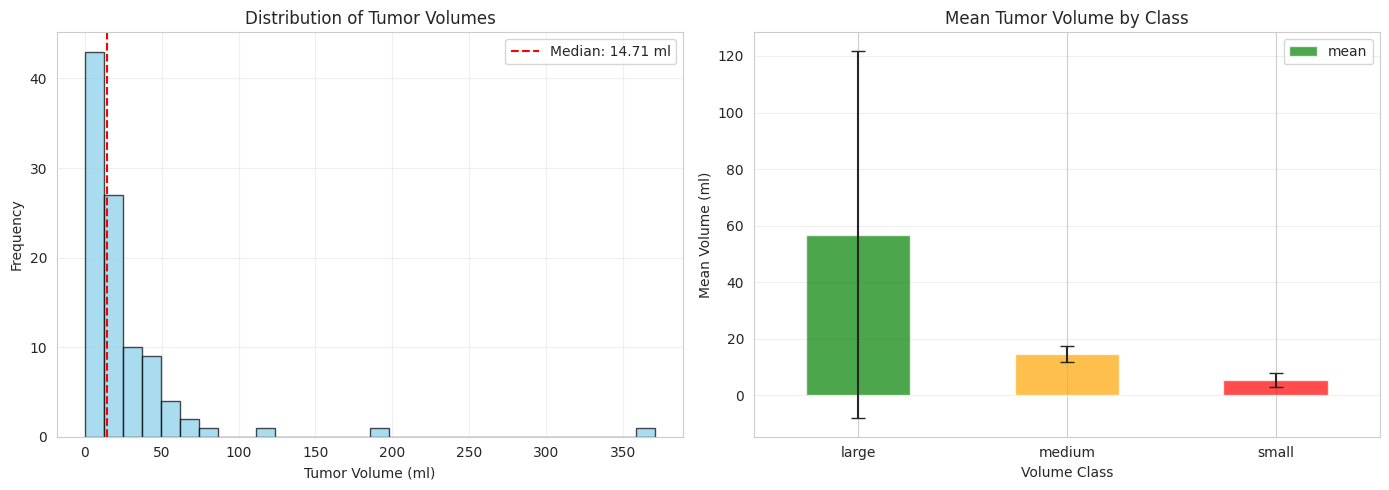

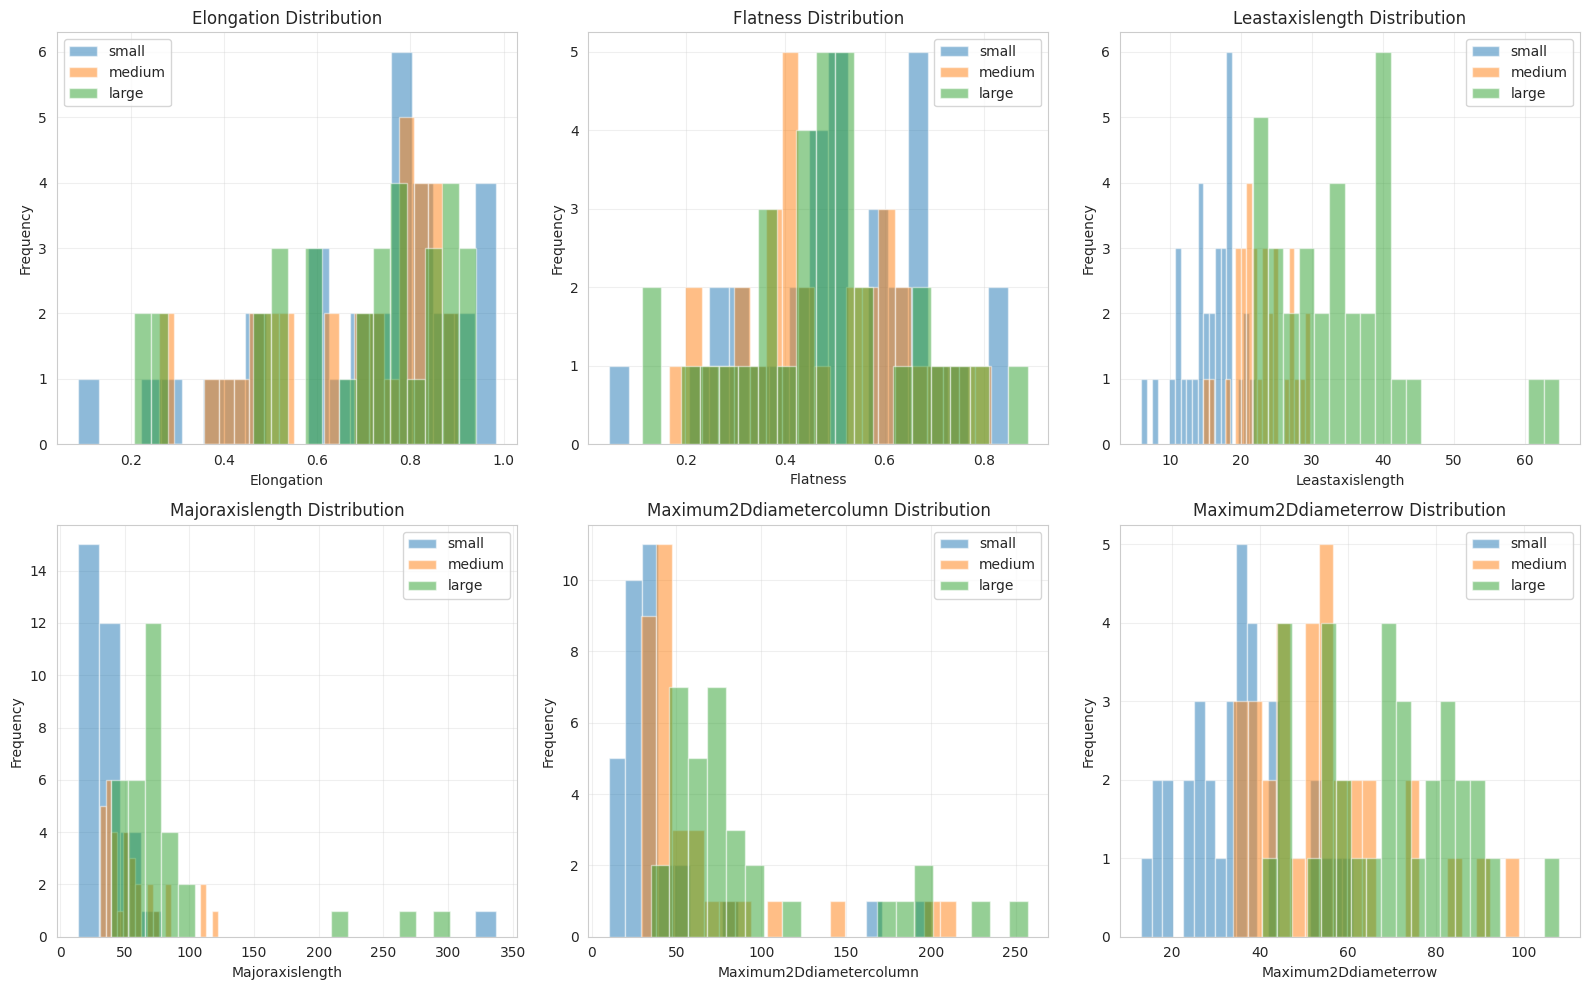

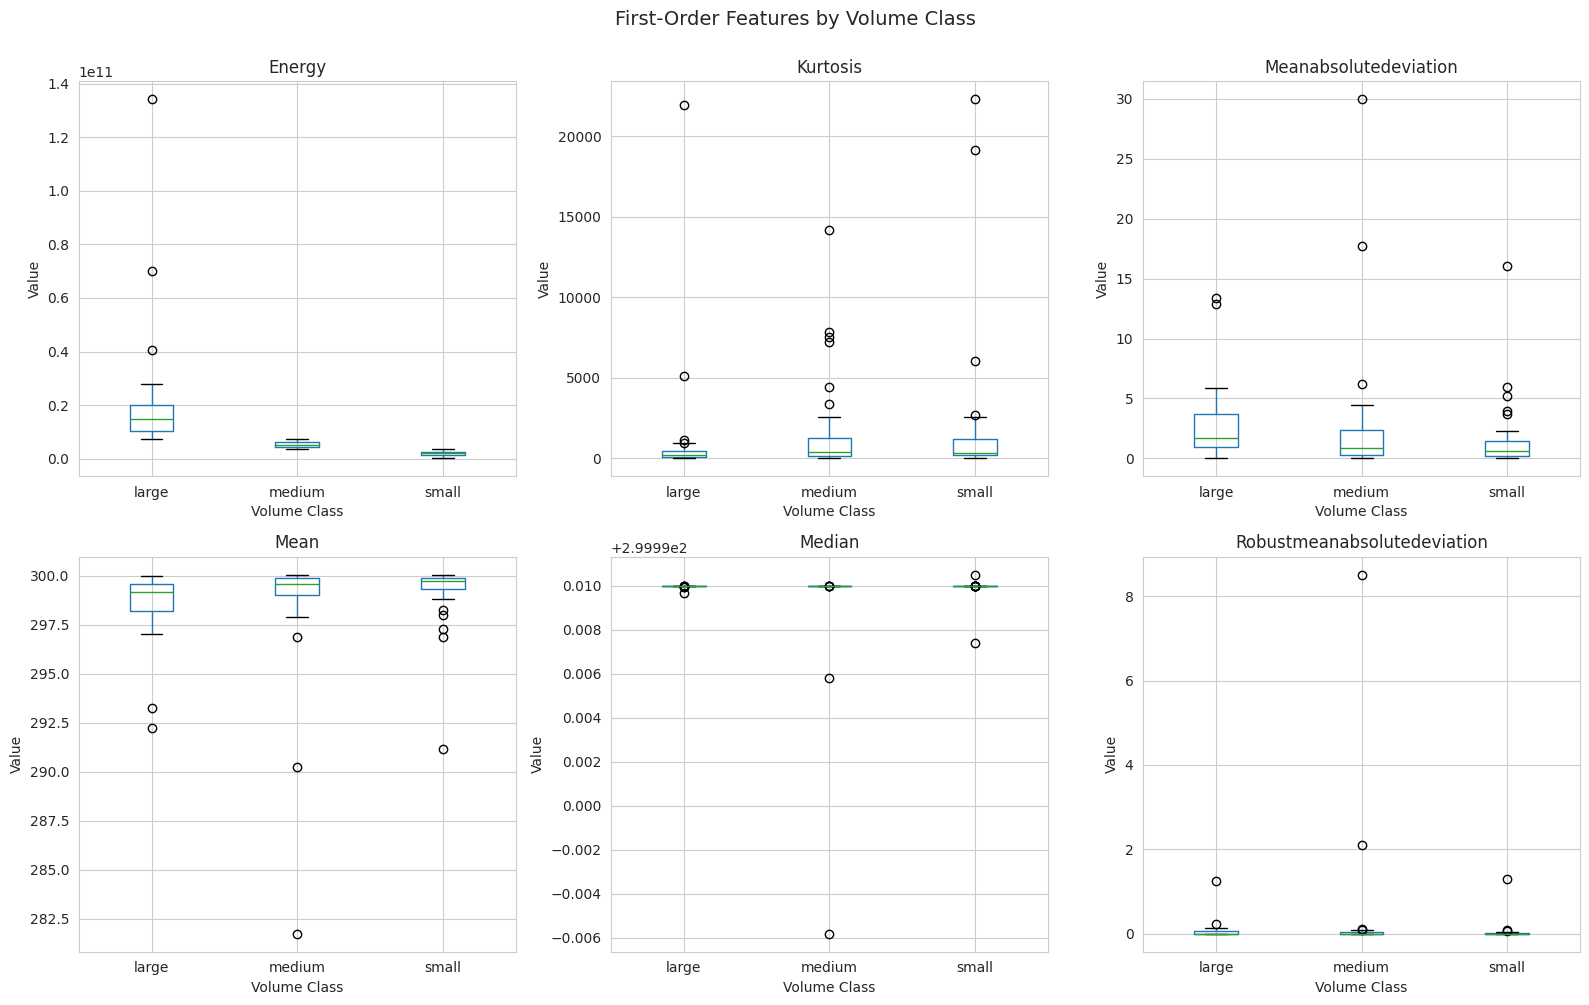

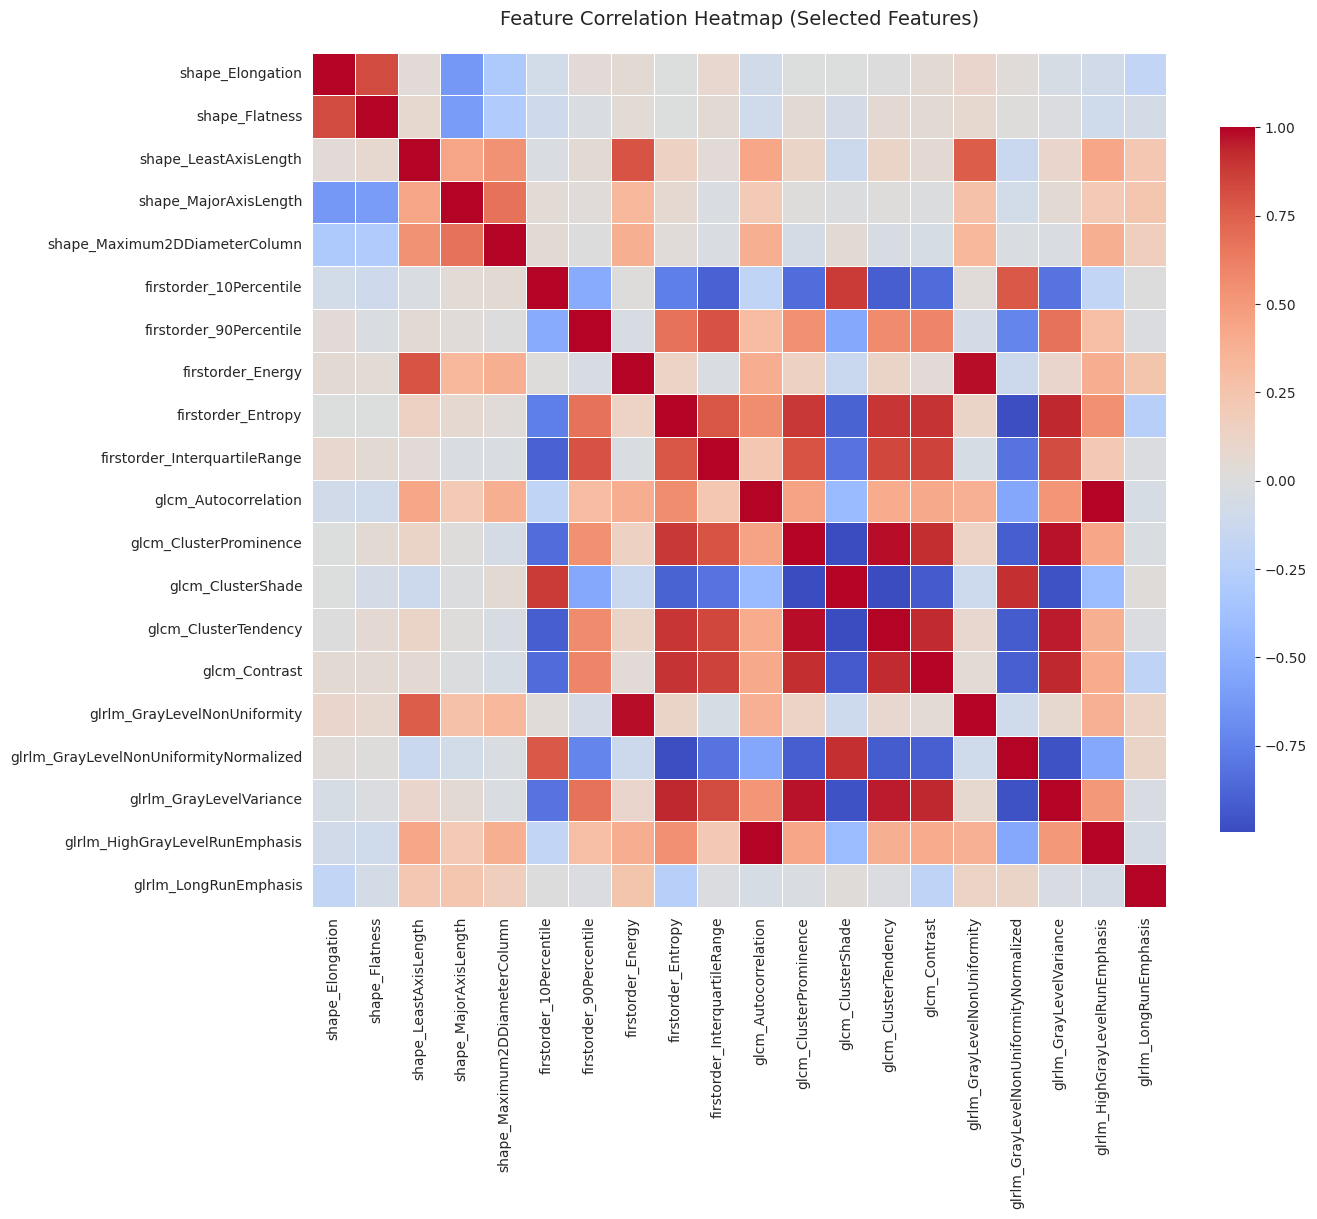

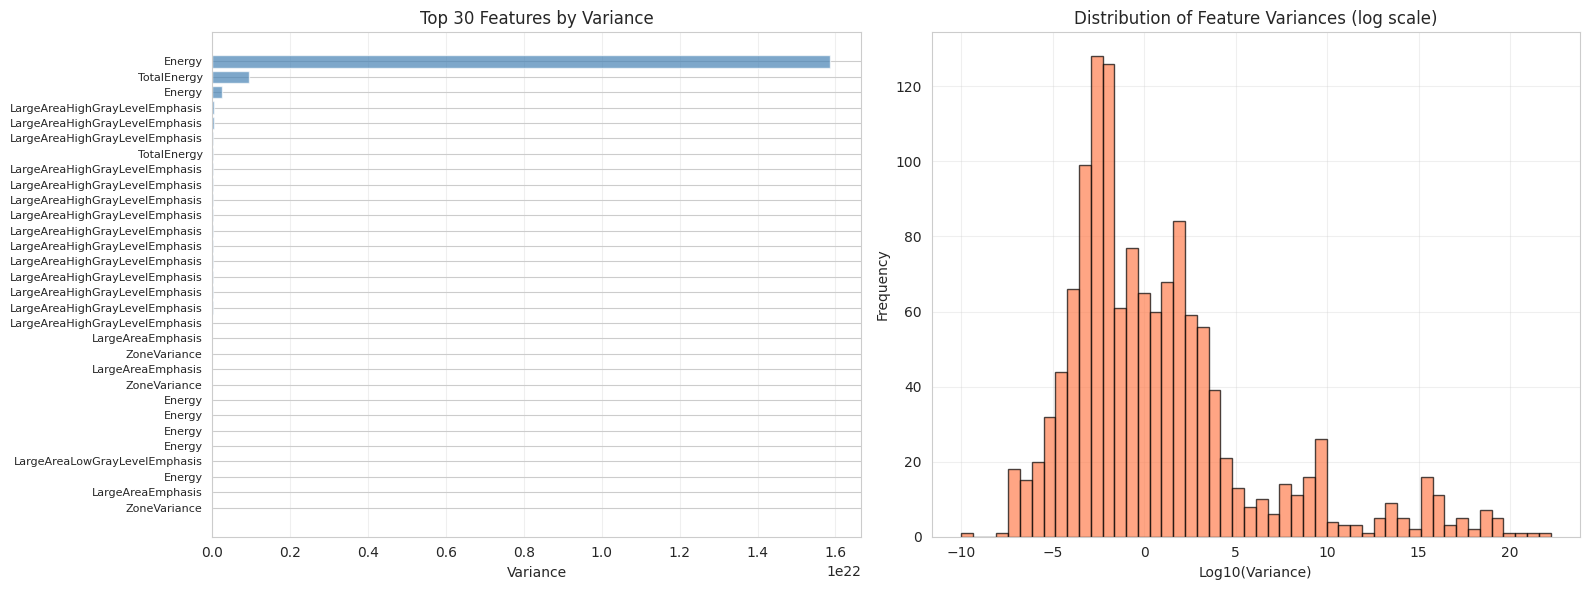

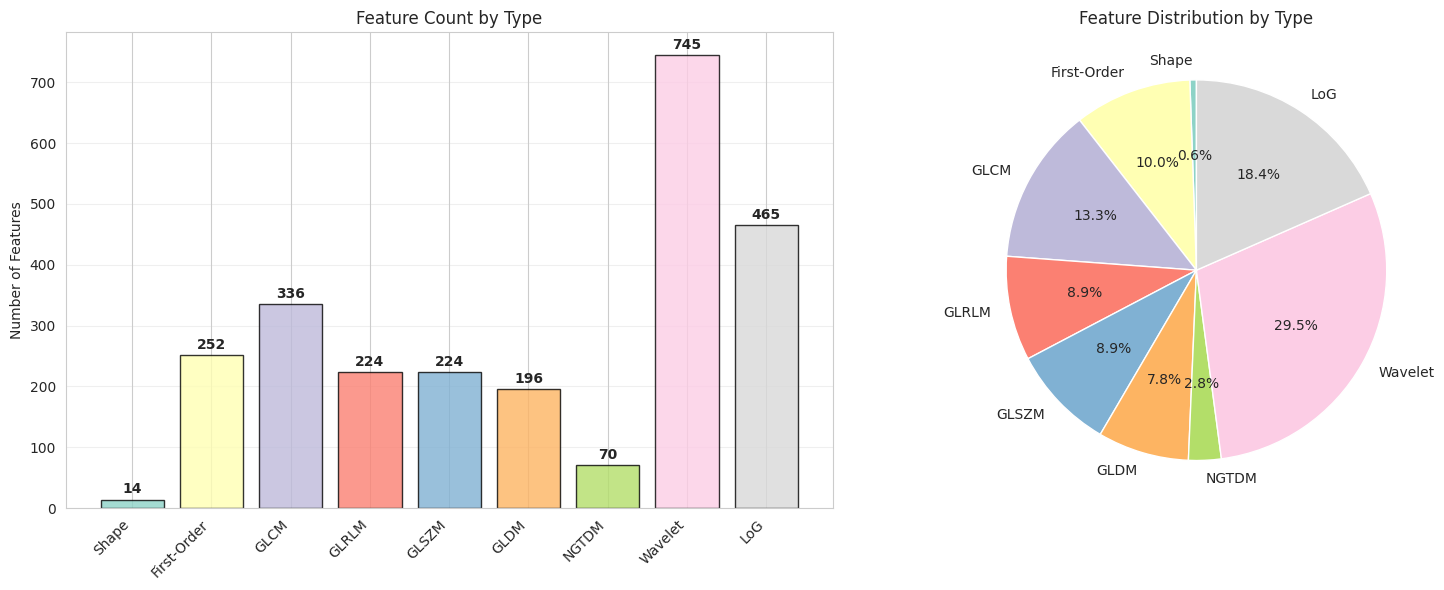

In [28]:
"""
RADIOMICS FEATURE ANALYSIS & VISUALIZATION
===========================================
Analyze and visualize extracted radiomics features
Run this AFTER feature extraction is complete
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# ============================================================================
# CONFIGURATION
# ============================================================================

OUTPUT_DIR = Path("./radiomics_output")
FEATURES_FILE = OUTPUT_DIR / "radiomics_features_all.csv"
ANALYSIS_DIR = OUTPUT_DIR / "analysis"
ANALYSIS_DIR.mkdir(exist_ok=True)

# ============================================================================
# LOAD DATA
# ============================================================================

print("="*70)
print("RADIOMICS FEATURE ANALYSIS")
print("="*70)

if not FEATURES_FILE.exists():
    print(f"\n❌ Features file not found: {FEATURES_FILE}")
    print("Please run feature extraction first!")
    exit()

print(f"\n📂 Loading features from: {FEATURES_FILE}")
df = pd.read_csv(FEATURES_FILE)

print(f"\n📊 Dataset Overview:")
print(f"  • Total cases: {len(df)}")
print(f"  • Total columns: {len(df.columns)}")
print(f"  • Volume classes: {df['volume_class'].value_counts().to_dict()}")

# Separate metadata and features
metadata_cols = ['case_id', 'tumor_volume_ml', 'volume_class']
feature_cols = [col for col in df.columns if col not in metadata_cols]

print(f"\n✨ Feature Statistics:")
print(f"  • Total features extracted: {len(feature_cols)}")

# Categorize features by type
shape_features = [c for c in feature_cols if 'shape_' in c.lower()]
firstorder_features = [c for c in feature_cols if 'firstorder_' in c.lower()]
glcm_features = [c for c in feature_cols if 'glcm_' in c.lower()]
glrlm_features = [c for c in feature_cols if 'glrlm_' in c.lower()]
glszm_features = [c for c in feature_cols if 'glszm_' in c.lower()]
gldm_features = [c for c in feature_cols if 'gldm_' in c.lower()]
ngtdm_features = [c for c in feature_cols if 'ngtdm_' in c.lower()]
wavelet_features = [c for c in feature_cols if 'wavelet' in c.lower()]
log_features = [c for c in feature_cols if 'log-' in c.lower()]

print(f"\n📈 Feature Breakdown by Type:")
print(f"  • Shape: {len(shape_features)}")
print(f"  • First-Order: {len(firstorder_features)}")
print(f"  • GLCM: {len(glcm_features)}")
print(f"  • GLRLM: {len(glrlm_features)}")
print(f"  • GLSZM: {len(glszm_features)}")
print(f"  • GLDM: {len(gldm_features)}")
print(f"  • NGTDM: {len(ngtdm_features)}")
print(f"  • Wavelet: {len(wavelet_features)}")
print(f"  • LoG: {len(log_features)}")

# ============================================================================
# DATA QUALITY CHECKS
# ============================================================================

print(f"\n🔍 Data Quality Checks:")

# Check for NaNs
nan_counts = df[feature_cols].isna().sum()
features_with_nans = nan_counts[nan_counts > 0]

if len(features_with_nans) > 0:
    print(f"  ⚠️  Features with NaN values: {len(features_with_nans)}")
    print(f"     Max NaNs in a feature: {features_with_nans.max()}")
else:
    print(f"  ✅ No NaN values found")

# Check for constant features
constant_features = []
for col in feature_cols:
    if df[col].nunique() == 1:
        constant_features.append(col)

if constant_features:
    print(f"  ⚠️  Constant features (no variance): {len(constant_features)}")
else:
    print(f"  ✅ No constant features")

# Check for infinite values
inf_features = [
    col for col in feature_cols
    if pd.api.types.is_numeric_dtype(df[col]) and np.isinf(df[col].astype(float)).any()
]


if inf_features:
    print(f"  ⚠️  Features with infinite values: {len(inf_features)}")
else:
    print(f"  ✅ No infinite values")

# ============================================================================
# VISUALIZATION 1: VOLUME DISTRIBUTION
# ============================================================================

print(f"\n📊 Generating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Volume distribution
axes[0].hist(df['tumor_volume_ml'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['tumor_volume_ml'].median(), color='red', linestyle='--', 
                label=f'Median: {df["tumor_volume_ml"].median():.2f} ml')
axes[0].set_xlabel('Tumor Volume (ml)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Tumor Volumes')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volume by class
volume_by_class = df.groupby('volume_class')['tumor_volume_ml'].agg(['mean', 'std', 'count'])
volume_by_class.plot(kind='bar', y='mean', ax=axes[1], color=['green', 'orange', 'red'], 
                      yerr=volume_by_class['std'], capsize=5, alpha=0.7)
axes[1].set_xlabel('Volume Class')
axes[1].set_ylabel('Mean Volume (ml)')
axes[1].set_title('Mean Tumor Volume by Class')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / "01_volume_distribution.png", dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: 01_volume_distribution.png")

# ============================================================================
# VISUALIZATION 2: SHAPE FEATURES
# ============================================================================

if shape_features:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    # Select top 6 shape features
    shape_features_clean = [f for f in shape_features if 'diag' not in f.lower()][:6]
    
    for idx, feature in enumerate(shape_features_clean):
        for volume_class in ['small', 'medium', 'large']:
            data = df[df['volume_class'] == volume_class][feature]
            axes[idx].hist(data, bins=20, alpha=0.5, label=volume_class)
        
        axes[idx].set_xlabel(feature.split('_')[-1].title())
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'{feature.split("_")[-1].title()} Distribution')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(ANALYSIS_DIR / "02_shape_features.png", dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: 02_shape_features.png")

# ============================================================================
# VISUALIZATION 3: FIRST-ORDER STATISTICS
# ============================================================================

if firstorder_features:
    # Select key first-order features
    key_firstorder = [f for f in firstorder_features if any(x in f.lower() for x in 
                     ['mean', 'median', 'std', 'skewness', 'kurtosis', 'energy'])][:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(key_firstorder):
        df.boxplot(column=feature, by='volume_class', ax=axes[idx])
        axes[idx].set_xlabel('Volume Class')
        axes[idx].set_ylabel('Value')
        axes[idx].set_title(feature.split('_')[-1].title())
        plt.sca(axes[idx])
        plt.xticks(rotation=0)
    
    plt.suptitle('First-Order Features by Volume Class', fontsize=14, y=1.00)
    plt.tight_layout()
    plt.savefig(ANALYSIS_DIR / "03_firstorder_features.png", dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: 03_firstorder_features.png")

# ============================================================================
# VISUALIZATION 4: FEATURE CORRELATION (TOP FEATURES)
# ============================================================================

print(f"\n🔥 Computing feature correlations...")

# Select subset of diverse features for correlation
selected_features = (
    shape_features[:5] + 
    firstorder_features[:5] + 
    glcm_features[:5] + 
    glrlm_features[:5]
)

if len(selected_features) > 0:
    corr_matrix = df[selected_features].corr()
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Heatmap (Selected Features)', fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(ANALYSIS_DIR / "04_feature_correlation.png", dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: 04_feature_correlation.png")

# ============================================================================
# VISUALIZATION 5: FEATURE VARIANCE
# ============================================================================

# ============================================================================
# VISUALIZATION 5: FEATURE VARIANCE (SAFE & ROBUST)
# ============================================================================

print(f"\n📊 Analyzing feature variance...")

# Select only numeric columns for variance calculation
numeric_features = df[feature_cols].select_dtypes(include=[np.number])

# Detect and report non-numeric features (if any)
non_numeric = [col for col in feature_cols if col not in numeric_features.columns]
if non_numeric:
    print(f"  ⚠️ Skipping {len(non_numeric)} non-numeric features (e.g., {non_numeric[:5]}...)")

# Compute variance safely
feature_variances = numeric_features.var().sort_values(ascending=False)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Left plot: Top 30 features by variance ---
top_var_features = feature_variances.head(30)
axes[0].barh(range(len(top_var_features)), top_var_features.values,
             color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_var_features)))
axes[0].set_yticklabels(
    [f.split('_')[-1][:30] for f in top_var_features.index],
    fontsize=8
)
axes[0].invert_yaxis()
axes[0].set_xlabel('Variance')
axes[0].set_title('Top 30 Features by Variance')
axes[0].grid(True, alpha=0.3, axis='x')

# --- Right plot: Variance distribution ---
axes[1].hist(
    np.log10(feature_variances + 1e-10),
    bins=50, color='coral', edgecolor='black', alpha=0.7
)
axes[1].set_xlabel('Log10(Variance)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Feature Variances (log scale)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / "05_feature_variance.png", dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: 05_feature_variance.png")


# ============================================================================
# VISUALIZATION 6: FEATURE TYPE COMPARISON
# ============================================================================

feature_type_counts = {
    'Shape': len(shape_features),
    'First-Order': len(firstorder_features),
    'GLCM': len(glcm_features),
    'GLRLM': len(glrlm_features),
    'GLSZM': len(glszm_features),
    'GLDM': len(gldm_features),
    'NGTDM': len(ngtdm_features),
    'Wavelet': len(wavelet_features),
    'LoG': len(log_features)
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
colors = plt.cm.Set3(range(len(feature_type_counts)))
axes[0].bar(feature_type_counts.keys(), feature_type_counts.values(), color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Number of Features')
axes[0].set_title('Feature Count by Type')
axes[0].set_xticklabels(feature_type_counts.keys(), rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (key, value) in enumerate(feature_type_counts.items()):
    axes[0].text(i, value + 5, str(value), ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(feature_type_counts.values(), labels=feature_type_counts.keys(), 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Feature Distribution by Type')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / "06_feature_type_distribution.png", dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: 06_feature_type_distribution.png")

# ============================================================================
# SUMMARY STATISTICS TABLE
# ============================================================================

# ============================================================================
# SUMMARY STATISTICS (SAFE VERSION)
# ============================================================================

# ============================================================================
# SUMMARY STATISTICS (SAFE VERSION)
# ============================================================================

# Define feature groups if not already defined above
feature_groups = {
    'Shape': [c for c in df.columns if 'shape' in c.lower()],
    'FirstOrder': [c for c in df.columns if 'firstorder' in c.lower()],
    'GLCM': [c for c in df.columns if 'glcm' in c.lower()],
    'GLRLM': [c for c in df.columns if 'glrlm' in c.lower()],
    'GLSZM': [c for c in df.columns if 'glszm' in c.lower()],
    'GLDM': [c for c in df.columns if 'gldm' in c.lower()],
    'NGTDM': [c for c in df.columns if 'ngtdm' in c.lower()],
    'Wavelet': [c for c in df.columns if 'wavelet' in c.lower()],
    'LoG': [c for c in df.columns if 'log' in c.lower()],
}

print("\n📋 Generating summary statistics...")

summary_stats = []

# Iterate over feature types and compute statistics safely
for feature_type, features in feature_groups.items():
    if features:
        feature_data = df[features]

        # Keep only numeric columns
        numeric_data = feature_data.select_dtypes(include=[np.number])

        # Detect skipped columns (non-numeric)
        non_numeric = [col for col in feature_data.columns if col not in numeric_data.columns]
        if non_numeric:
            print(f"  ⚠️  Skipping {len(non_numeric)} non-numeric features in '{feature_type}' (e.g., {non_numeric[:3]}...)")

        # Compute stats safely
        if not numeric_data.empty:
            summary_stats.append({
                'Feature Type': feature_type,
                'Count': len(numeric_data.columns),
                'Mean Variance': numeric_data.var().mean(),
                'NaN Count': numeric_data.isna().sum().sum(),
                'Mean (avg)': numeric_data.mean().mean(),
                'Std (avg)': numeric_data.std().mean()
            })
        else:
            summary_stats.append({
                'Feature Type': feature_type,
                'Count': 0,
                'Mean Variance': np.nan,
                'NaN Count': 0,
                'Mean (avg)': np.nan,
                'Std (avg)': np.nan
            })

# Convert results to DataFrame
summary_df = pd.DataFrame(summary_stats)

# Save to CSV
summary_path = ANALYSIS_DIR / "feature_summary_statistics.csv"
summary_df.to_csv(summary_path, index=False)
print(f"  ✓ Saved: {summary_path.name}")

# Optional: quick printout
print("\n📊 Summary Statistics Preview:")
print(summary_df.round(3))


# ============================================================================
# FEATURE LIST EXPORT
# ============================================================================

print(f"\n💾 Exporting feature lists...")

feature_lists = {
    'all_features': feature_cols,
    'shape_features': shape_features,
    'firstorder_features': firstorder_features,
    'glcm_features': glcm_features,
    'glrlm_features': glrlm_features,
    'glszm_features': glszm_features,
    'gldm_features': gldm_features,
    'ngtdm_features': ngtdm_features,
    'wavelet_features': wavelet_features,
    'log_features': log_features
}

for name, features in feature_lists.items():
    if features:
        with open(ANALYSIS_DIR / f"{name}.txt", 'w') as f:
            for feature in features:
                f.write(f"{feature}\n")

print(f"  ✓ Feature lists saved to {ANALYSIS_DIR}")

# ============================================================================
# RECOMMENDATIONS
# ============================================================================

print(f"\n" + "="*70)
print("ANALYSIS COMPLETE - RECOMMENDATIONS")
print("="*70)

print(f"\n✅ Successfully analyzed {len(df)} cases with {len(feature_cols)} features")

print(f"\n💡 NEXT STEPS:")
print(f"   1. Review visualizations in: {ANALYSIS_DIR}")
print(f"   2. Check for features with high NaN counts (remove if >5%)")
print(f"   3. Remove constant features: {len(constant_features)}")
print(f"   4. Consider removing highly correlated features (>0.95)")
print(f"   5. Apply feature selection (variance threshold, correlation filter)")
print(f"   6. Use feature importance from ML models")

if len(features_with_nans) > 0:
    print(f"\n⚠️  WARNING: {len(features_with_nans)} features have NaN values")
    print(f"   Consider imputation or removal before modeling")

if constant_features:
    print(f"\n⚠️  WARNING: {len(constant_features)} constant features found")
    print(f"   These should be removed before modeling")

print(f"\n🎯 QUALITY METRICS:")
print(f"   • Feature completeness: {100 - (df[feature_cols].isna().sum().sum() / (len(df) * len(feature_cols)) * 100):.2f}%")
print(f"   • Average features per case: {len(feature_cols)}")
print(f"   • Recommended features for modeling: {len(feature_cols) - len(constant_features) - len(features_with_nans)}")

print(f"\n✅ All analysis results saved to: {ANALYSIS_DIR}")
print(f"\n" + "="*70)

In [30]:
"""
FEATURE PREPROCESSING & SELECTION PIPELINE
===========================================
Clean and select the most informative radiomics features

Steps:
1. Remove features with NaNs
2. Remove constant/near-constant features
3. Remove highly correlated features
4. Standardize features
5. Feature selection (multiple methods)
6. Save cleaned datasets
"""

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

OUTPUT_DIR = Path("./radiomics_output")
FEATURES_FILE = OUTPUT_DIR / "radiomics_features_all.csv"
CLEAN_DIR = OUTPUT_DIR / "cleaned"
CLEAN_DIR.mkdir(exist_ok=True)

# Thresholds
NAN_THRESHOLD = 0.05          # Remove features with >5% NaN
VARIANCE_THRESHOLD = 0.01     # Remove features with variance < 0.01
CORRELATION_THRESHOLD = 0.95  # Remove features with correlation > 0.95

# ============================================================================
# LOAD DATA
# ============================================================================

print("="*70)
print("FEATURE PREPROCESSING & SELECTION")
print("="*70)

df = pd.read_csv(FEATURES_FILE)
print(f"\n📂 Loaded: {FEATURES_FILE}")
print(f"   Shape: {df.shape}")

# Identify metadata columns
metadata_cols = [c for c in ['case_id', 'tumor_volume_ml', 'volume_class'] if c in df.columns]

# Select numeric feature columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in metadata_cols]

non_numeric = [col for col in df.columns if col not in metadata_cols + feature_cols]
if non_numeric:
    print(f"\n⚠️ Skipping {len(non_numeric)} non-numeric columns (e.g., {non_numeric[:5]}...)")

print(f"\n📊 Initial numeric feature count: {len(feature_cols)}")

# ============================================================================
# STEP 1: REMOVE FEATURES WITH TOO MANY NaNs
# ============================================================================

print(f"\n{'='*70}")
print("STEP 1: REMOVING FEATURES WITH EXCESSIVE NaNs")
print(f"{'='*70}")

nan_ratio = df[feature_cols].isna().mean()
features_to_remove_nan = nan_ratio[nan_ratio > NAN_THRESHOLD].index.tolist()

print(f"  • NaN threshold: {NAN_THRESHOLD*100}%")
print(f"  • Features to remove (NaN-heavy): {len(features_to_remove_nan)}")

feature_cols = [f for f in feature_cols if f not in features_to_remove_nan]
print(f"  ✓ Remaining features: {len(feature_cols)}")

# ============================================================================
# STEP 2: IMPUTE REMAINING NaNs WITH MEDIAN
# ============================================================================

print(f"\n{'='*70}")
print("STEP 2: IMPUTING REMAINING NaNs")
print(f"{'='*70}")

for col in feature_cols:
    if df[col].isna().any():
        df[col].fillna(df[col].median(), inplace=True)

print(f"  ✓ All remaining NaNs imputed with median values")

# ============================================================================
# STEP 3: REMOVE CONSTANT / NEAR-CONSTANT FEATURES
# ============================================================================

print(f"\n{'='*70}")
print("STEP 3: REMOVING CONSTANT/NEAR-CONSTANT FEATURES")
print(f"{'='*70}")

# Remove constant features first
constant_features = [col for col in feature_cols if df[col].nunique() <= 1]
print(f"  • Constant features (no variance): {len(constant_features)}")

# Apply VarianceThreshold
selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
X = df[feature_cols].copy()
selector.fit(X)

low_variance_mask = selector.get_support()
features_to_keep = [f for f, keep in zip(feature_cols, low_variance_mask) if keep]
removed_low_var = [f for f, keep in zip(feature_cols, low_variance_mask) if not keep]

print(f"  • Removed low-variance (<{VARIANCE_THRESHOLD}) features: {len(removed_low_var)}")
feature_cols = features_to_keep
print(f"  ✓ Remaining features: {len(feature_cols)}")

# ============================================================================
# STEP 4: REMOVE HIGHLY CORRELATED FEATURES
# ============================================================================

print(f"\n{'='*70}")
print("STEP 4: REMOVING HIGHLY CORRELATED FEATURES")
print(f"{'='*70}")

corr_matrix = df[feature_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > CORRELATION_THRESHOLD)]

print(f"  • Correlation threshold: {CORRELATION_THRESHOLD}")
print(f"  • Highly correlated features to drop: {len(to_drop)}")

feature_cols = [f for f in feature_cols if f not in to_drop]
print(f"  ✓ Remaining features after correlation filter: {len(feature_cols)}")

# ============================================================================
# STEP 5: SAVE CLEANED FEATURES
# ============================================================================

print(f"\n{'='*70}")
print("STEP 5: SAVING CLEANED FEATURES")
print(f"{'='*70}")

df_clean = df[metadata_cols + feature_cols].copy()
clean_path = CLEAN_DIR / "radiomics_features_cleaned.csv"
df_clean.to_csv(clean_path, index=False)
print(f"  ✓ Saved: {clean_path}")
print(f"    Shape: {df_clean.shape}")

# ============================================================================
# STEP 6: STANDARDIZE FEATURES
# ============================================================================

print(f"\n{'='*70}")
print("STEP 6: STANDARDIZING FEATURES (Z-SCORE)")
print(f"{'='*70}")

scaler = StandardScaler()
df_clean[feature_cols] = scaler.fit_transform(df_clean[feature_cols])
scaled_path = CLEAN_DIR / "radiomics_features_cleaned_scaled.csv"
df_clean.to_csv(scaled_path, index=False)
print(f"  ✓ Saved standardized features: {scaled_path}")

# ============================================================================
# STEP 7: TRAIN/VAL/TEST SPLITS (OPTIONAL)
# ============================================================================

print(f"\n{'='*70}")
print("STEP 7: SPLITTING INTO TRAIN/VAL/TEST SETS")
print(f"{'='*70}")

try:
    train_ids = pd.read_csv('split_train.csv')['case_id'].tolist()
    val_ids = pd.read_csv('split_val.csv')['case_id'].tolist()
    test_ids = pd.read_csv('split_test.csv')['case_id'].tolist()

    df_clean[df_clean['case_id'].isin(train_ids)].to_csv(CLEAN_DIR / "features_train_cleaned.csv", index=False)
    df_clean[df_clean['case_id'].isin(val_ids)].to_csv(CLEAN_DIR / "features_val_cleaned.csv", index=False)
    df_clean[df_clean['case_id'].isin(test_ids)].to_csv(CLEAN_DIR / "features_test_cleaned.csv", index=False)

    print("  ✓ Train/Val/Test splits saved")
except FileNotFoundError:
    print("  ⚠️ Split CSV files not found — skipping split step.")

# ============================================================================
# STEP 8: FEATURE SELECTION (ANOVA F-test)
# ============================================================================

print(f"\n{'='*70}")
print("STEP 8: FEATURE SELECTION (TOP-K by ANOVA F-test)")
print(f"{'='*70}")

if 'volume_class' in df_clean.columns:
    le = LabelEncoder()
    y = le.fit_transform(df_clean['volume_class'])
    X = df_clean[feature_cols]

    K_BEST = min(100, len(feature_cols))
    selector = SelectKBest(f_classif, k=K_BEST)
    selector.fit(X, y)
    selected_features = [f for f, s in zip(feature_cols, selector.get_support()) if s]

    df_anova = df_clean[metadata_cols + selected_features]
    anova_path = CLEAN_DIR / f"radiomics_features_top{K_BEST}.csv"
    df_anova.to_csv(anova_path, index=False)
    print(f"  ✓ Saved: {anova_path}")
else:
    print("  ⚠️ 'volume_class' not found — skipping ANOVA feature selection.")

# ============================================================================
# STEP 9: FEATURE IMPORTANCE (RANDOM FOREST)
# ============================================================================

print(f"\n{'='*70}")
print("STEP 9: FEATURE IMPORTANCE (RANDOM FOREST)")
print(f"{'='*70}")

if 'volume_class' in df_clean.columns:
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
    rf.fit(X, y)
    importance = pd.DataFrame({'feature': feature_cols, 'importance': rf.feature_importances_})
    importance = importance.sort_values('importance', ascending=False)

    importance.to_csv(CLEAN_DIR / "feature_importance_rf.csv", index=False)
    top_features = importance.head(min(50, len(feature_cols)))['feature'].tolist()

    df_rf = df_clean[metadata_cols + top_features]
    rf_path = CLEAN_DIR / f"radiomics_features_top{len(top_features)}_rf.csv"
    df_rf.to_csv(rf_path, index=False)
    print(f"  ✓ Saved: {rf_path}")
else:
    print("  ⚠️ 'volume_class' not found — skipping Random Forest feature importance.")

# ============================================================================
# SUMMARY
# ============================================================================

print(f"\n{'='*70}")
print("✅ PREPROCESSING COMPLETE")
print(f"{'='*70}")
print(f"   • Cleaned features saved: {clean_path.name}")
print(f"   • Scaled features saved: {scaled_path.name}")
print(f"   • Feature importance saved: feature_importance_rf.csv")
print(f"\n💡 Recommendation: Use the scaled cleaned dataset for ML modeling.")
print("="*70)


FEATURE PREPROCESSING & SELECTION

📂 Loaded: radiomics_output/radiomics_features_all.csv
   Shape: (99, 1356)

⚠️ Skipping 24 non-numeric columns (e.g., ['diag_Versions_PyRadiomics', 'diag_Versions_Numpy', 'diag_Versions_SimpleITK', 'diag_Versions_PyWavelet', 'diag_Versions_Python']...)

📊 Initial numeric feature count: 1329

STEP 1: REMOVING FEATURES WITH EXCESSIVE NaNs
  • NaN threshold: 5.0%
  • Features to remove (NaN-heavy): 0
  ✓ Remaining features: 1329

STEP 2: IMPUTING REMAINING NaNs
  ✓ All remaining NaNs imputed with median values

STEP 3: REMOVING CONSTANT/NEAR-CONSTANT FEATURES
  • Constant features (no variance): 1
  • Removed low-variance (<0.01) features: 486
  ✓ Remaining features: 843

STEP 4: REMOVING HIGHLY CORRELATED FEATURES
  • Correlation threshold: 0.95
  • Highly correlated features to drop: 489
  ✓ Remaining features after correlation filter: 354

STEP 5: SAVING CLEANED FEATURES
  ✓ Saved: radiomics_output/cleaned/radiomics_features_cleaned.csv
    Shape: (99